In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

RDKit WARNING: [23:34:02] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,400)

In [4]:
import sklearn
from sklearn.cluster import KMeans
from MulticoreTSNE import MulticoreTSNE as TSNE

In [5]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [6]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [9]:
with open('../scripts/graph_models/C_EG.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [10]:
device = 'cuda:1'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [11]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [12]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [13]:
model =torch.load(paths.save_path)
model = model.to(device)

In [14]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [15]:
elements = "H He Li Be B C N O F Ne Na Mg Al Si P S Cl Ar K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr Rb Sr Y Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I Xe Cs Ba La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb Lu Hf Ta W Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn Fr Ra Ac Th Pa U Np Pu Am Cm Bk Cf Es Fm Md No Lr Rf Db Sg Bh Hs Mt Ds Rg Cn Uut Fl Uup Lv Uus Uuo".split()
num2elem = dict(zip(range(1, len(elements)+1), elements))
elem2num = dict(zip(elements, range(1, len(elements)+1)))

In [16]:
model.eval()
representations = []
with torch.no_grad():
    for batch in test_loader:
        g = batch[0]
        h = model.embed(g.ndata['feats'].T)
        g.ndata['h'] = h
        for layer in model.rgcn.layers[:-1]:
            layer(g)
        h = g.ndata['h'].view((model.batch_size, model.n_nodes, model.h_dim))
        representations.append(h.cpu().detach().numpy())
reac_reps = np.concatenate(representations)

In [17]:
id2hidden = dict(zip(test_dataset.keys(), reac_reps))

In [18]:
reac_reps = []
id2reac = {}
for idx in id2hidden:
    n_atoms = len(test_dataset[idx]['reactants']['nodes'])
    n_molecules = len(test_dataset[idx]['reactants']['lengths']) - 1
    reac_reps.append(id2hidden[idx][n_atoms+n_molecules])
    id2reac[idx] = id2hidden[idx][n_atoms+n_molecules]
reac_reps = np.stack(reac_reps)

In [19]:
km = KMeans(n_clusters=15).fit(reac_reps)
km_reac = km.predict(reac_reps)

In [20]:
centers = km.cluster_centers_

In [22]:
reac_2d_embedded = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps)

In [23]:
idxs = list(id2hidden.keys())

In [41]:
with open('data_visualisation/2d_embeddings.pkl', 'wb') as f:
    pickle.dump(dict(zip(idxs, reac_2d_embedded)), f)

with open('data_visualisation/original_embeddings.pkl', 'wb') as f:
    pickle.dump(dict(zip(idxs, reac_reps)), f)

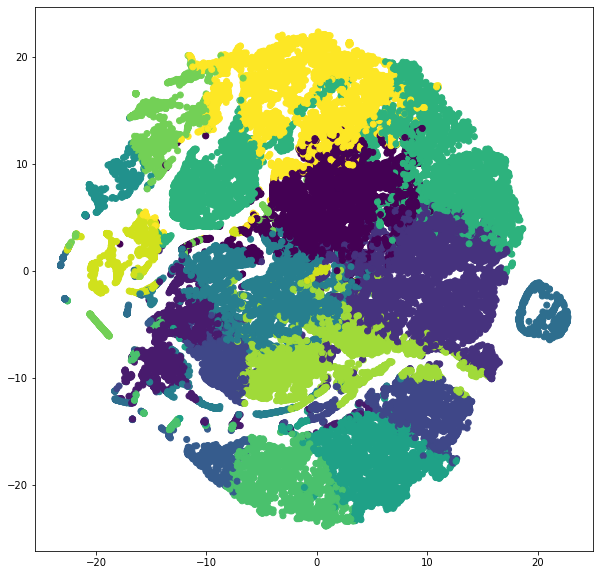

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(reac_2d_embedded[:, 0], reac_2d_embedded[:, 1], c=km_reac)
plt.show()

In [22]:
from scipy.spatial.distance import cosine

In [23]:
from IPython.display import display

In [24]:
def show_k_reactants(dataset, norms, indexes,):
    keys = list(dataset.keys())
    for idx in indexes:
        print(keys[idx])
        print(norms[idx])
        p, r = draw_gt_reaction(dataset[keys[idx]])
        display(SVG(p))
        display(SVG(r))

New center
15004
0.082809746


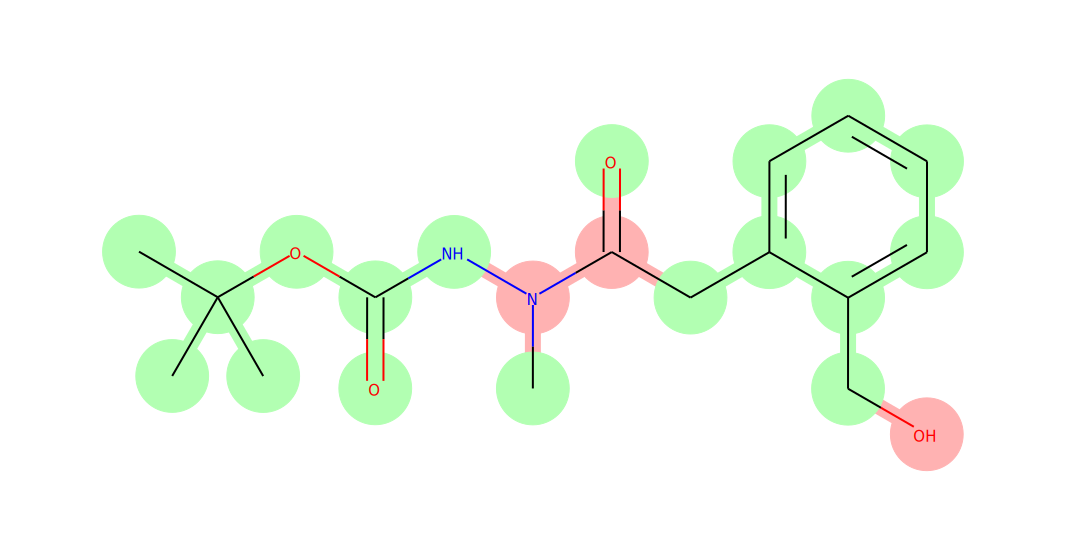

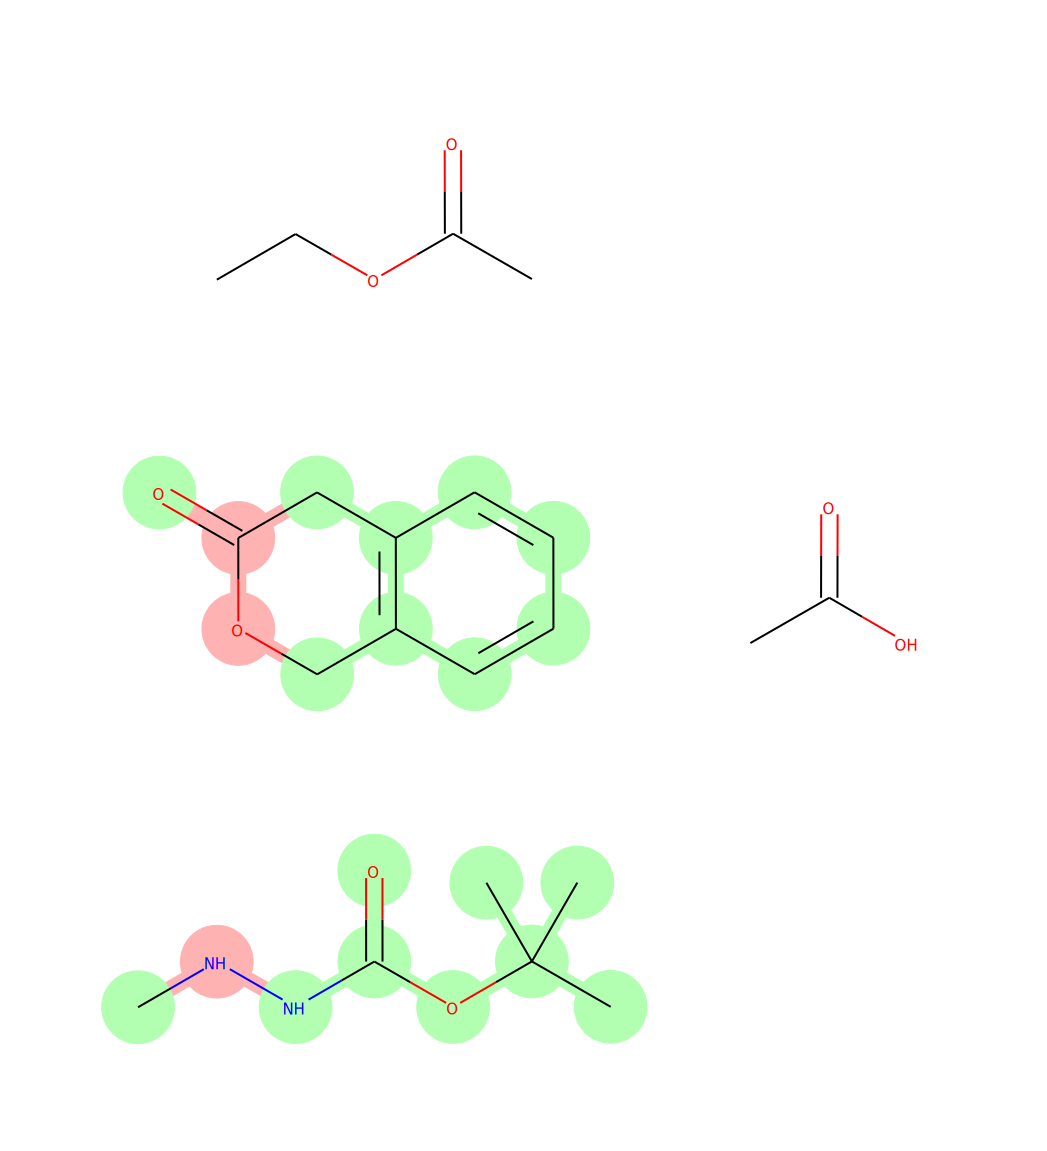

27708
0.0936742


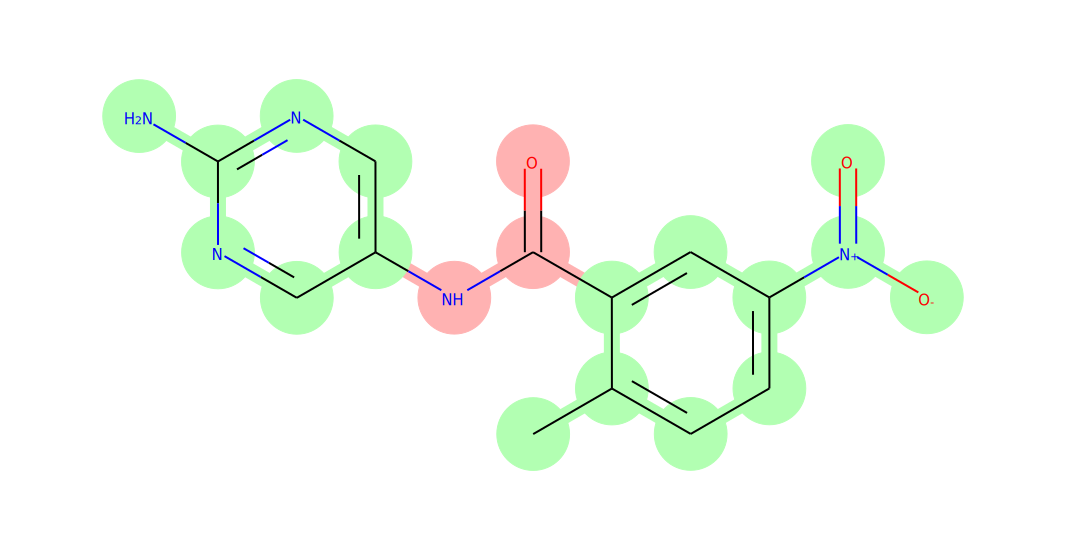

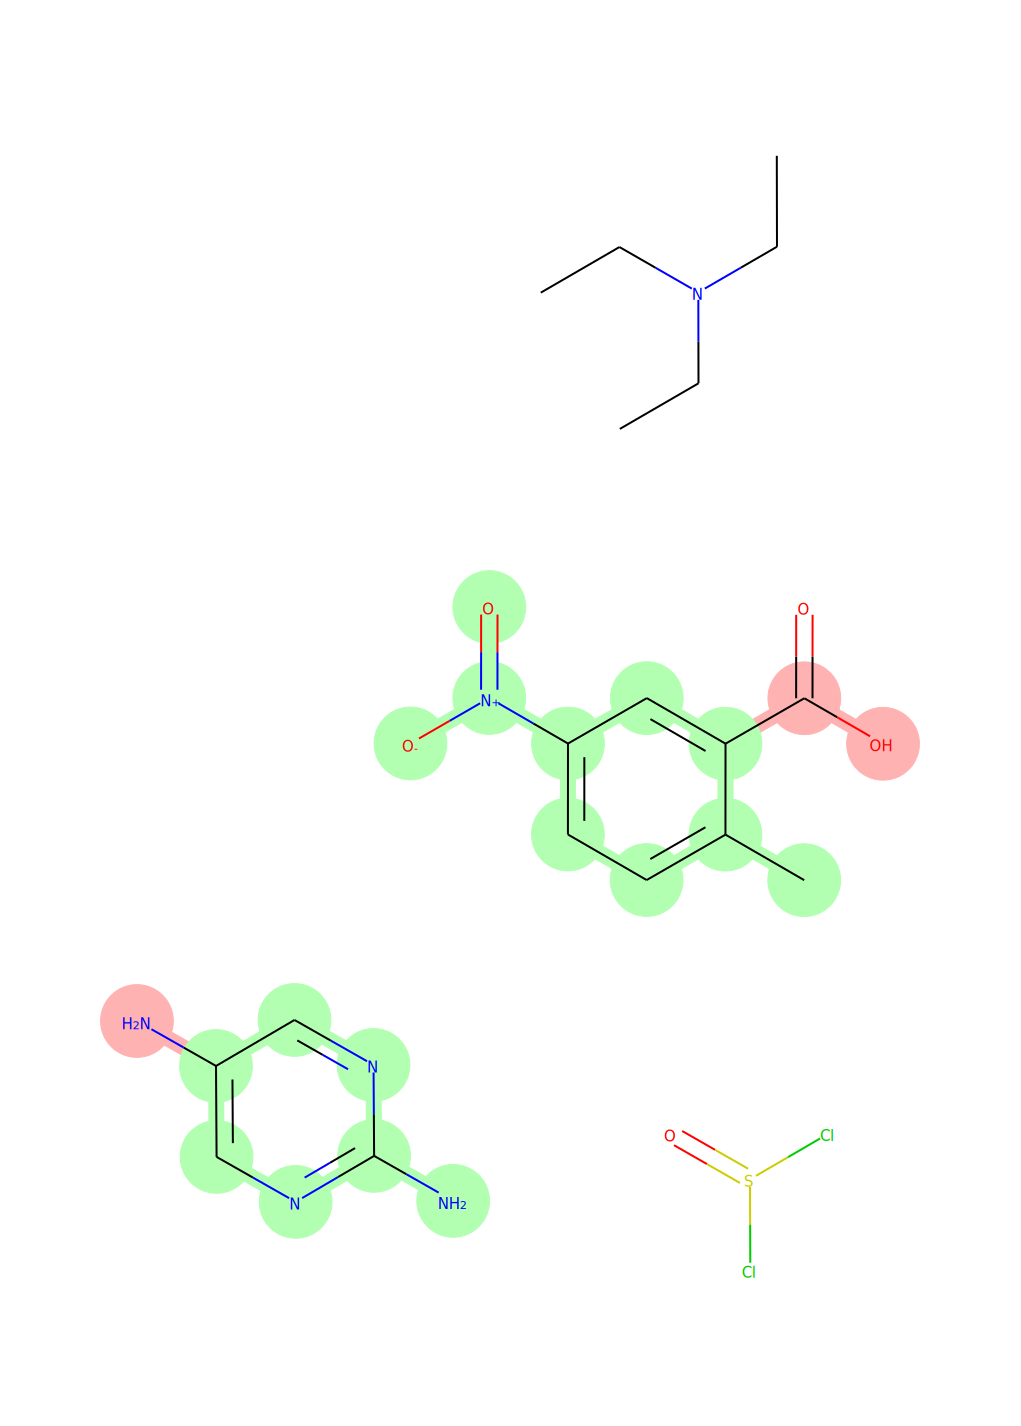

11431
0.10055358


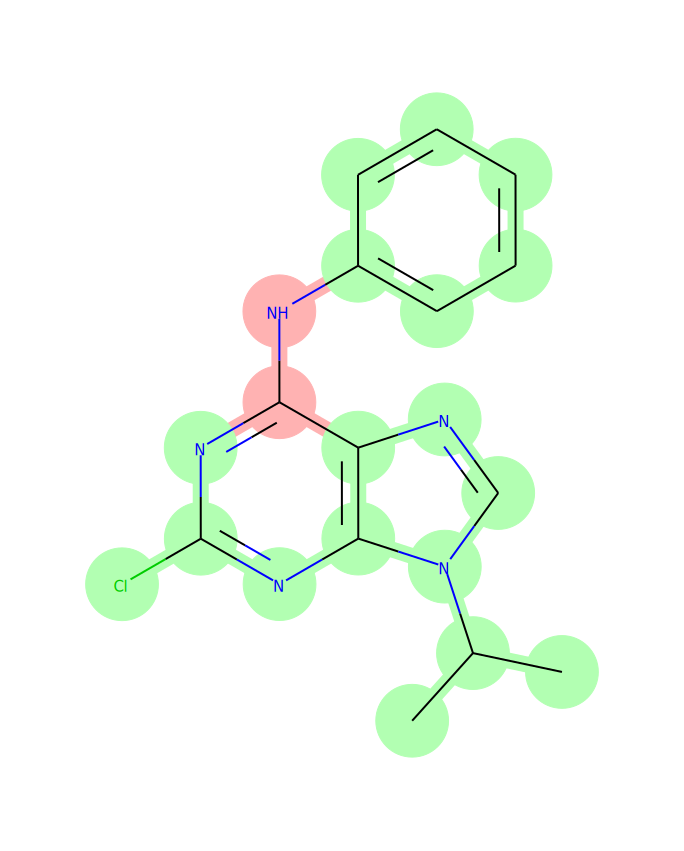

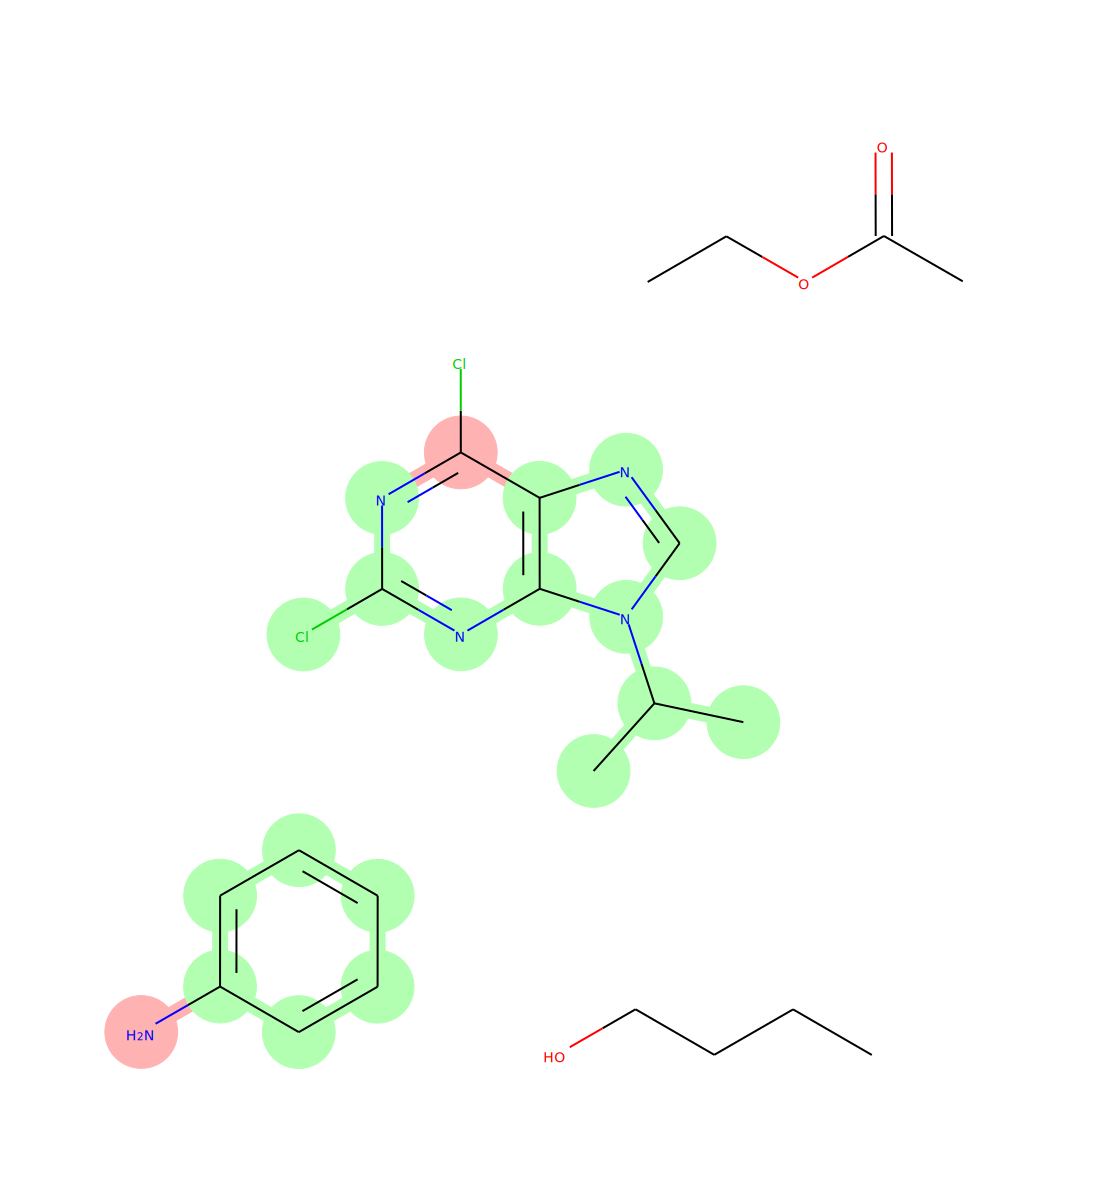

36227
0.13996232


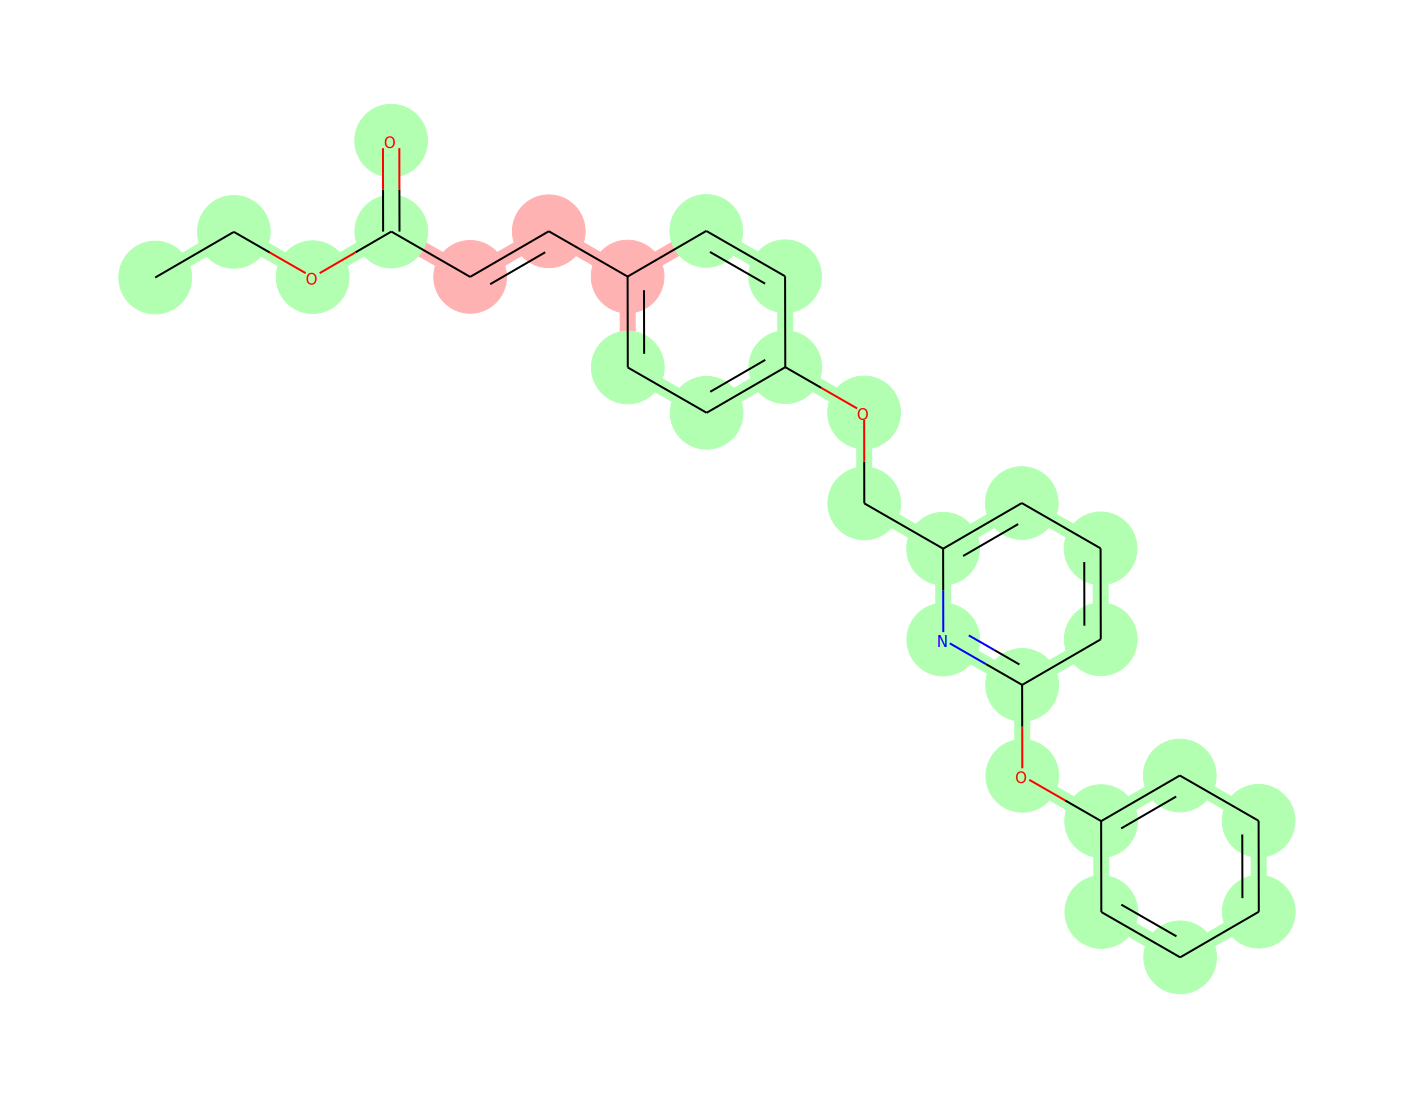

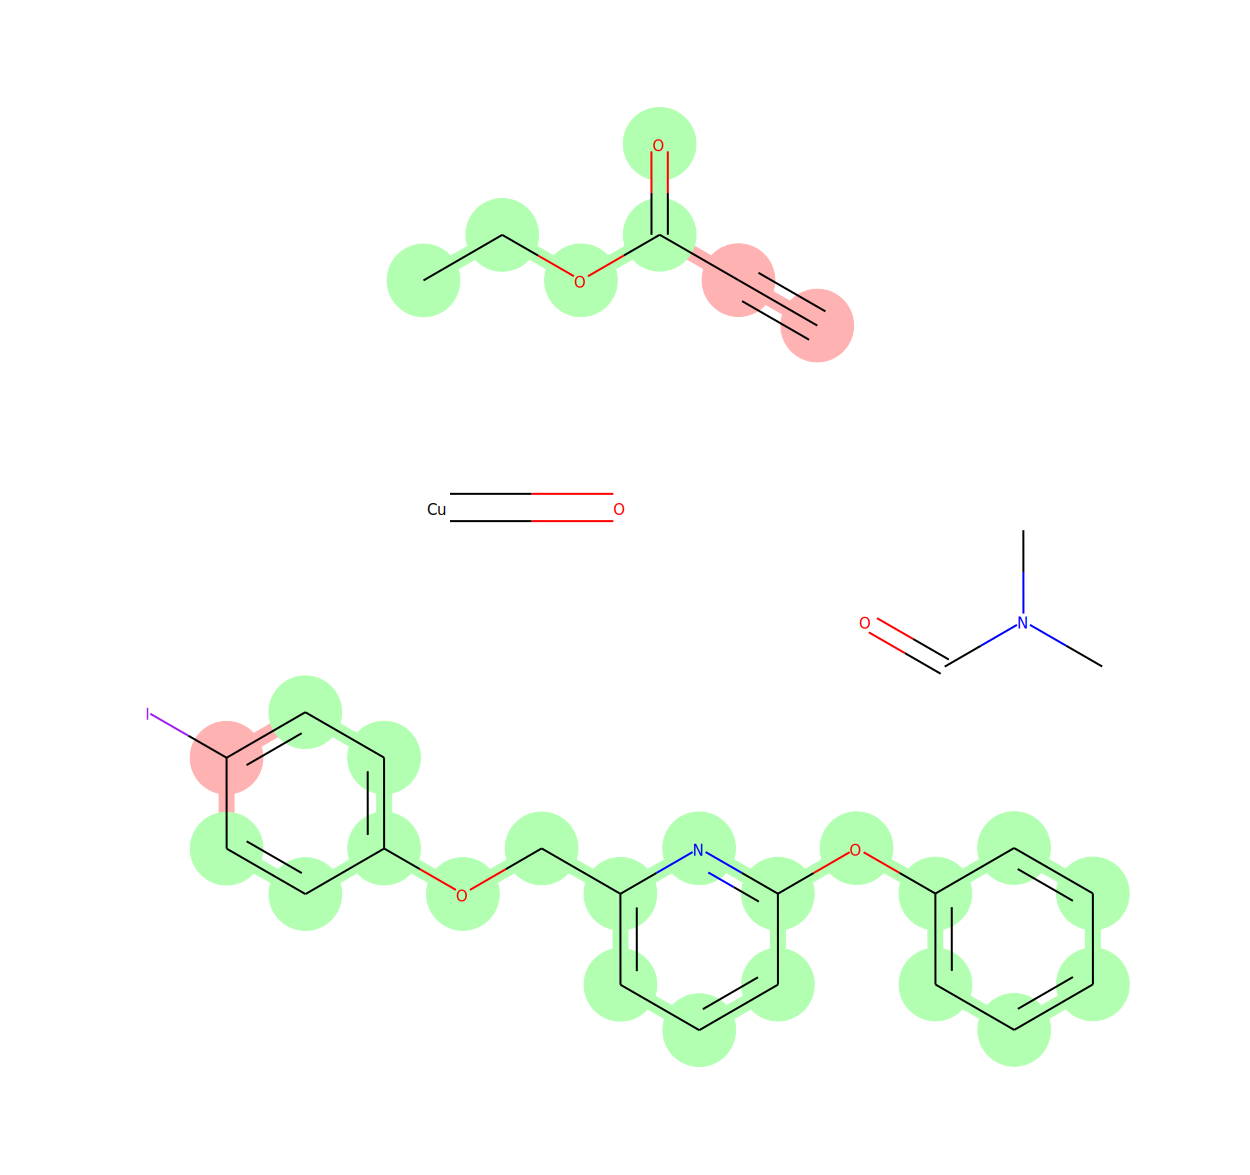

40605
0.86557263


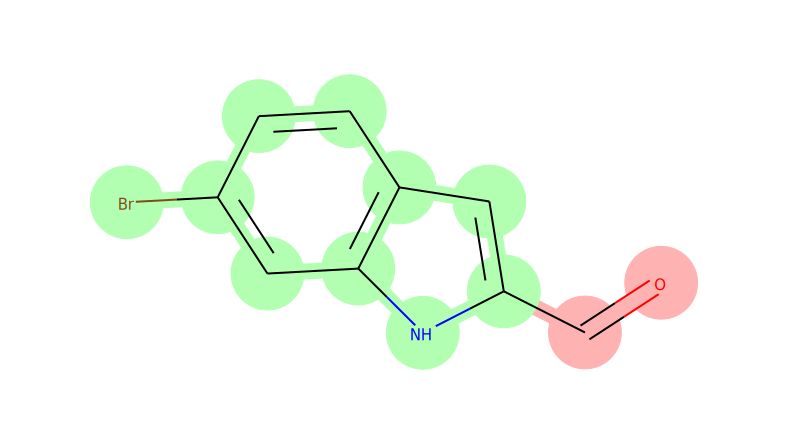

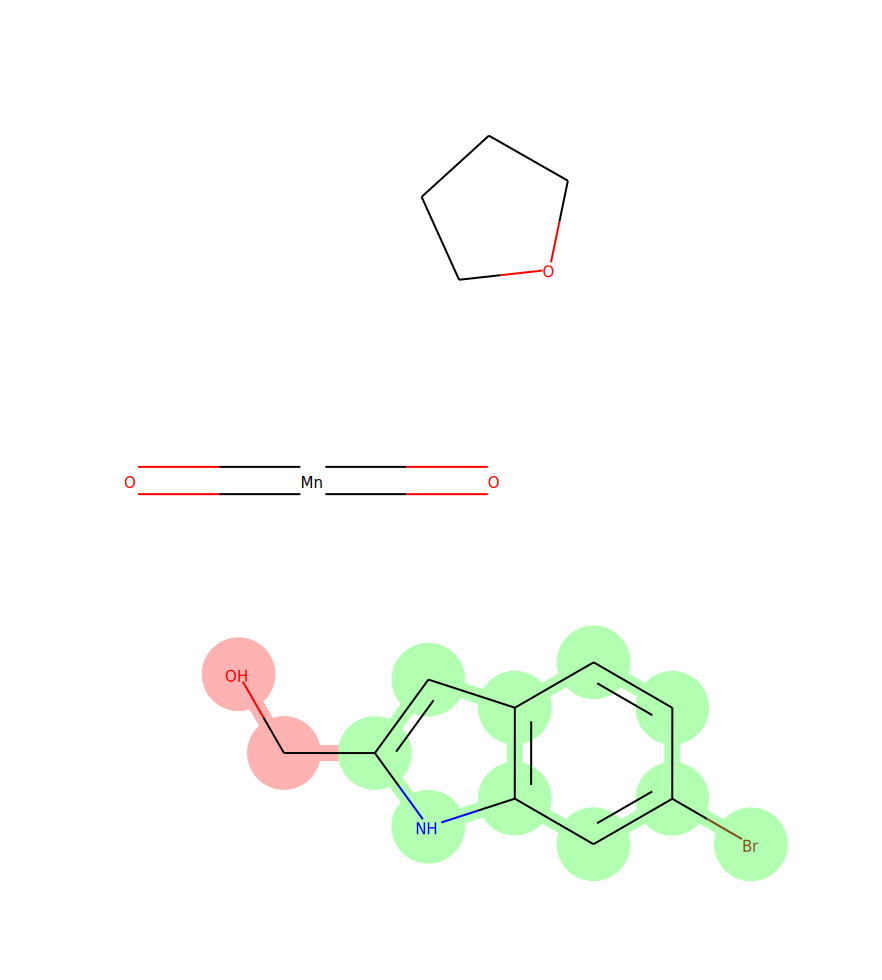

New center
16701
0.12316595


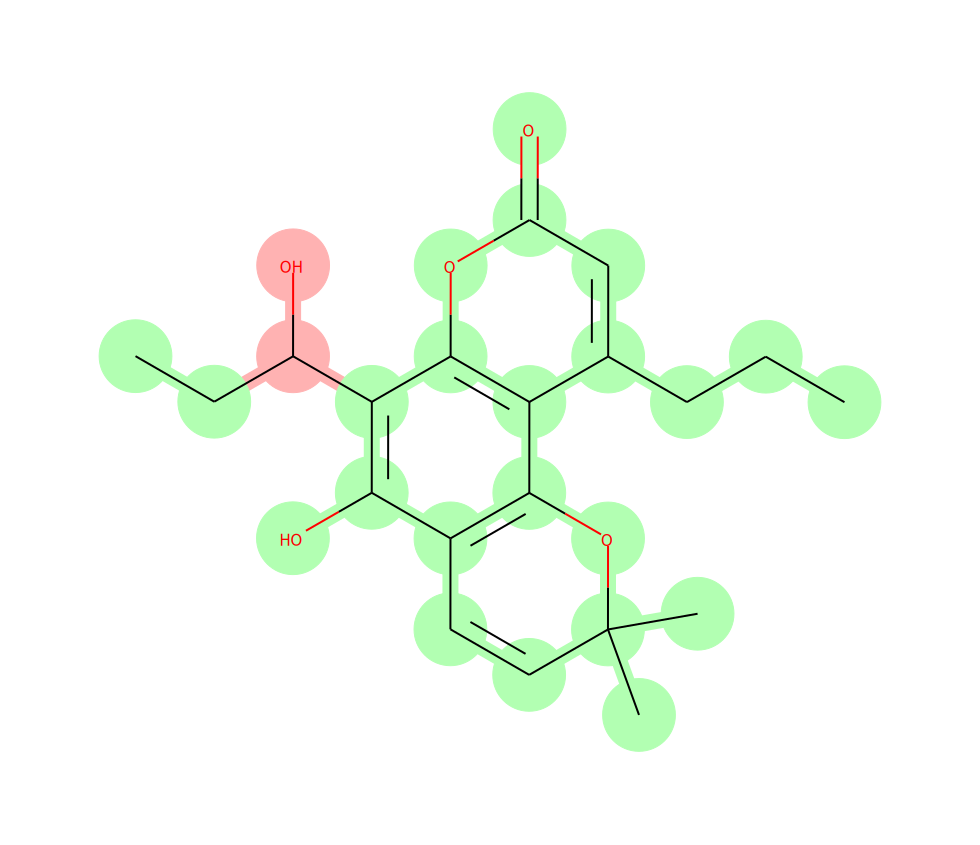

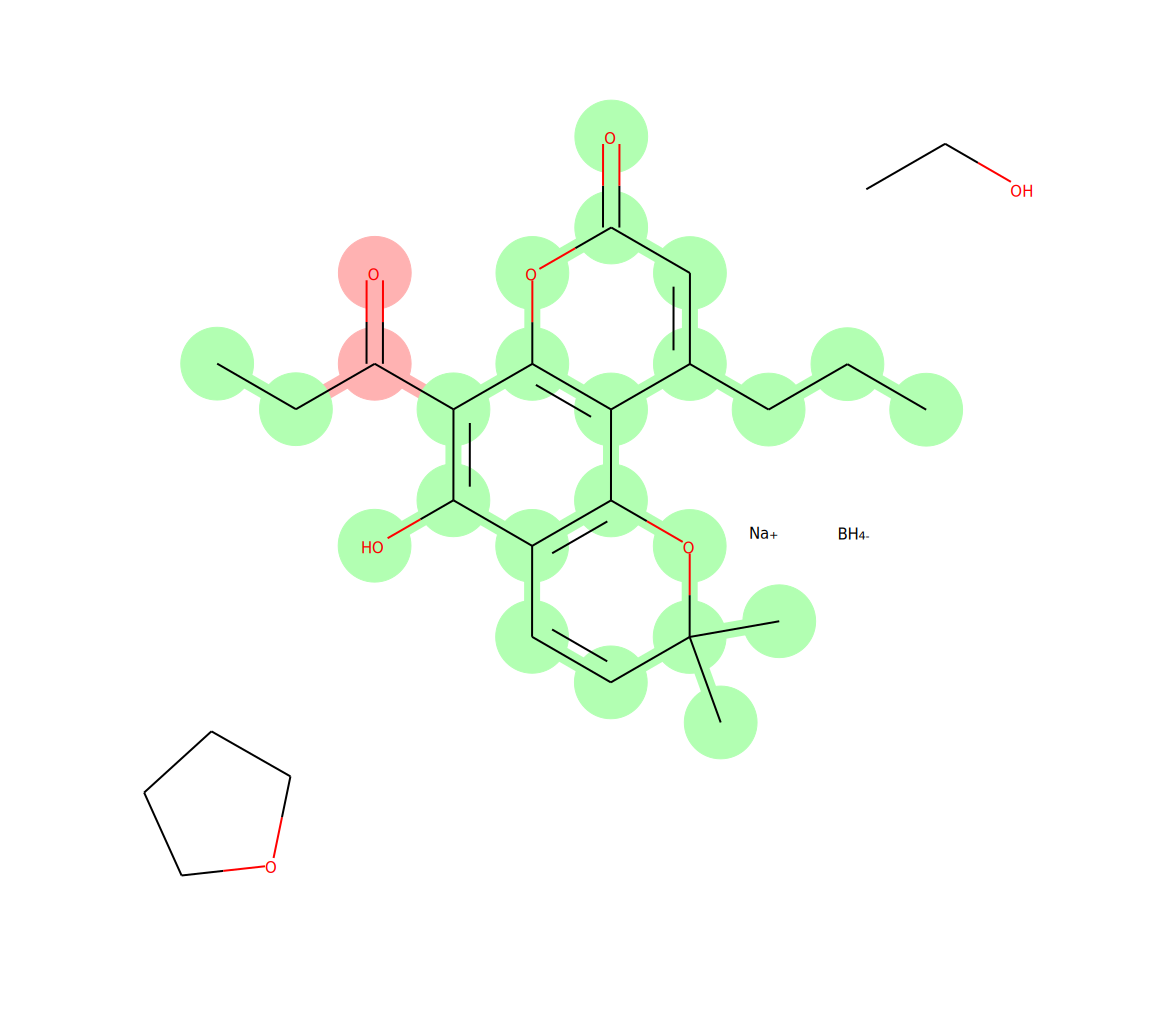

23730
0.12693639


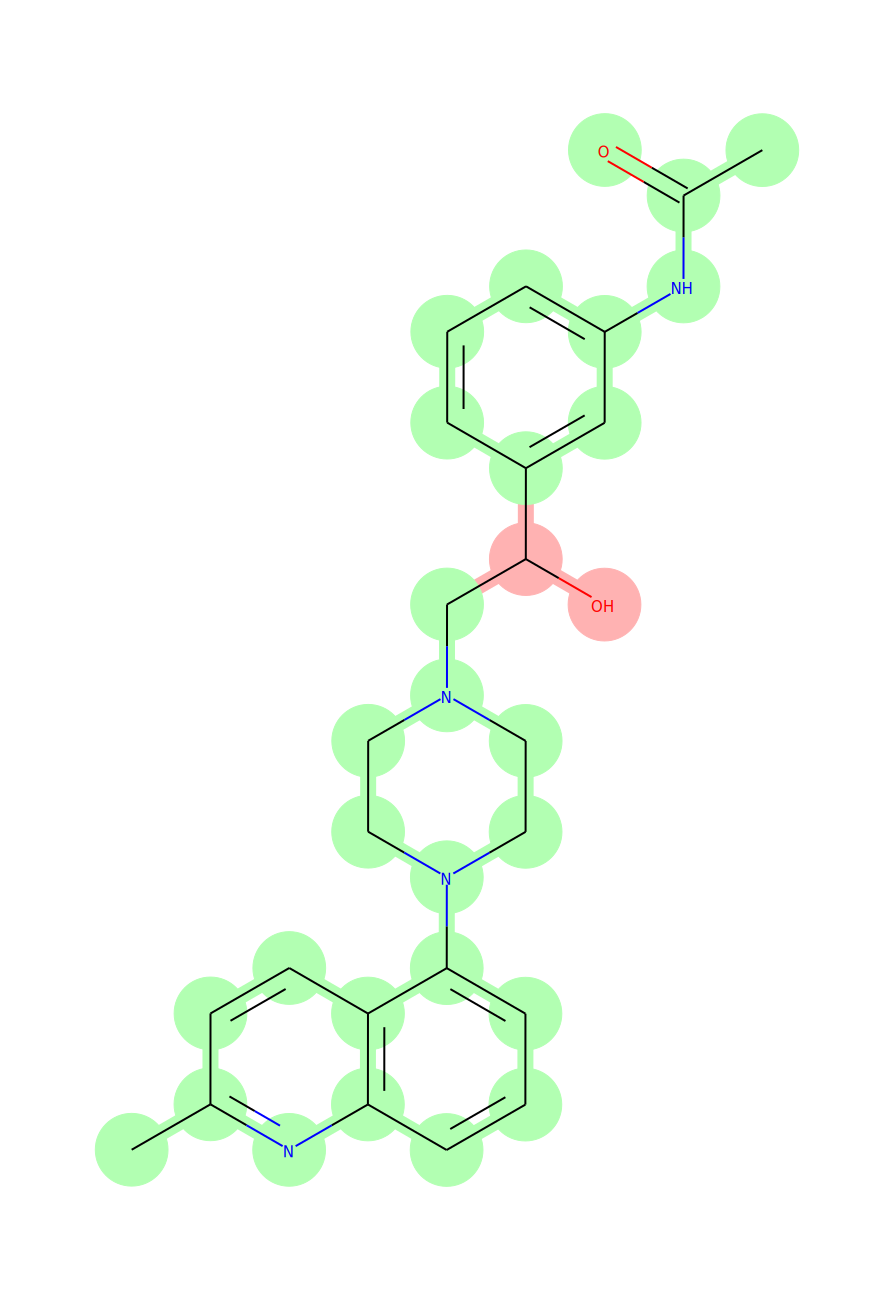

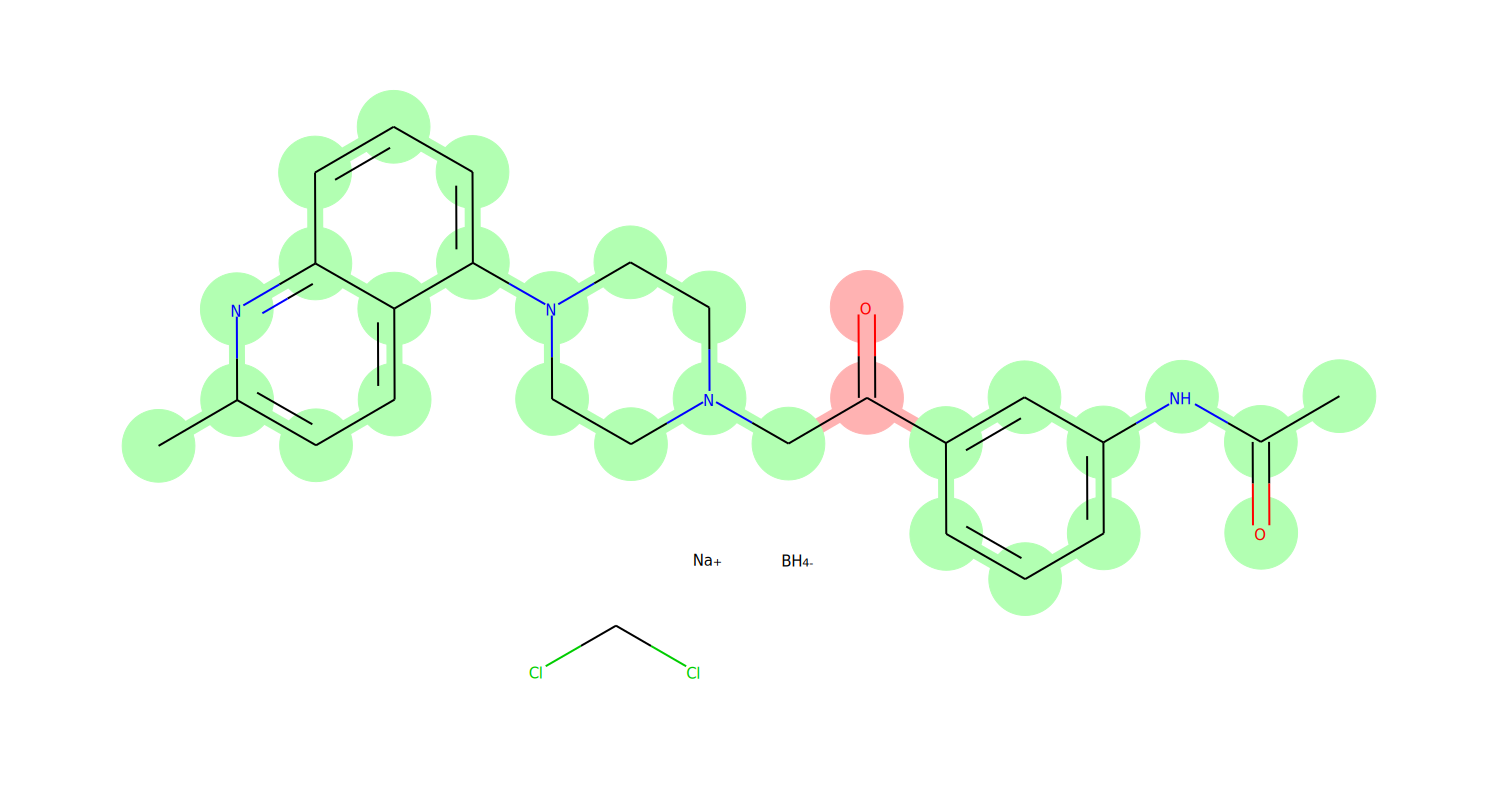

30977
0.12798412


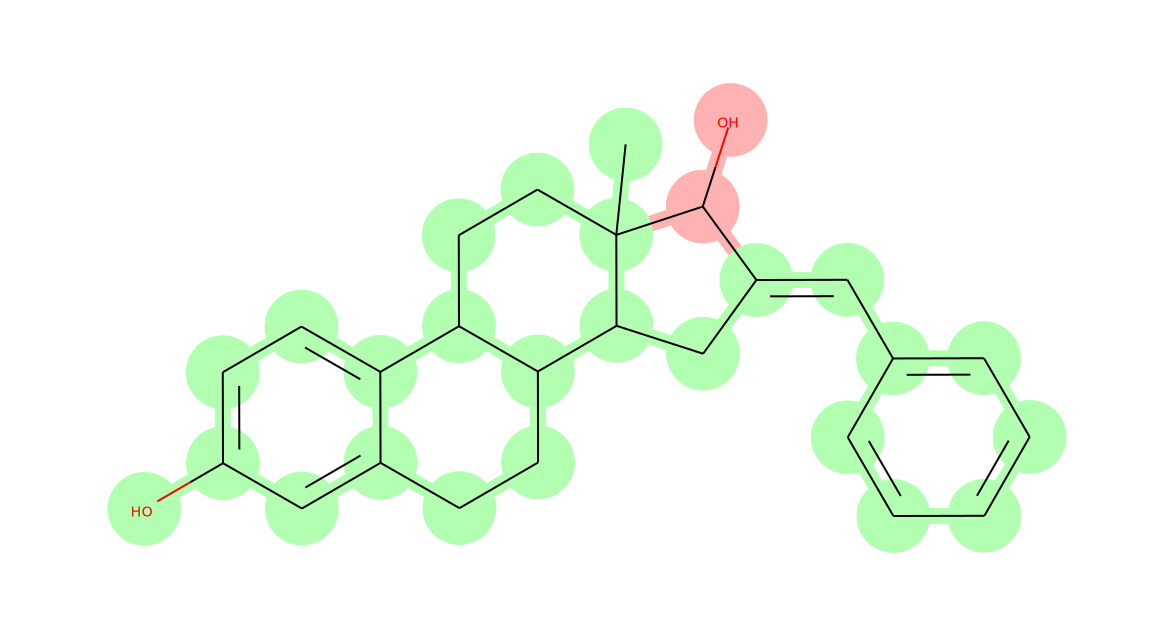

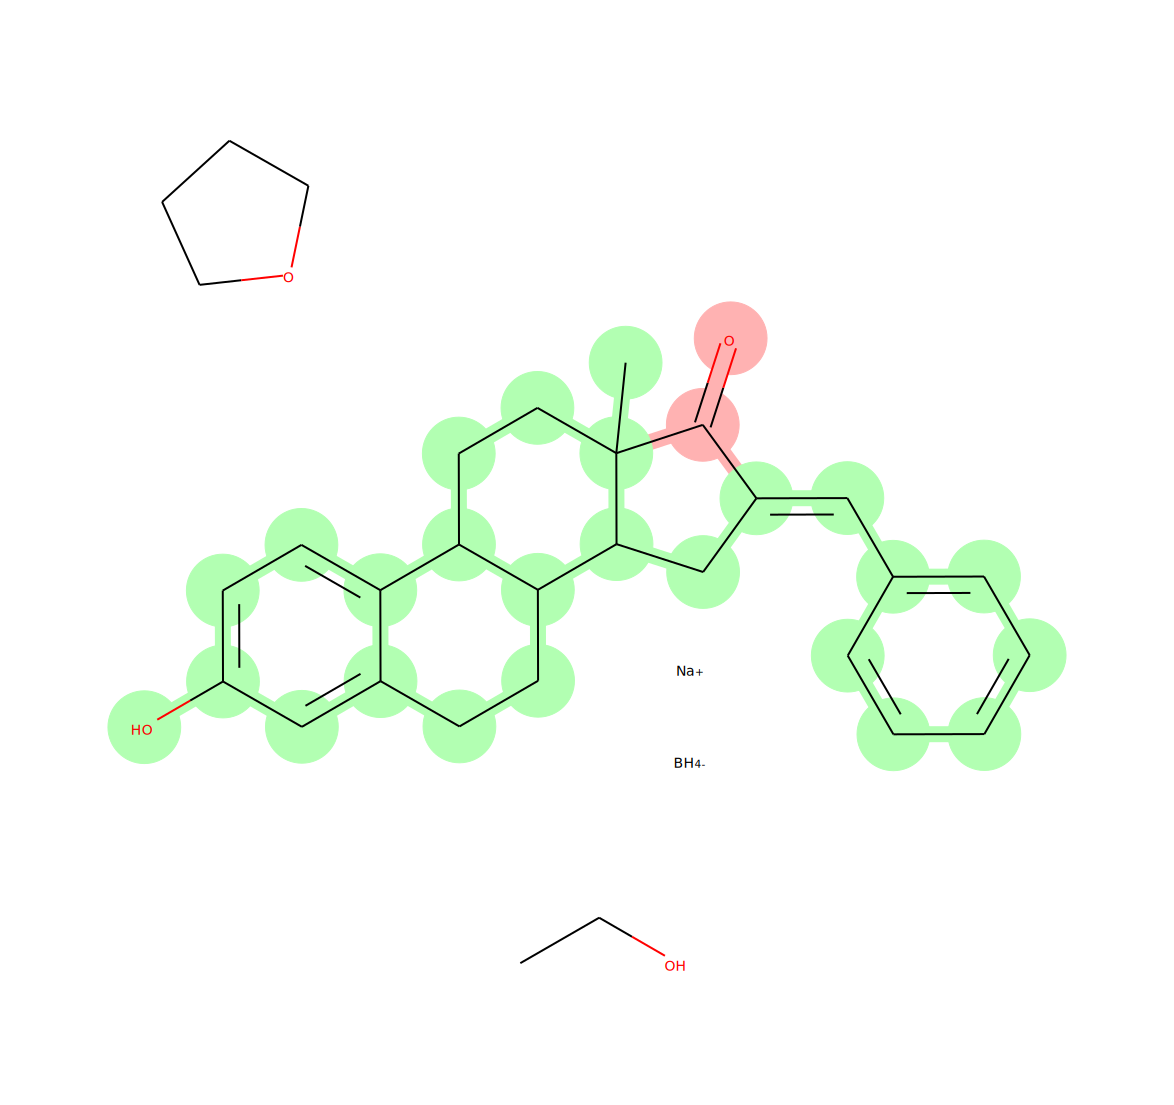

7487
0.21050423


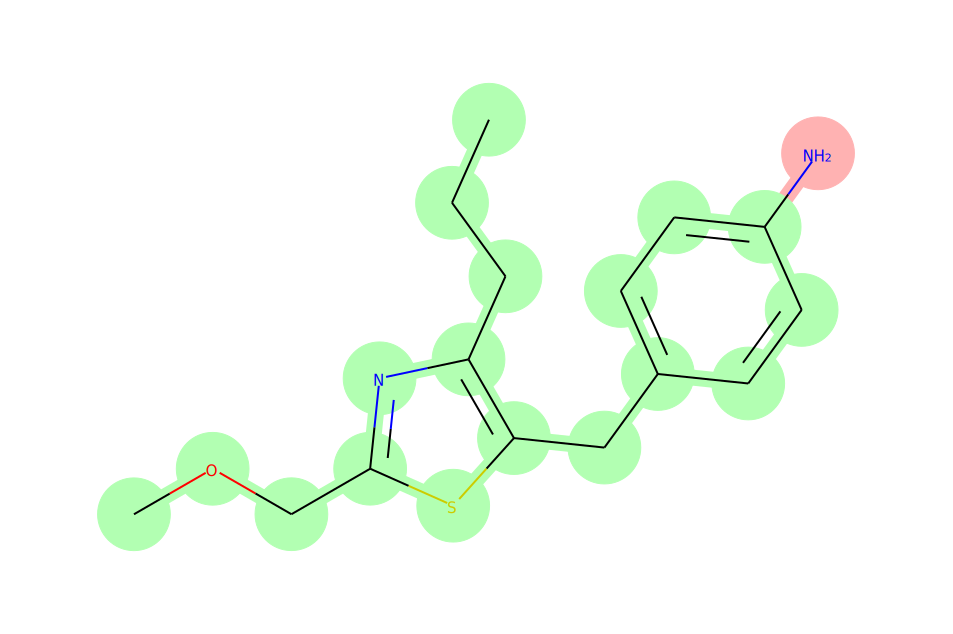

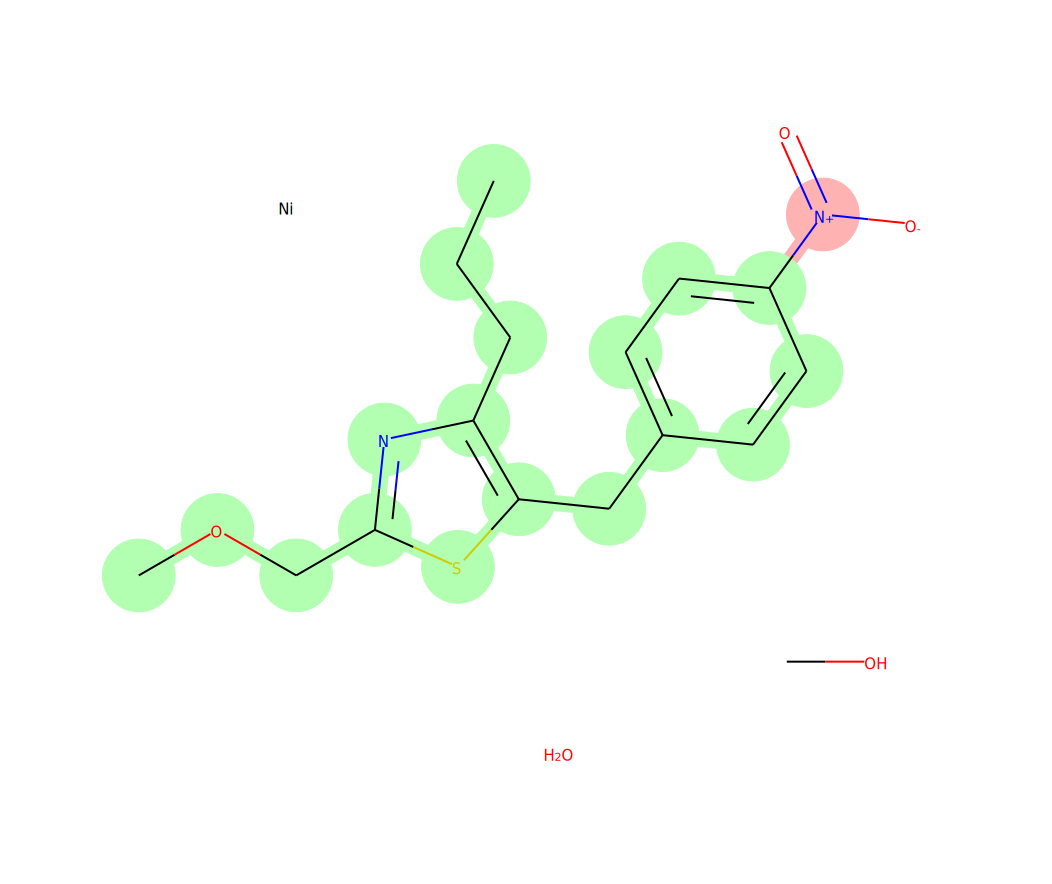

1803
1.5251971


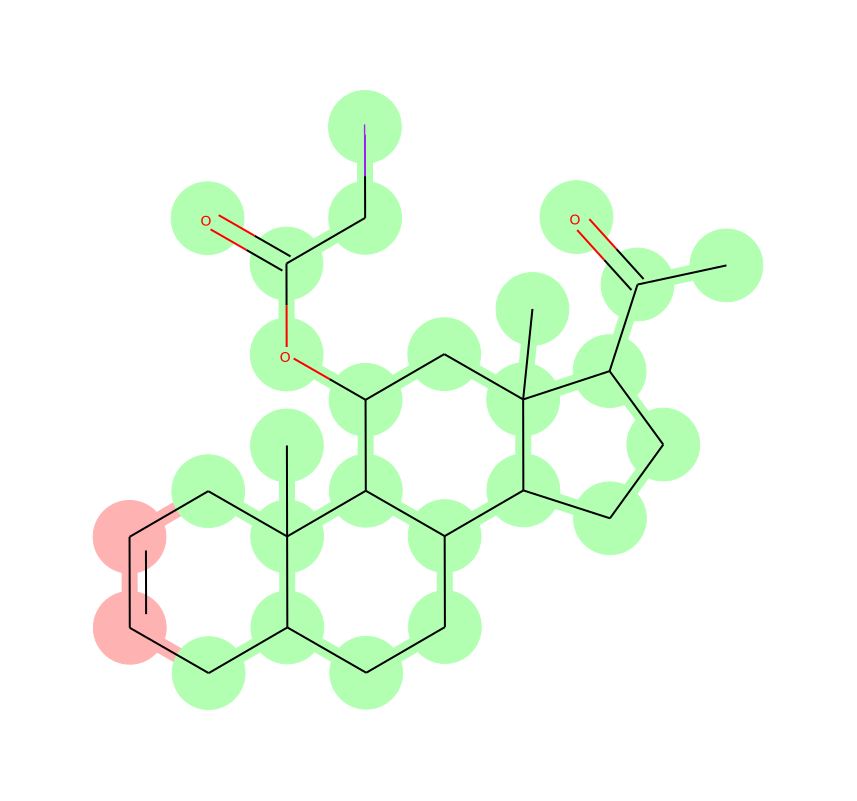

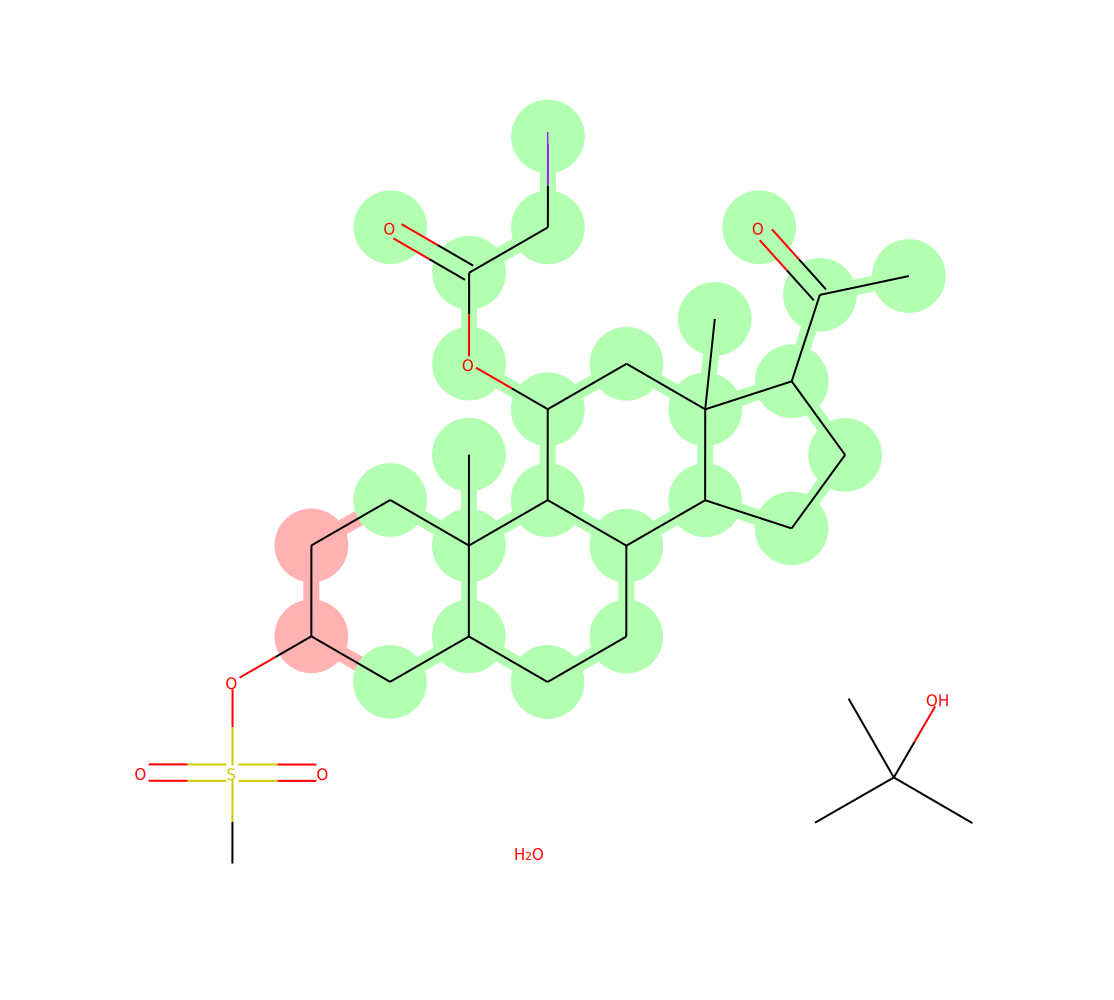

New center
13717
0.067619585


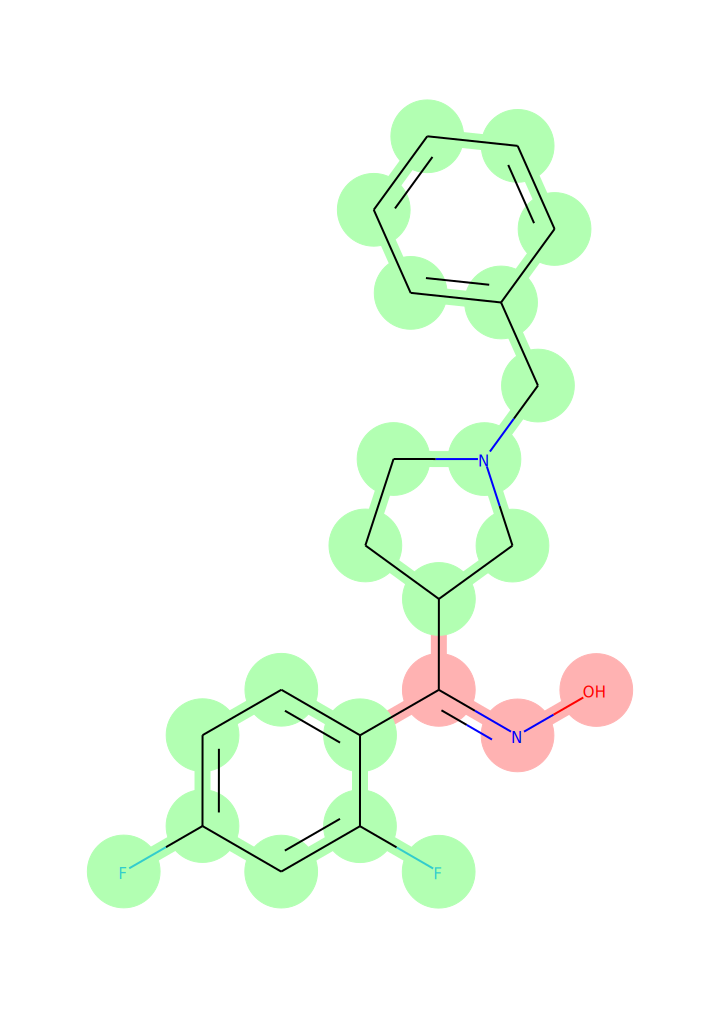

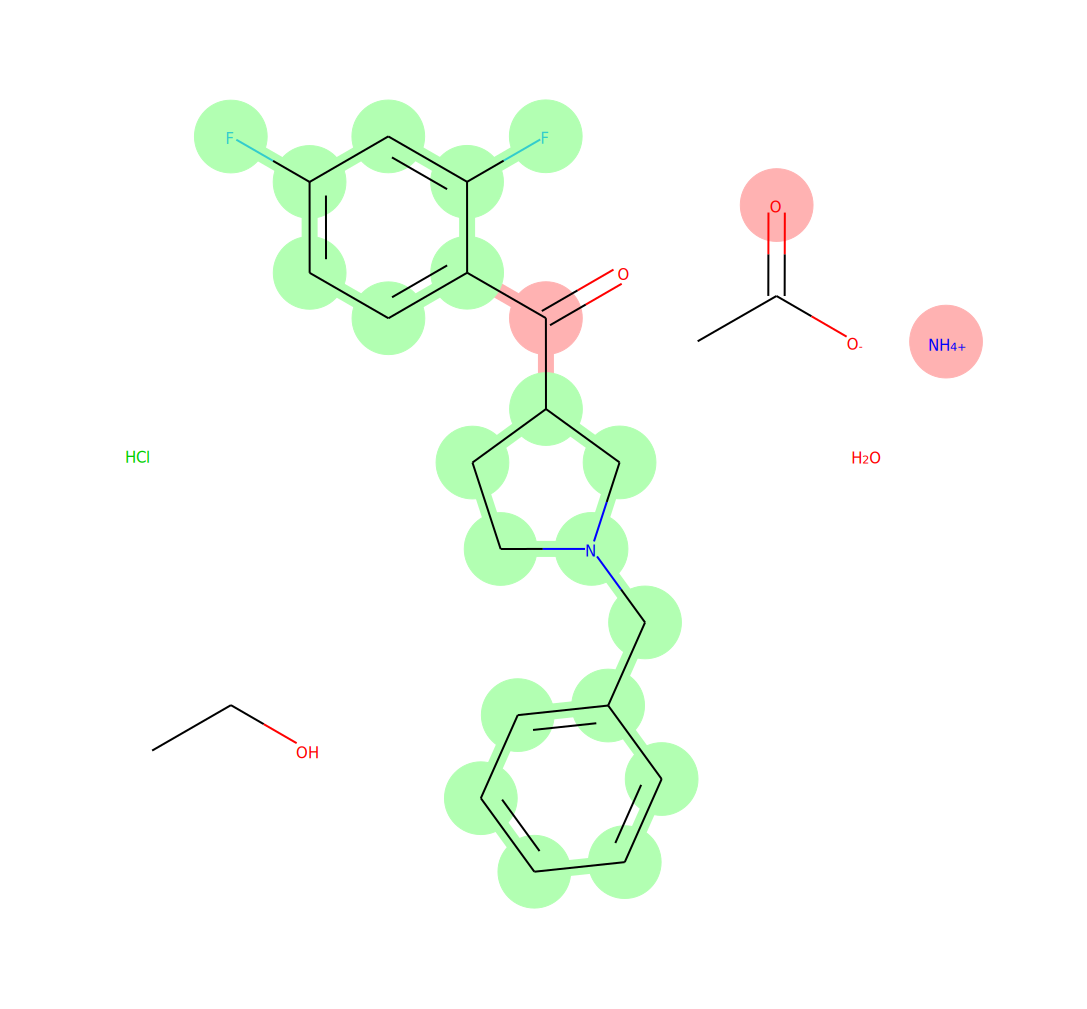

1940
0.06895404


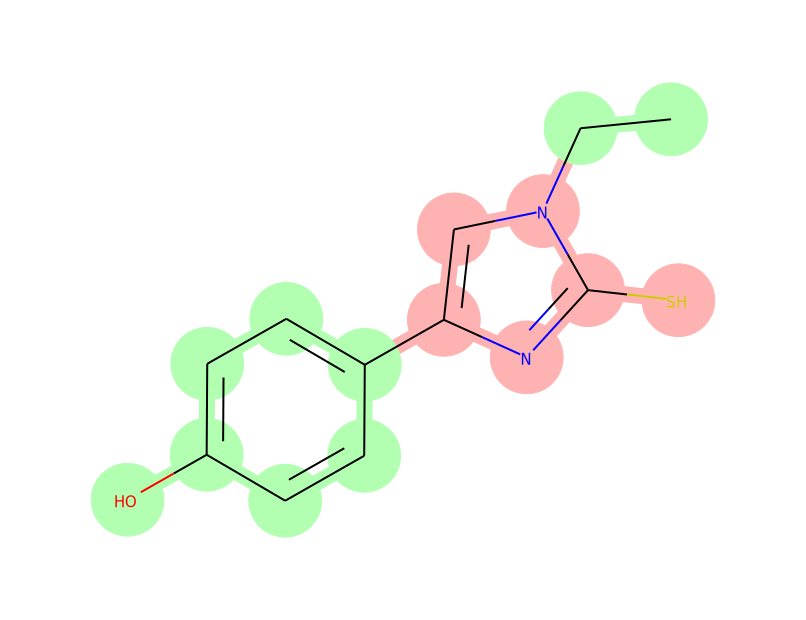

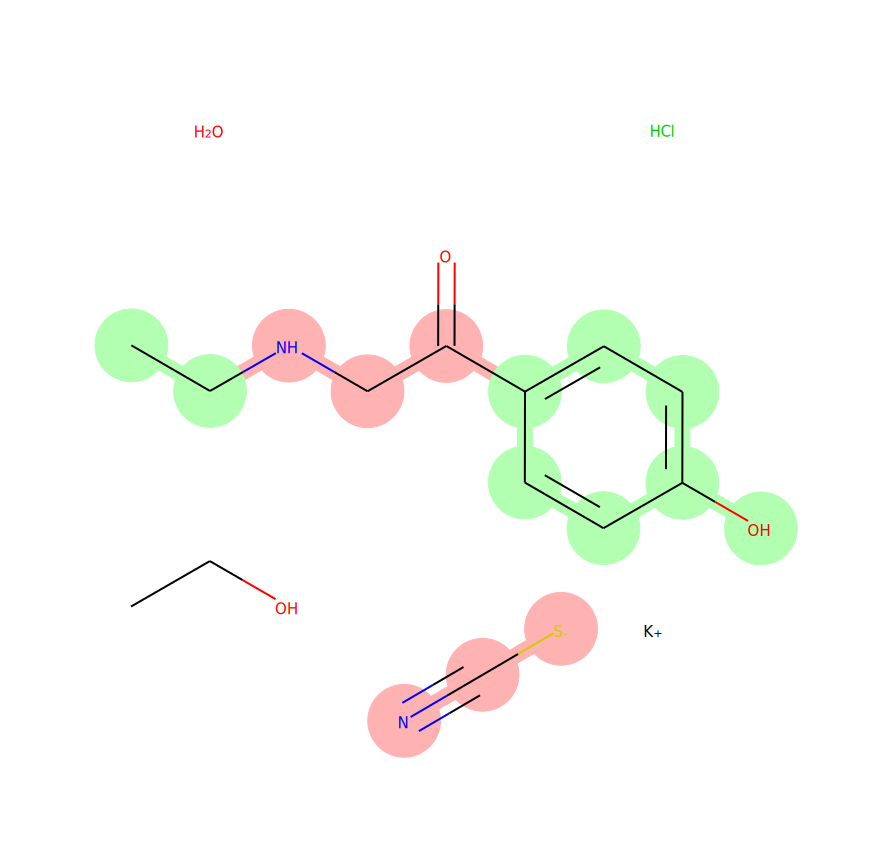

6310
0.07458288


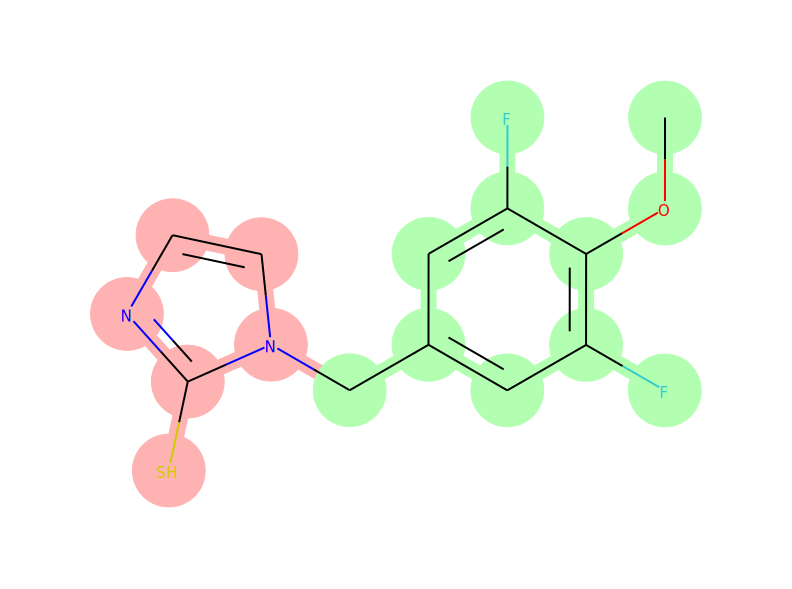

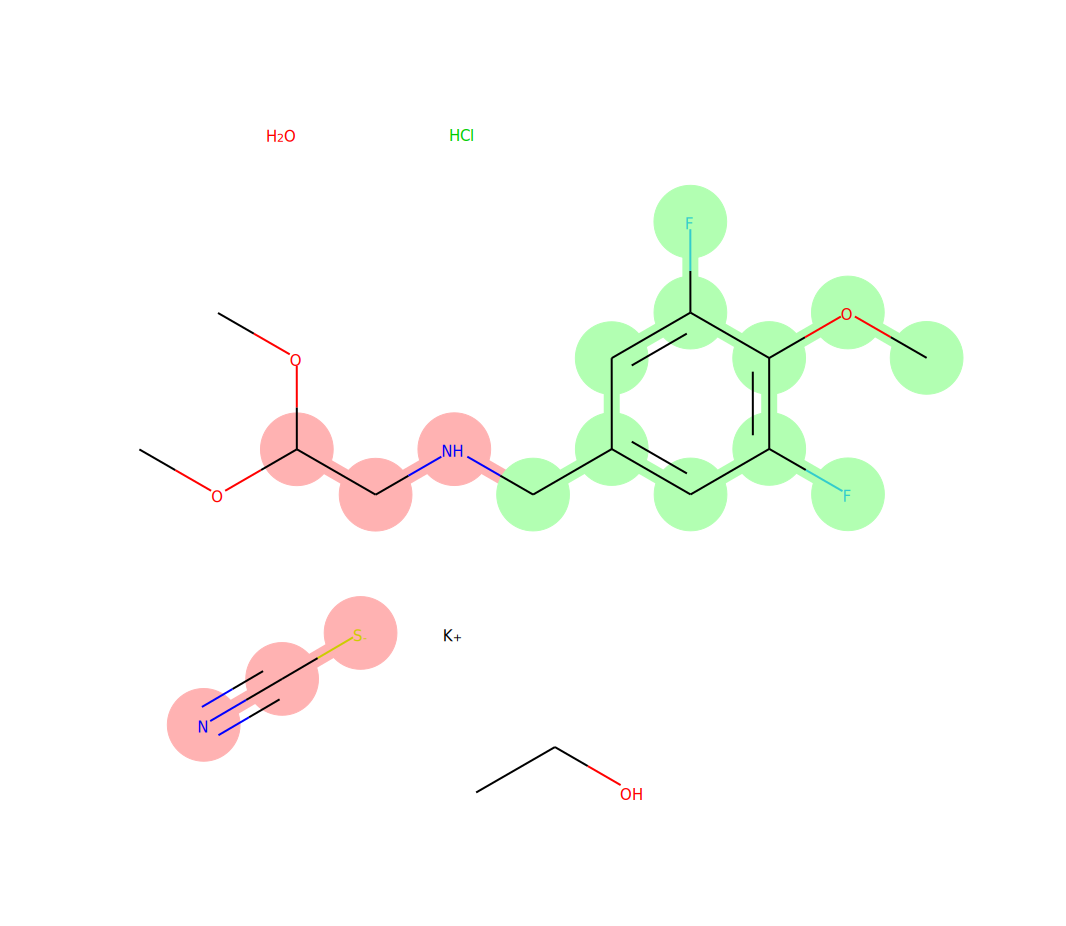

29522
0.15069088


RDKit WARNING: [13:32:28] WARNING: not removing hydrogen atom without neighbors


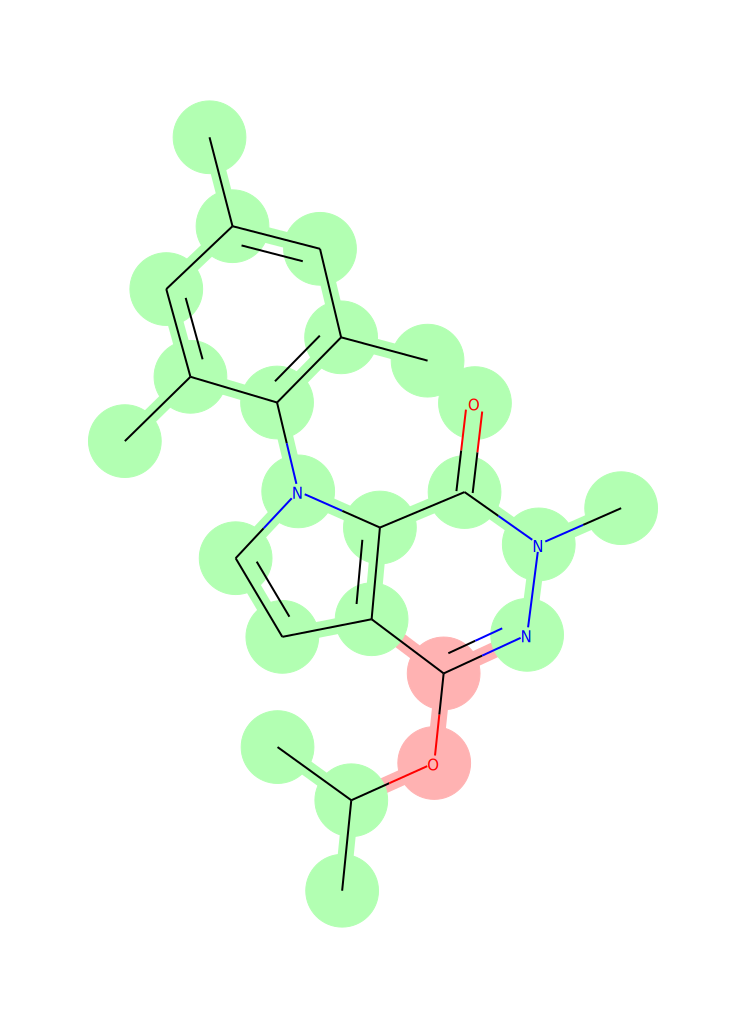

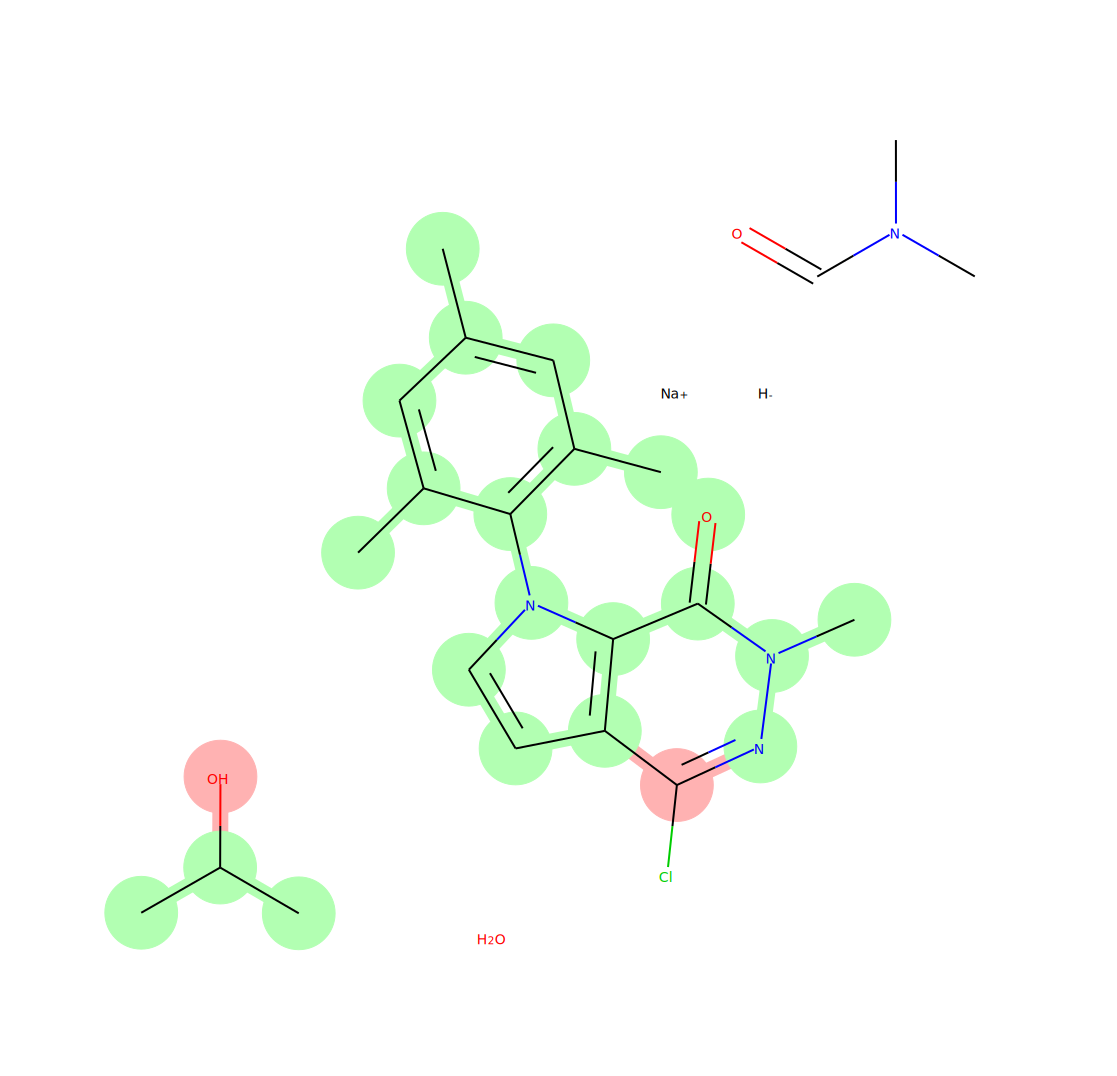

45464
1.0585588


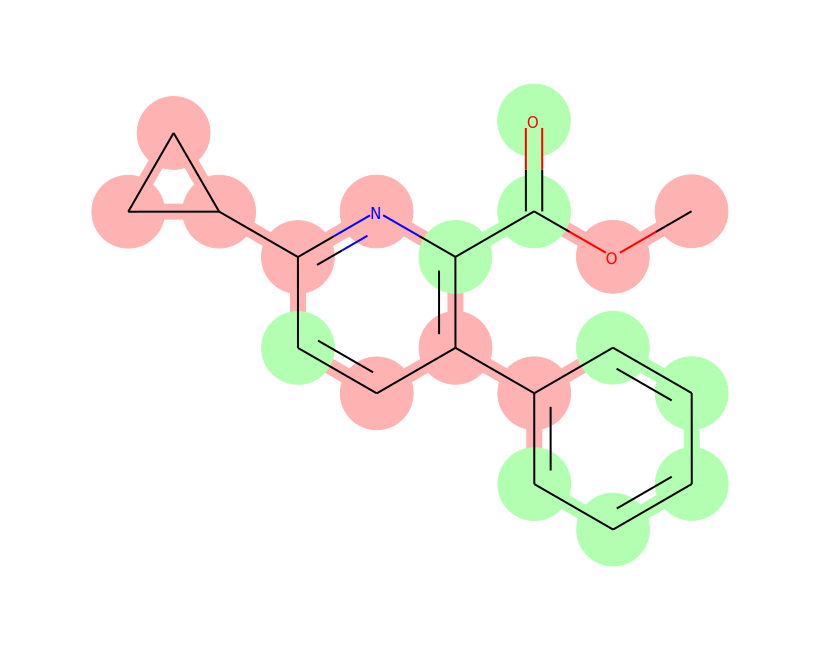

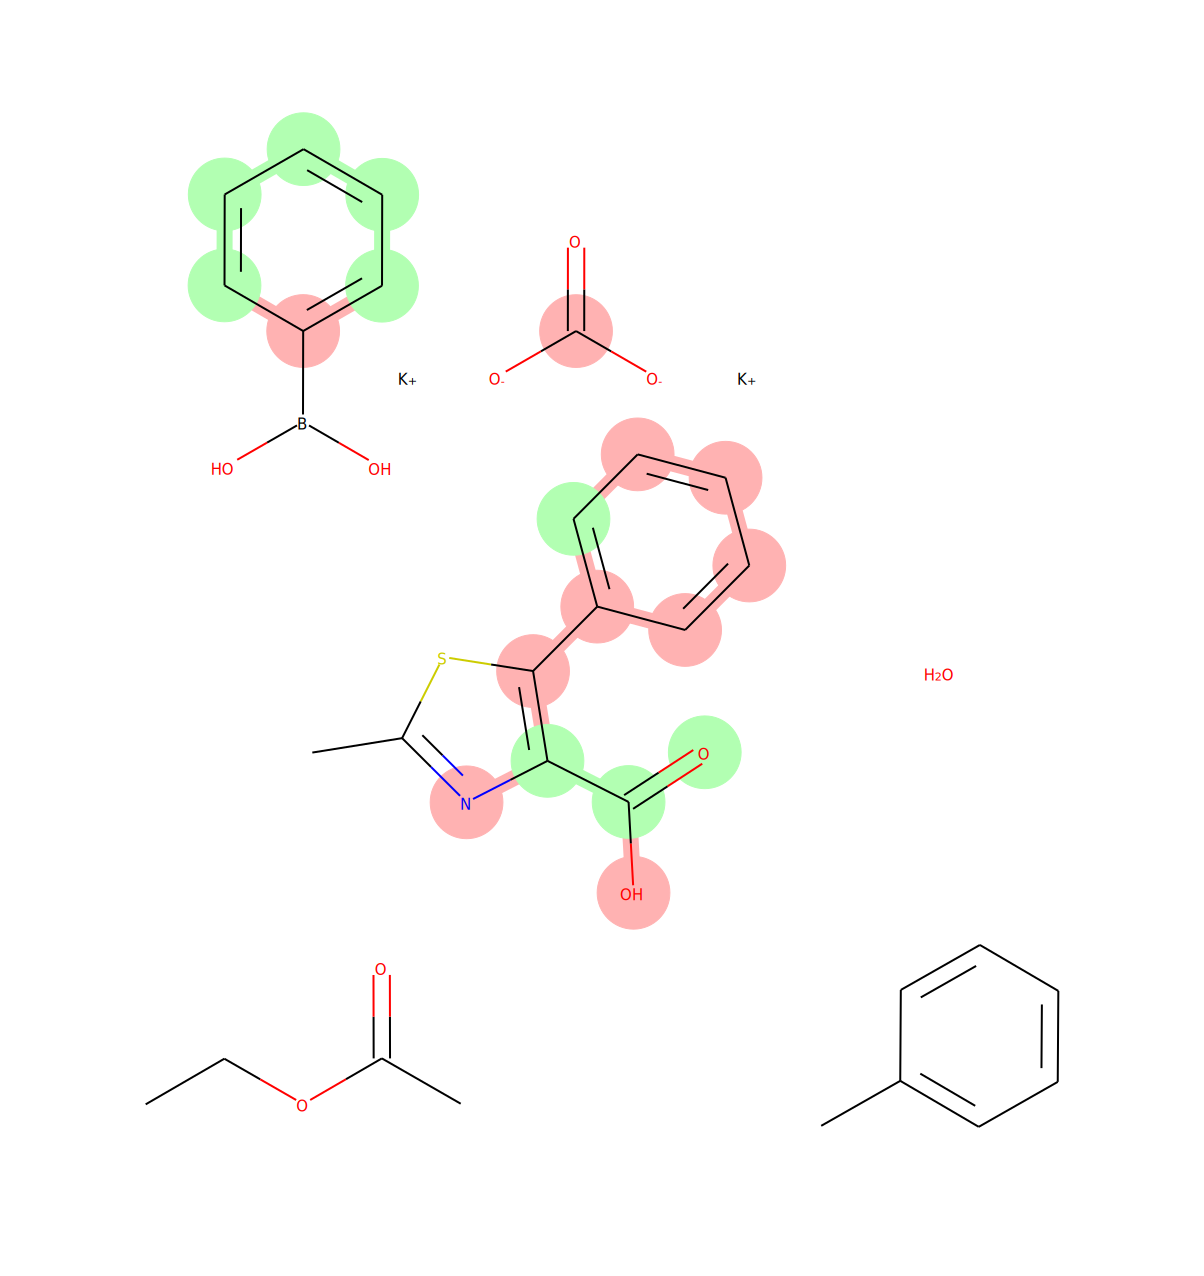

New center
3919
0.111728325


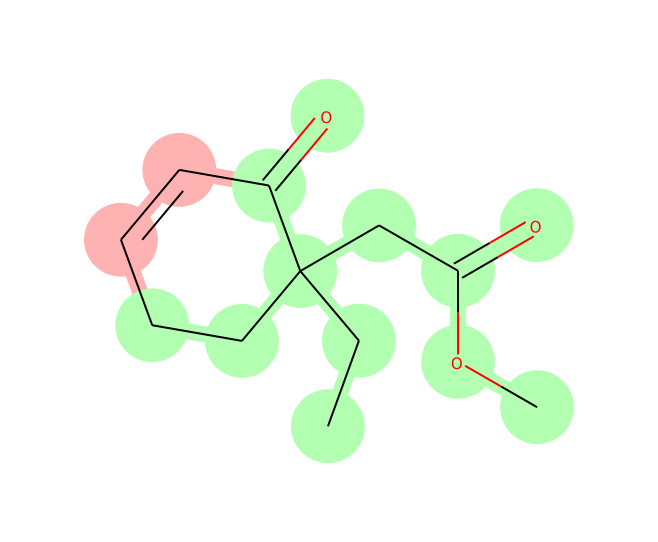

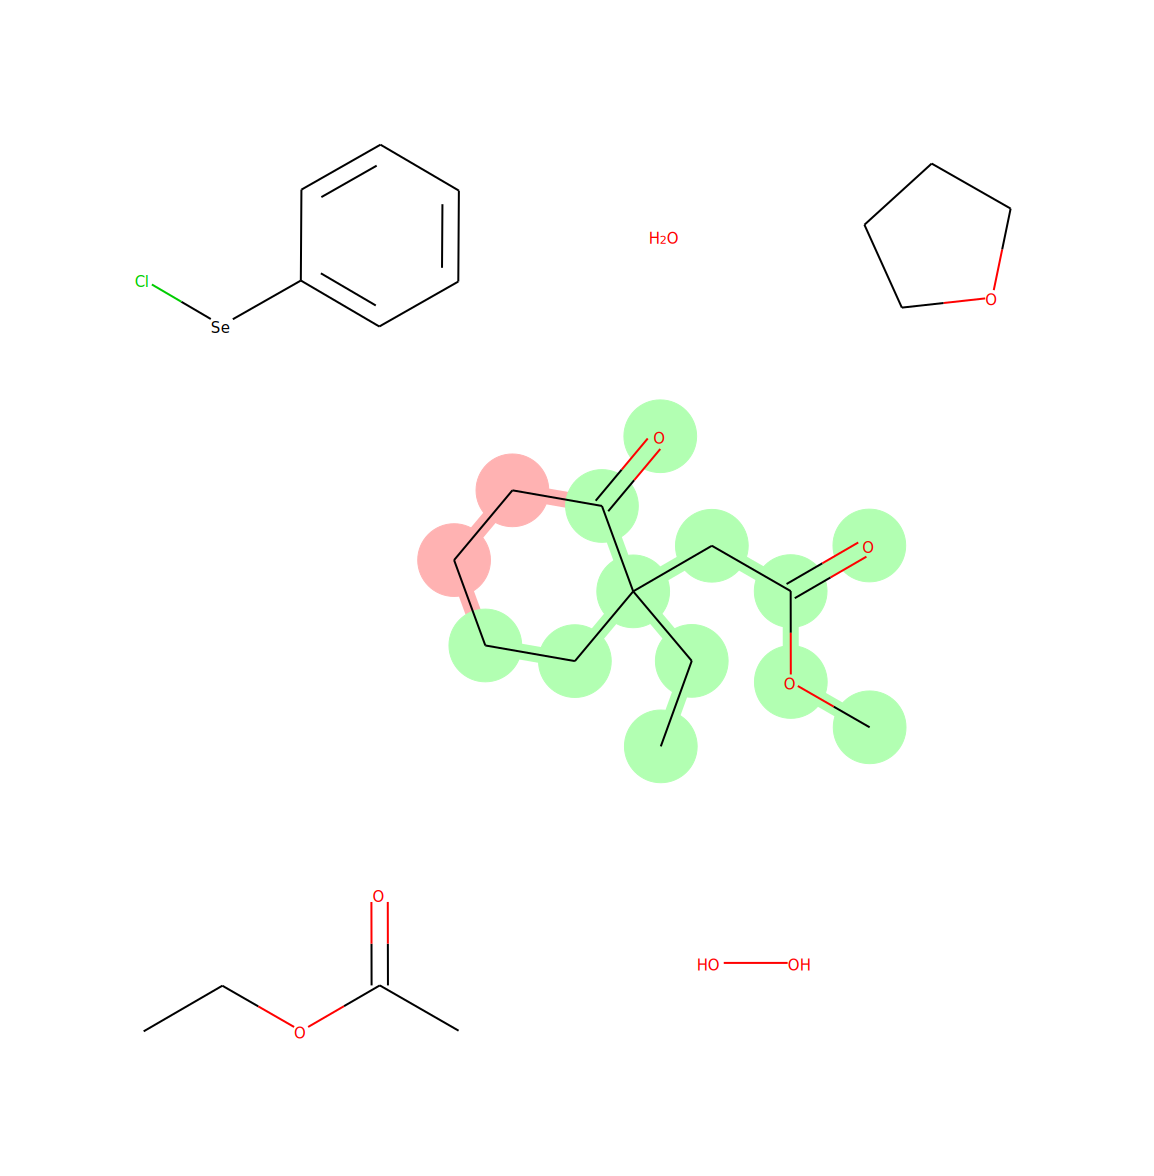

15206
0.11273242


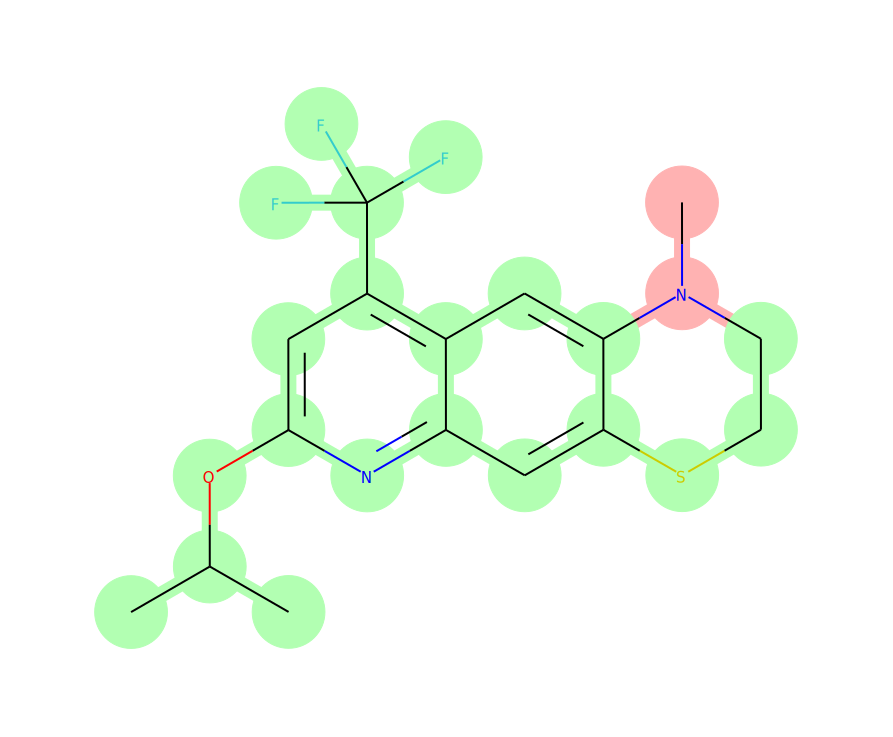

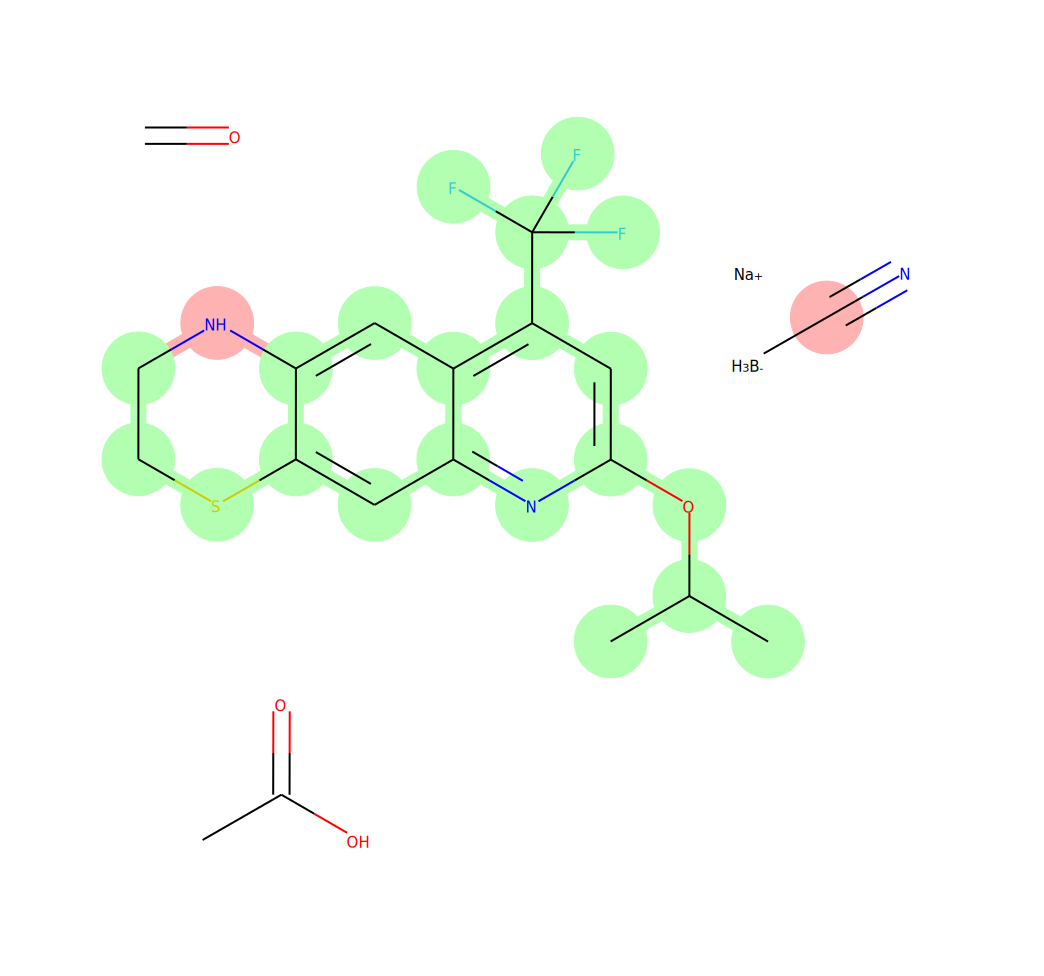

17354
0.114104085


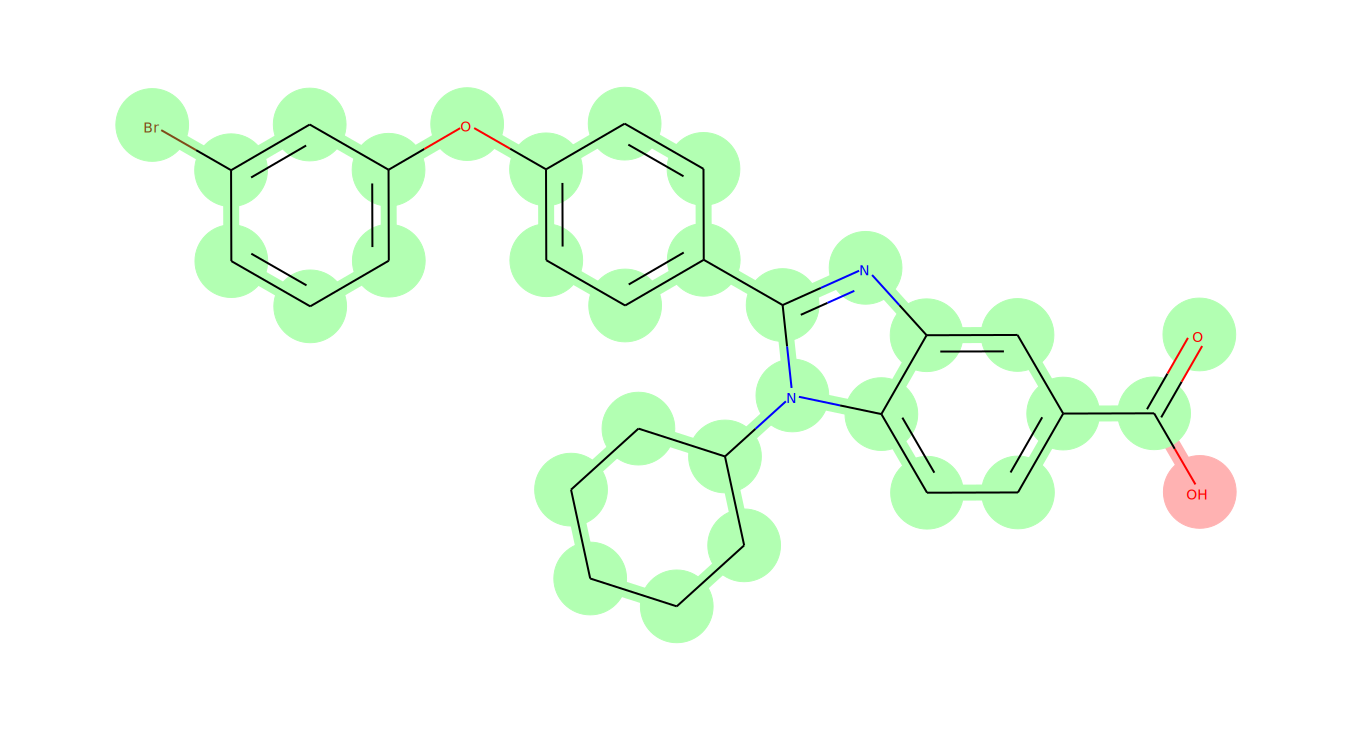

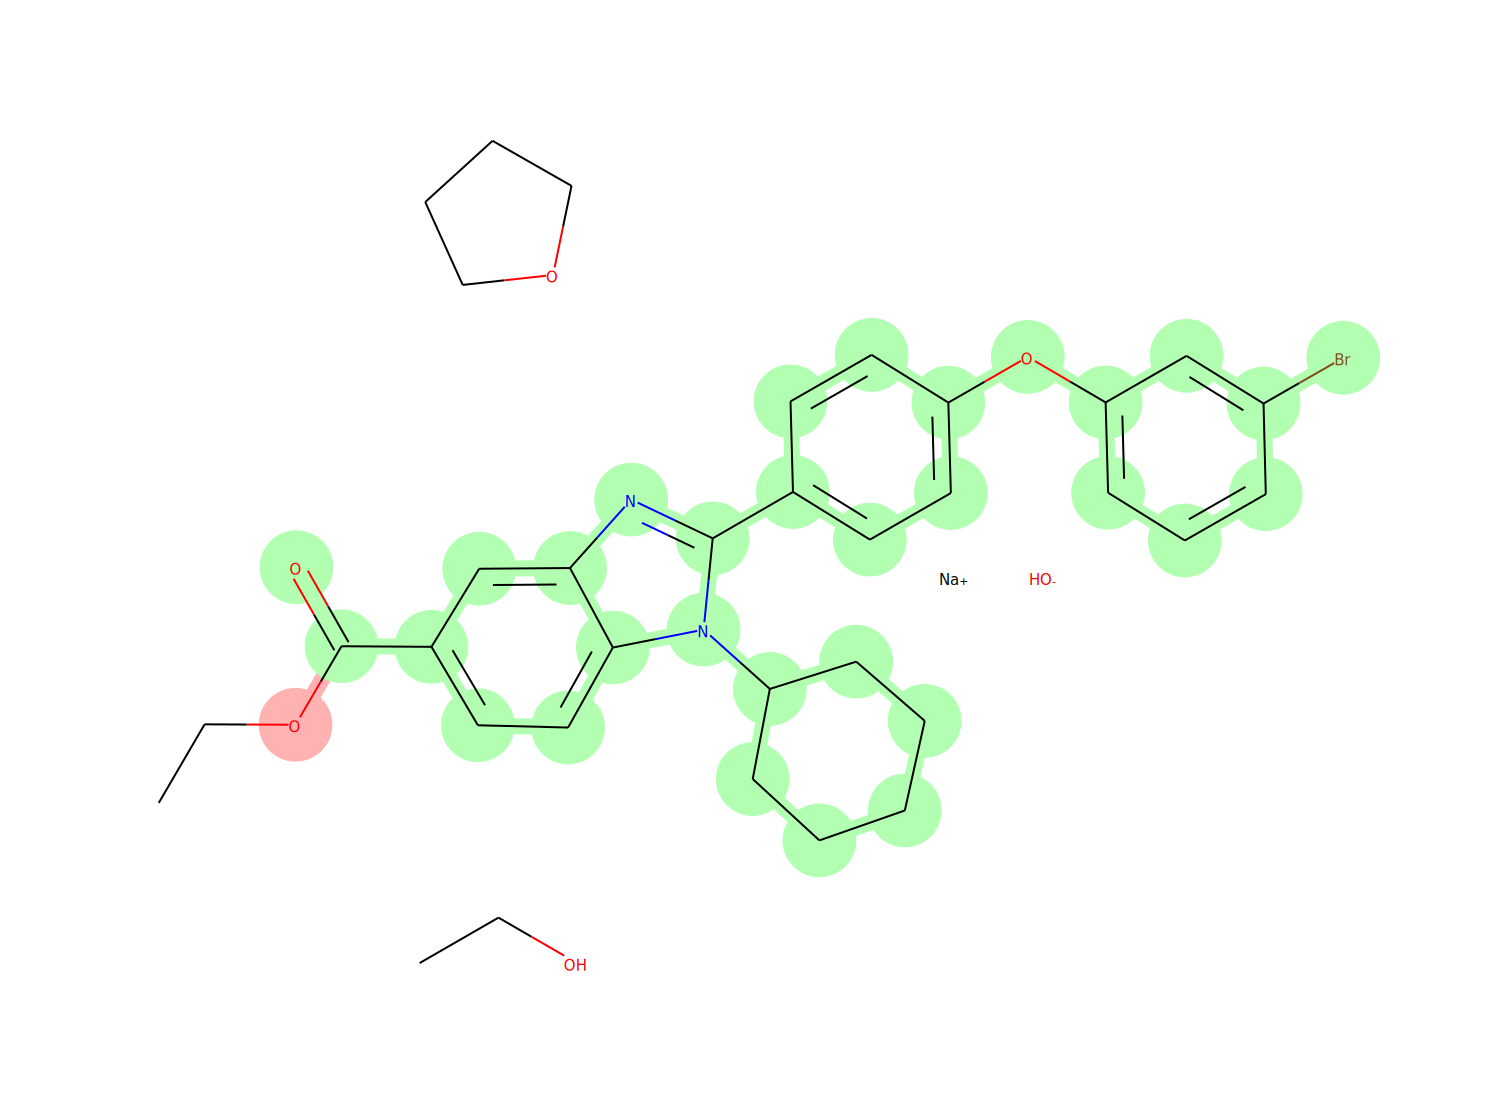

21184
0.15500873


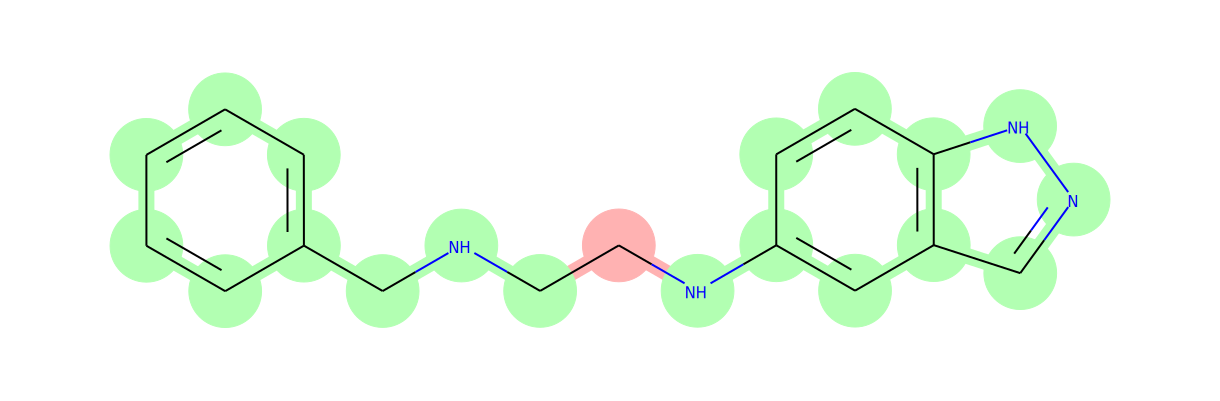

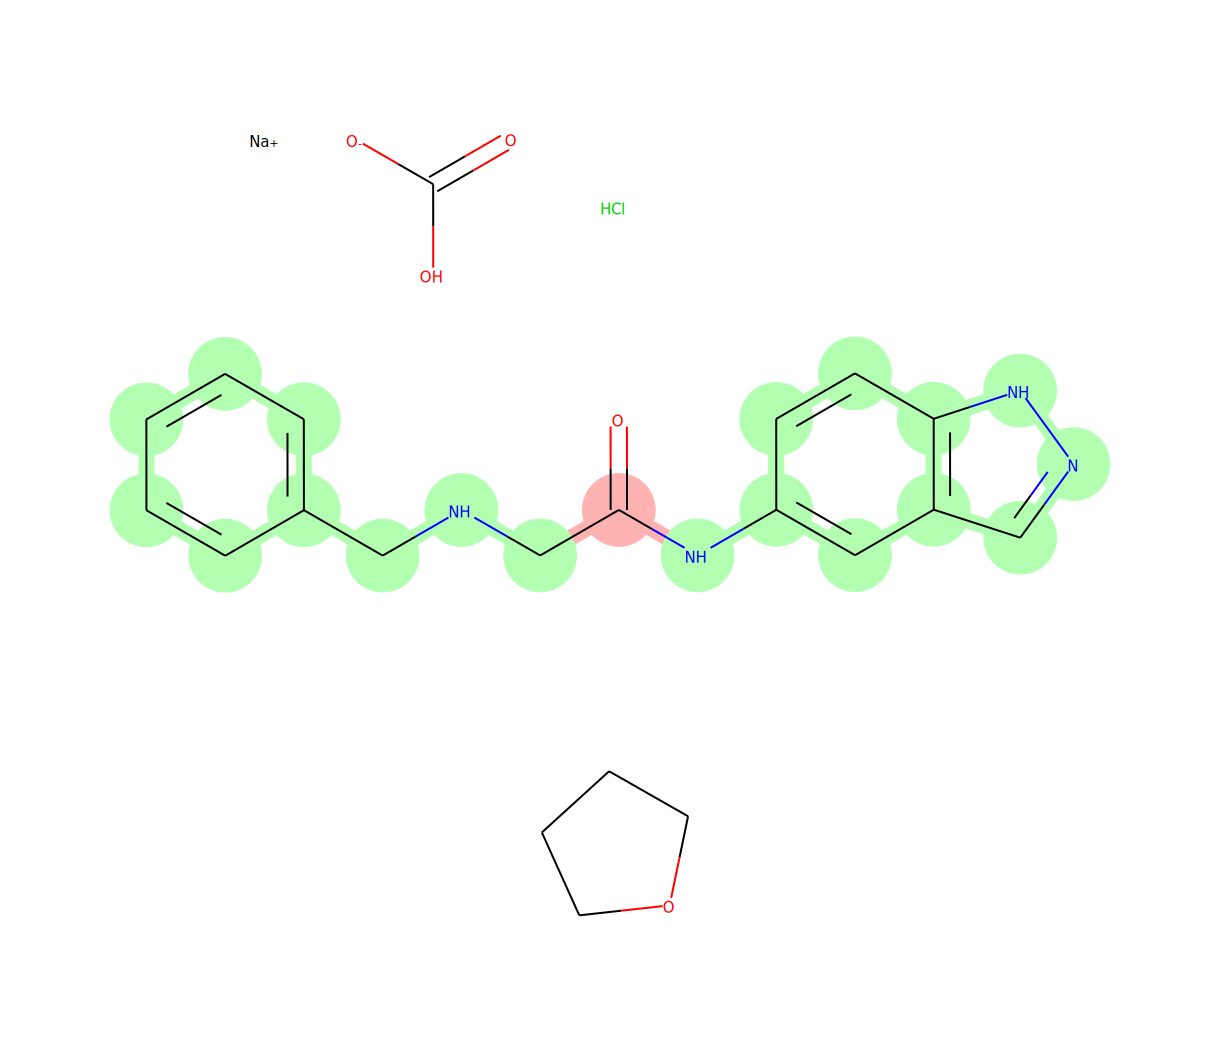

9323
0.8263456


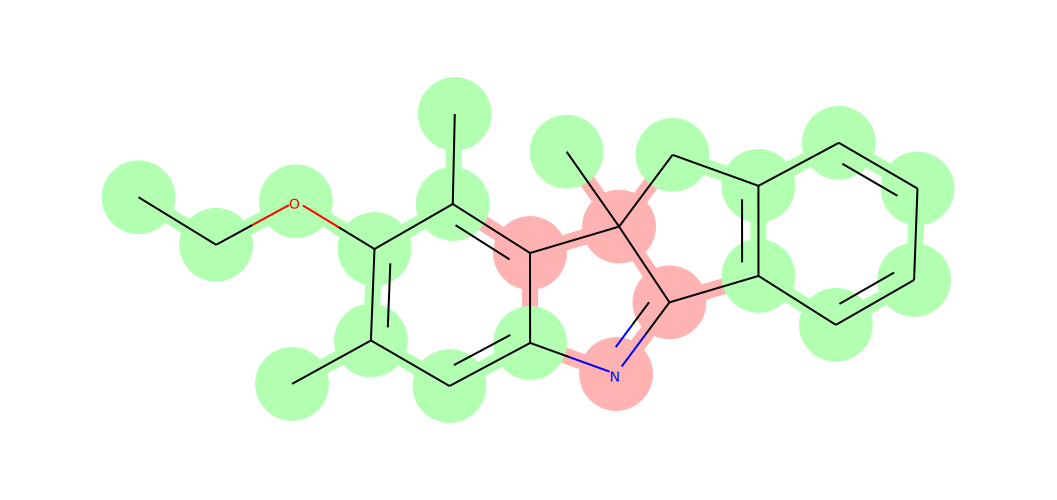

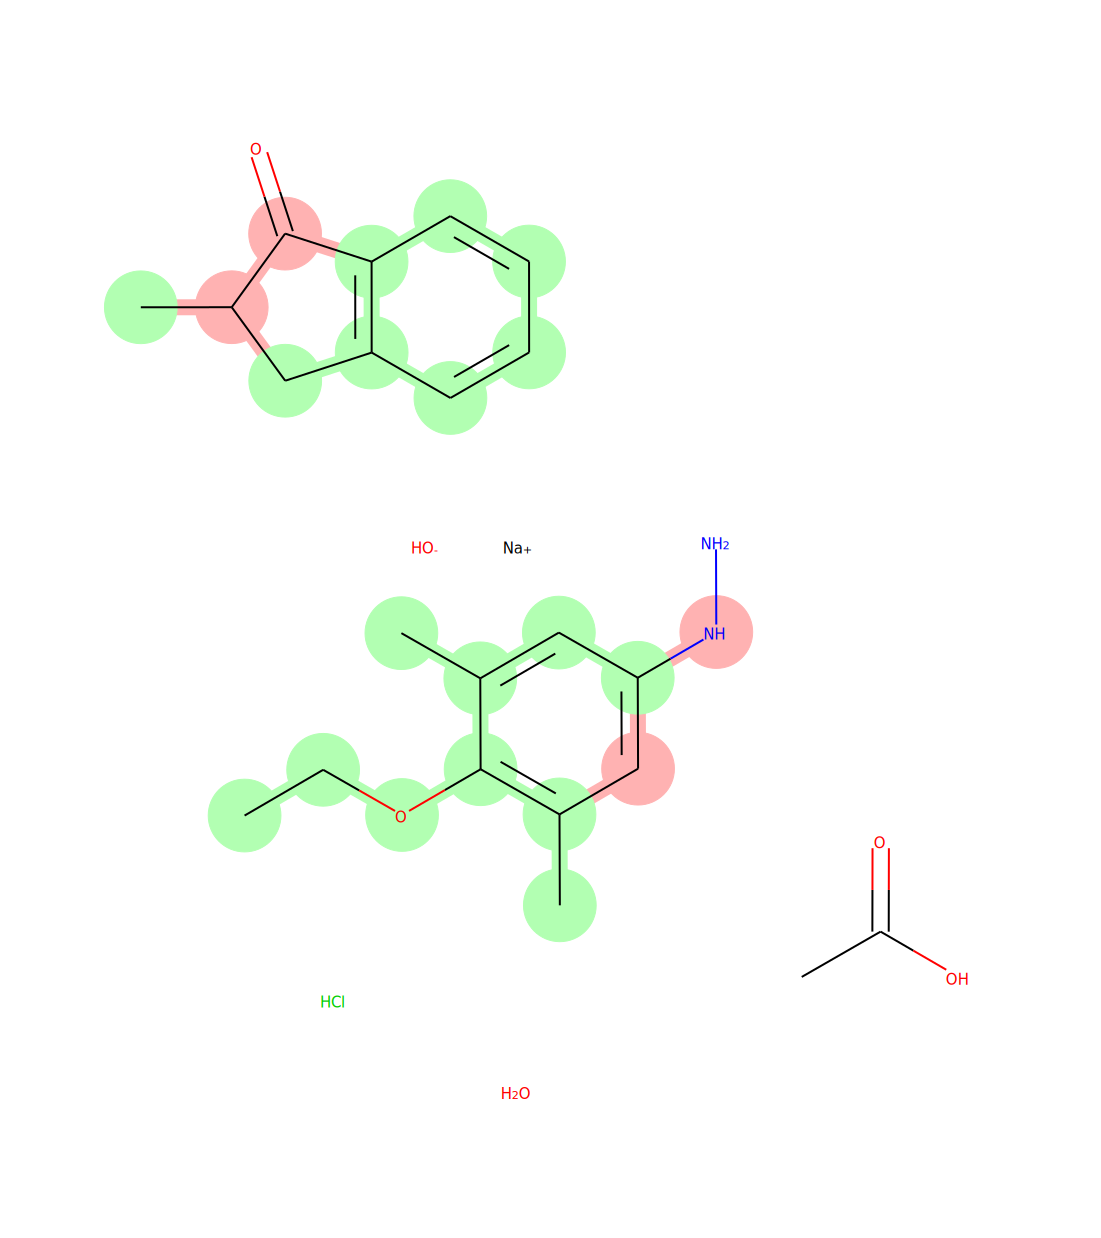

New center
27352
0.051819287


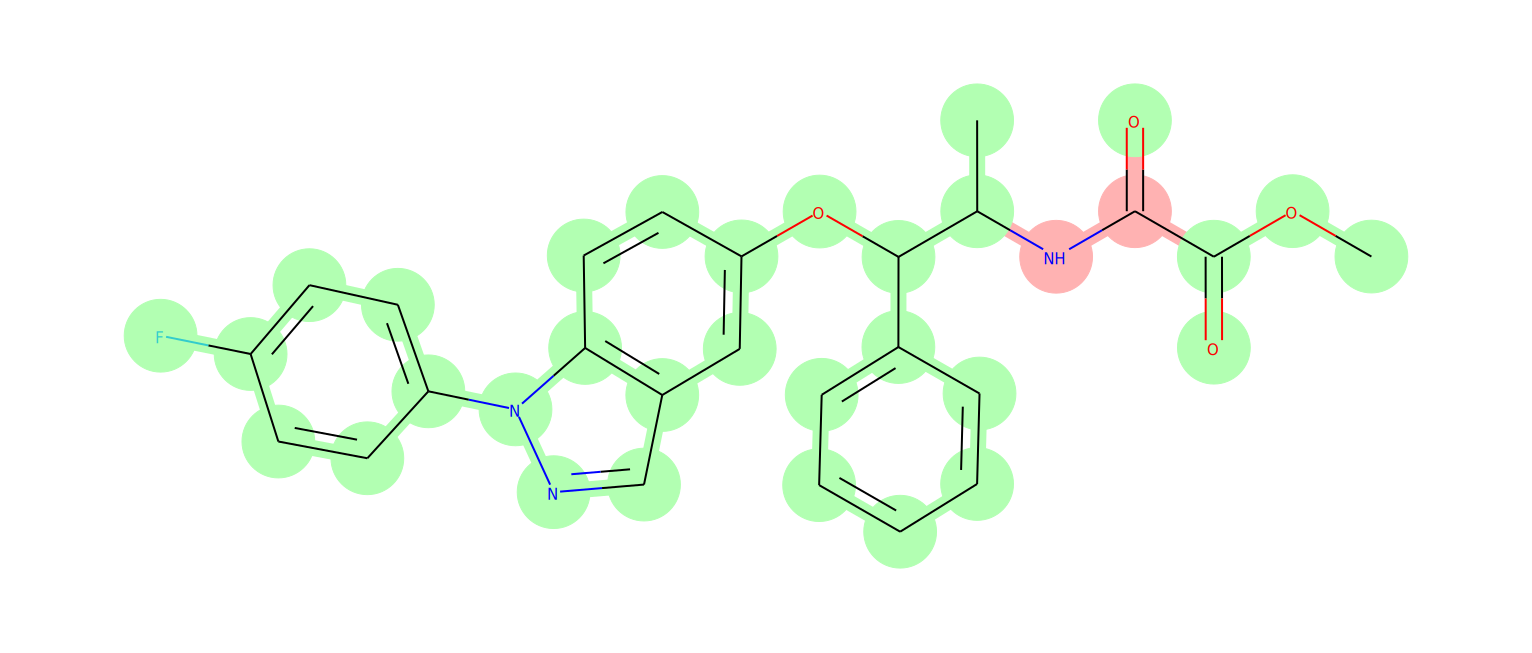

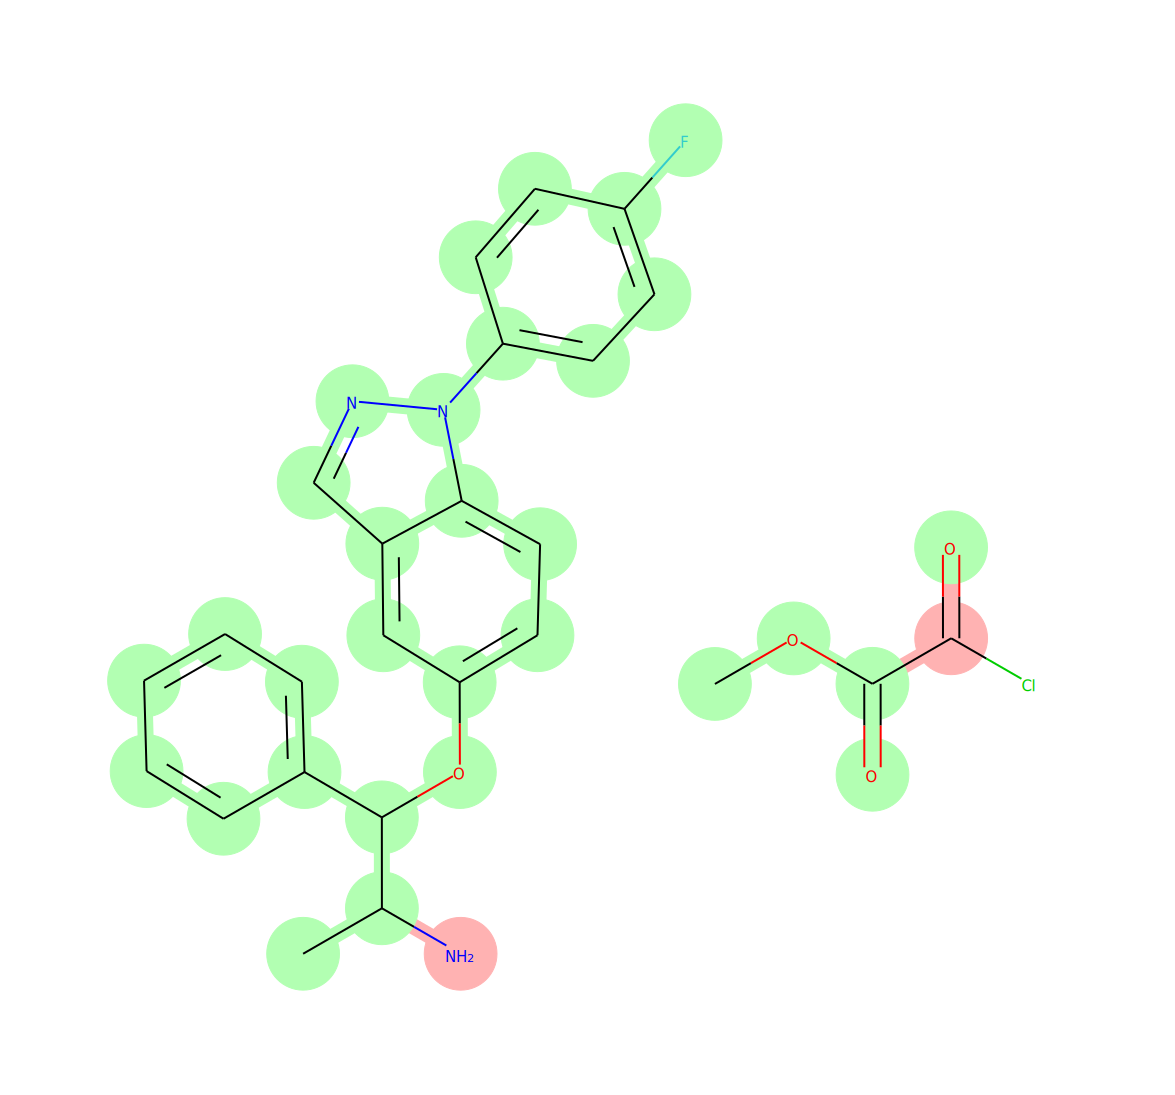

16851
0.05942282


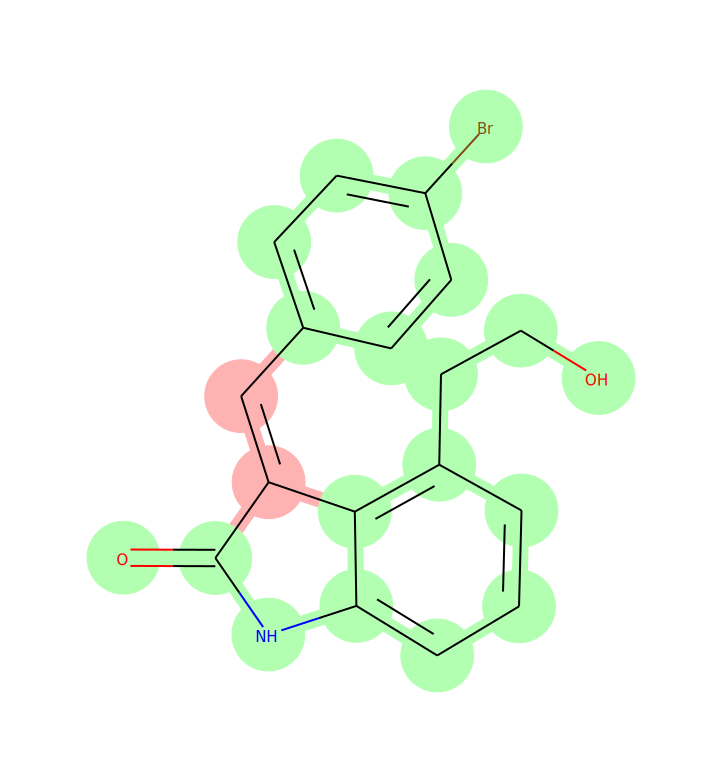

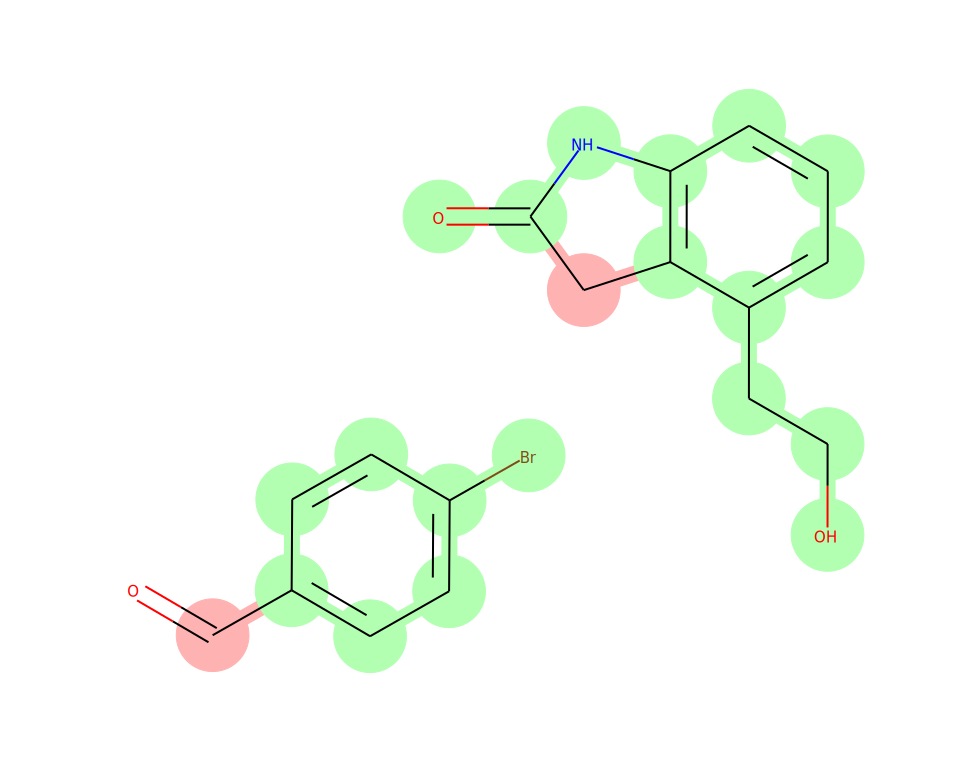

10700
0.06716305


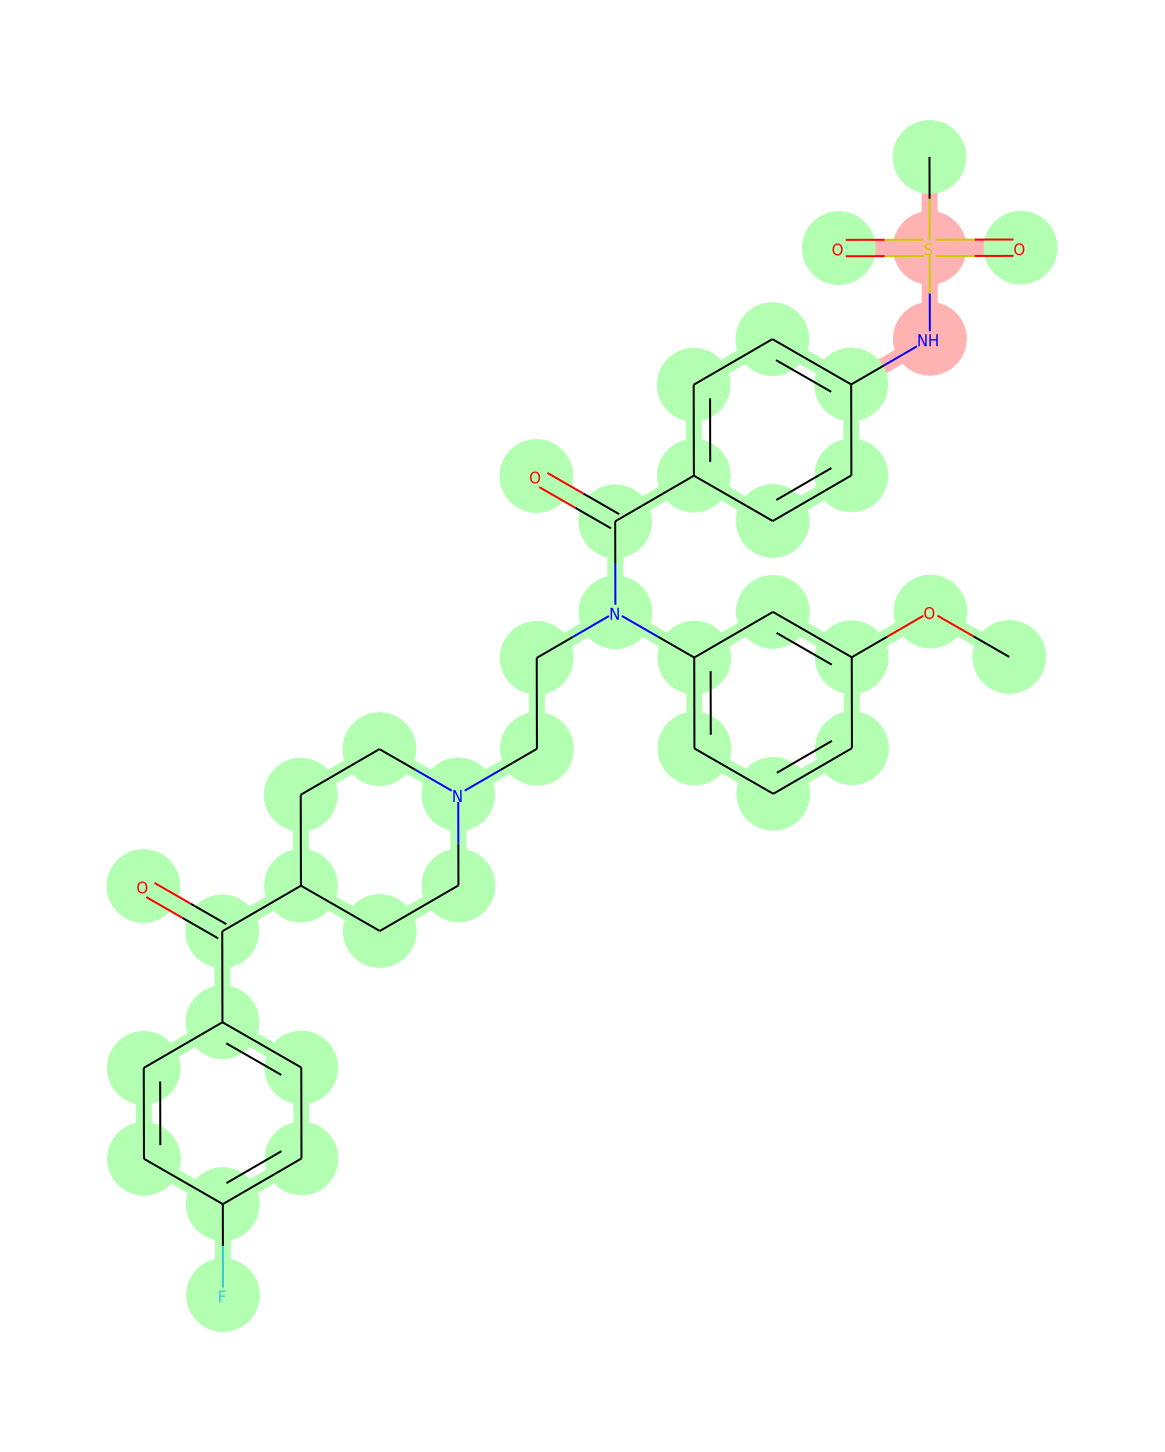

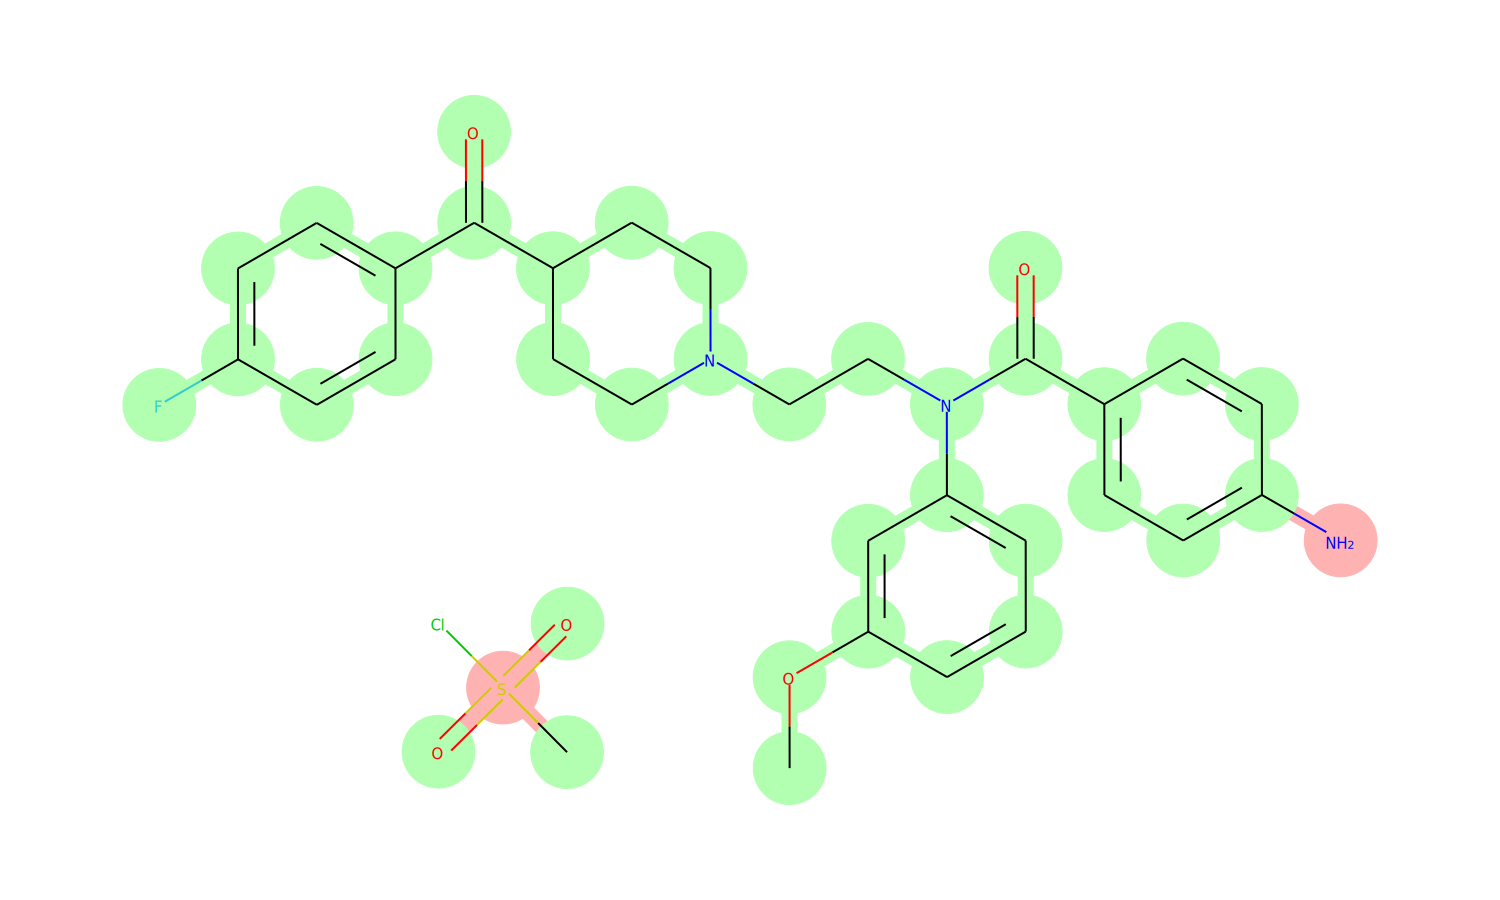

27982
0.10143497


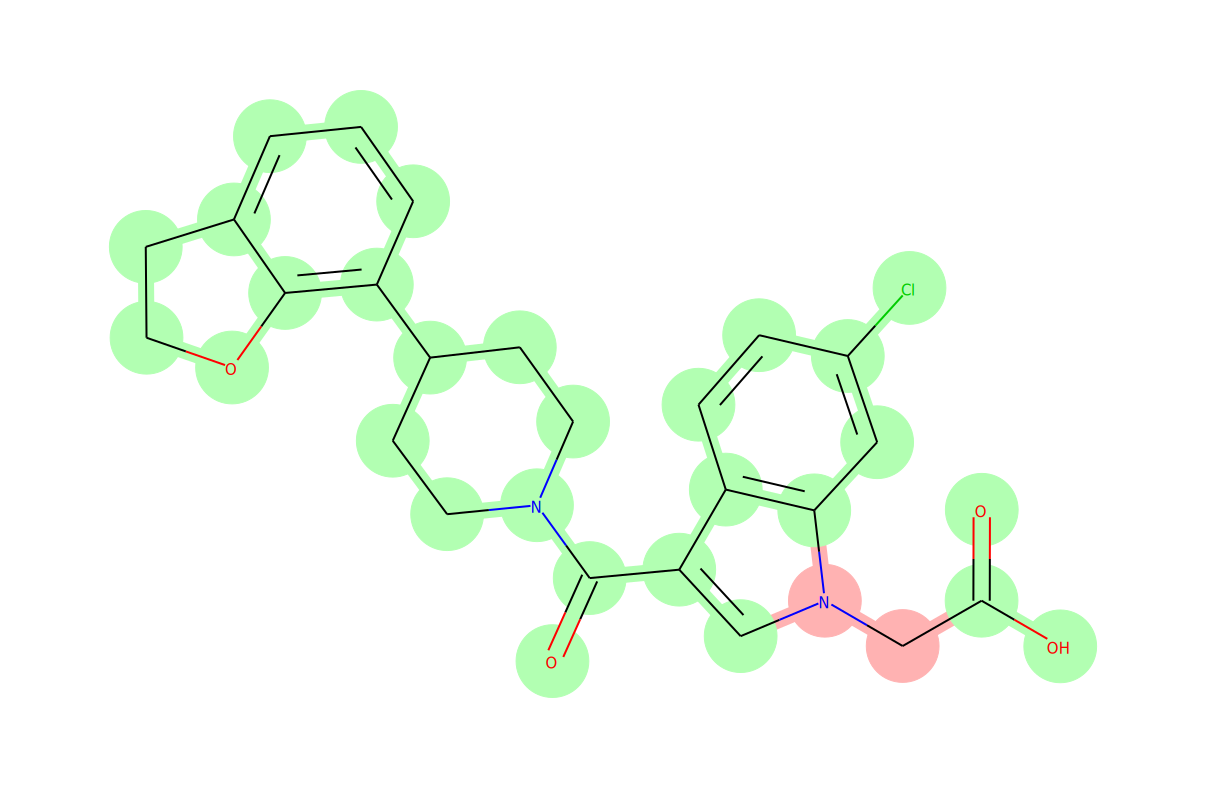

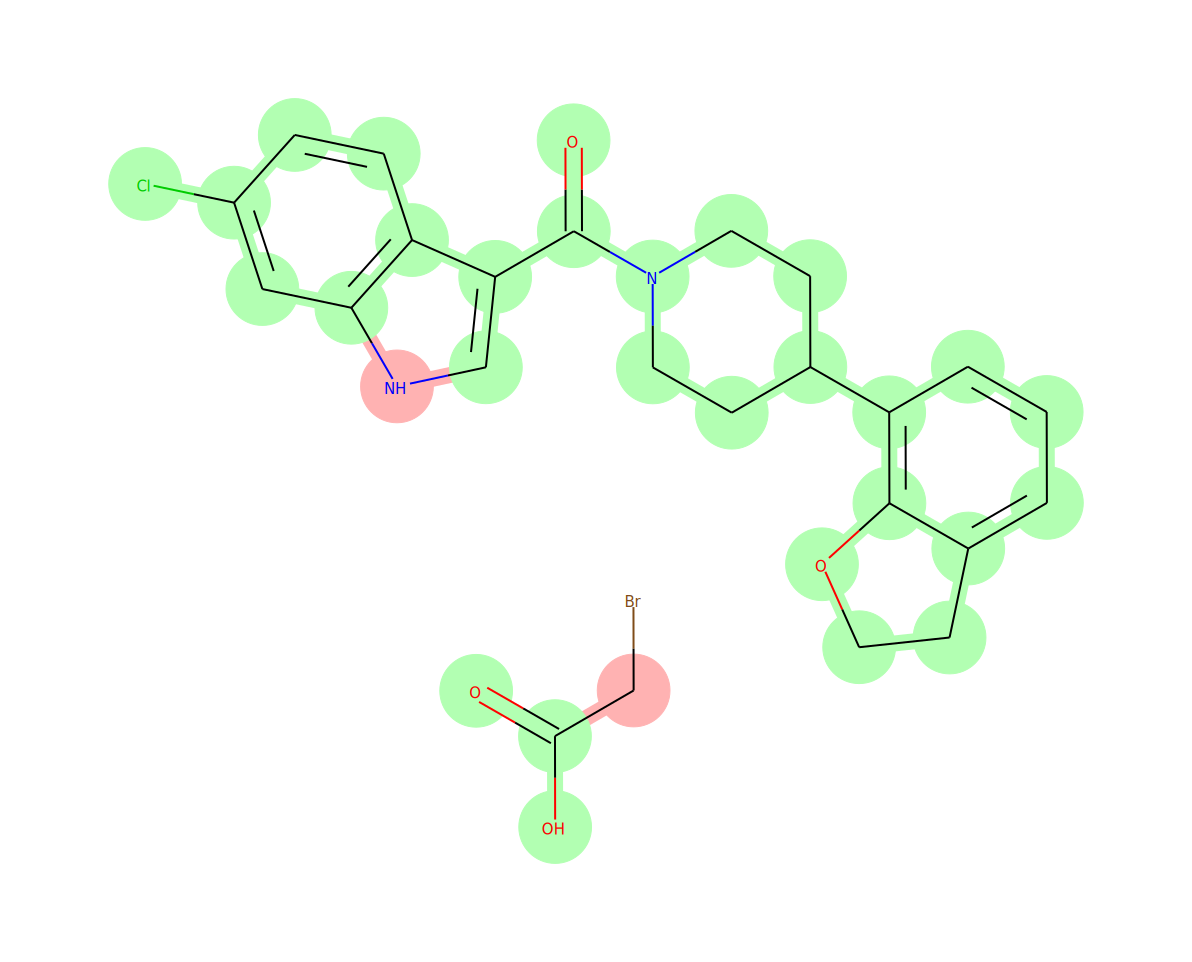

24709
1.3469263


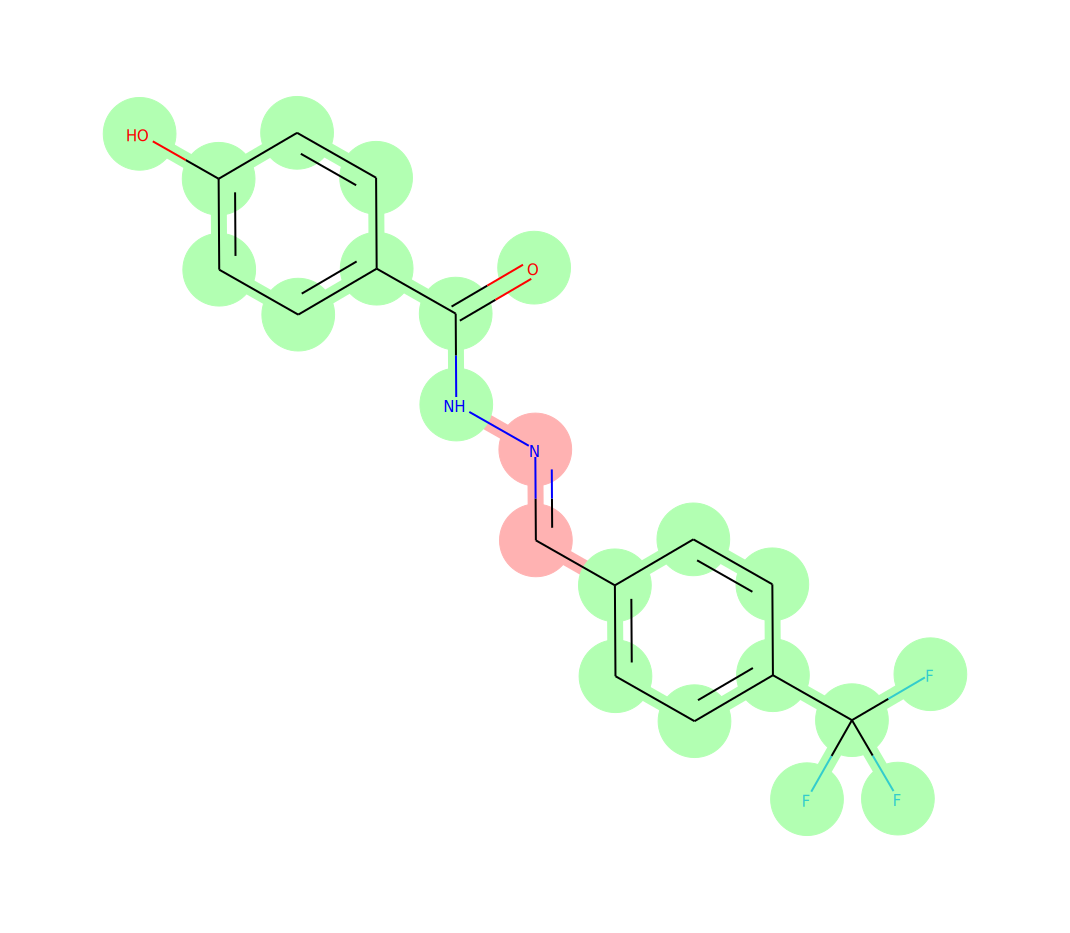

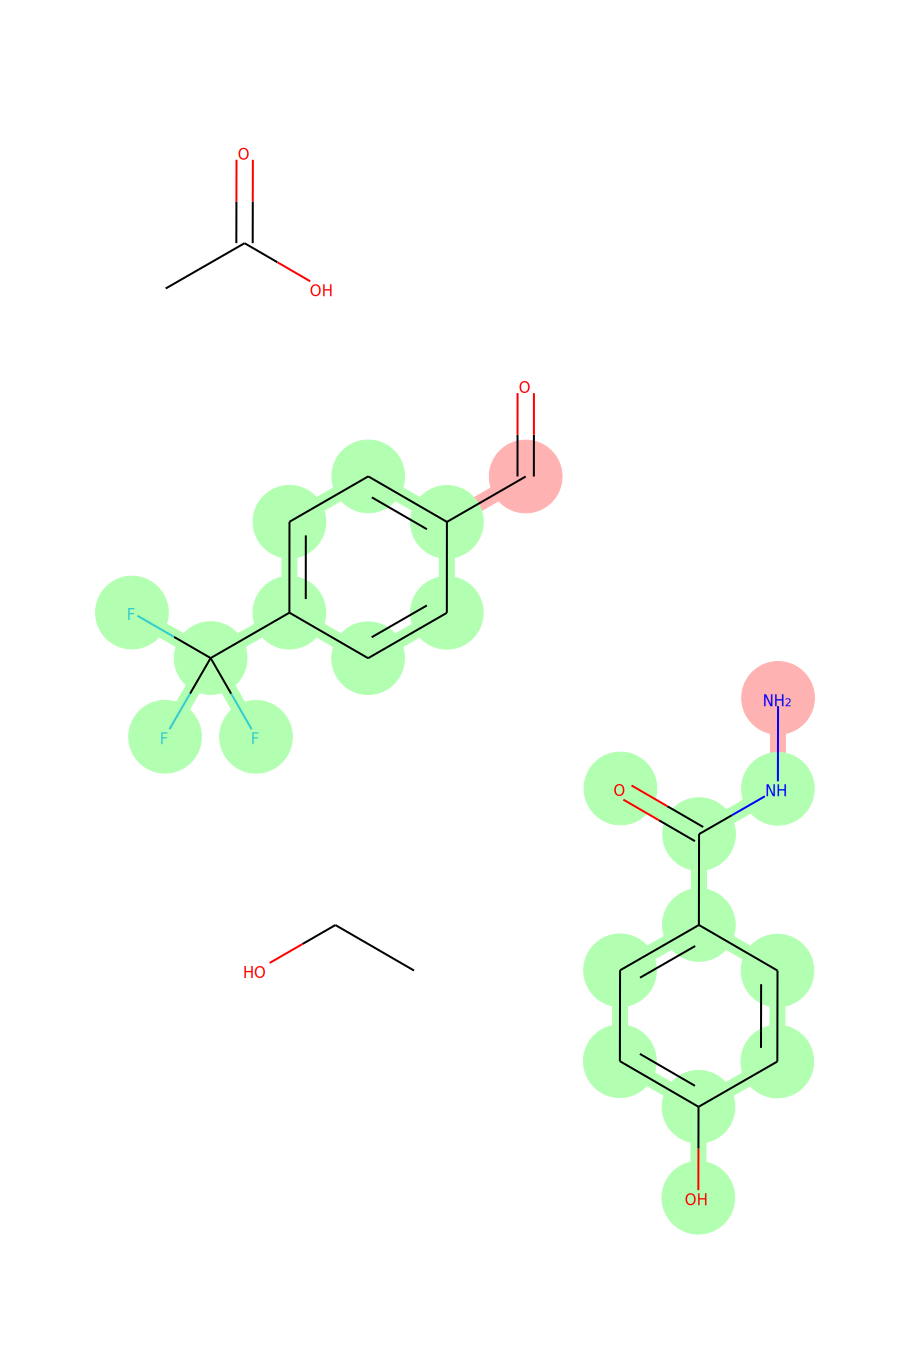

New center
3649
0.13162616


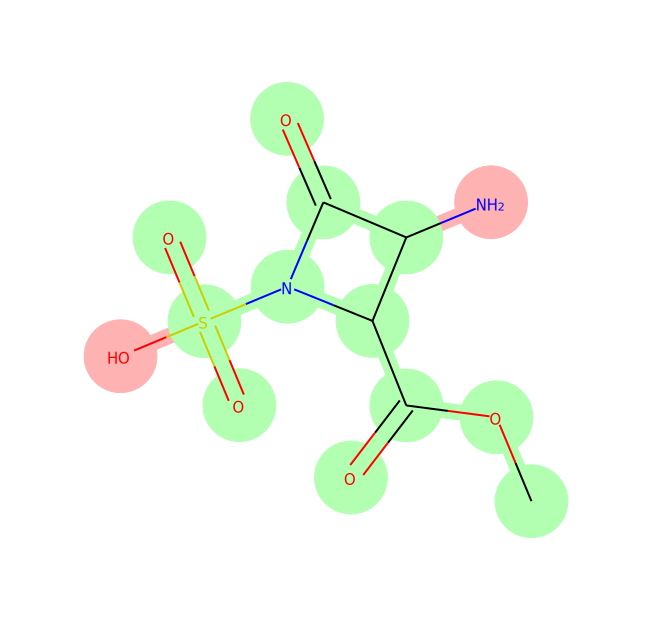

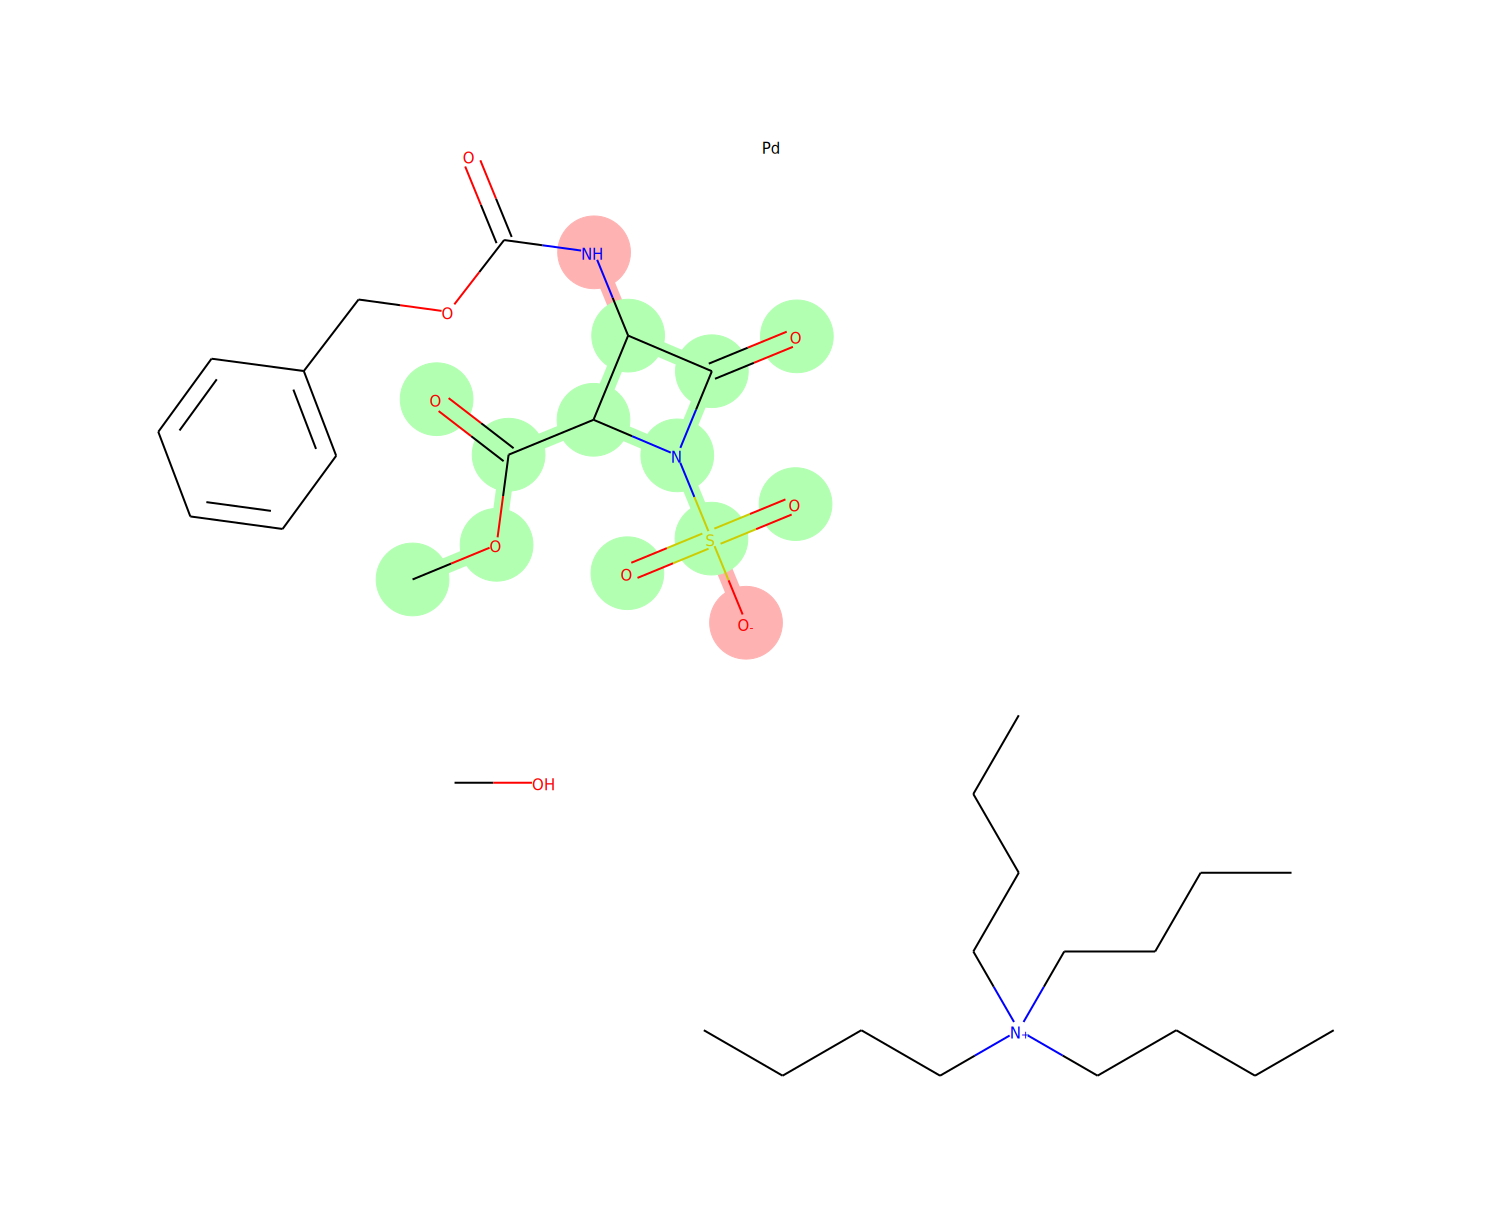

20926
0.14276639


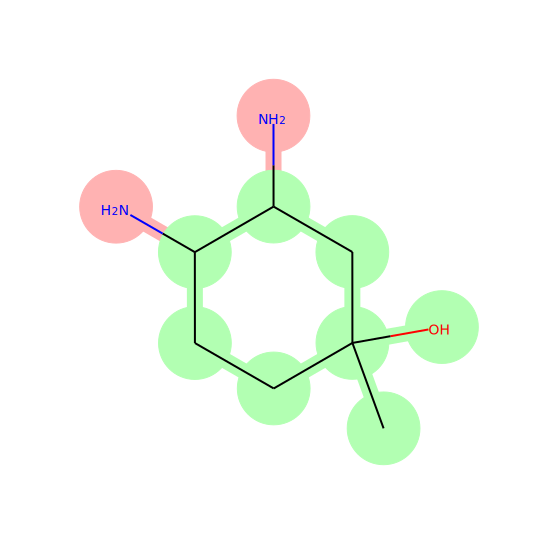

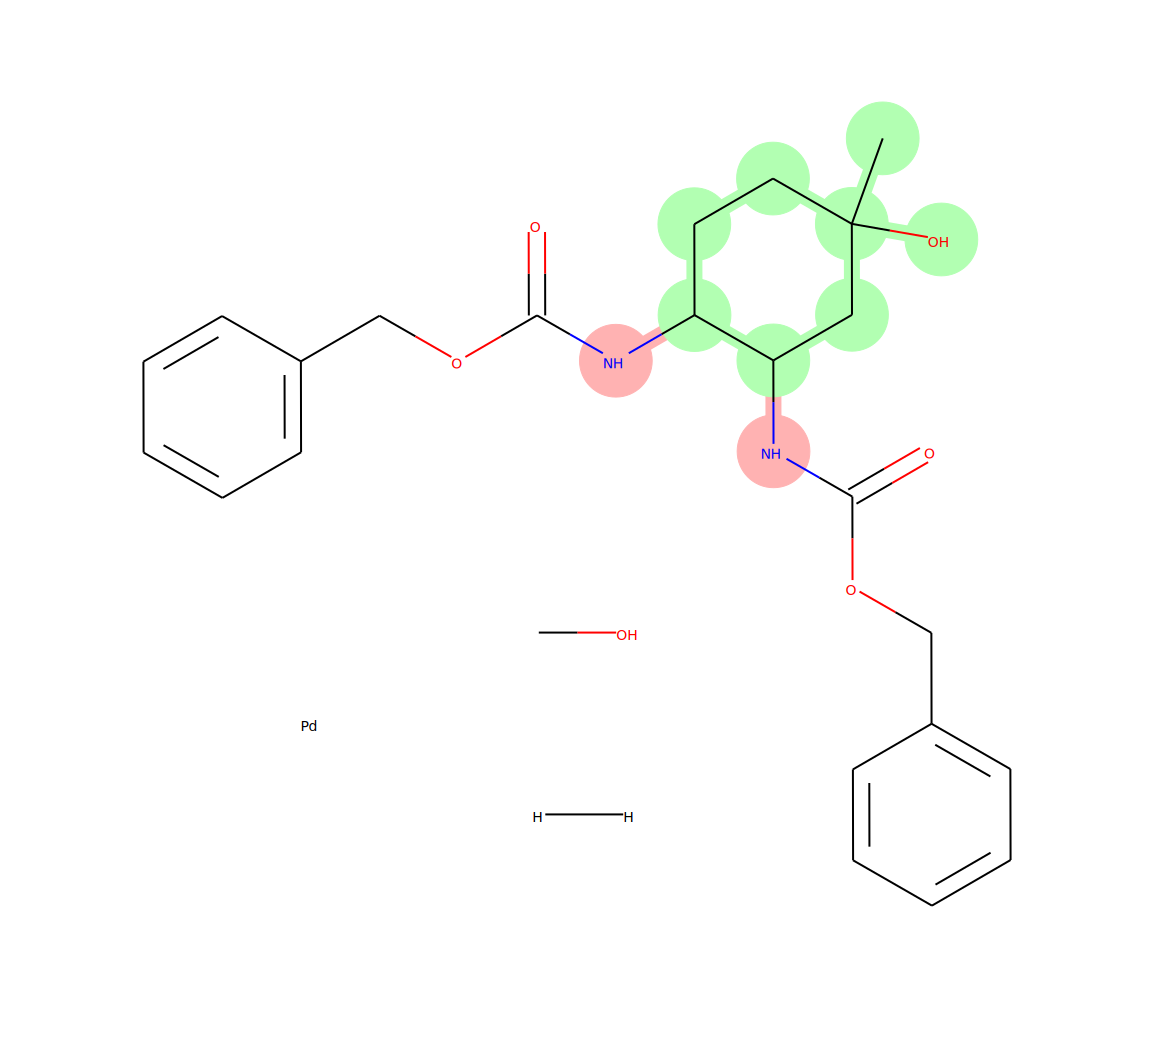

28114
0.14658727


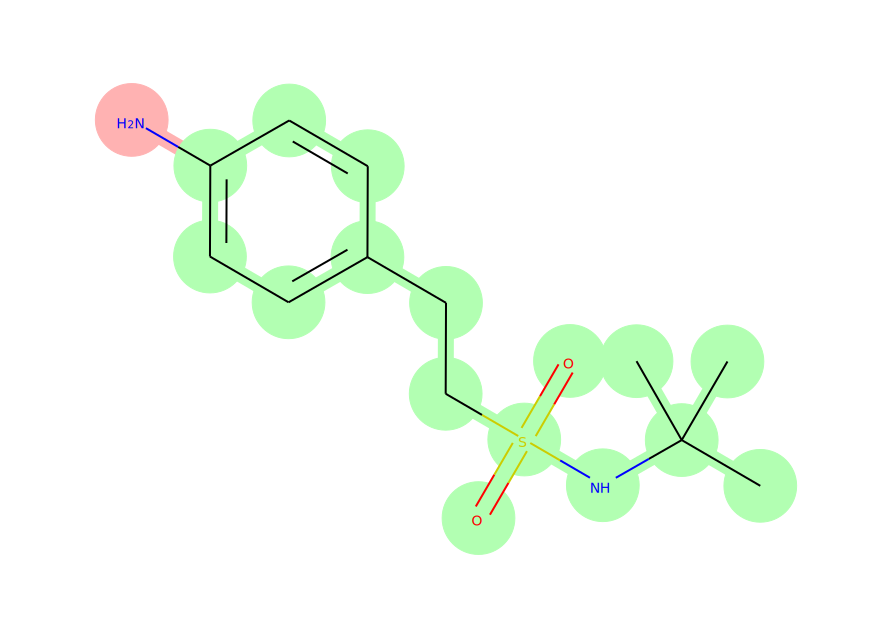

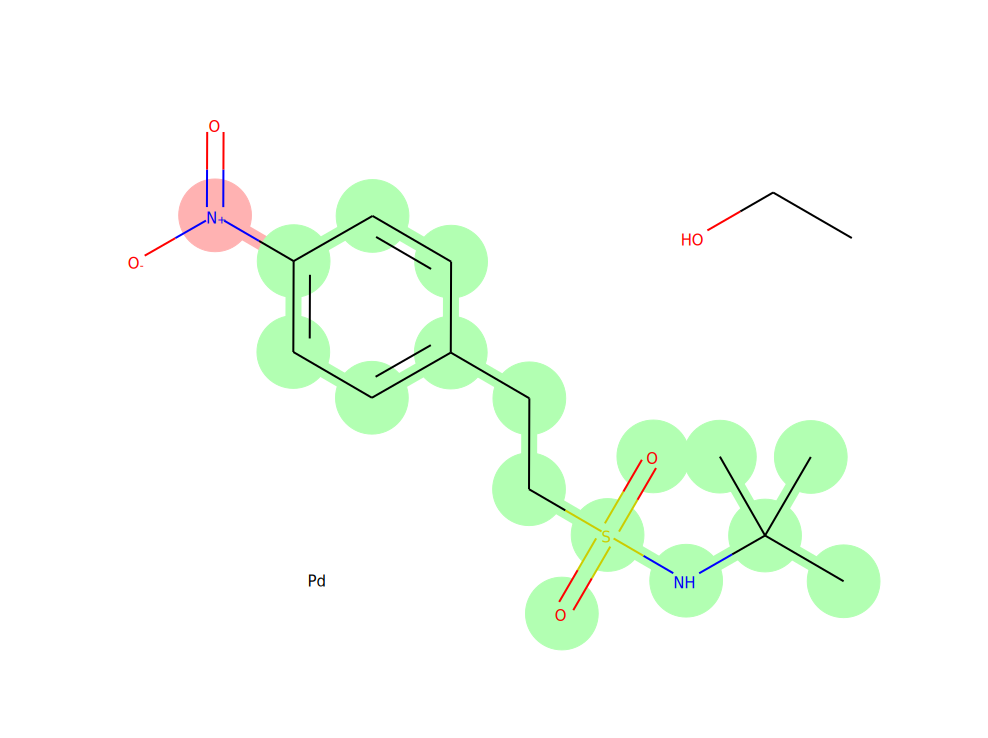

40366
0.22665085


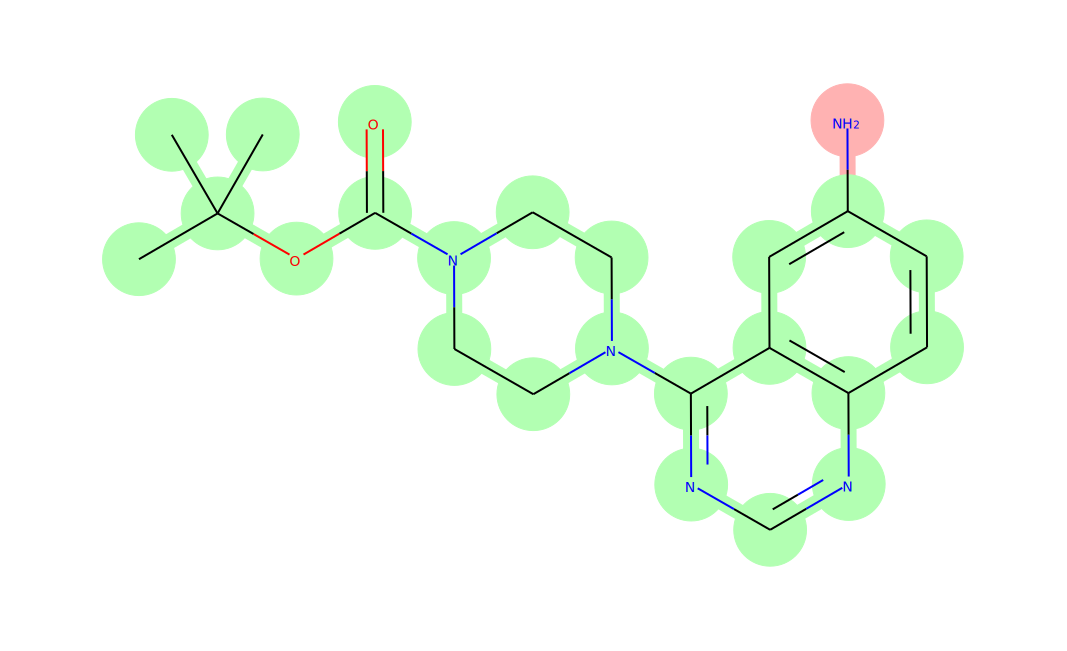

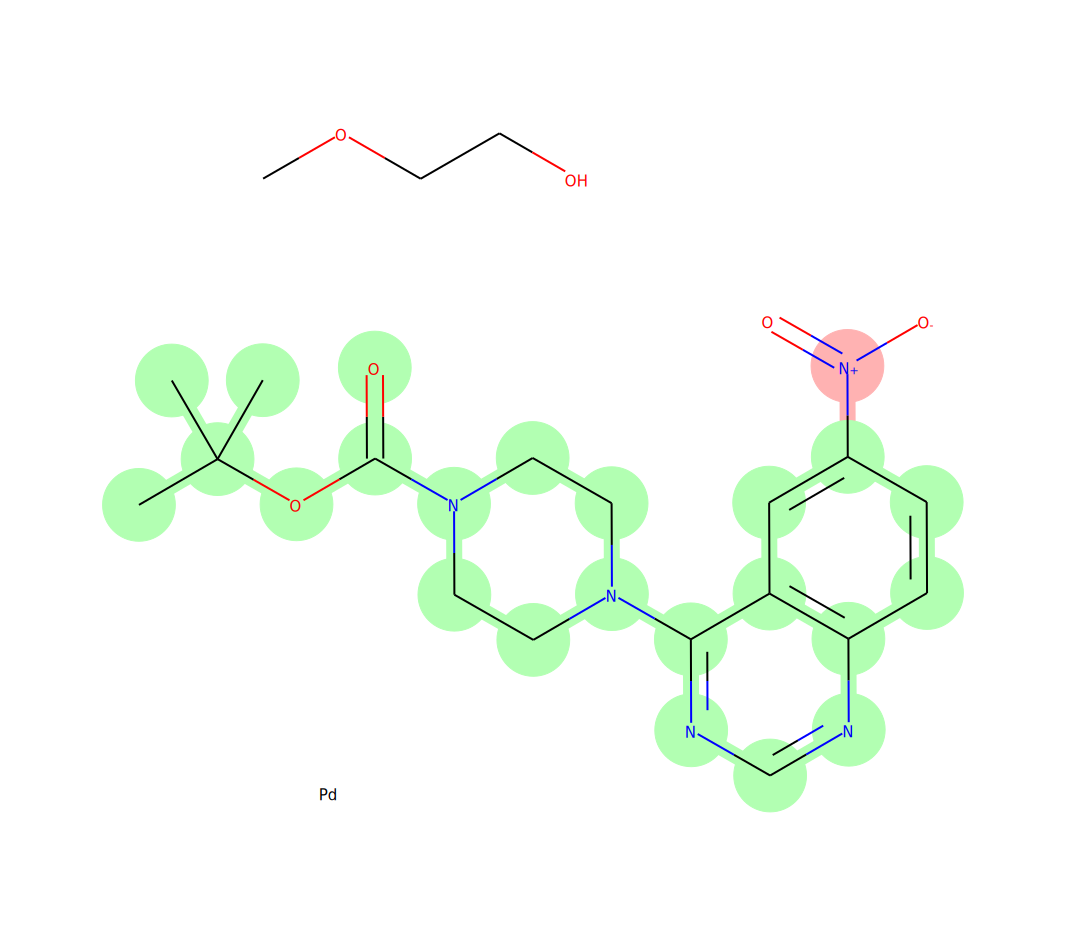

40759
2.0103128


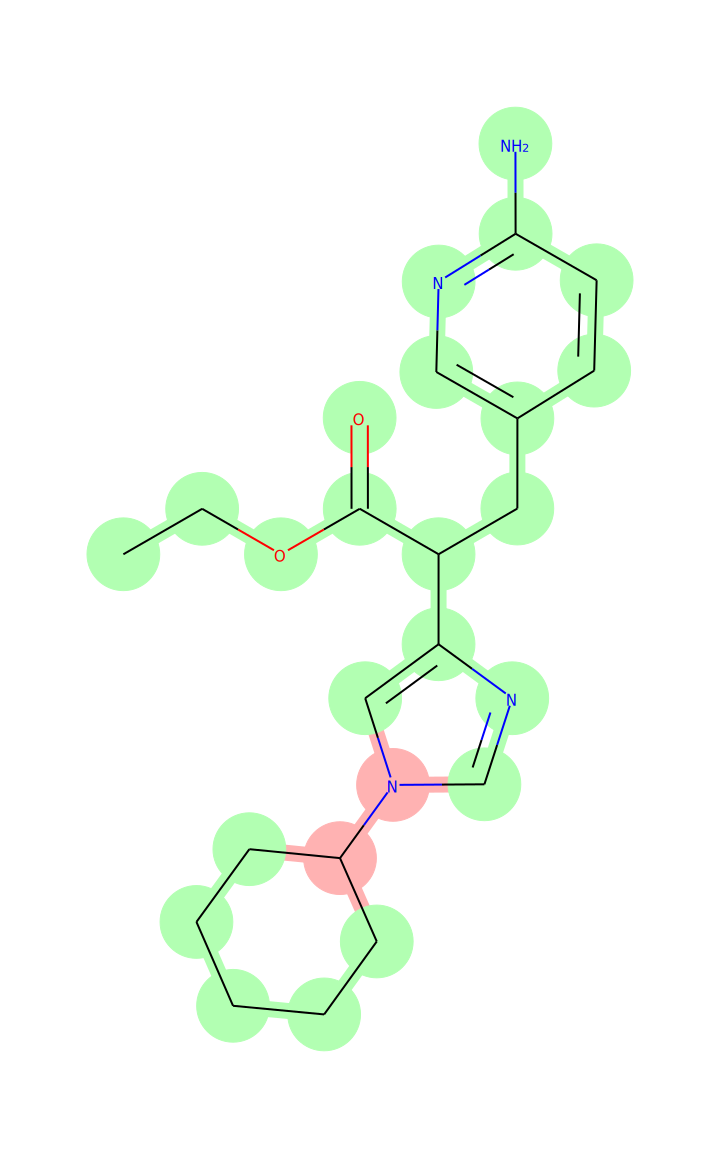

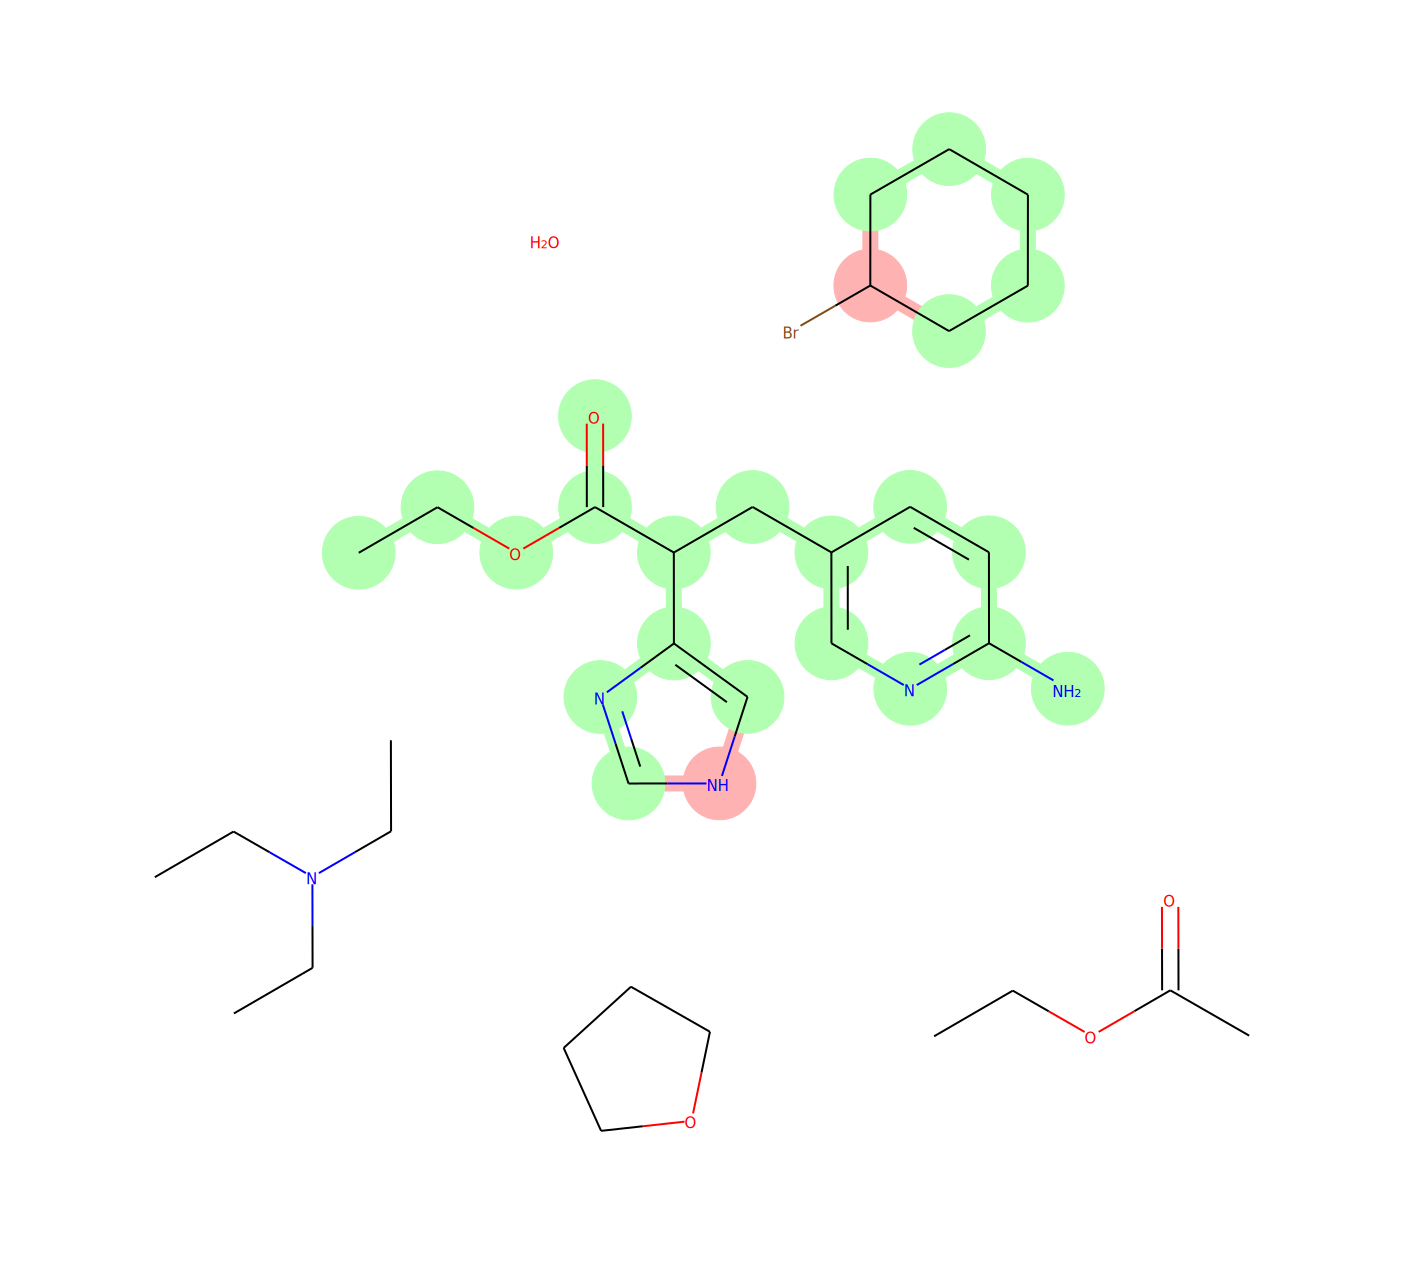

New center
25520
0.11073379


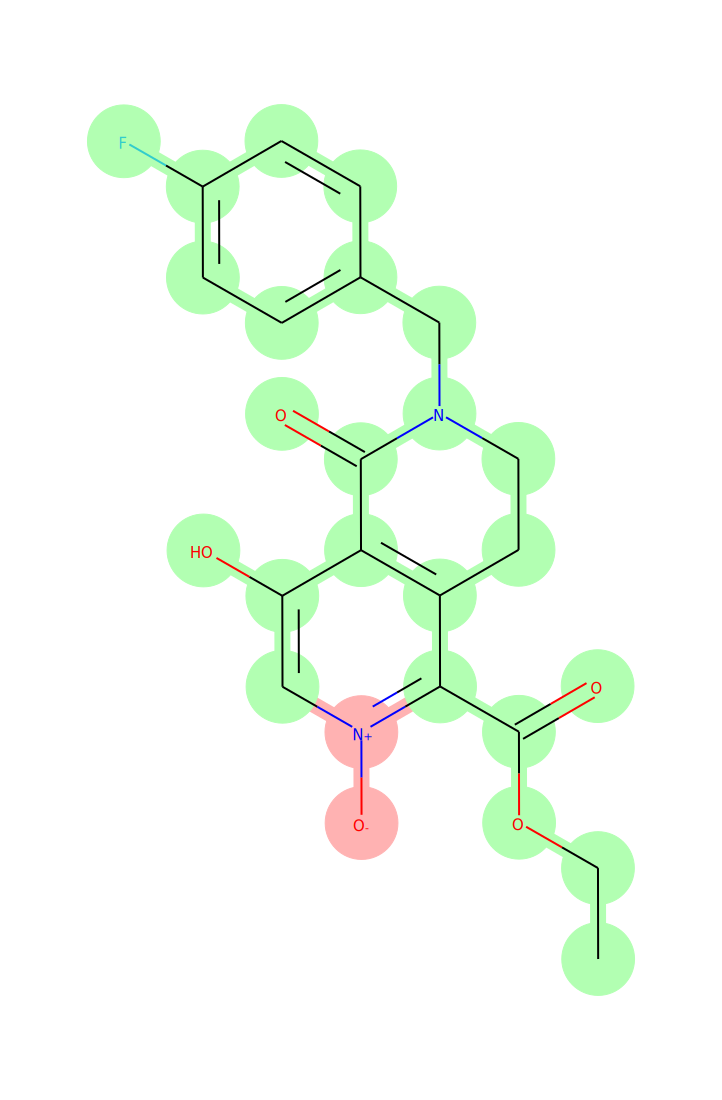

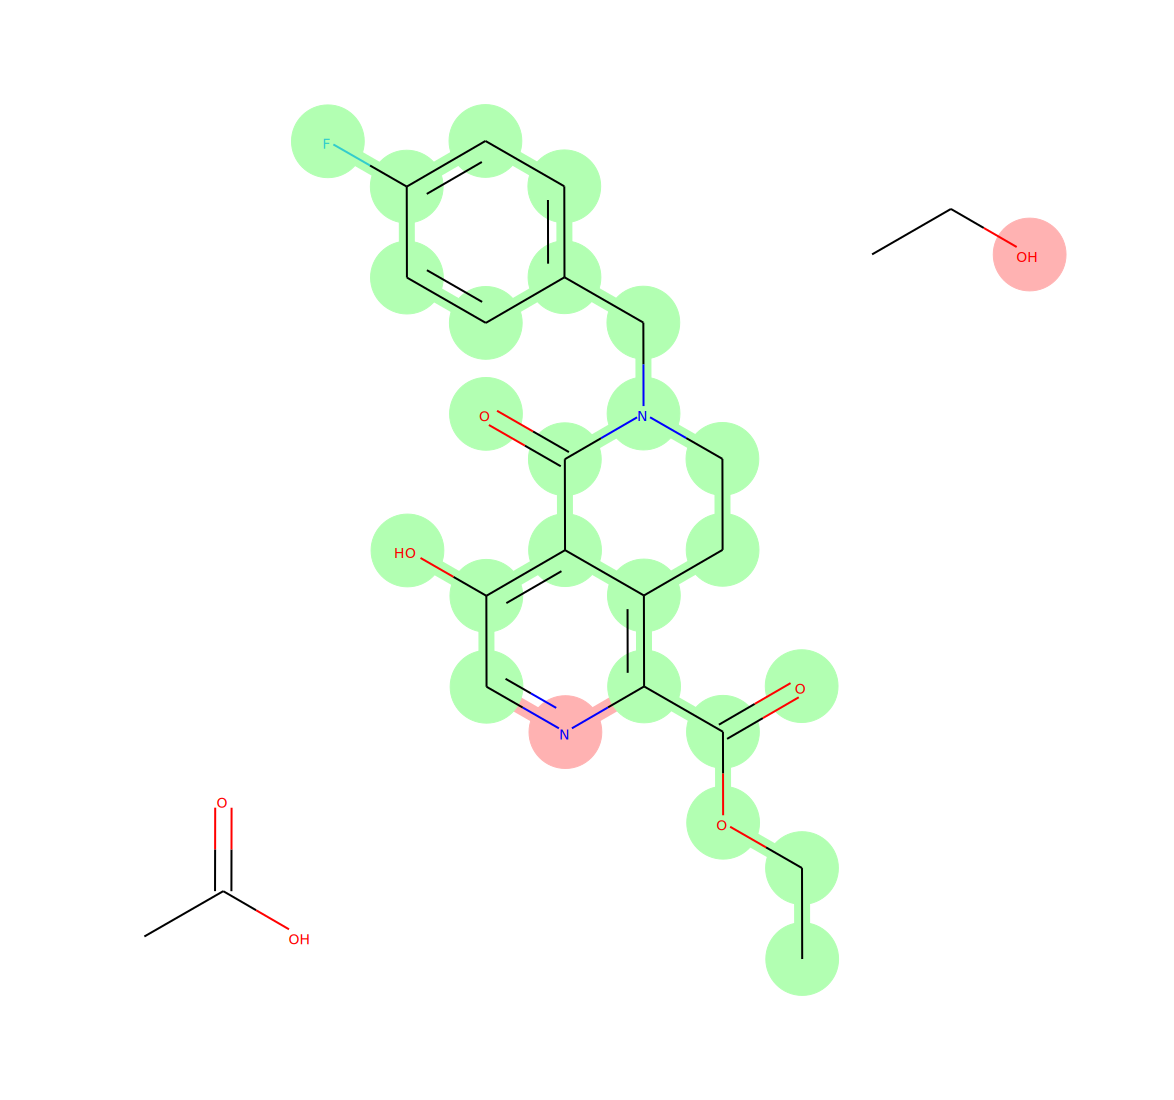

48701
0.11868462


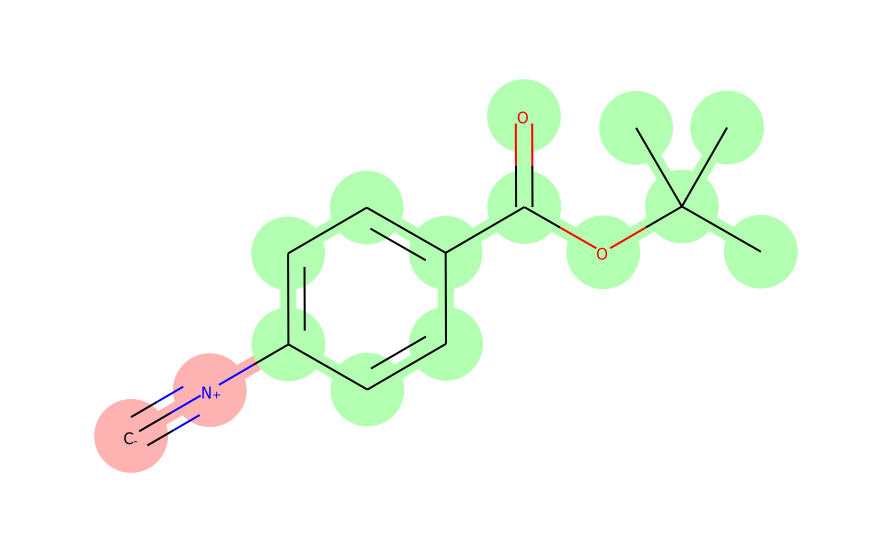

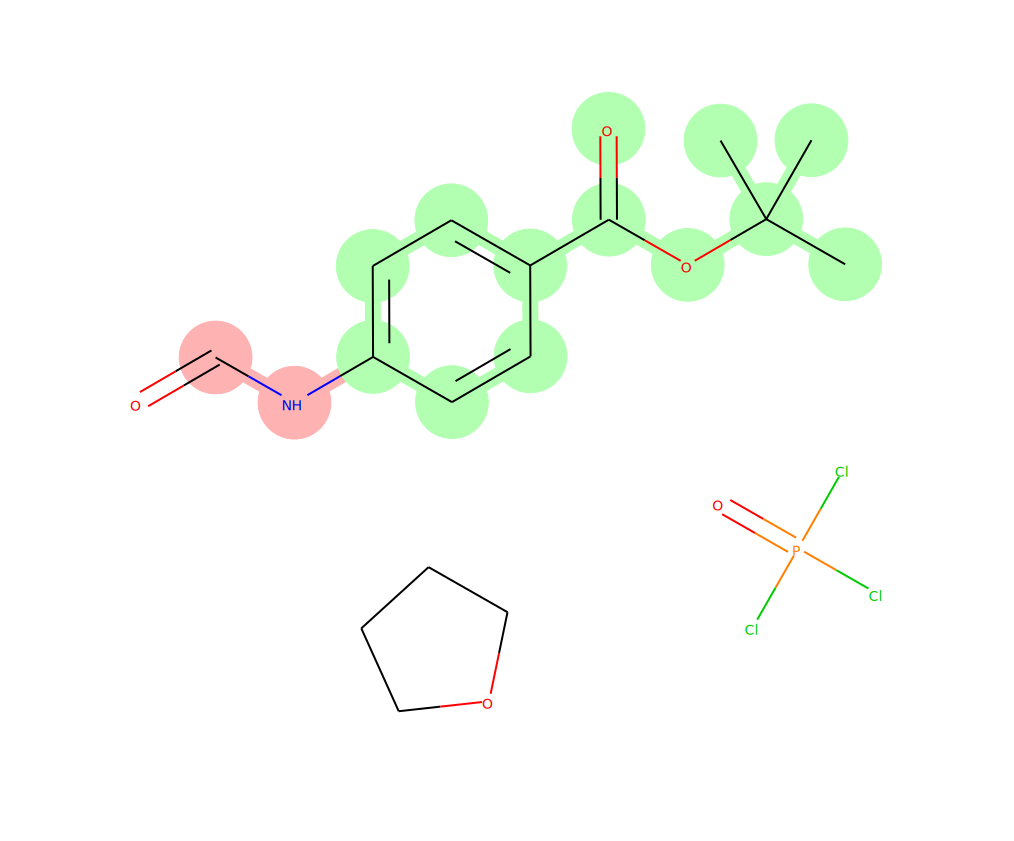

5108
0.11927691


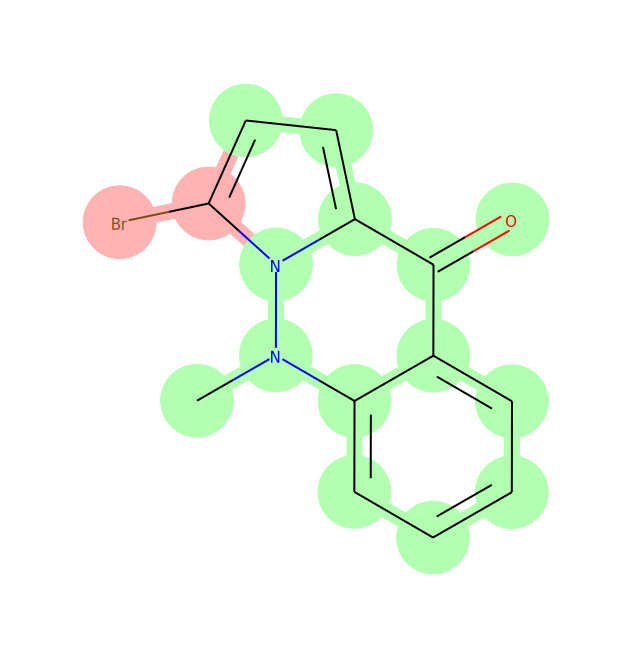

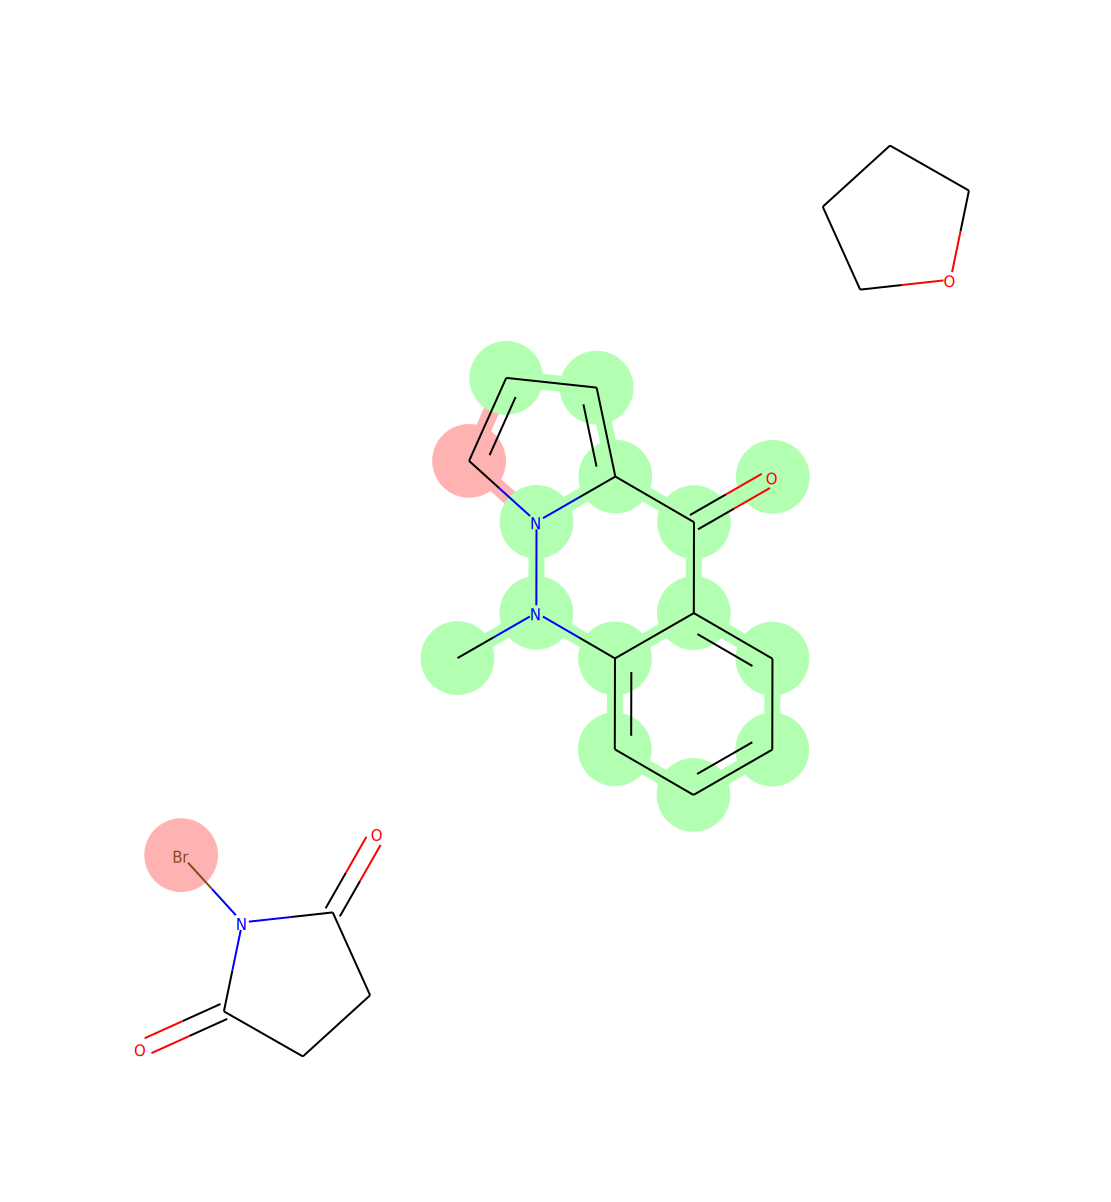

14305
0.16325471


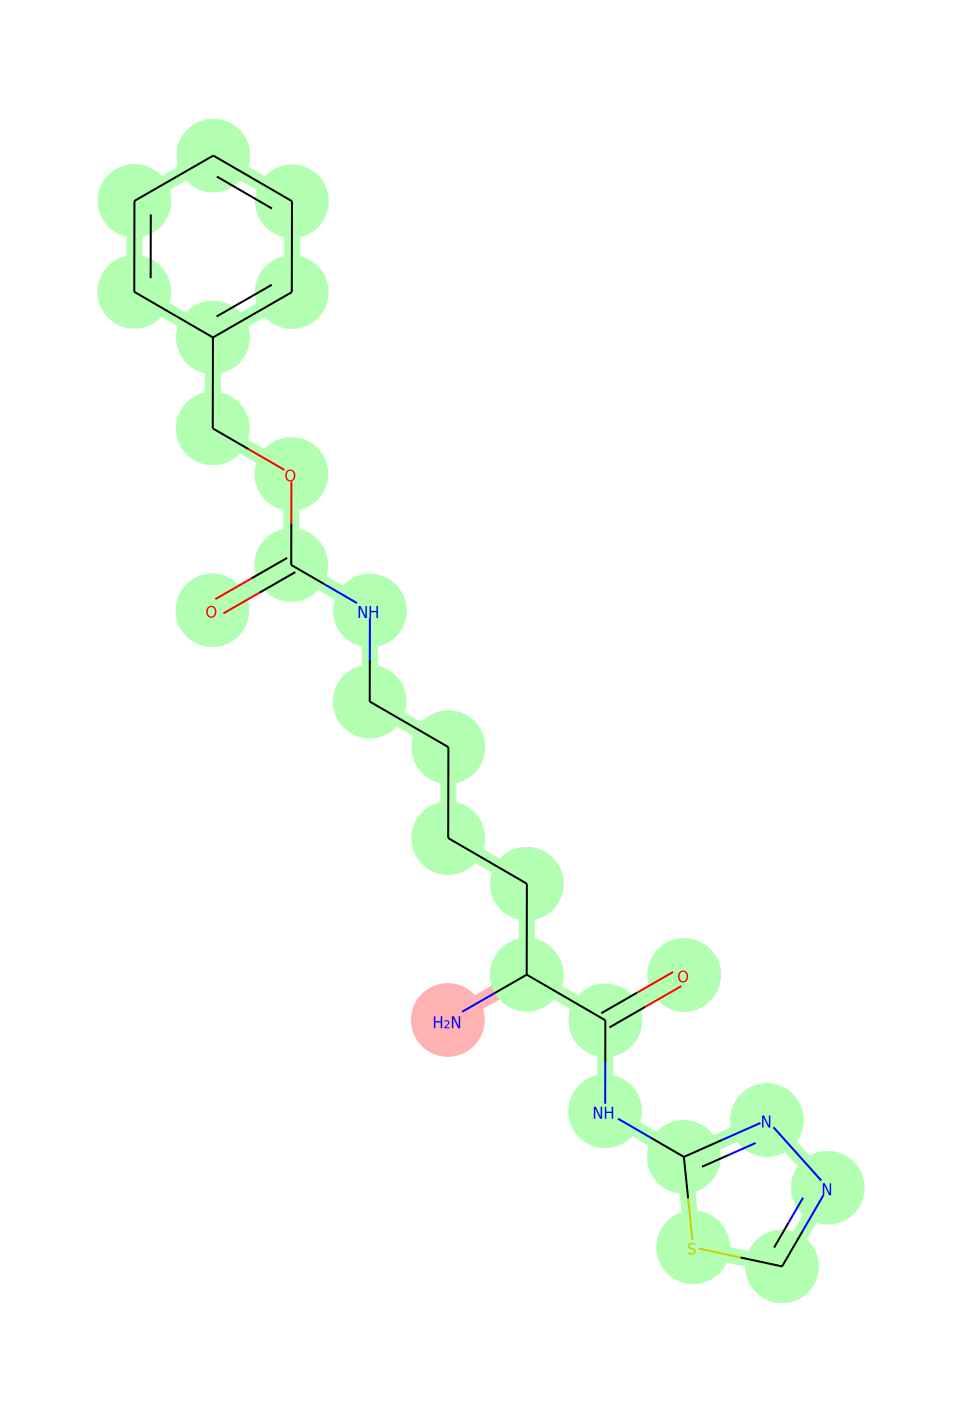

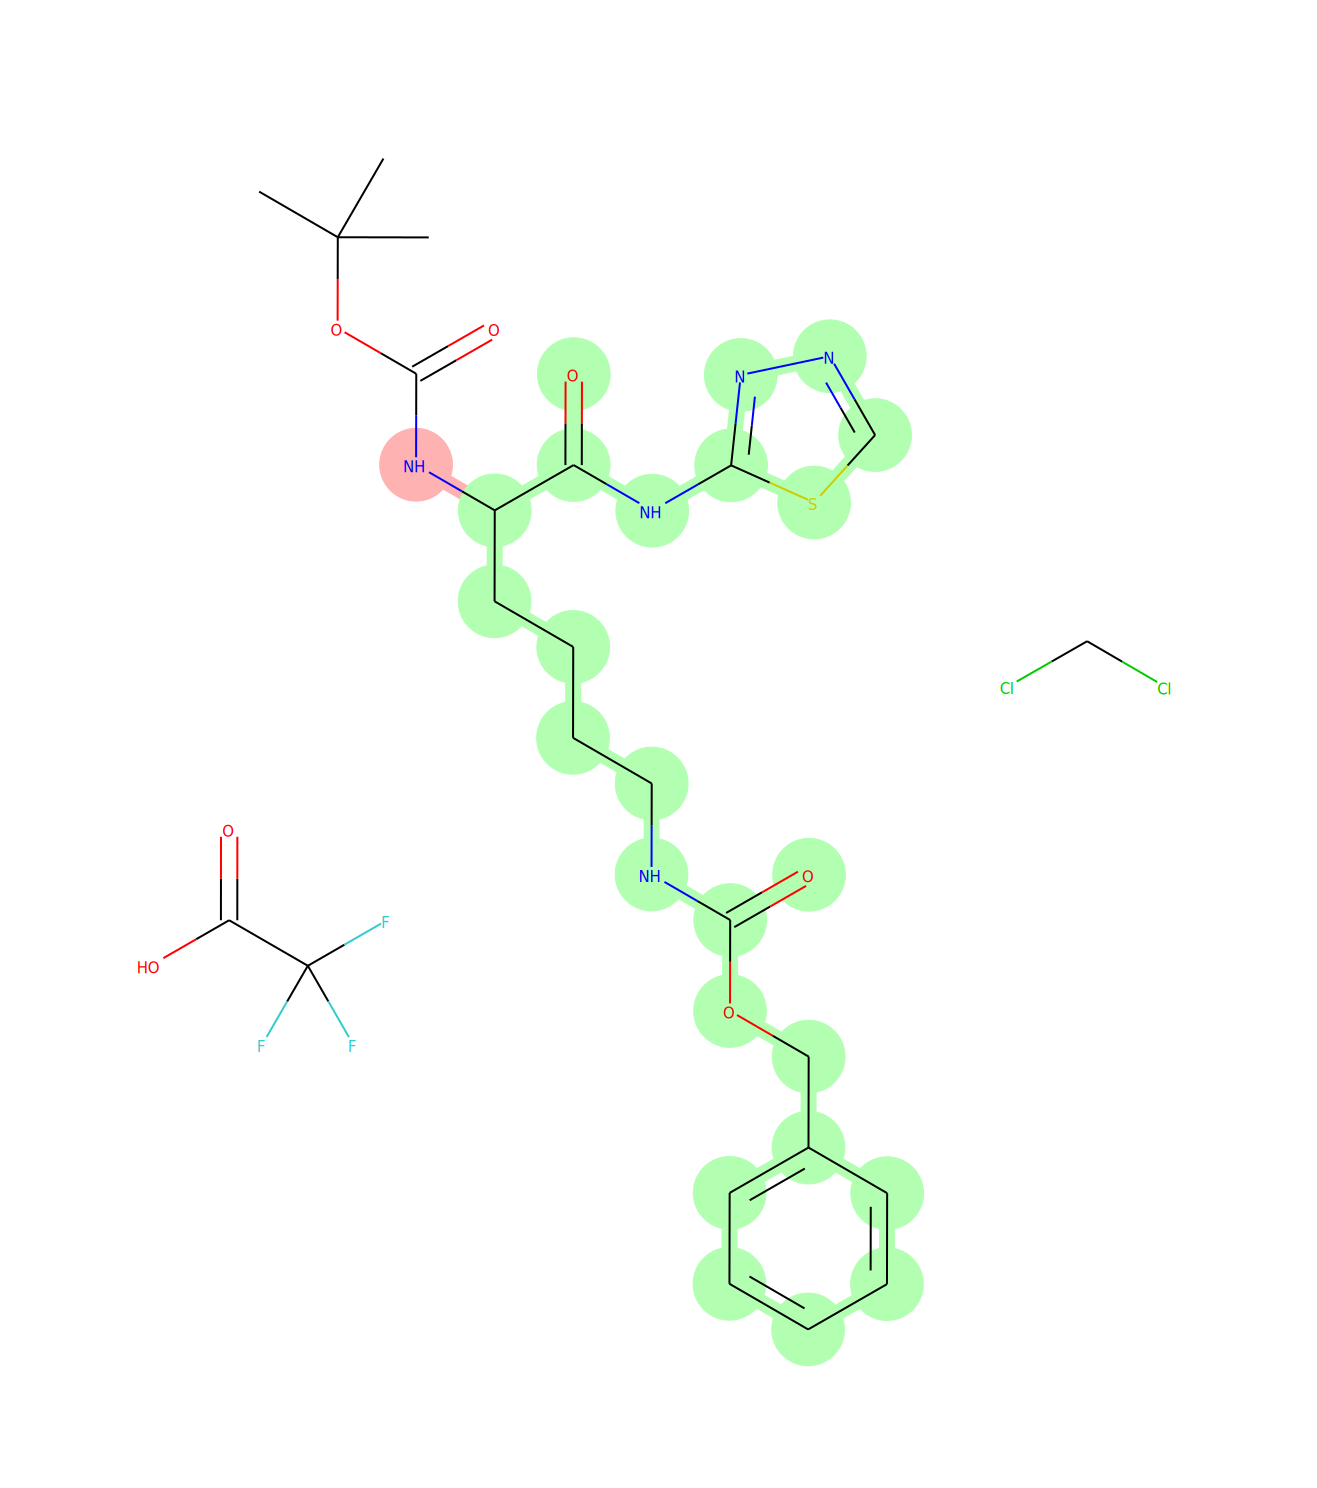

21600
0.9498284


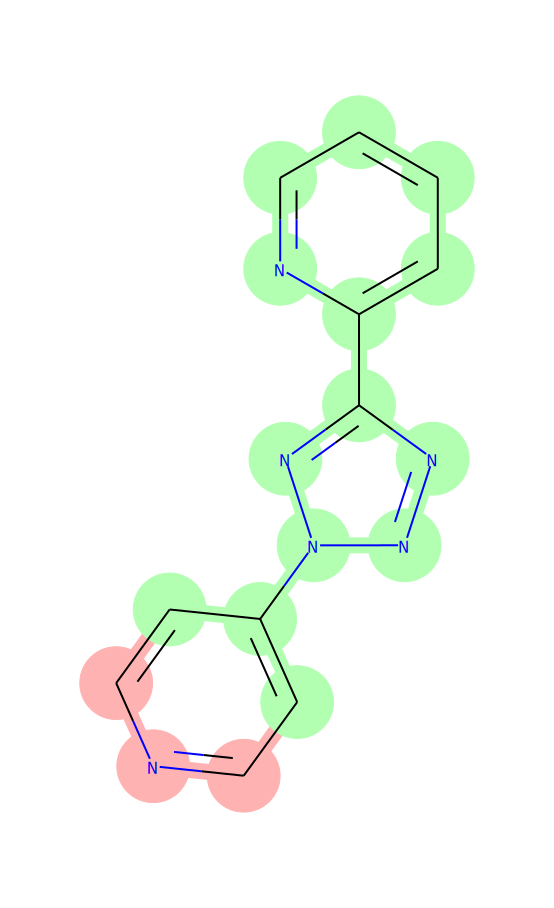

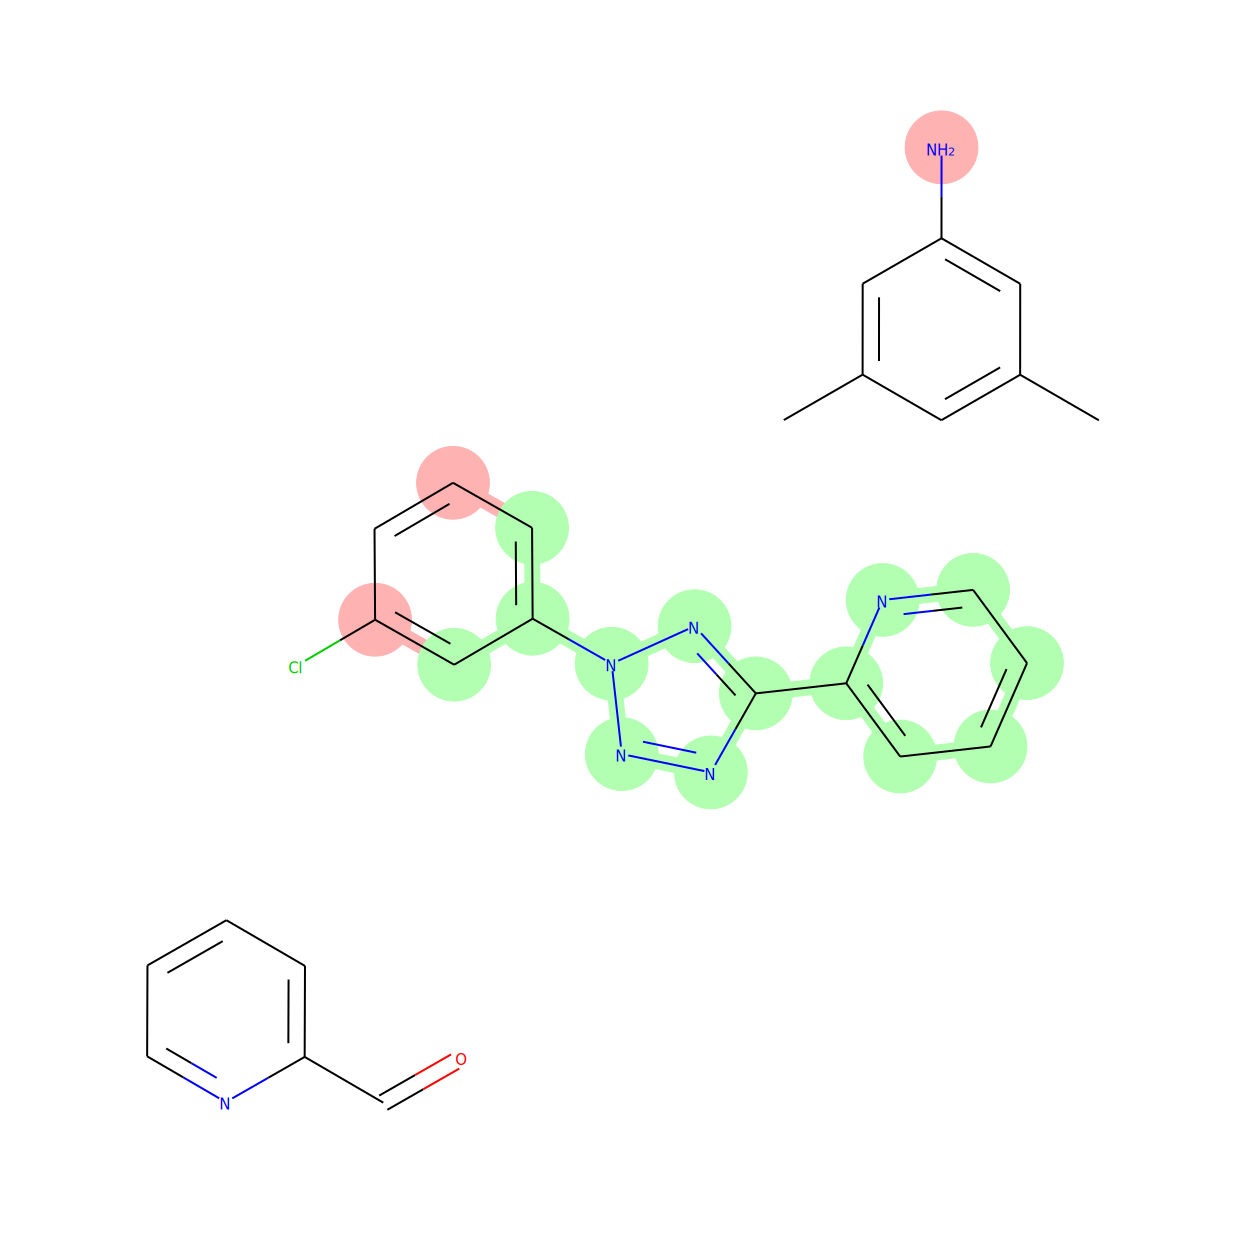

New center
2865
0.08663401


RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors


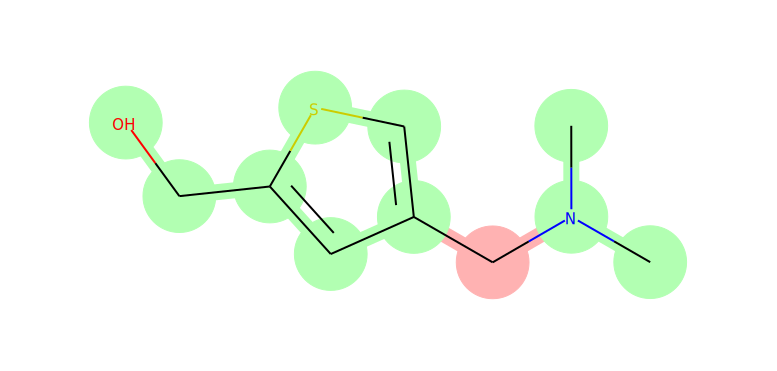

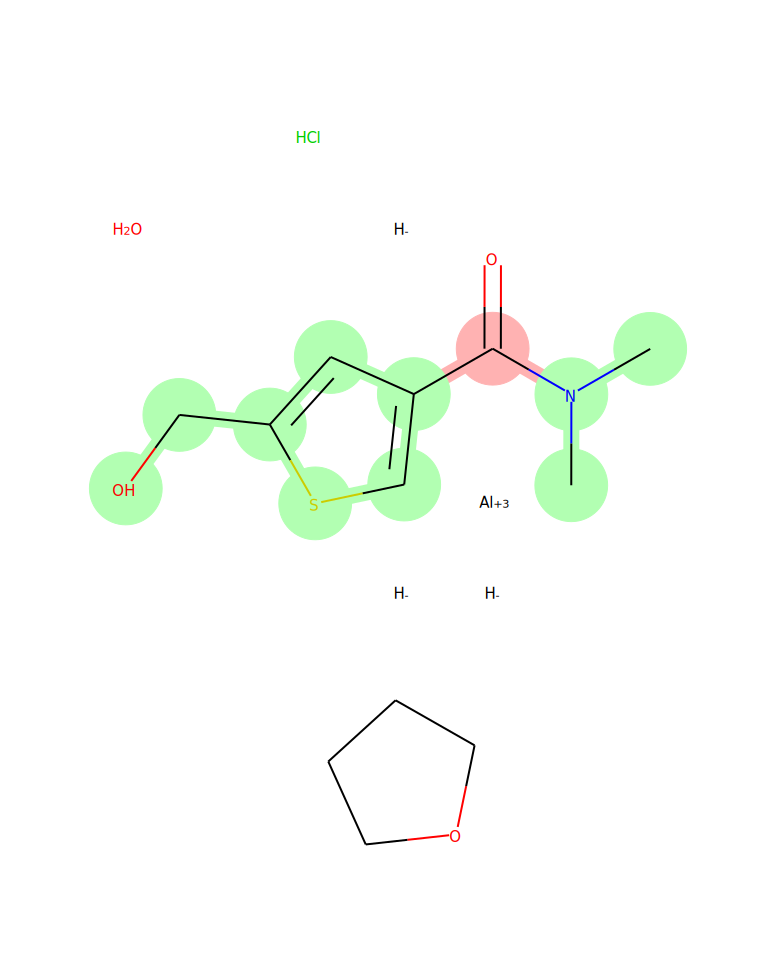

39219
0.18974893


RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors


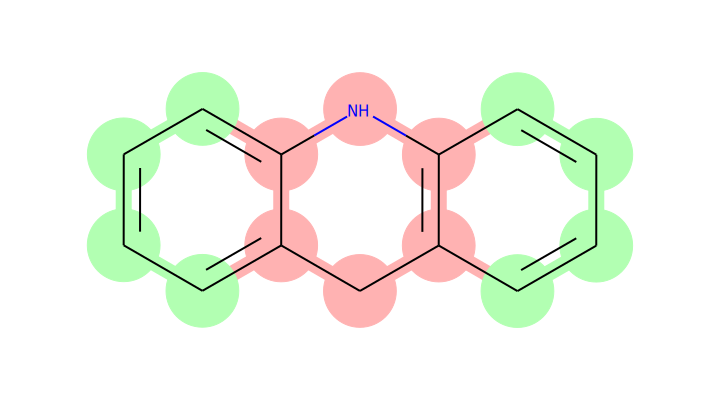

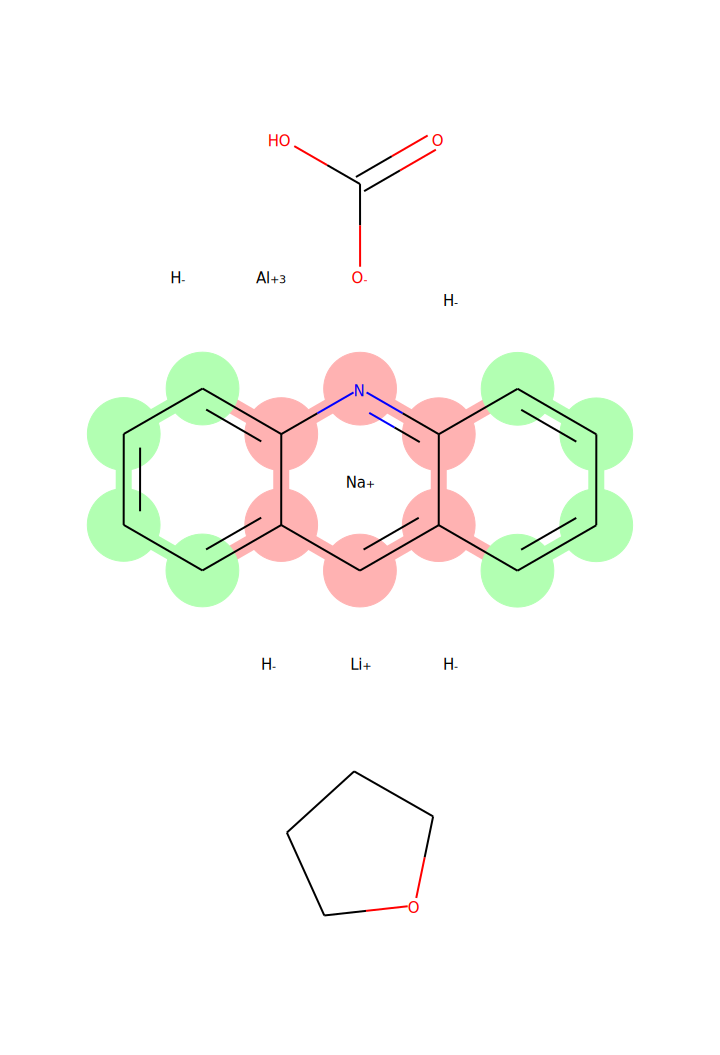

10680
0.21106924


RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors


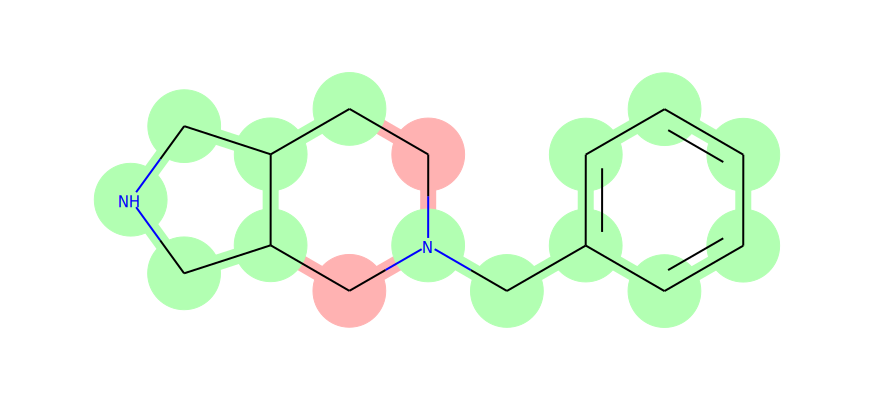

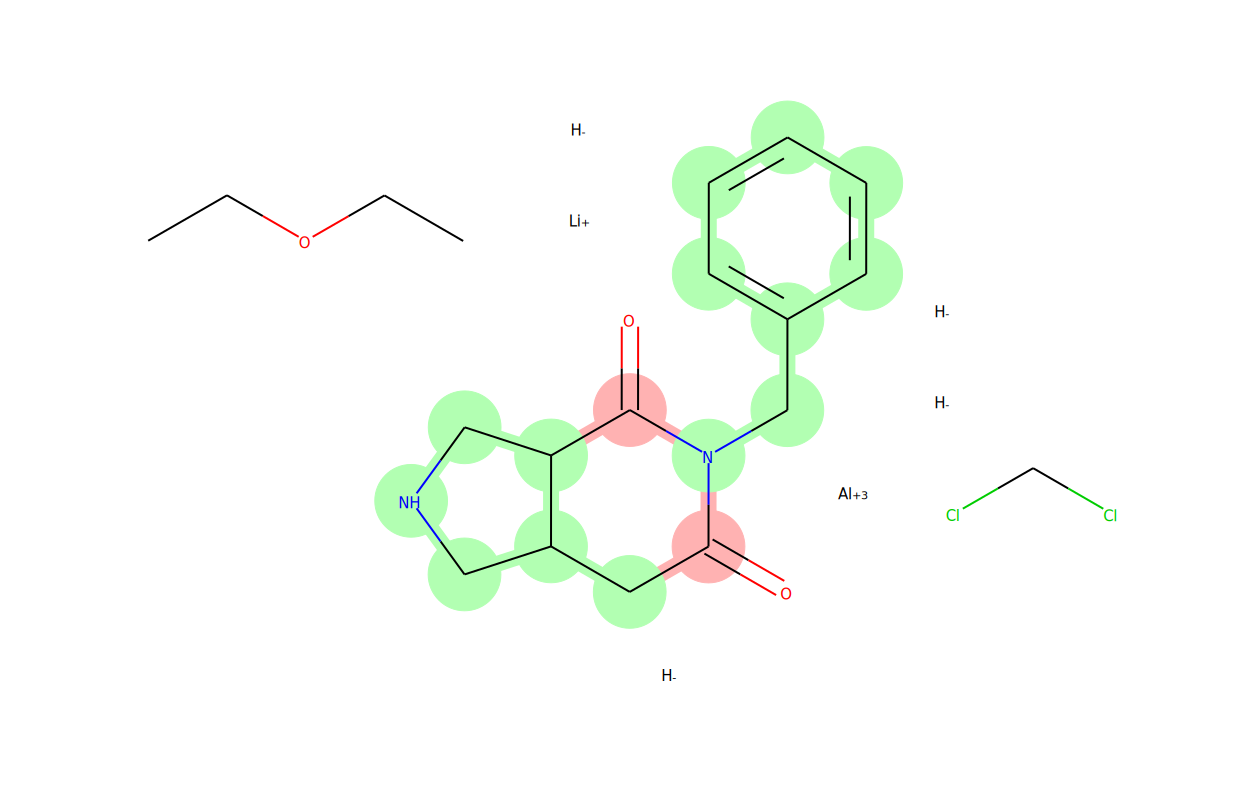

36278
0.31630325


RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:30] WARNING: not removing hydrogen atom without neighbors


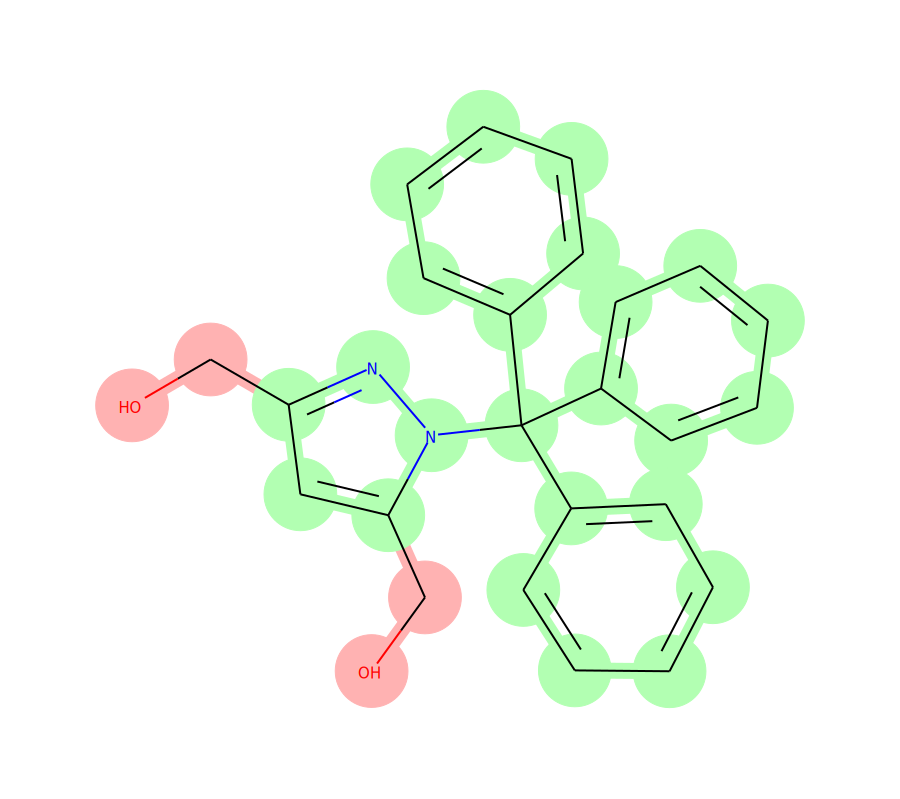

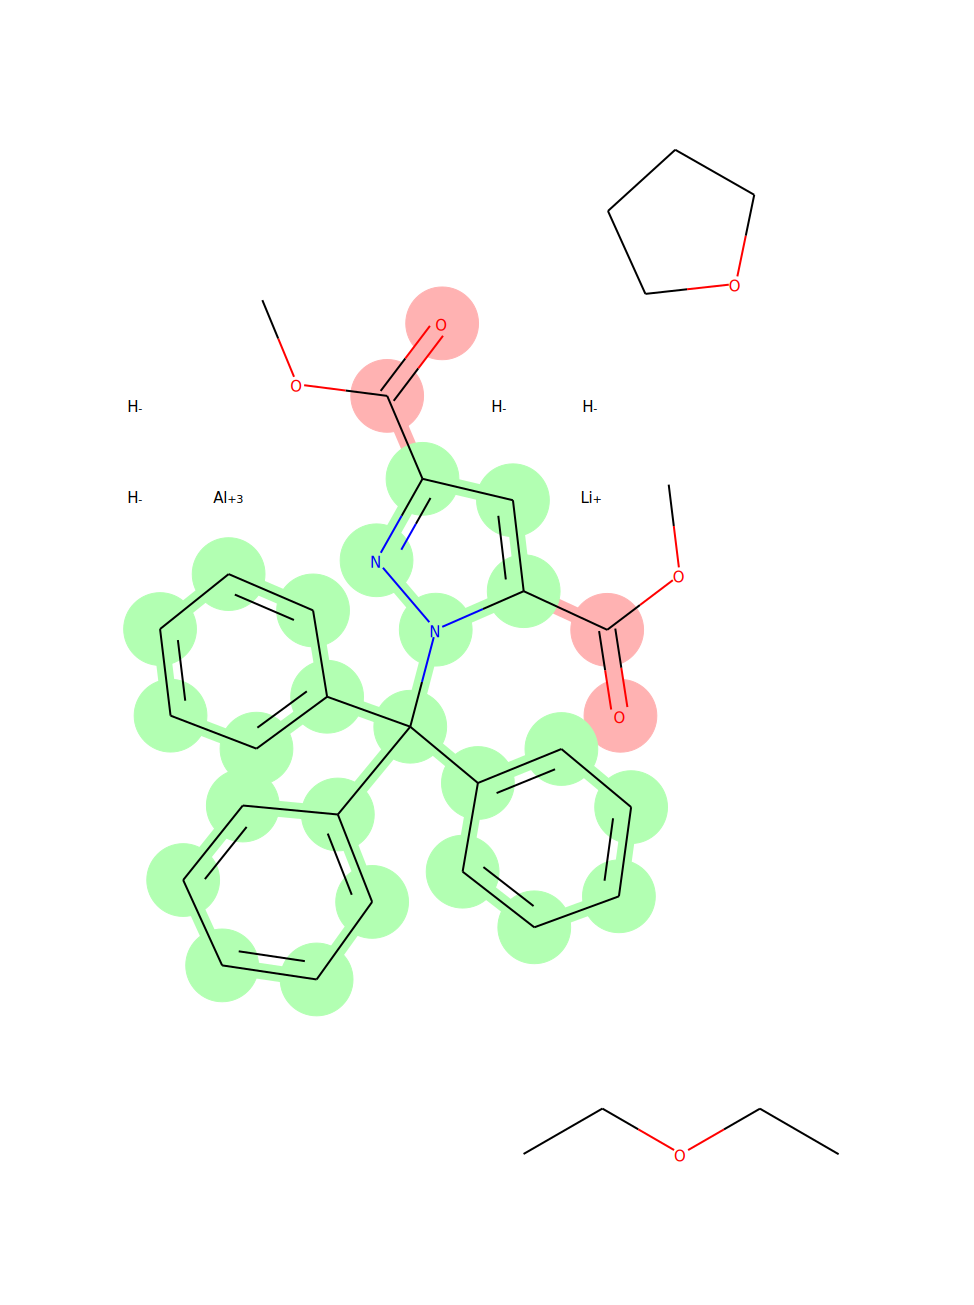

10565
2.5603683


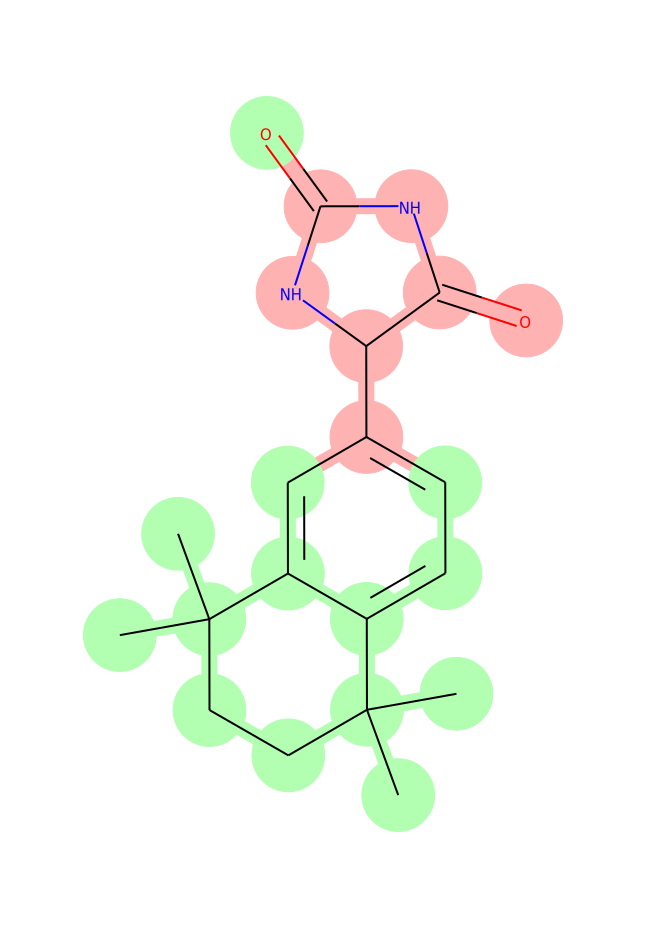

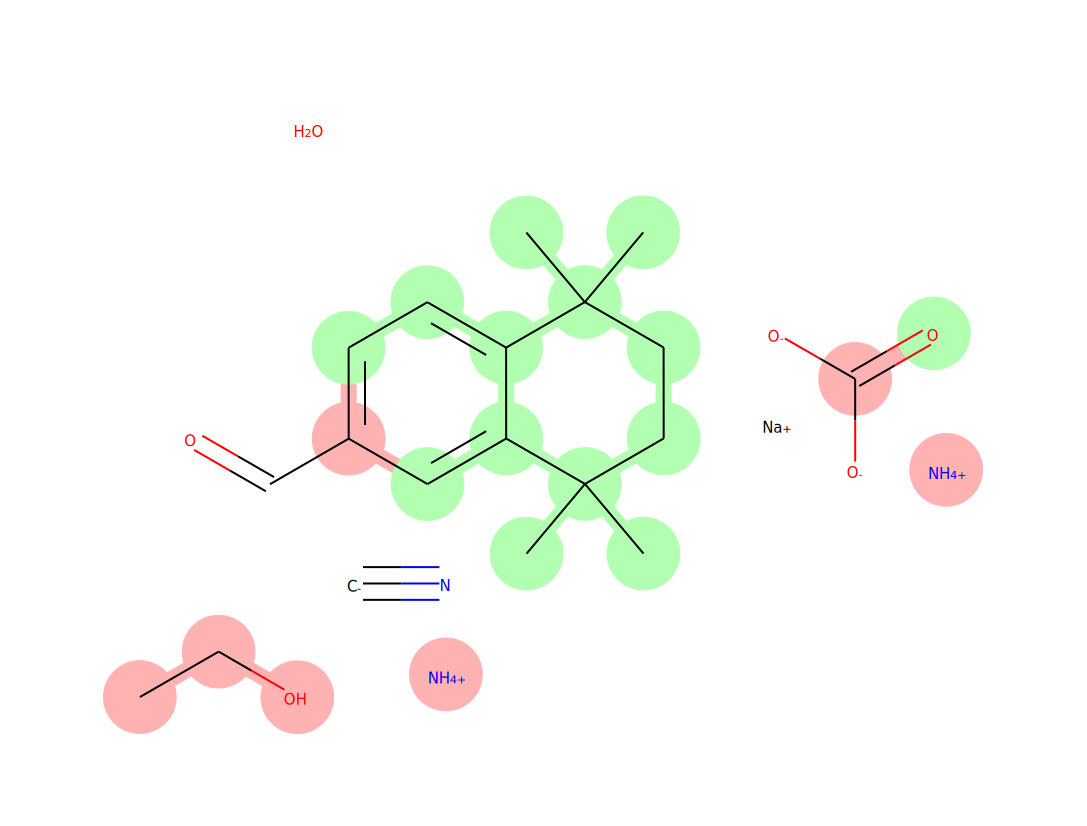

New center
37200
0.057846542


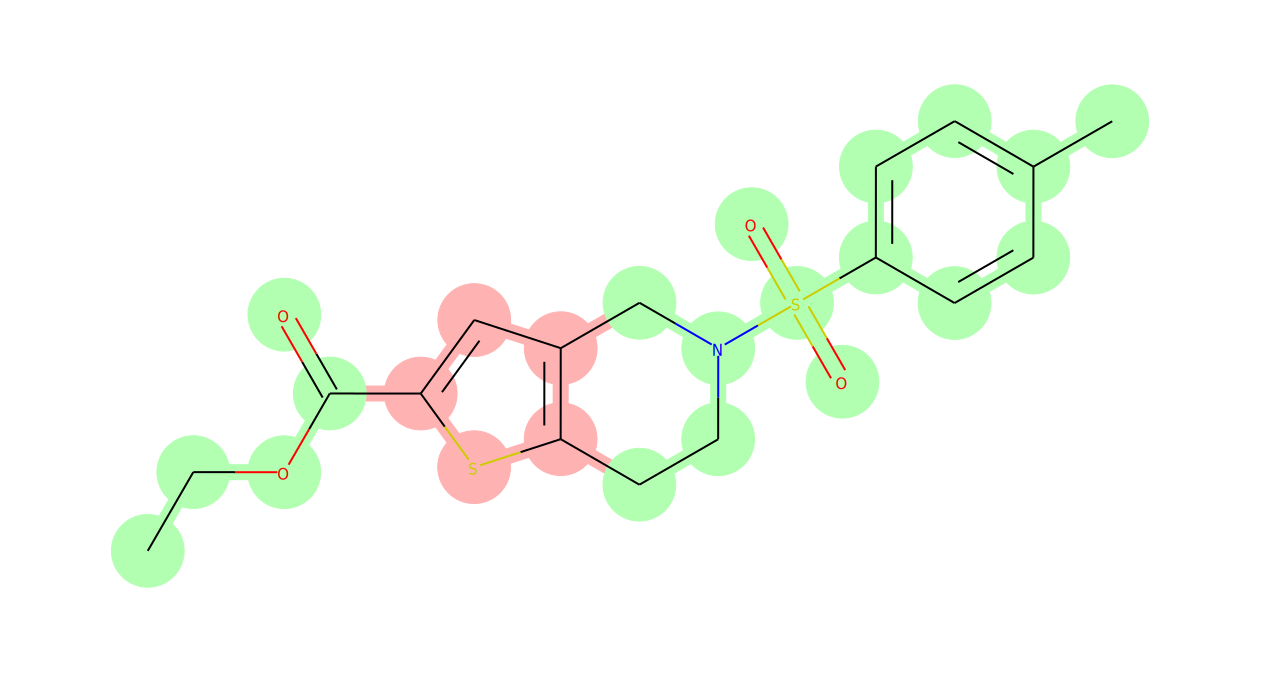

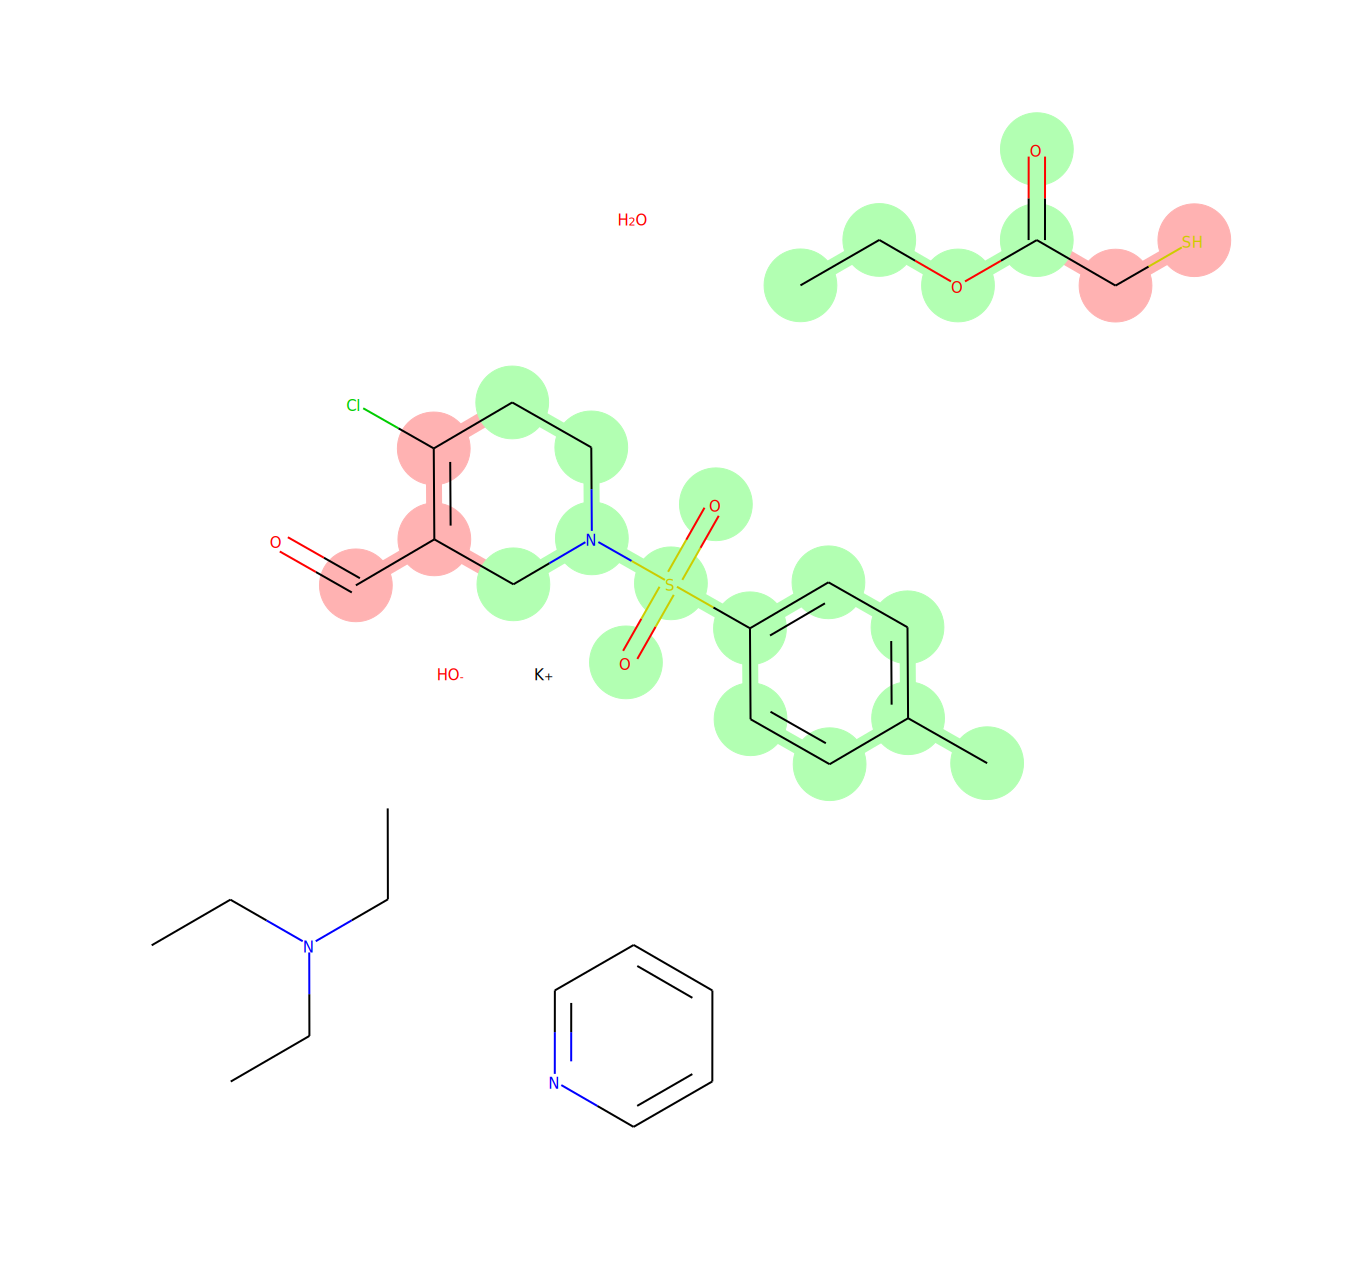

46301
0.069371946


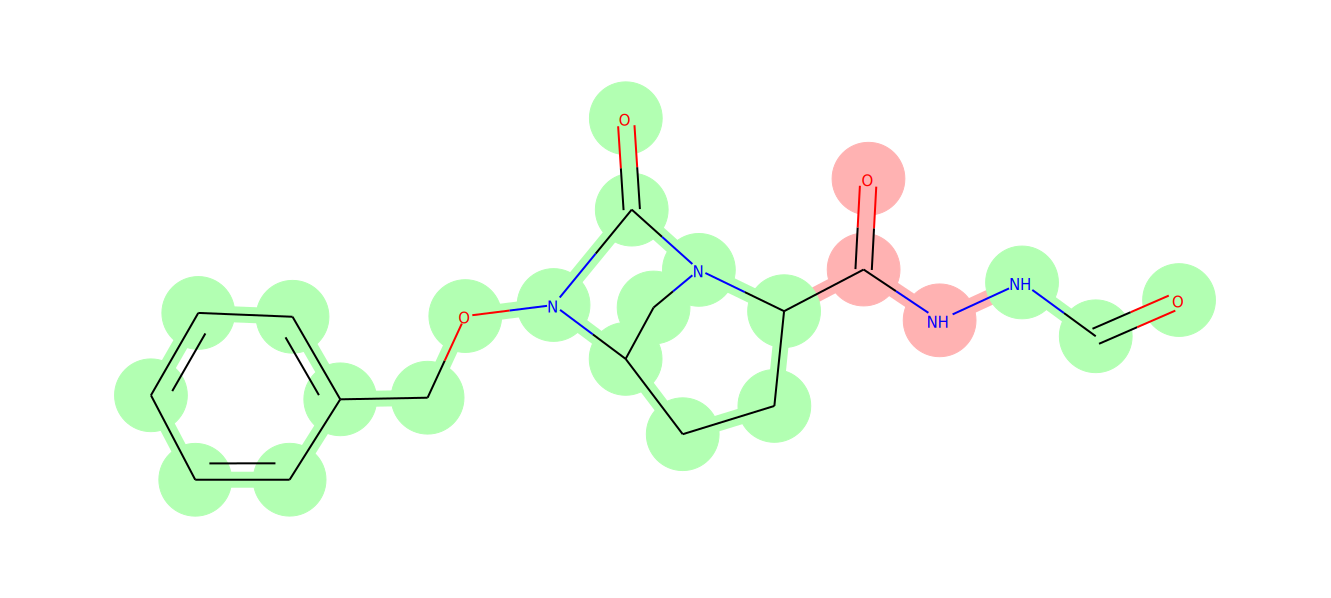

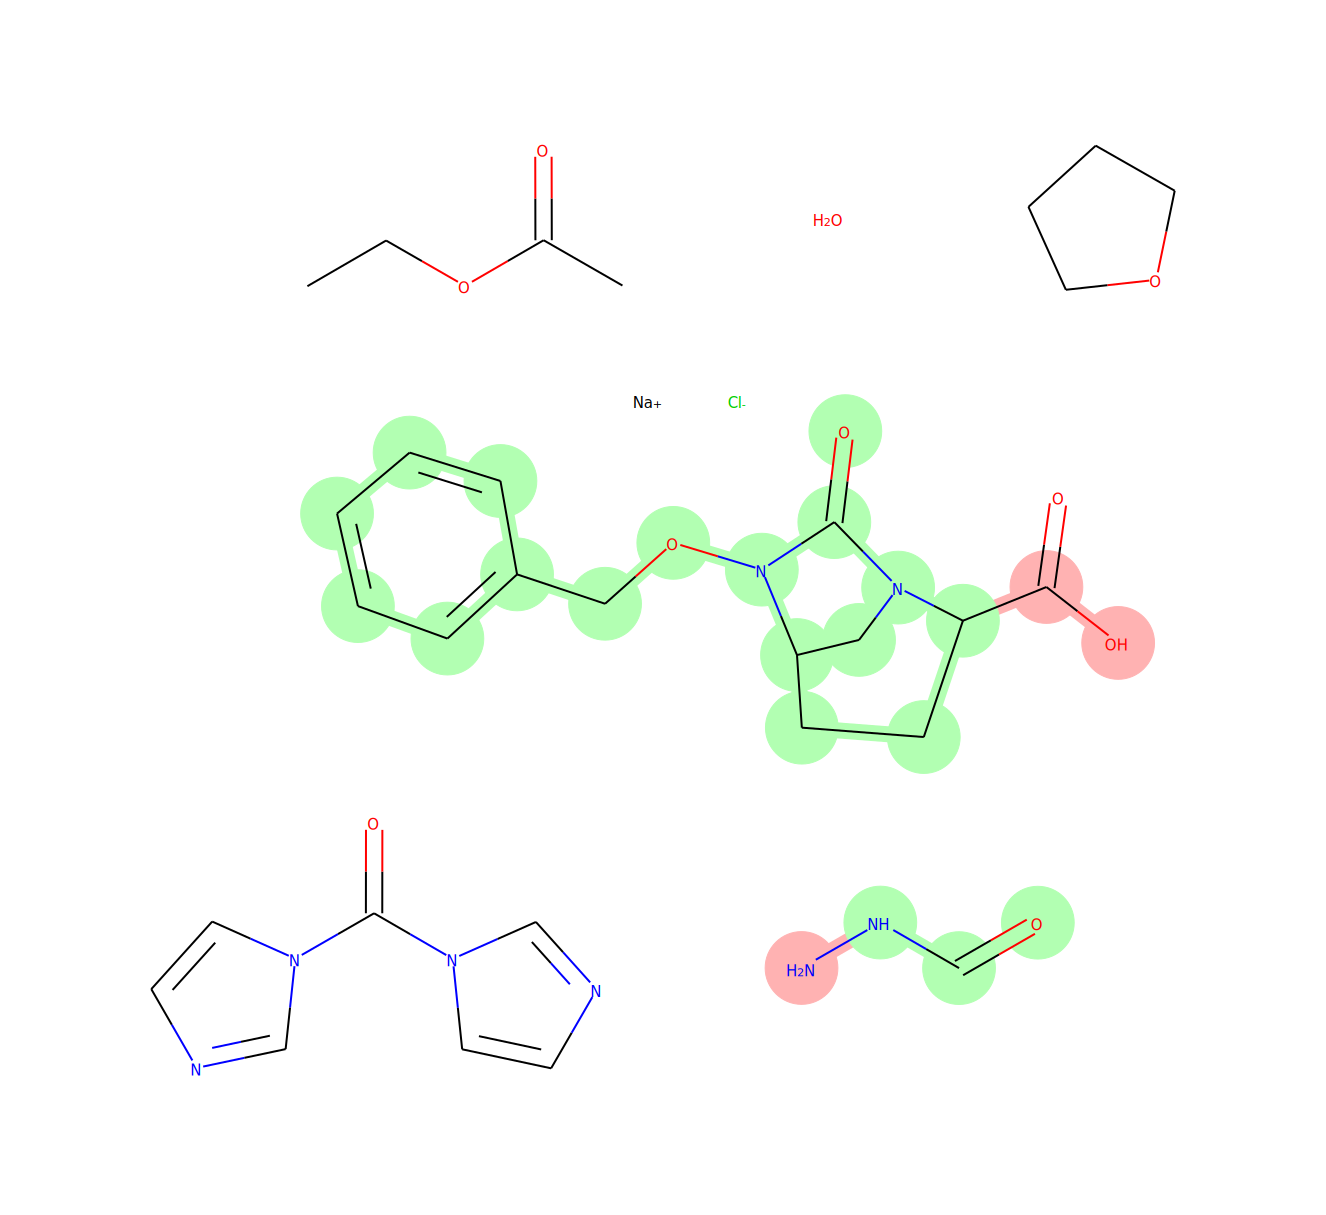

9113
0.07895928


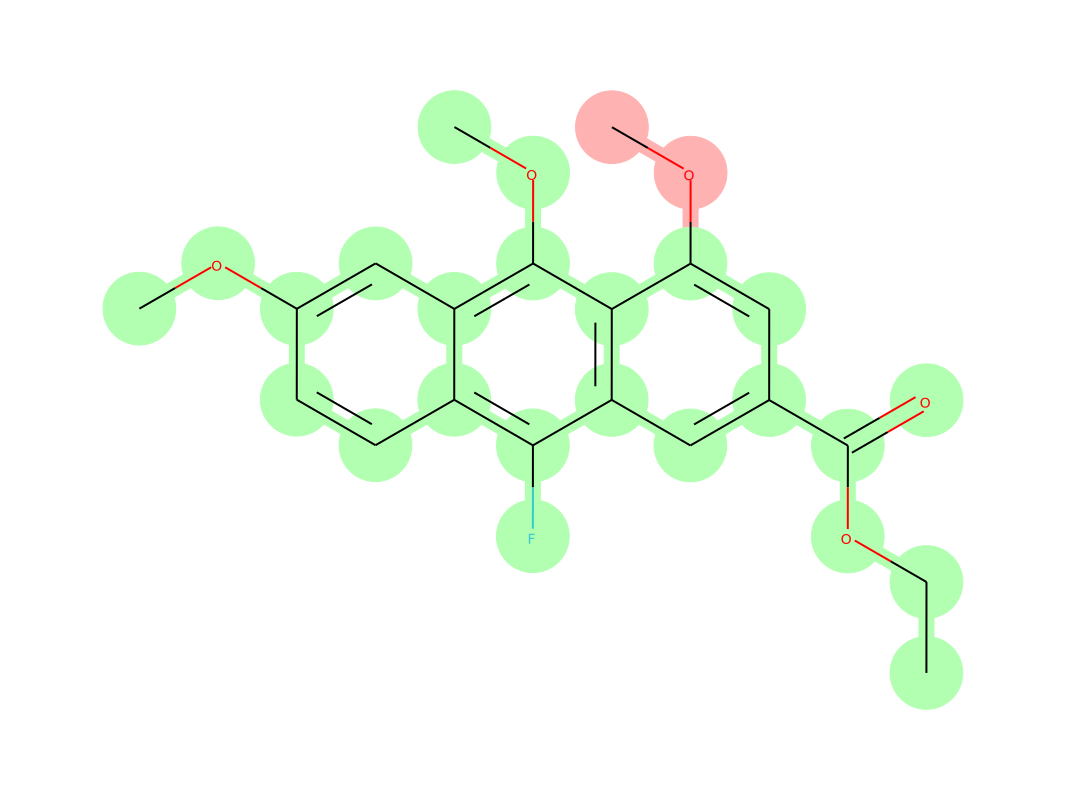

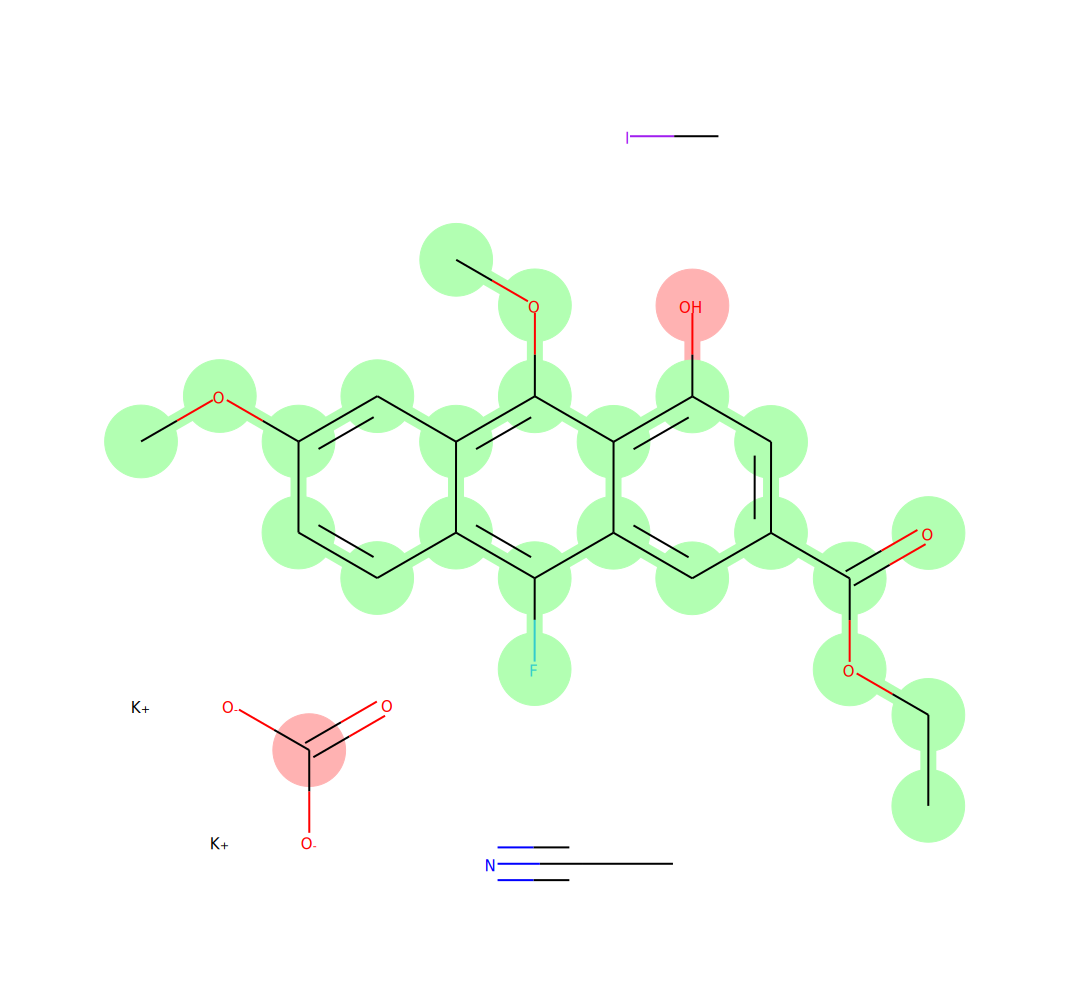

12214
0.13678856


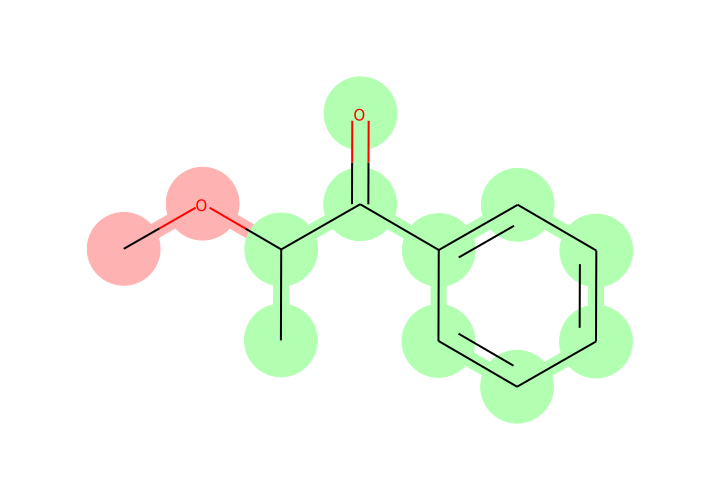

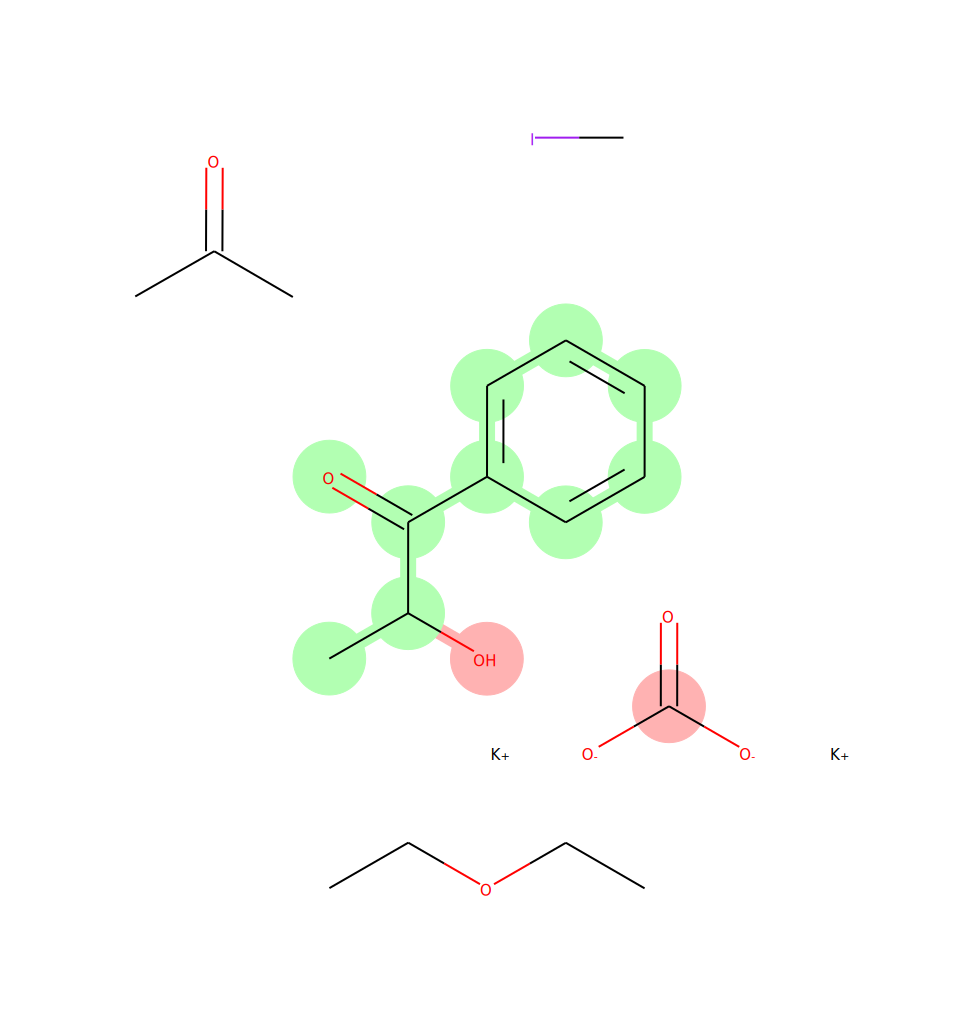

2358
0.8689058


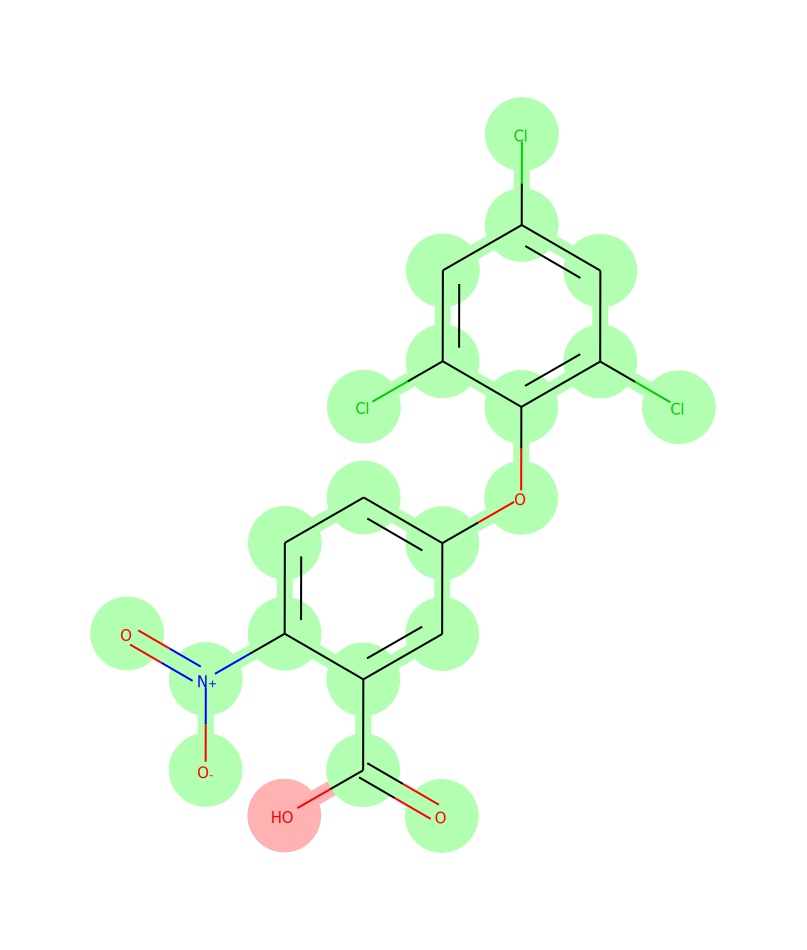

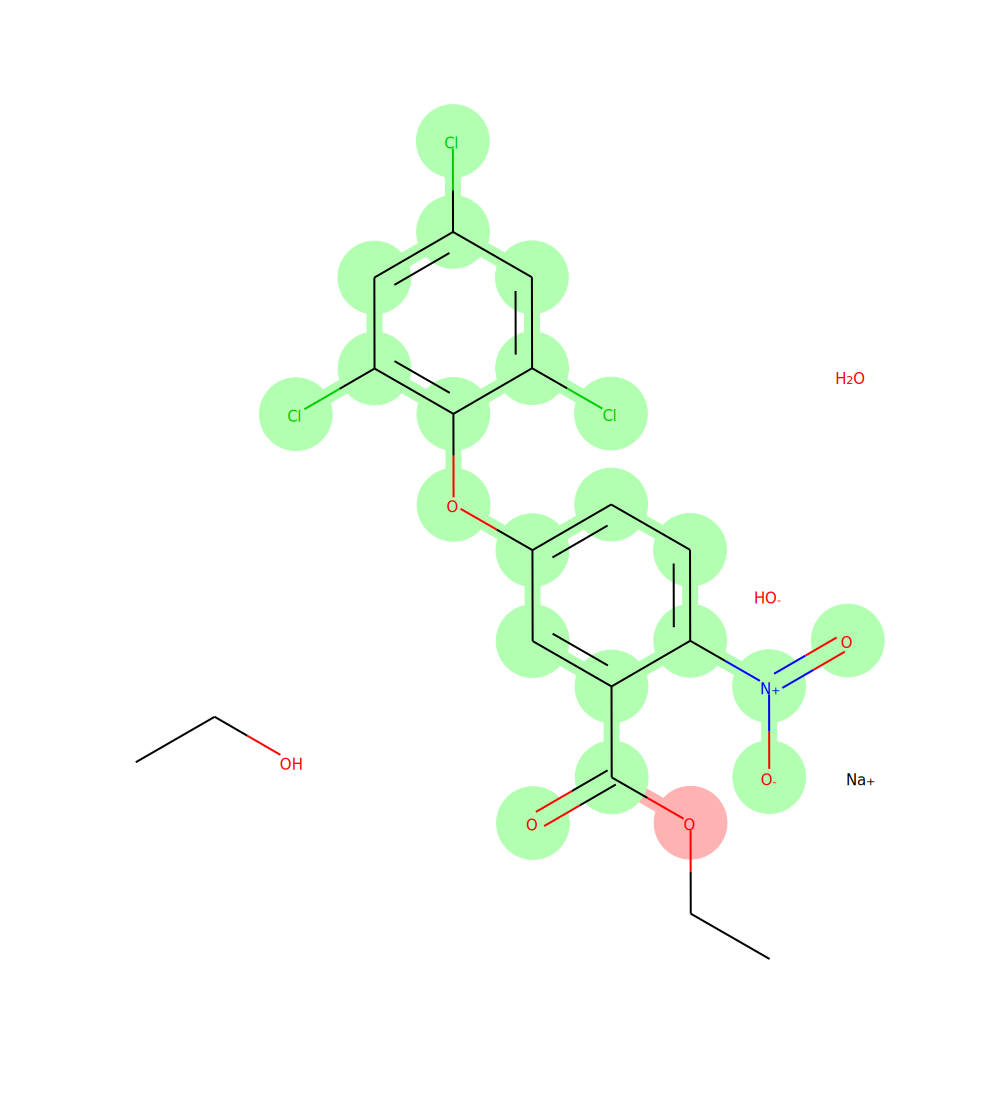

New center
17641
0.086702324


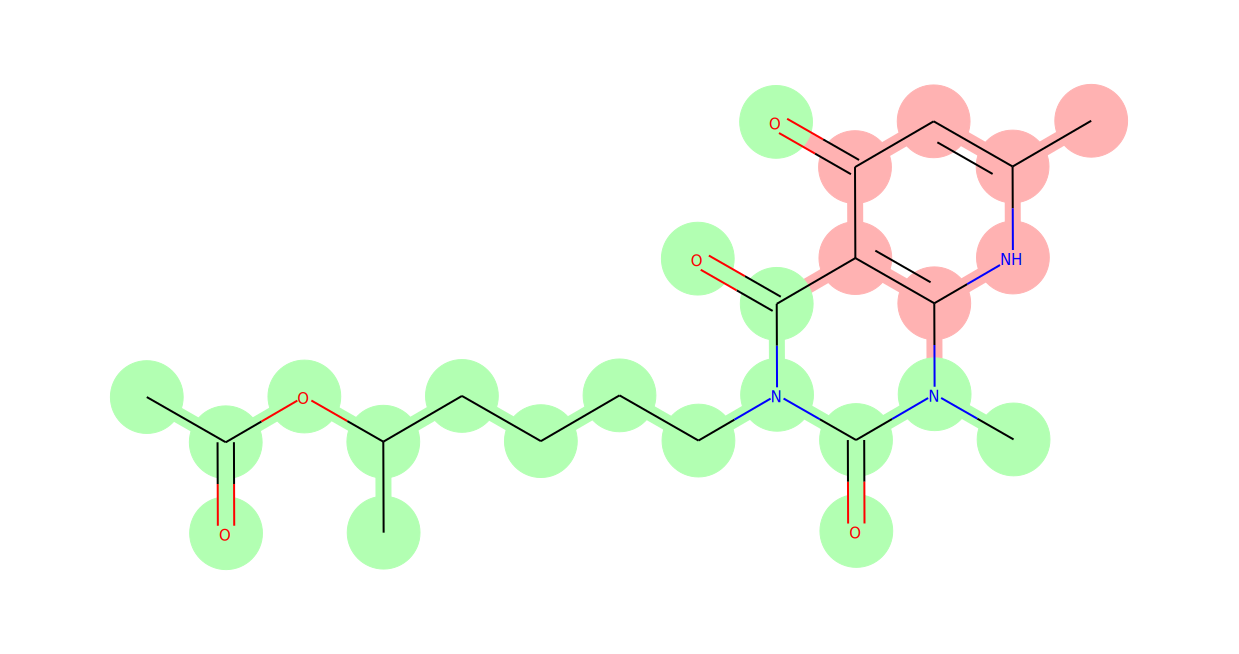

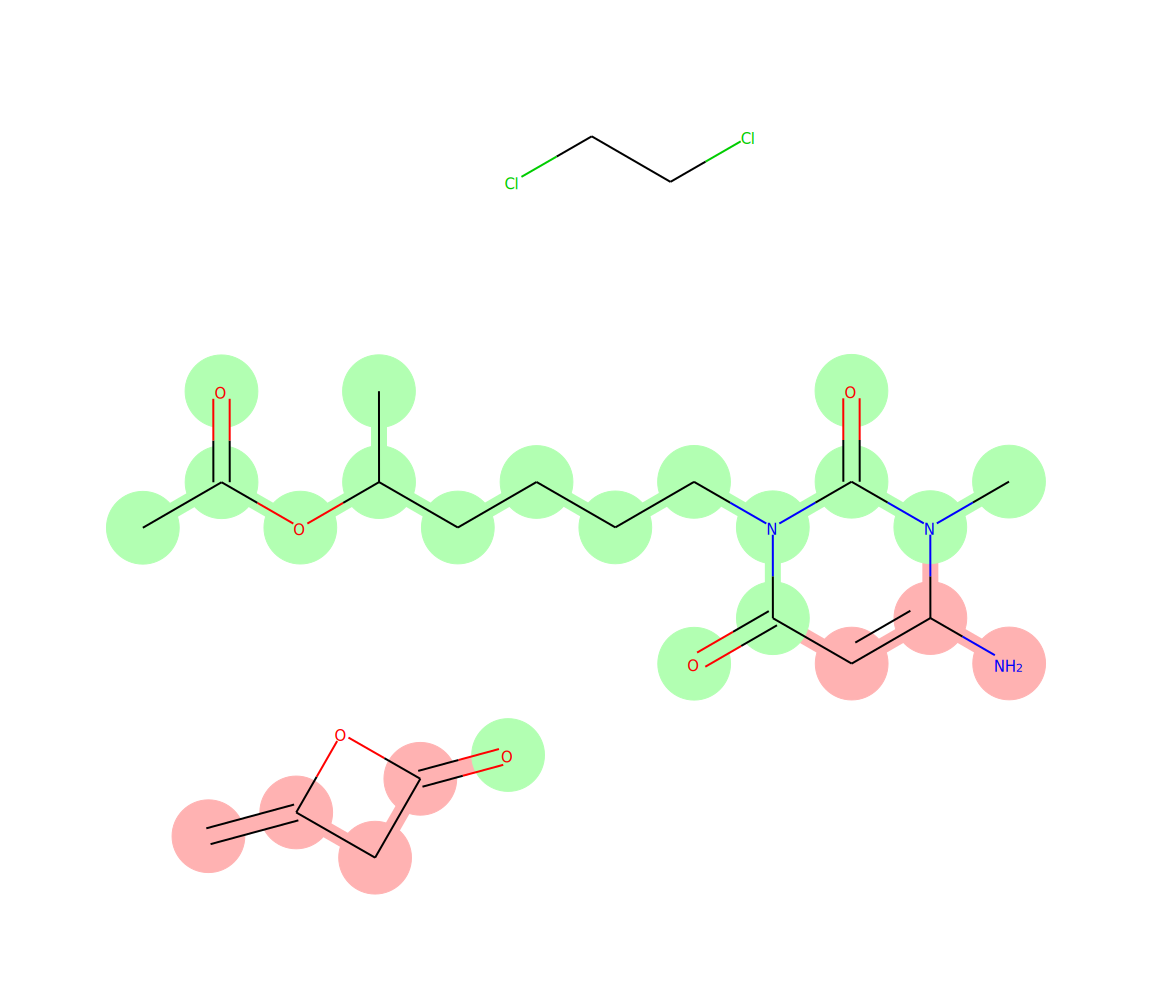

47123
0.08986046


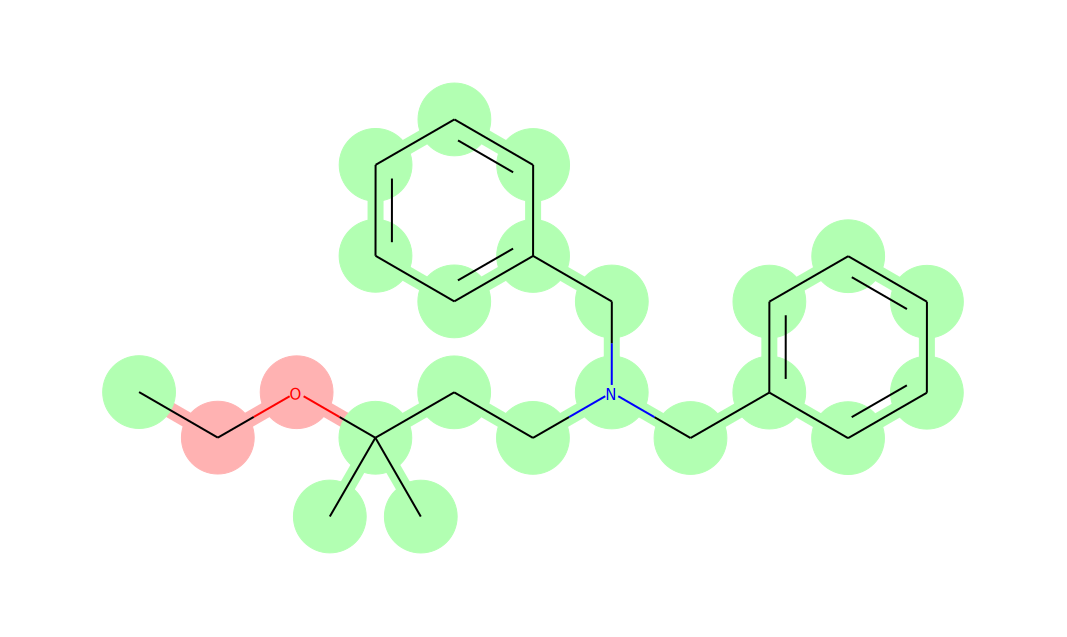

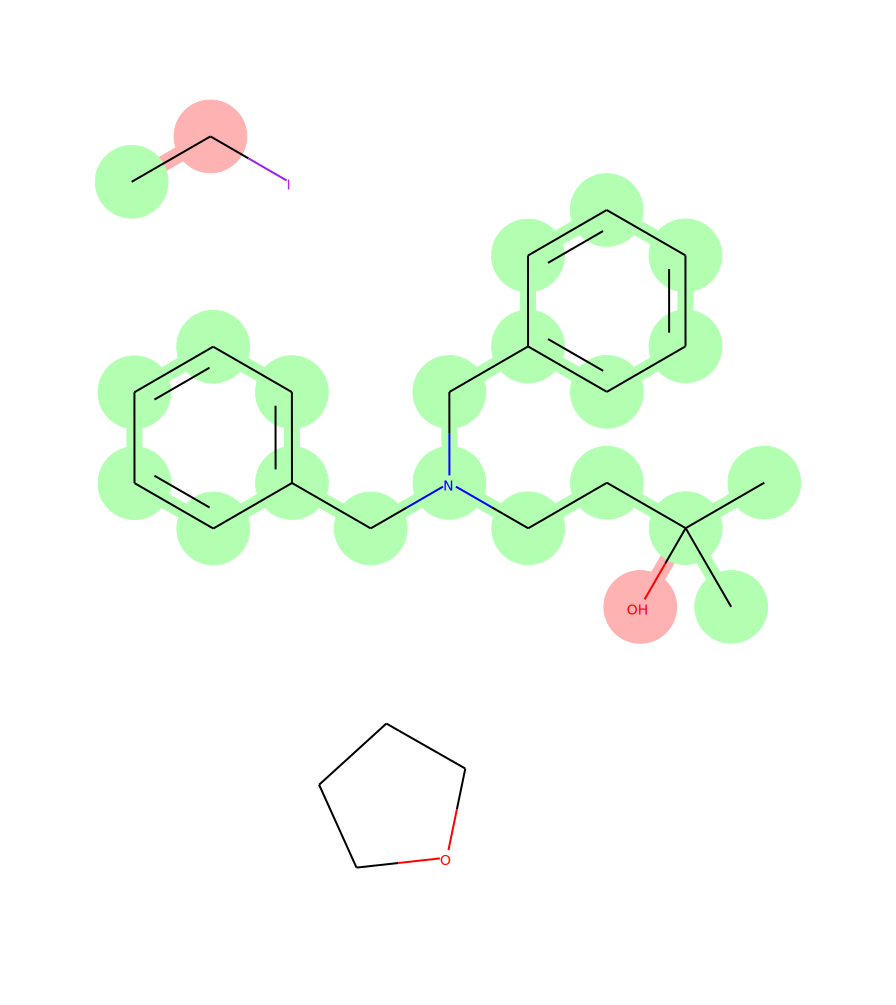

21473
0.09618287


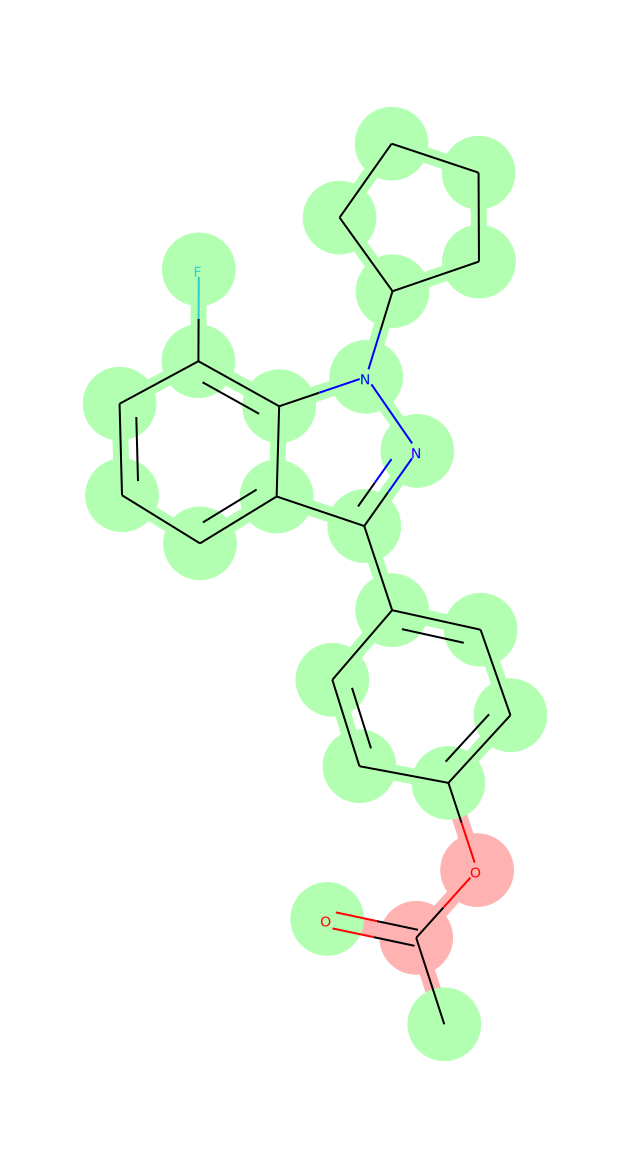

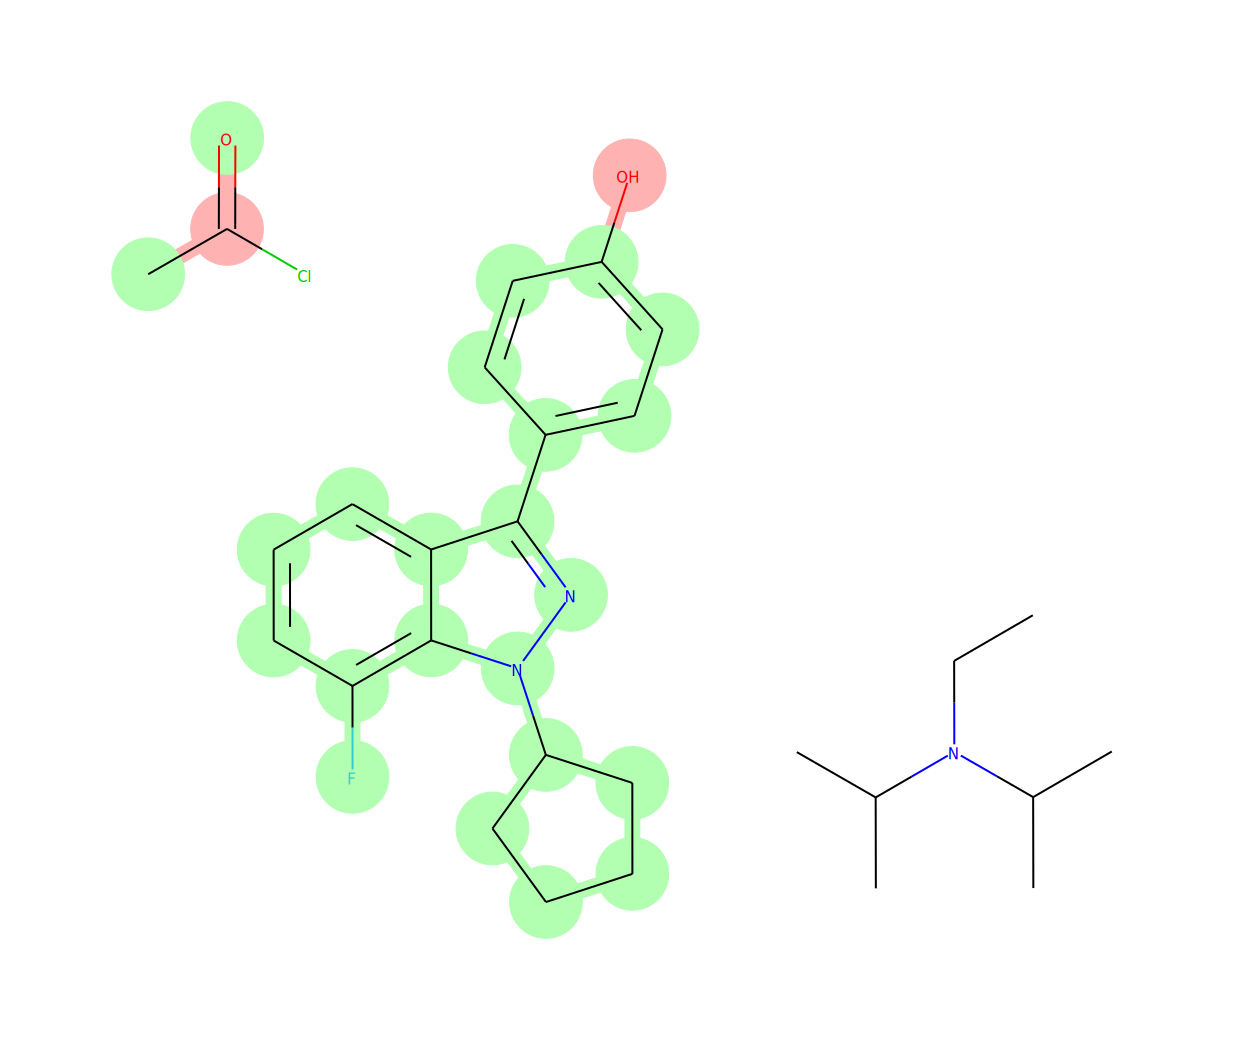

3817
0.1388908


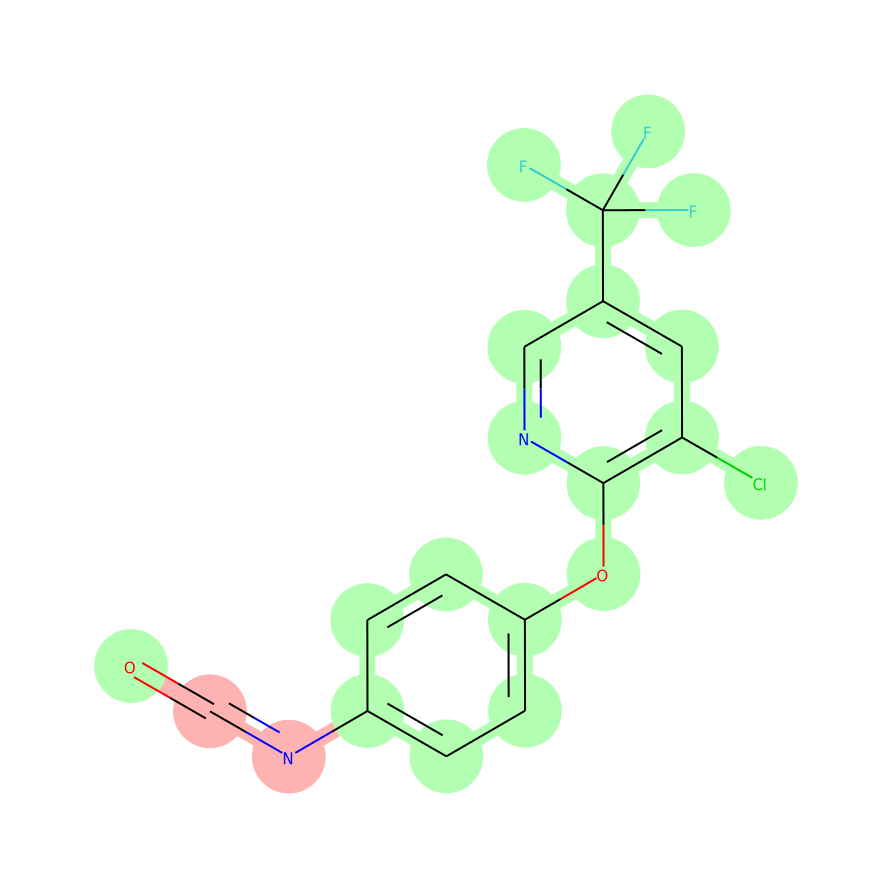

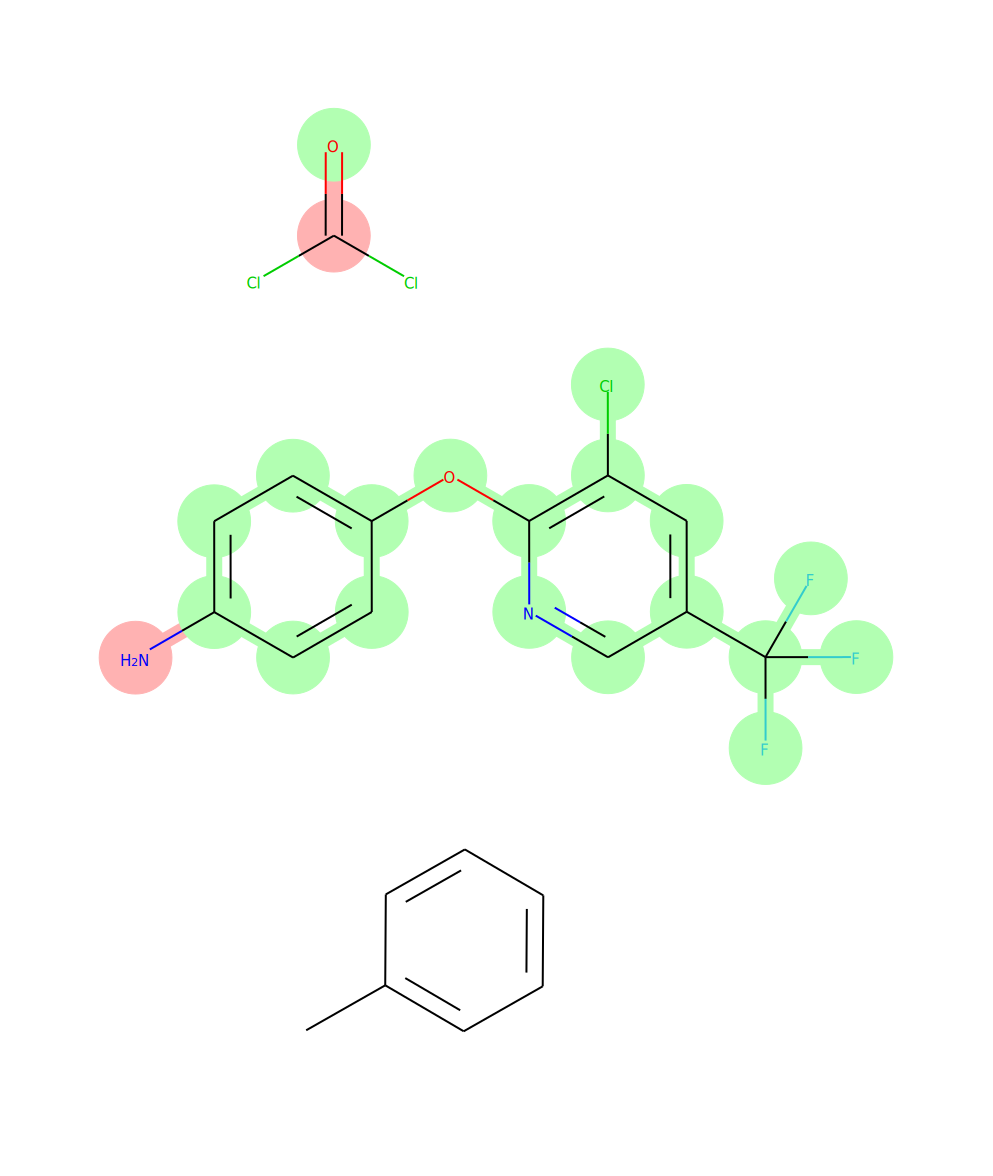

36734
0.88408476


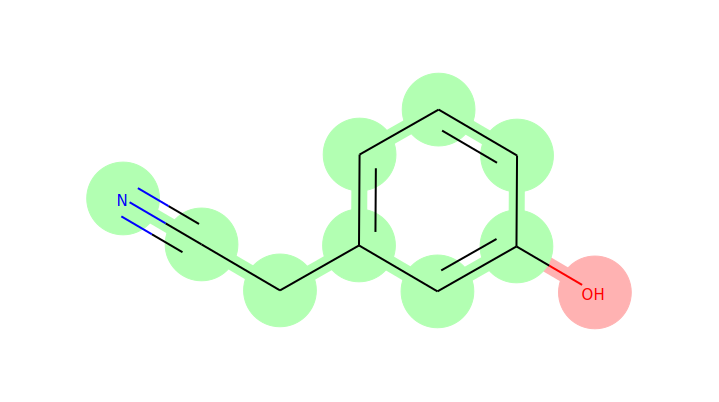

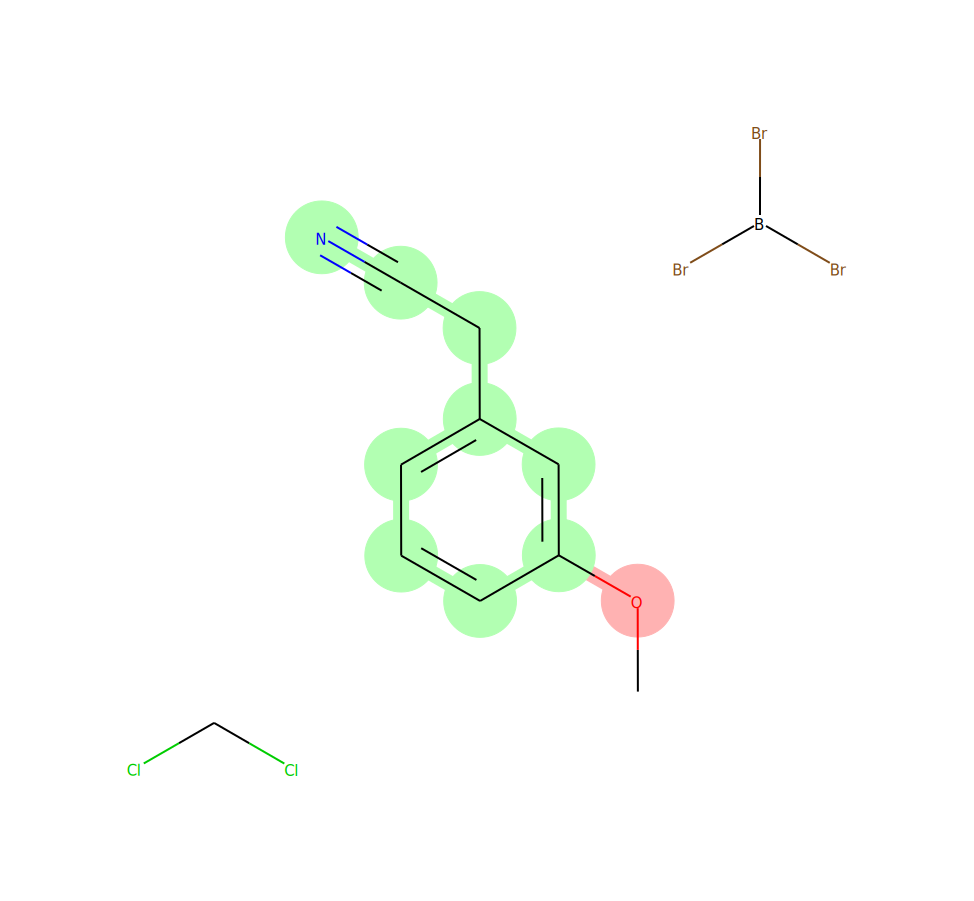

New center
19362
0.09107459


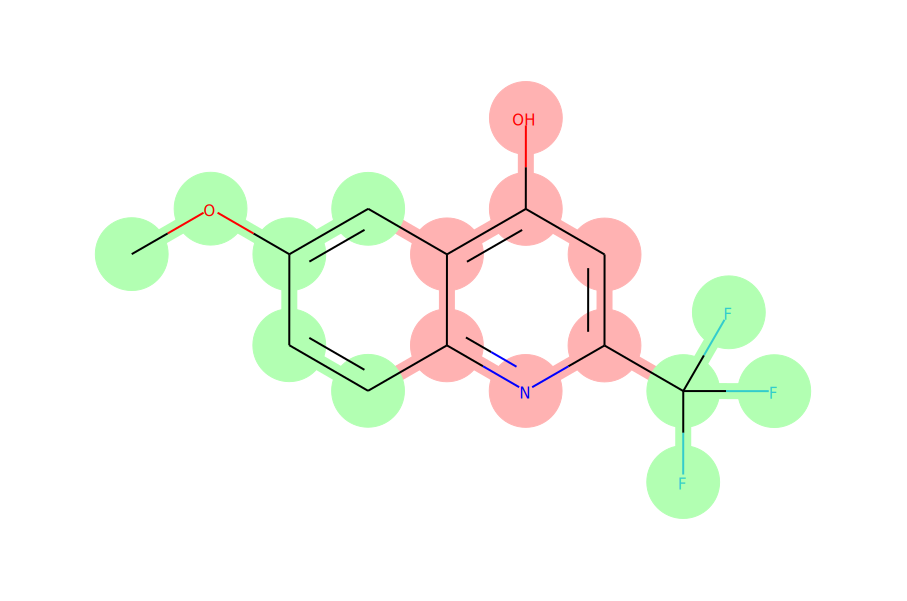

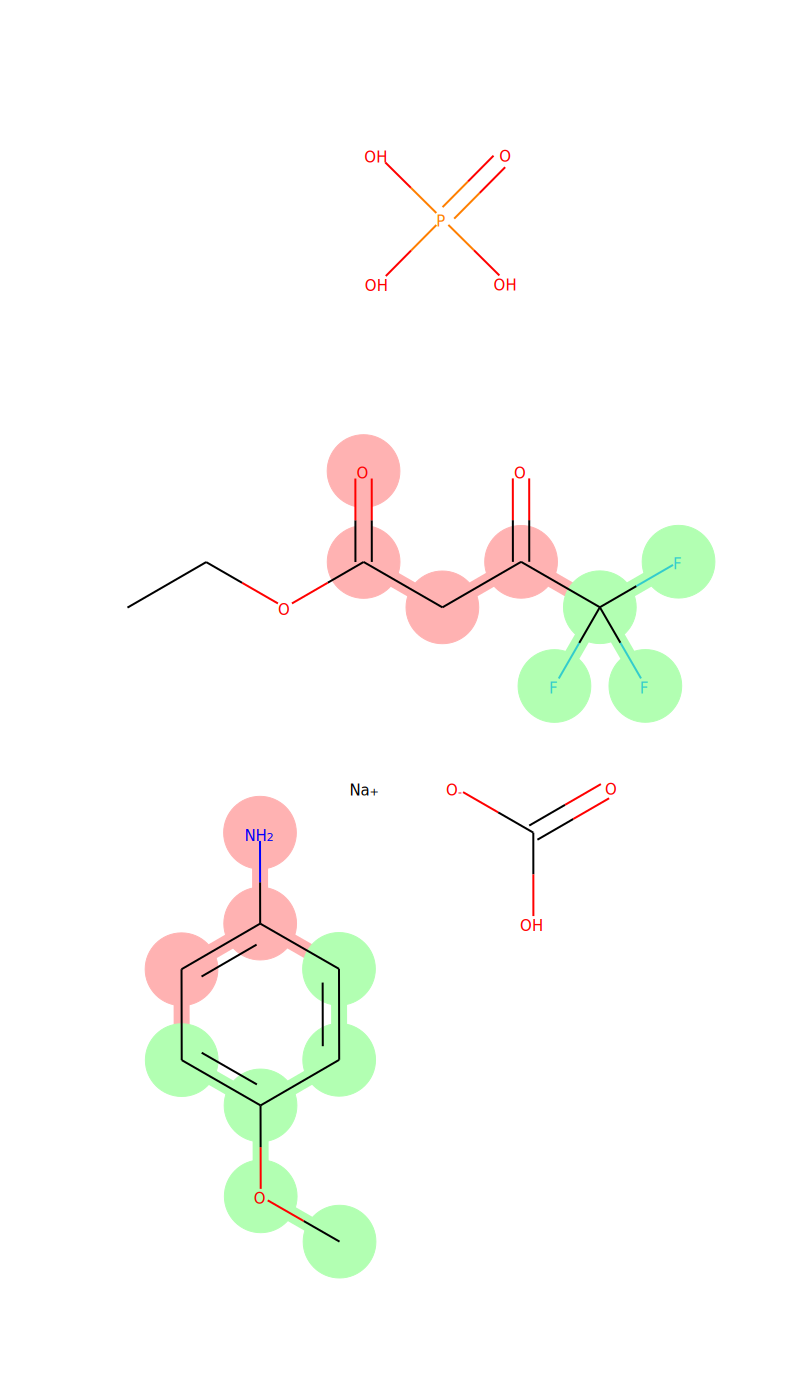

9389
0.10819419


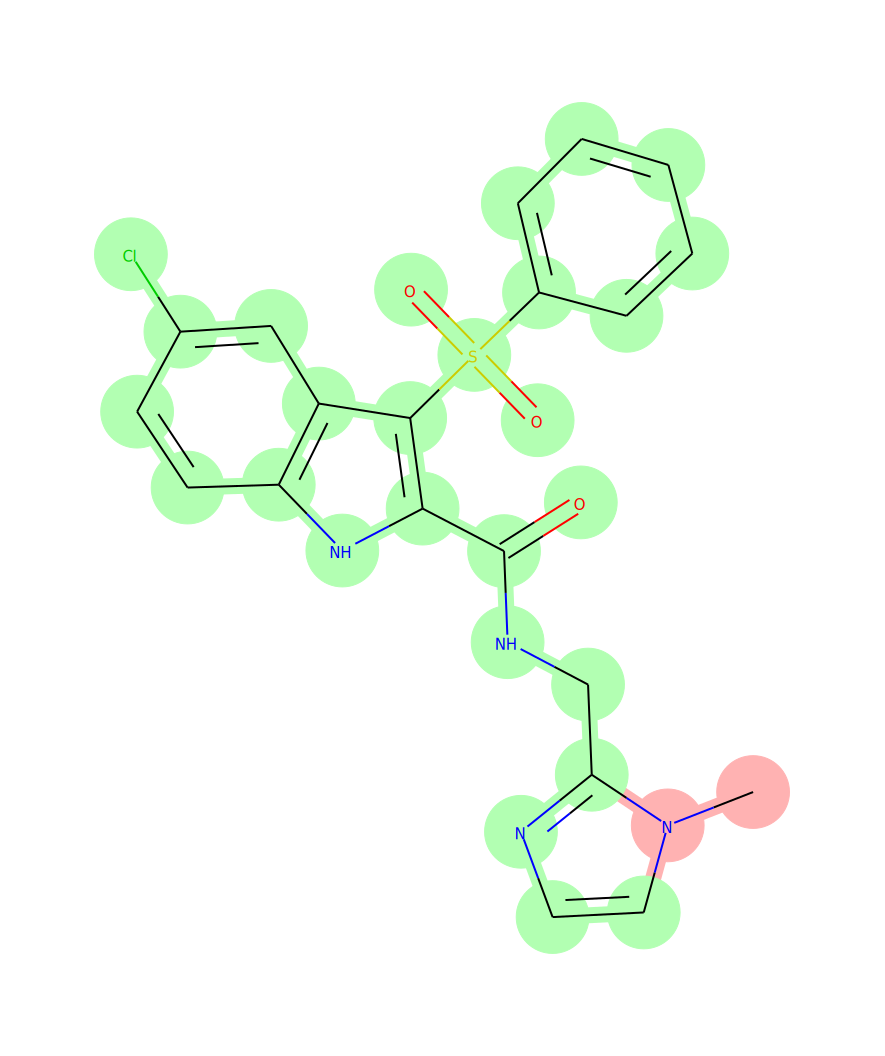

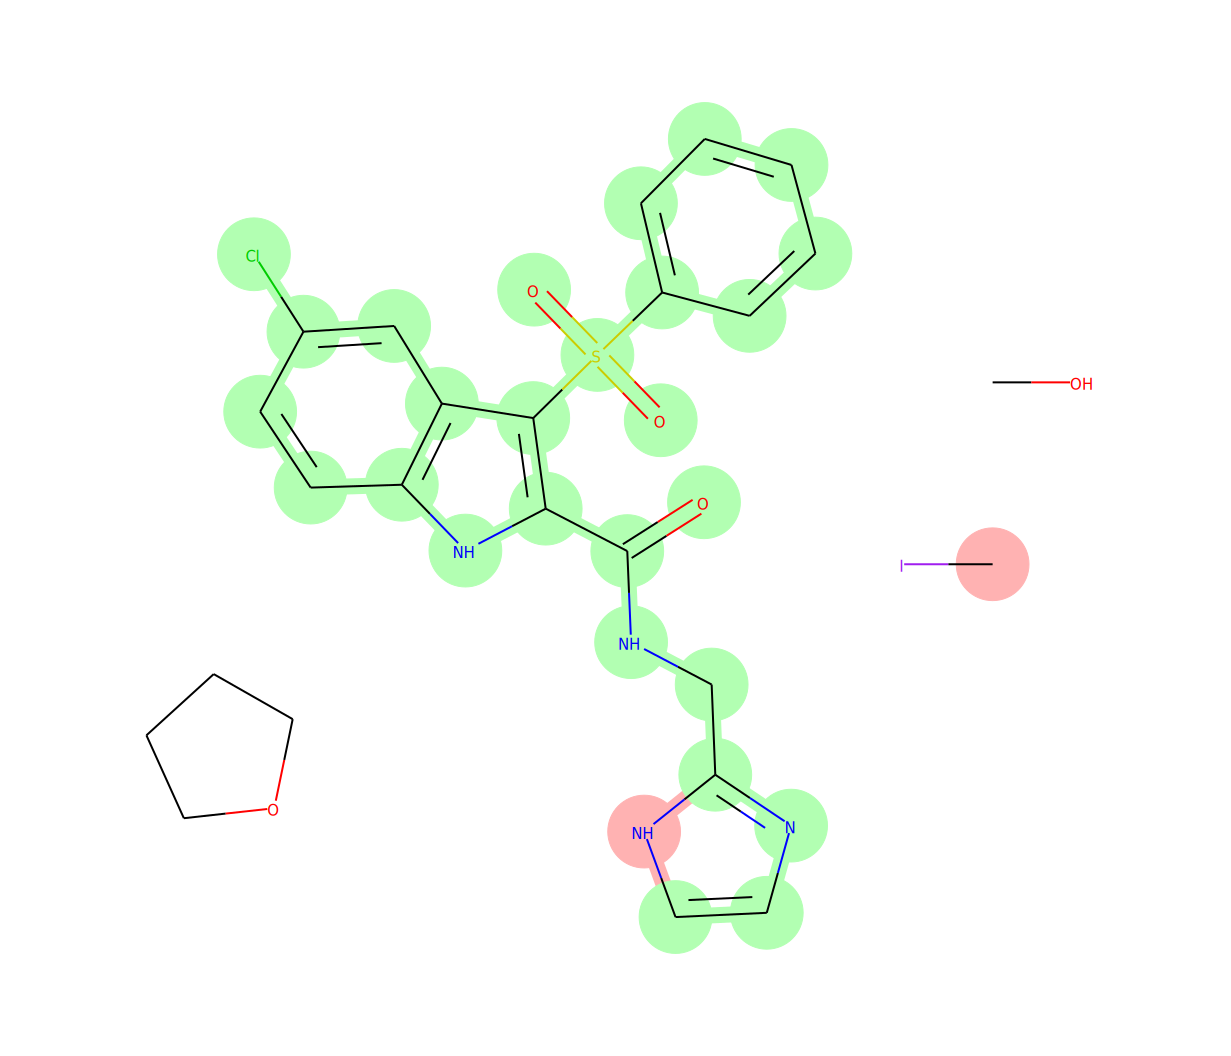

19241
0.11129547


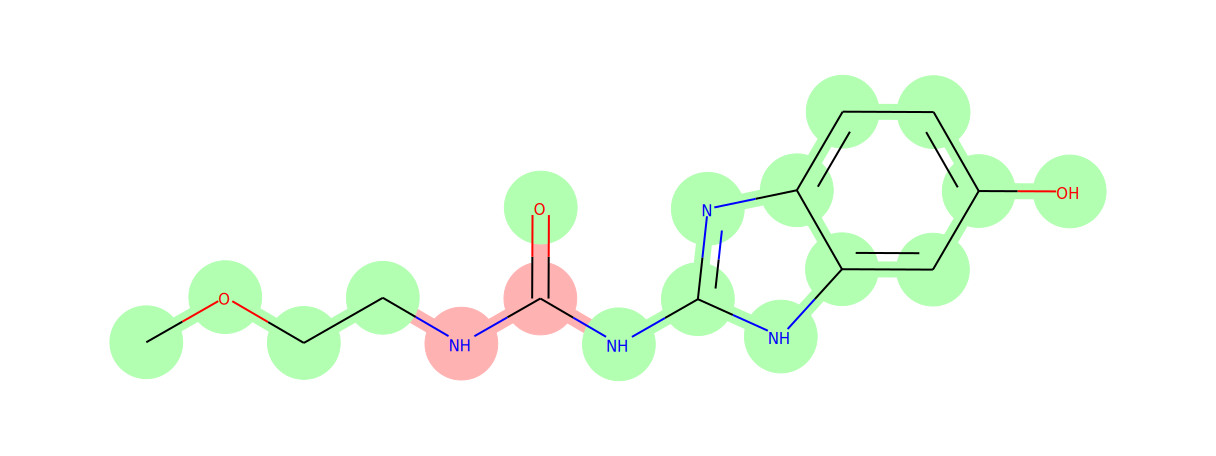

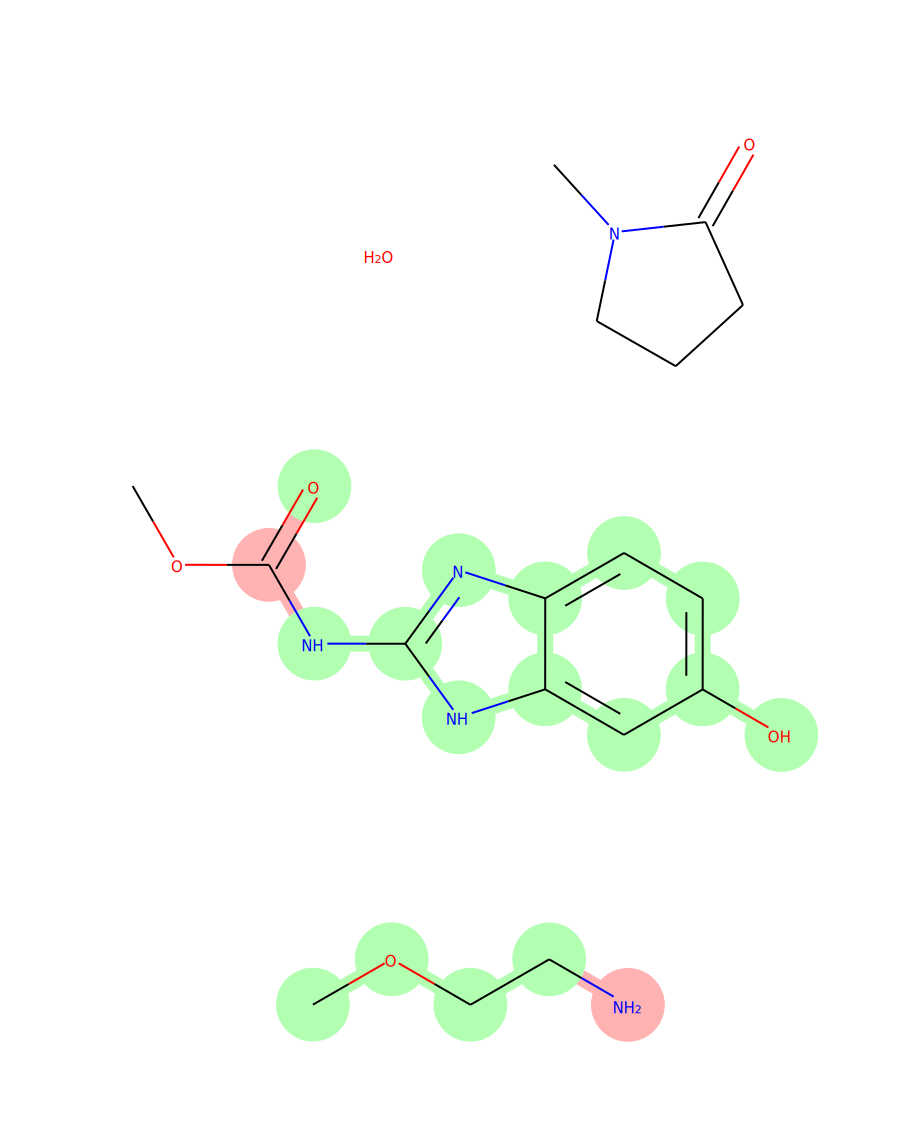

31490
0.1745431


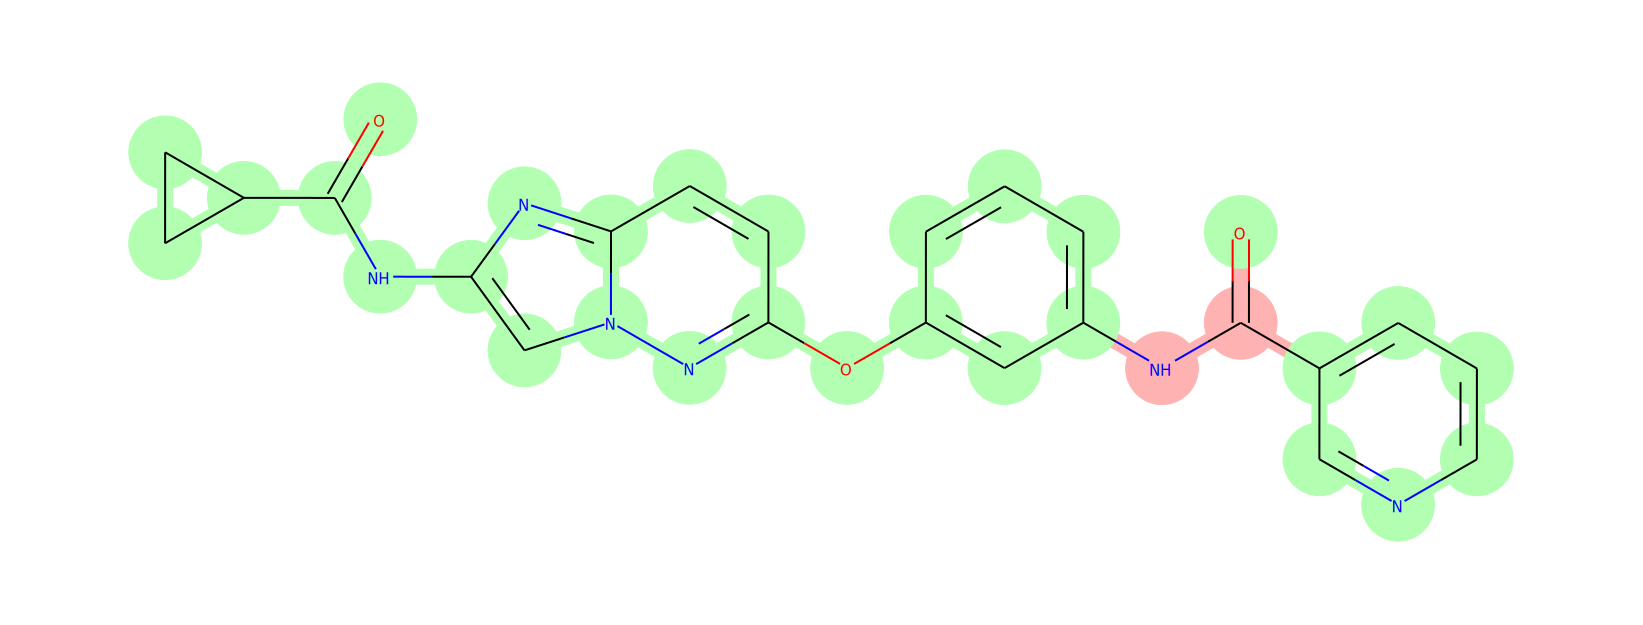

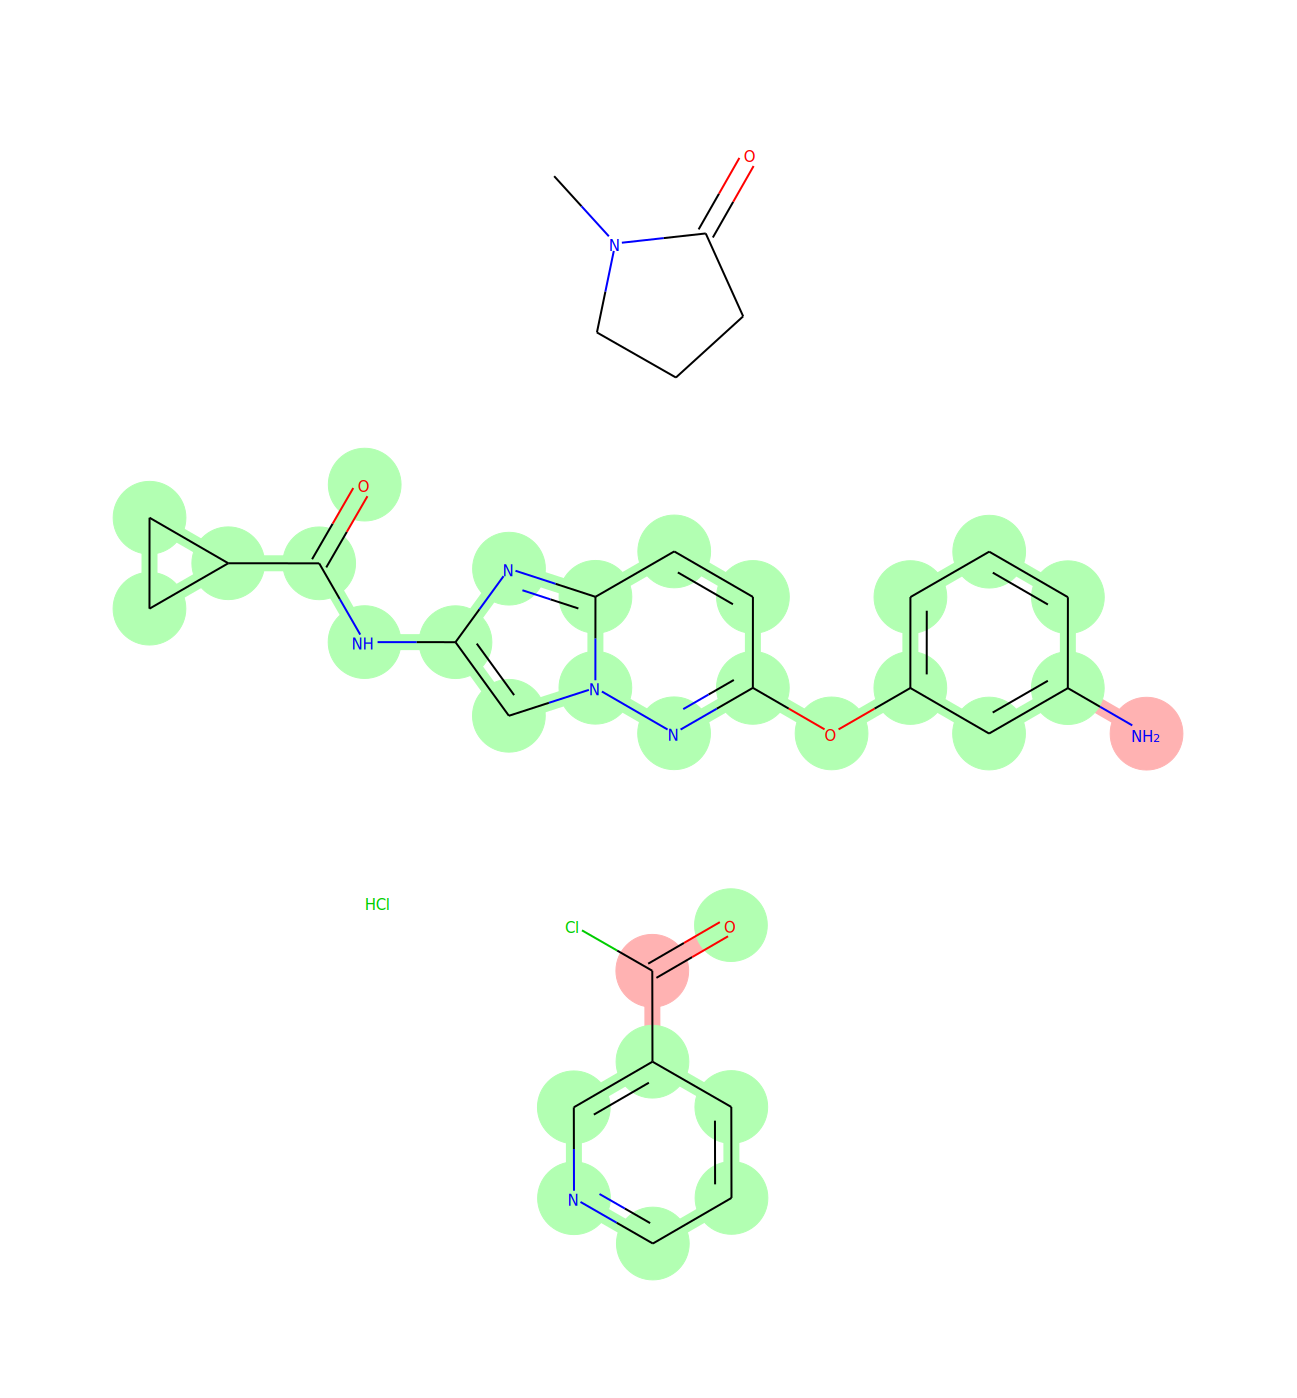

3771
0.84373516


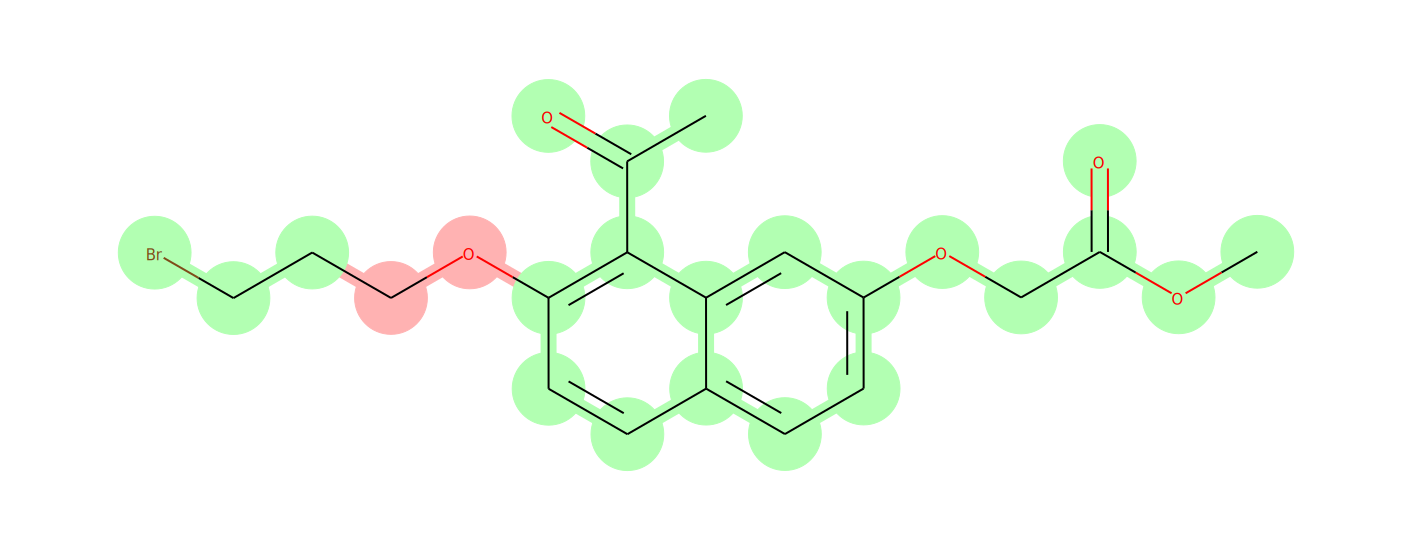

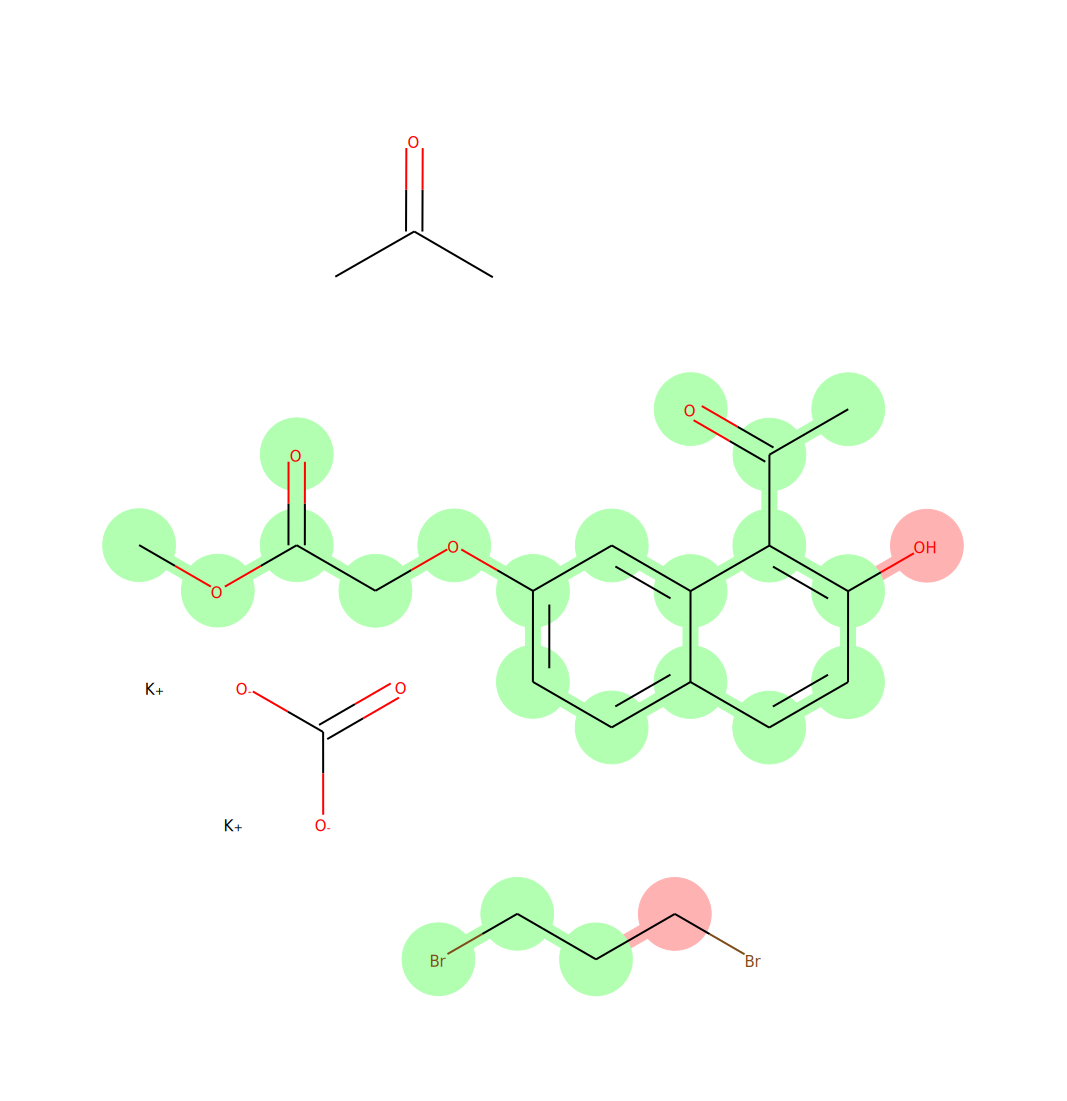

New center
23405
0.11538176


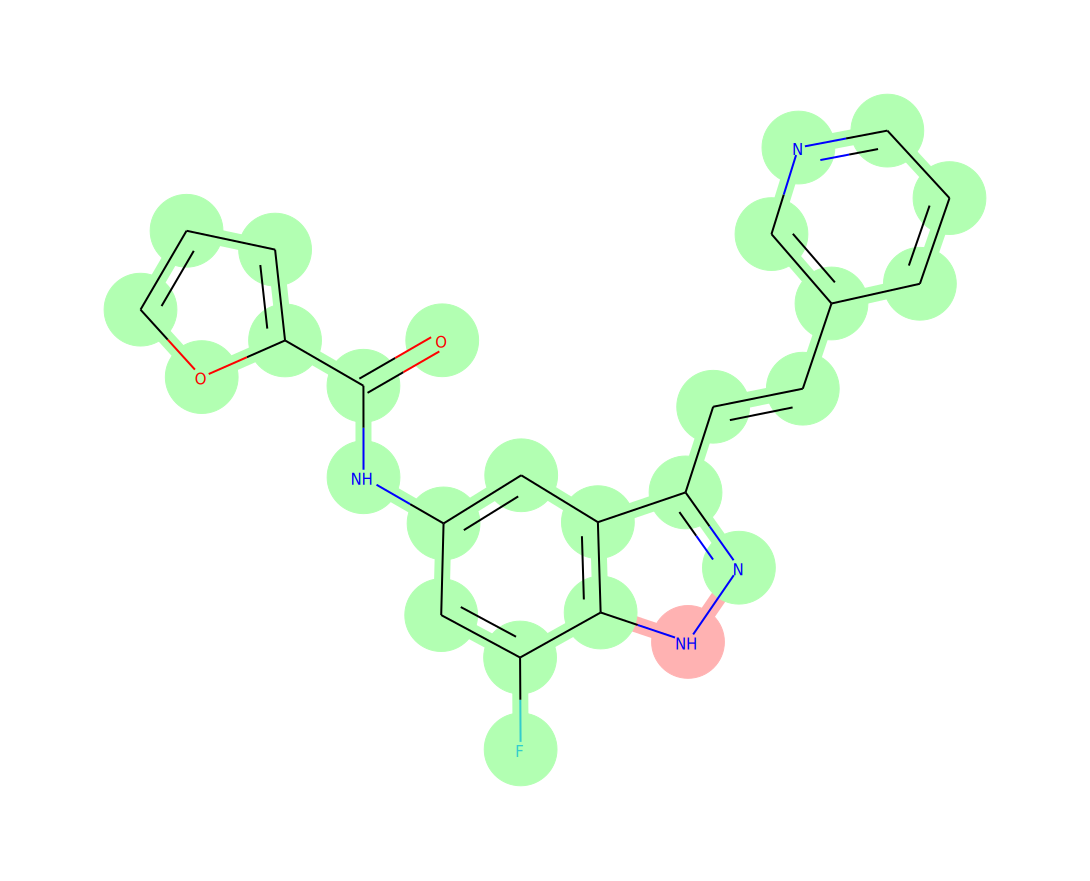

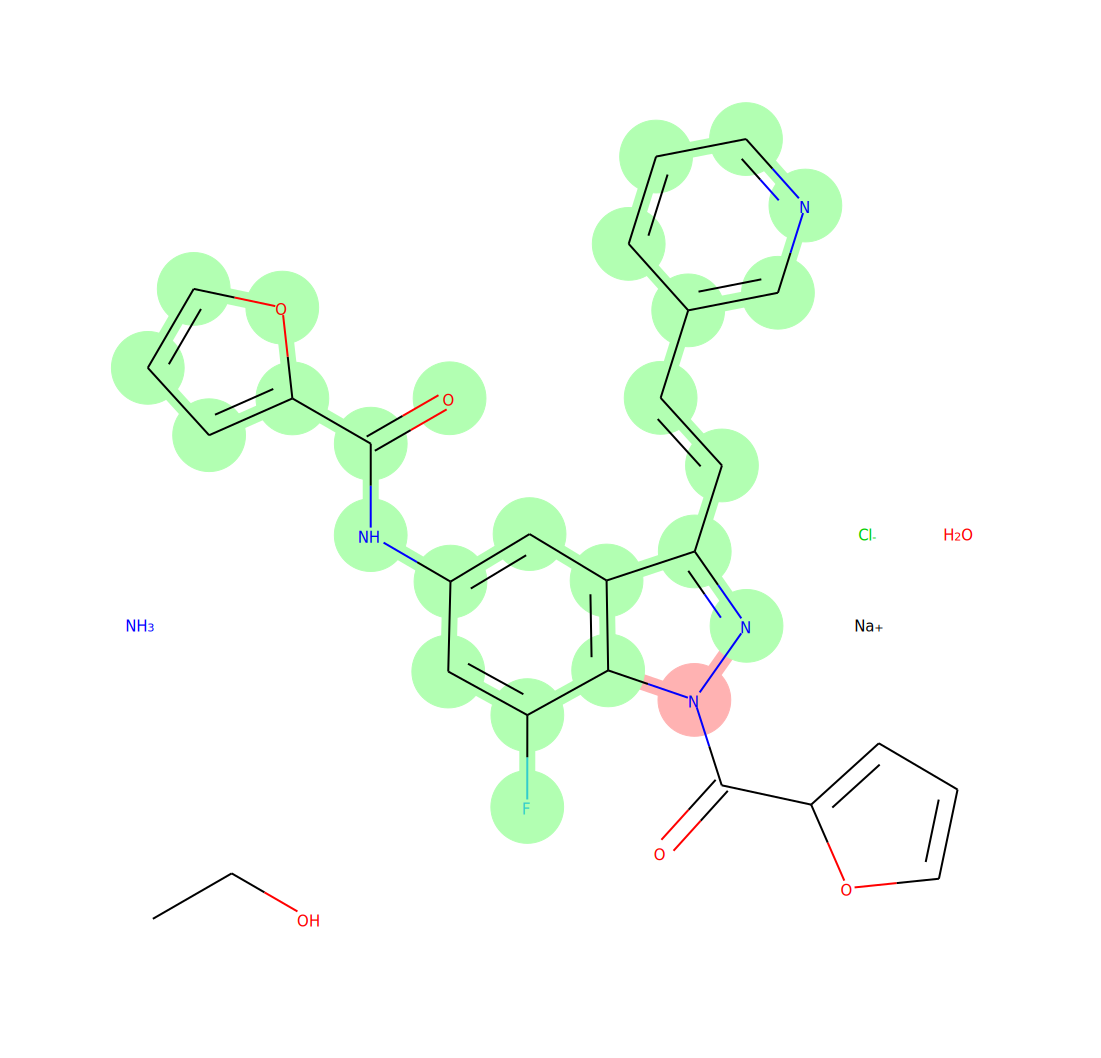

11376
0.13329086


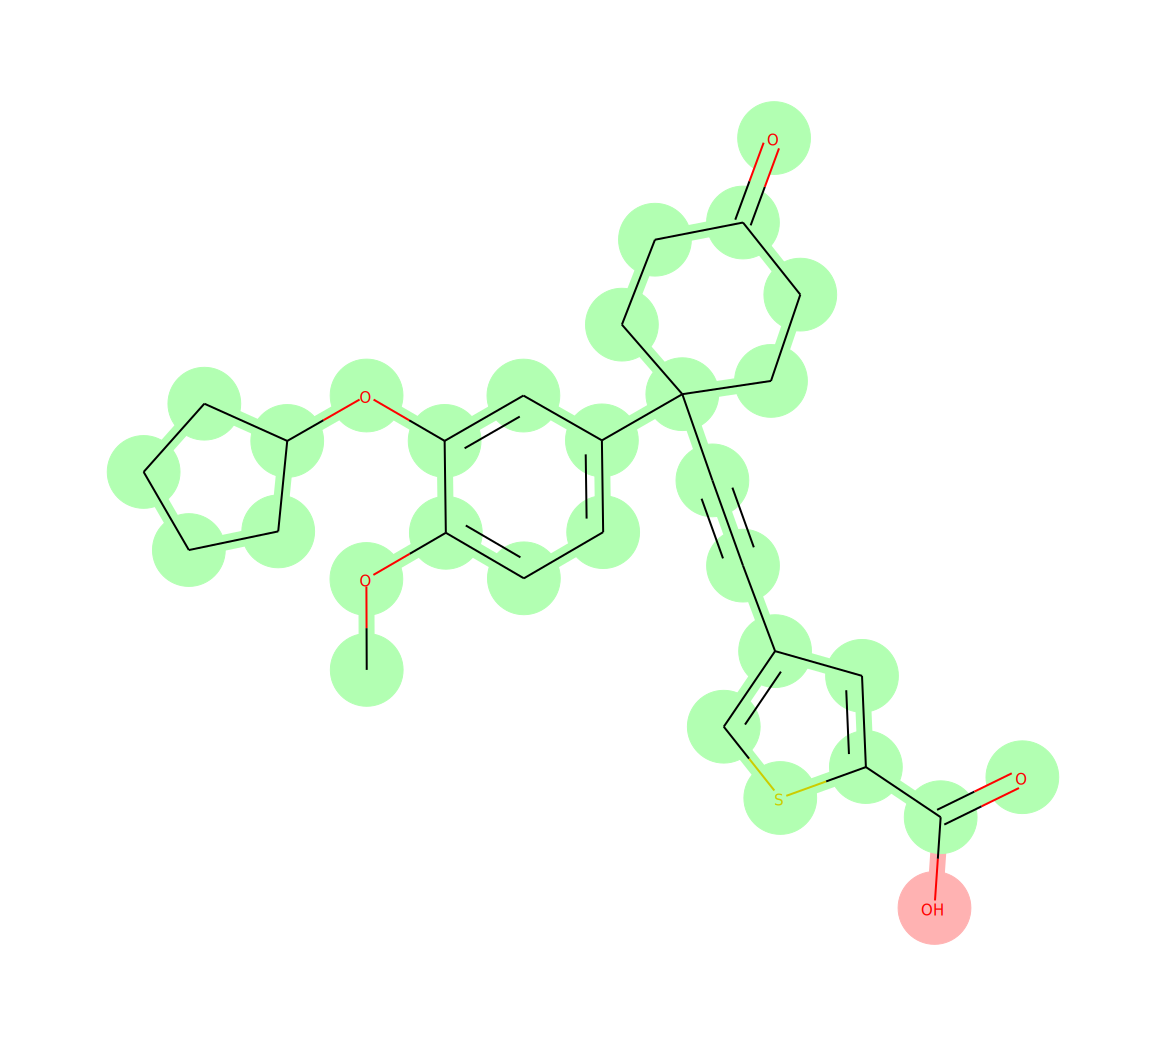

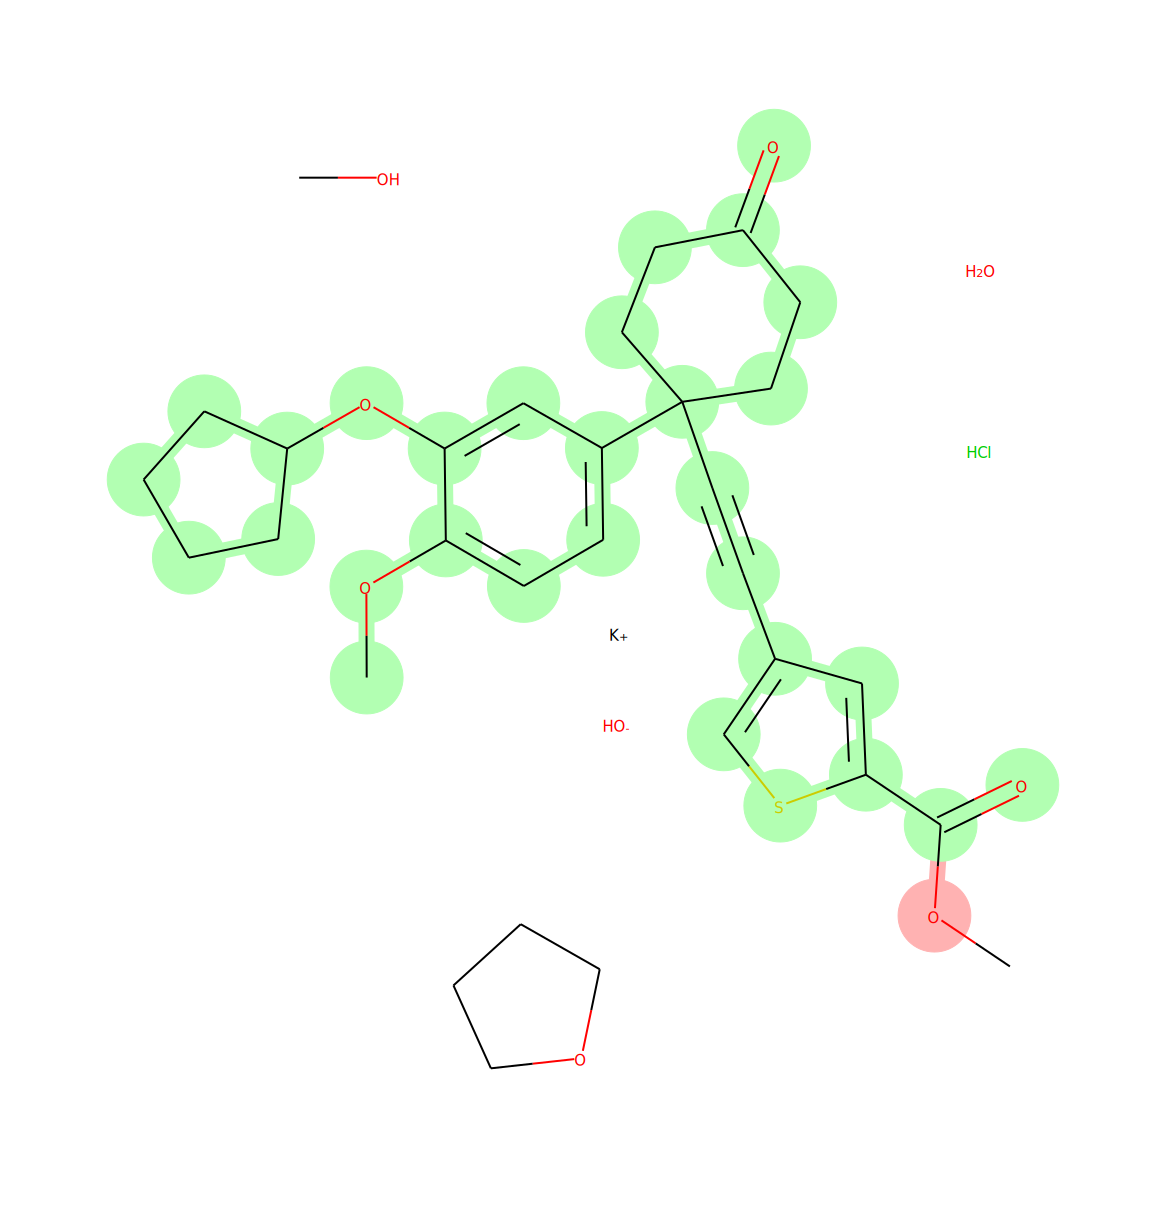

1624
0.13352221


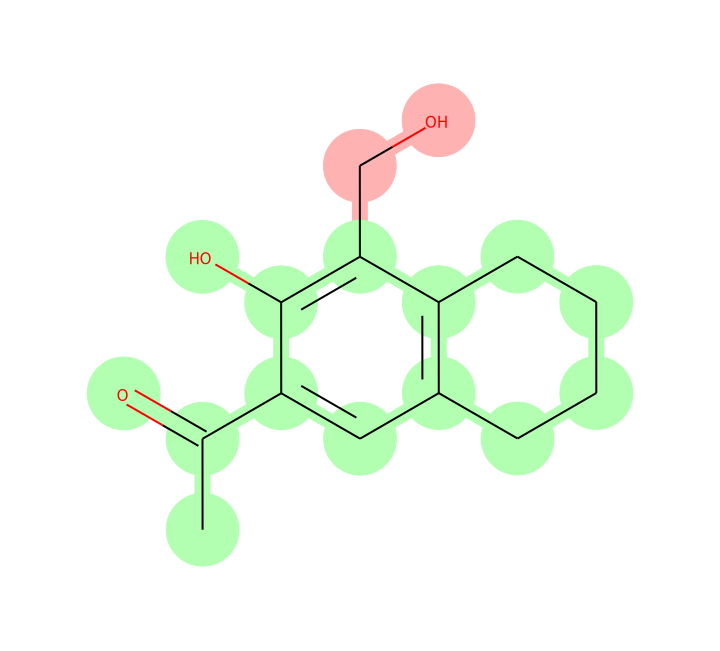

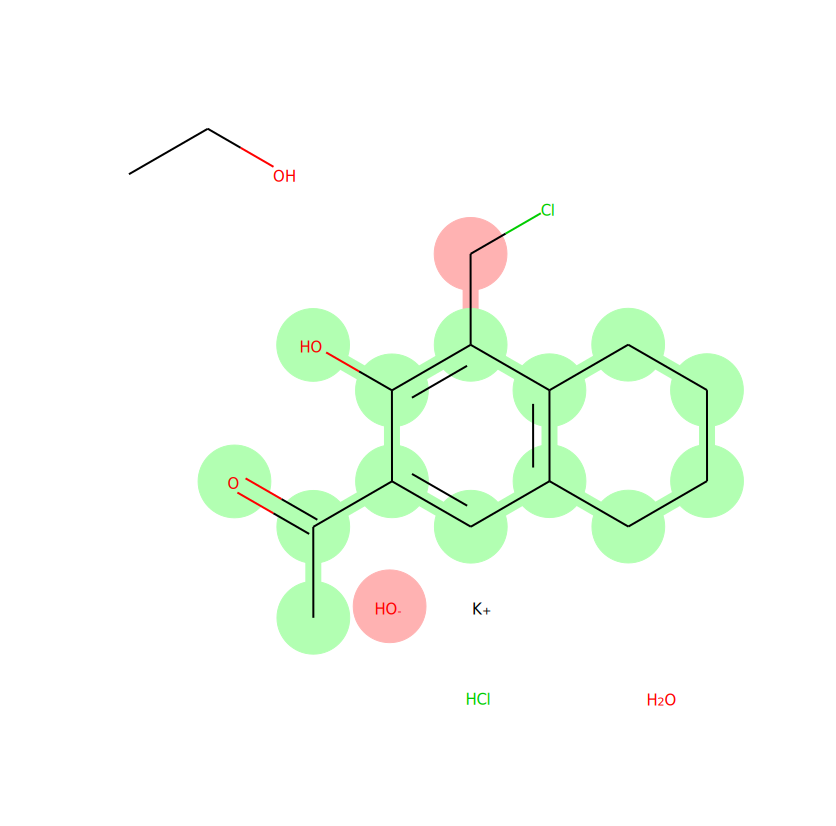

21438
0.19083373


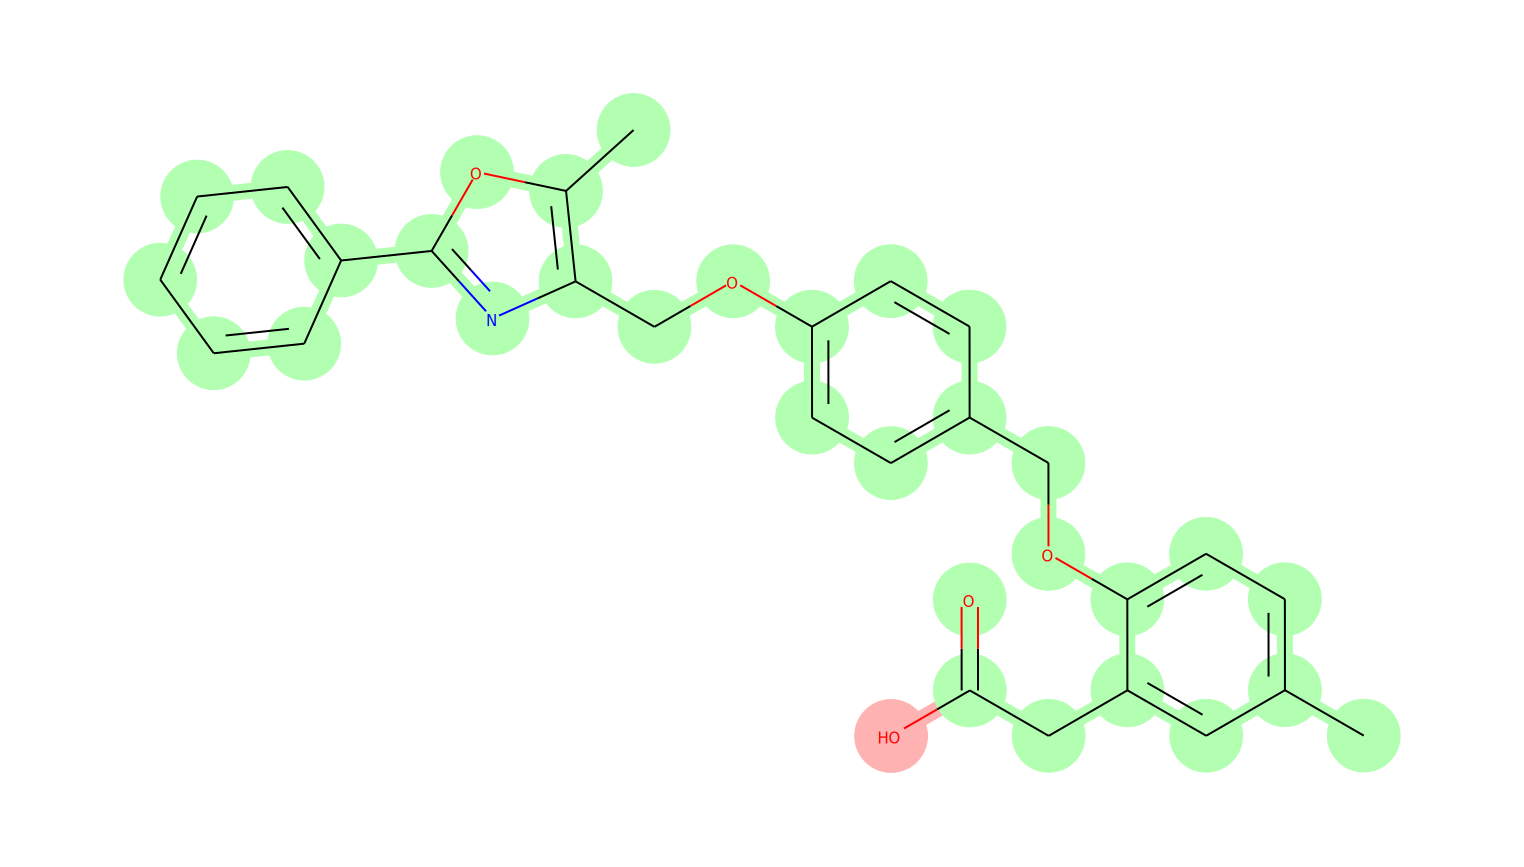

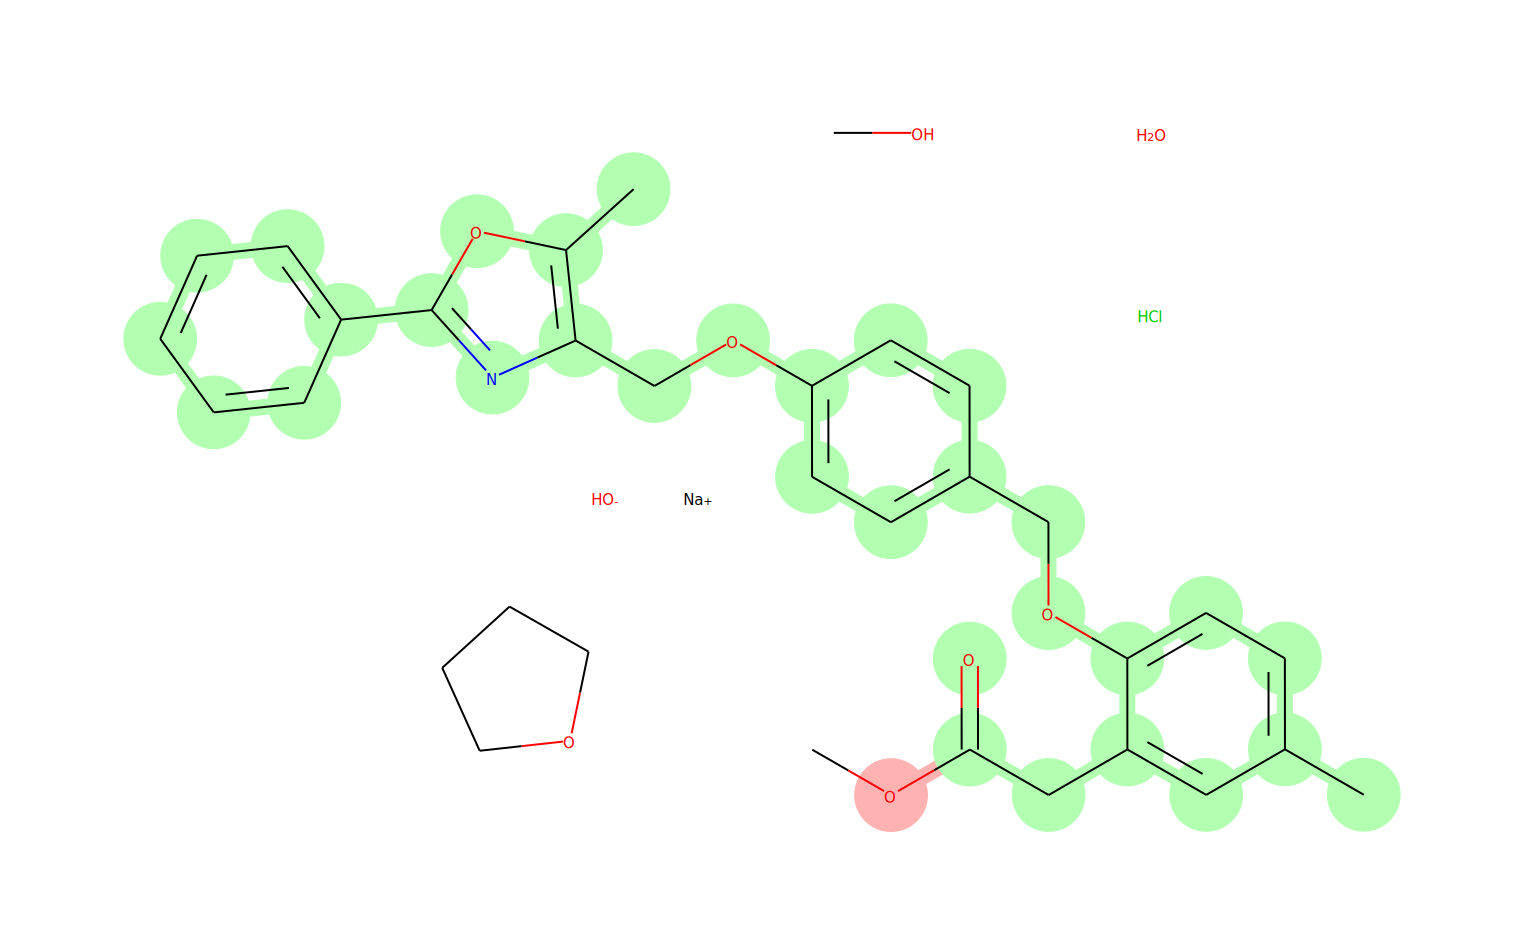

4550
1.5840613


RDKit WARNING: [13:32:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:32:32] WARNING: not removing hydrogen atom without neighbors


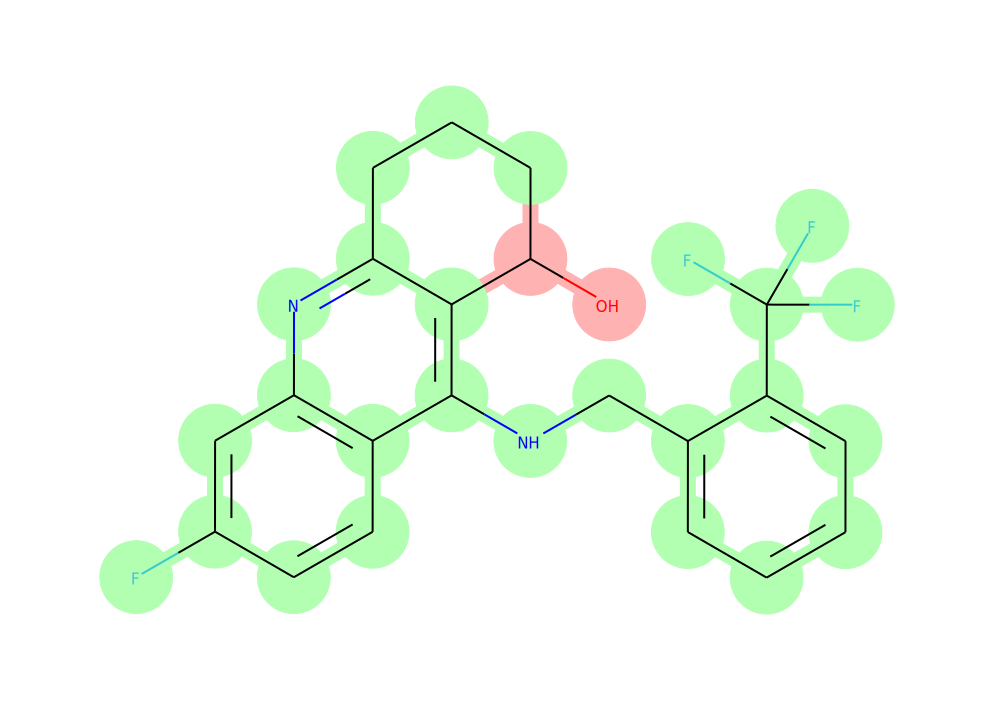

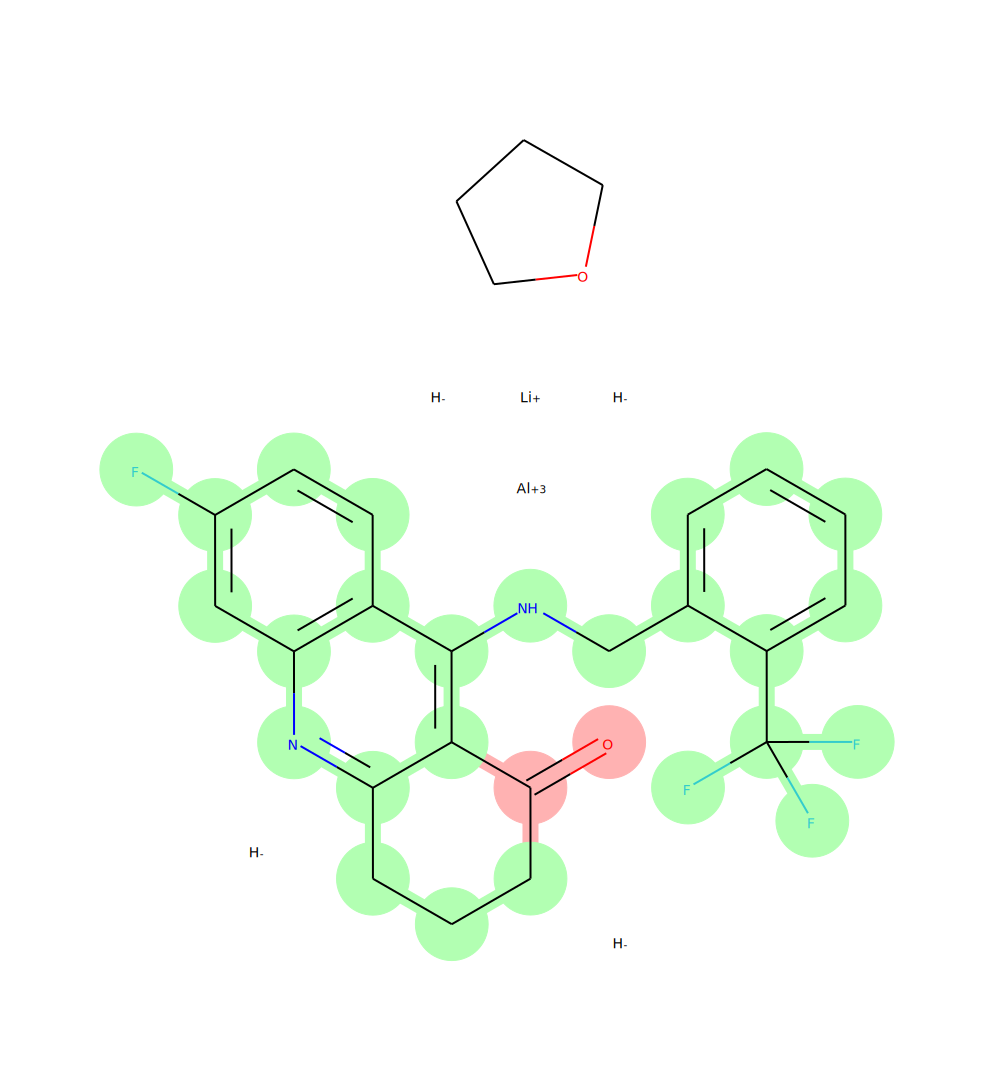

New center
4012
0.07261795


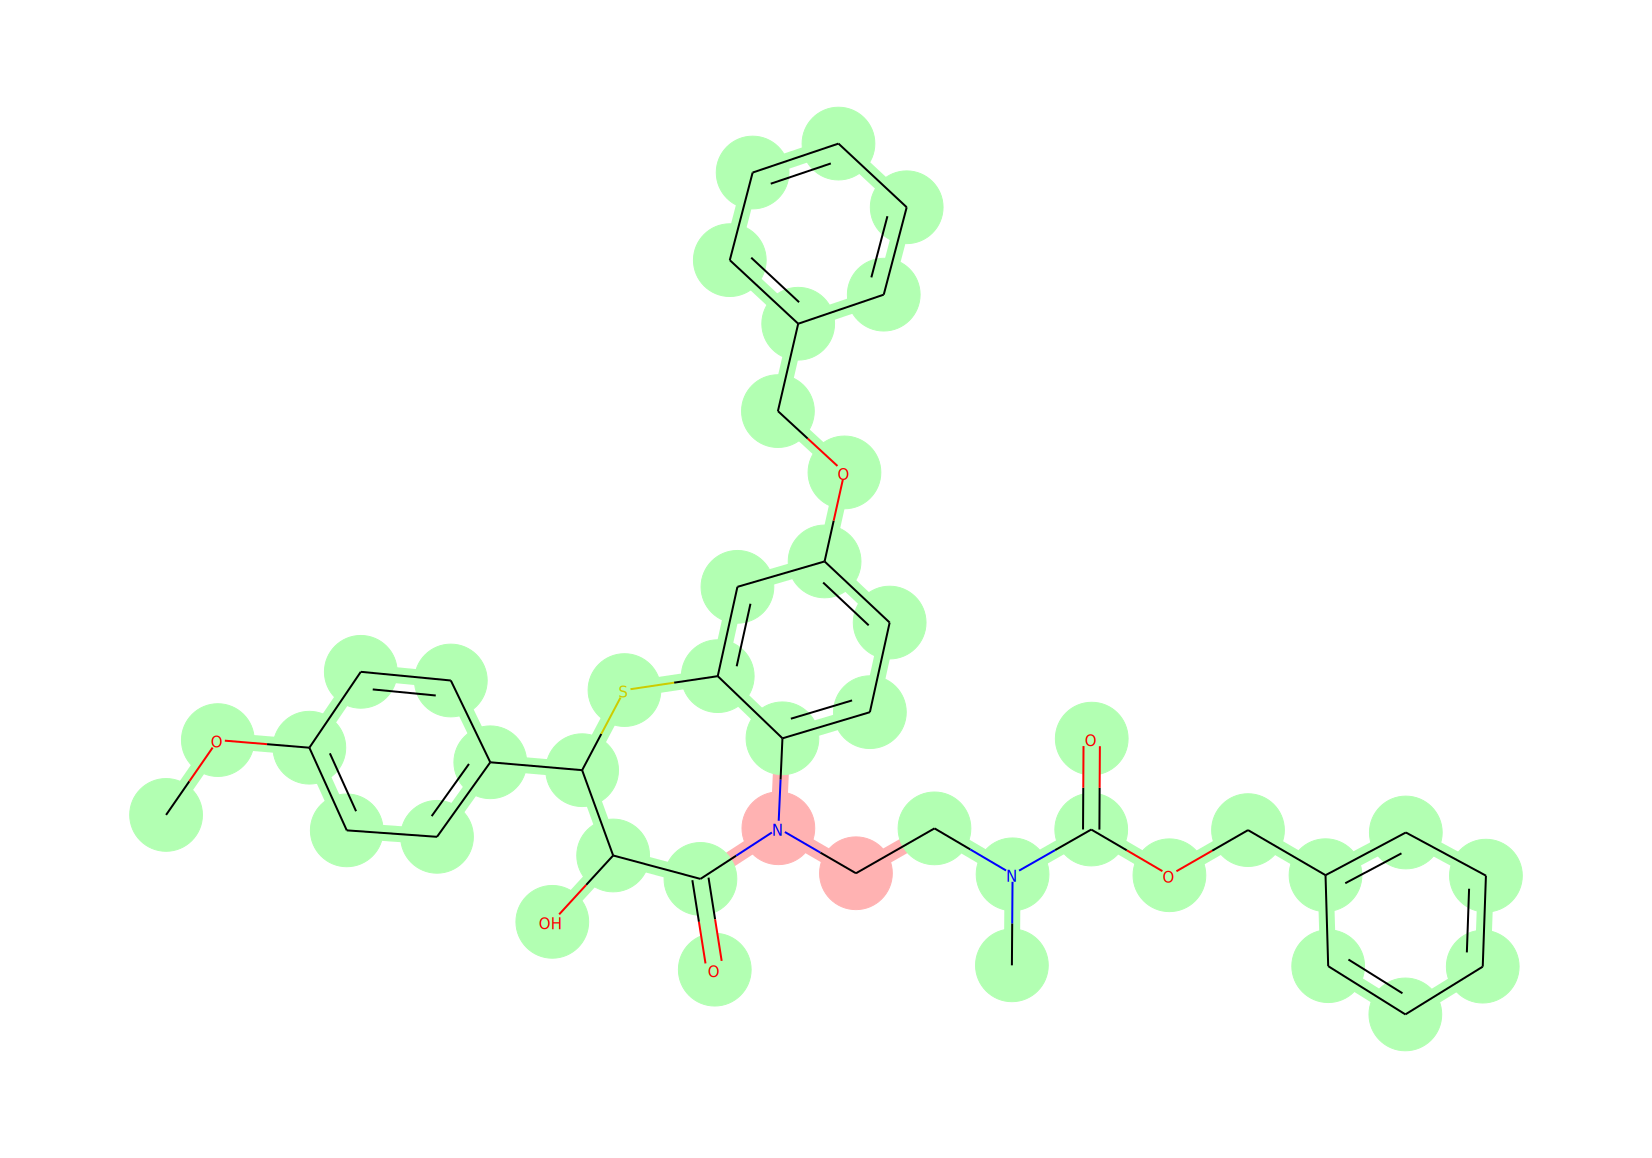

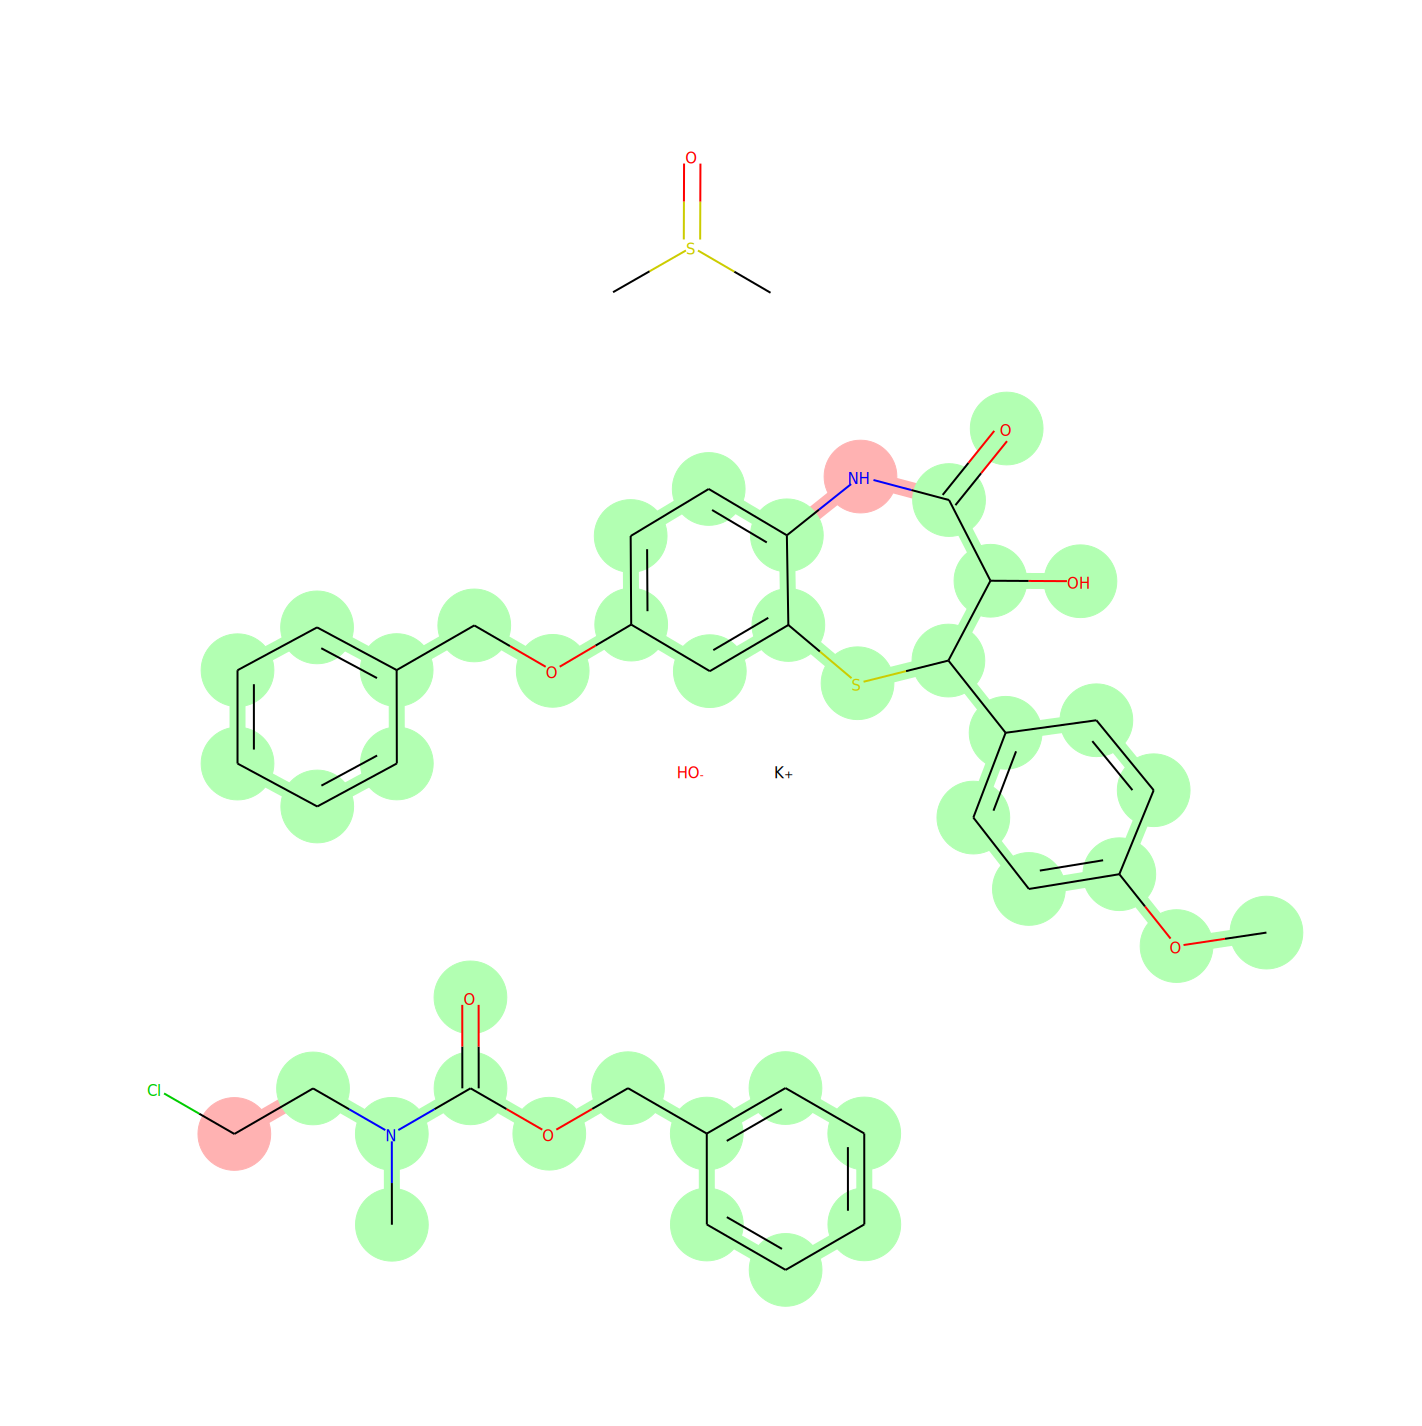

13462
0.087826446


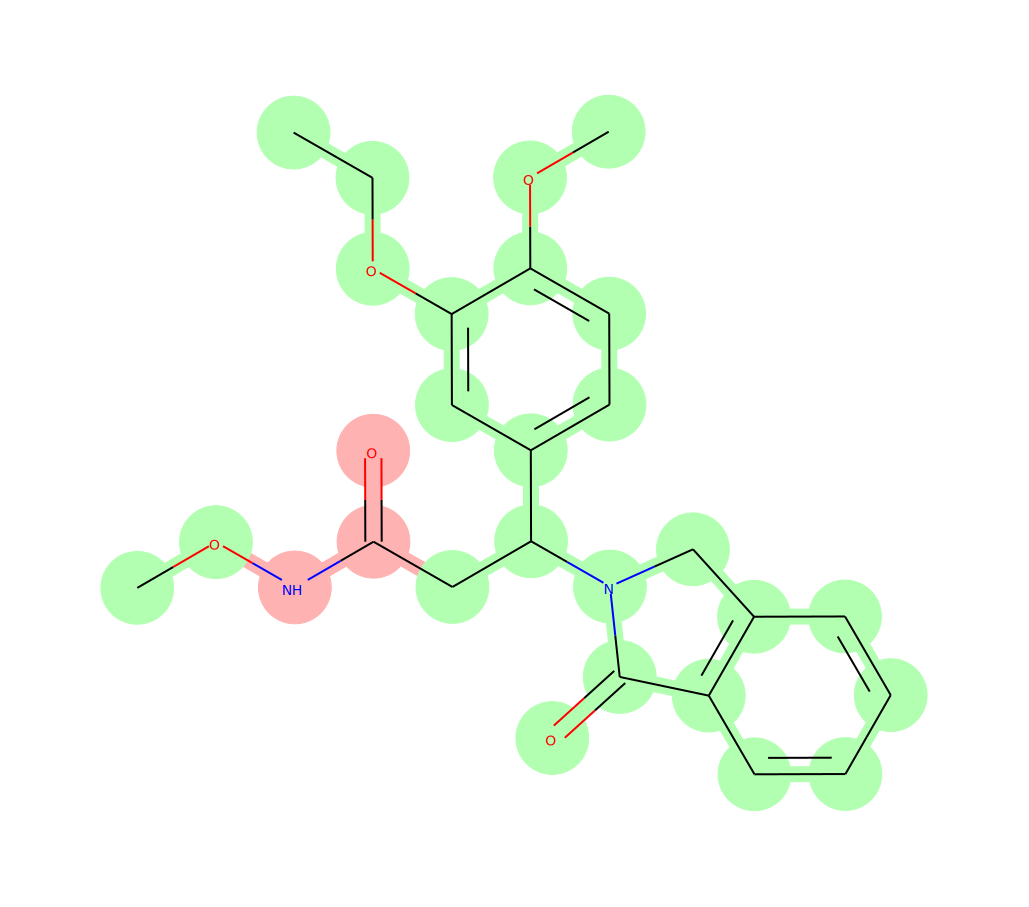

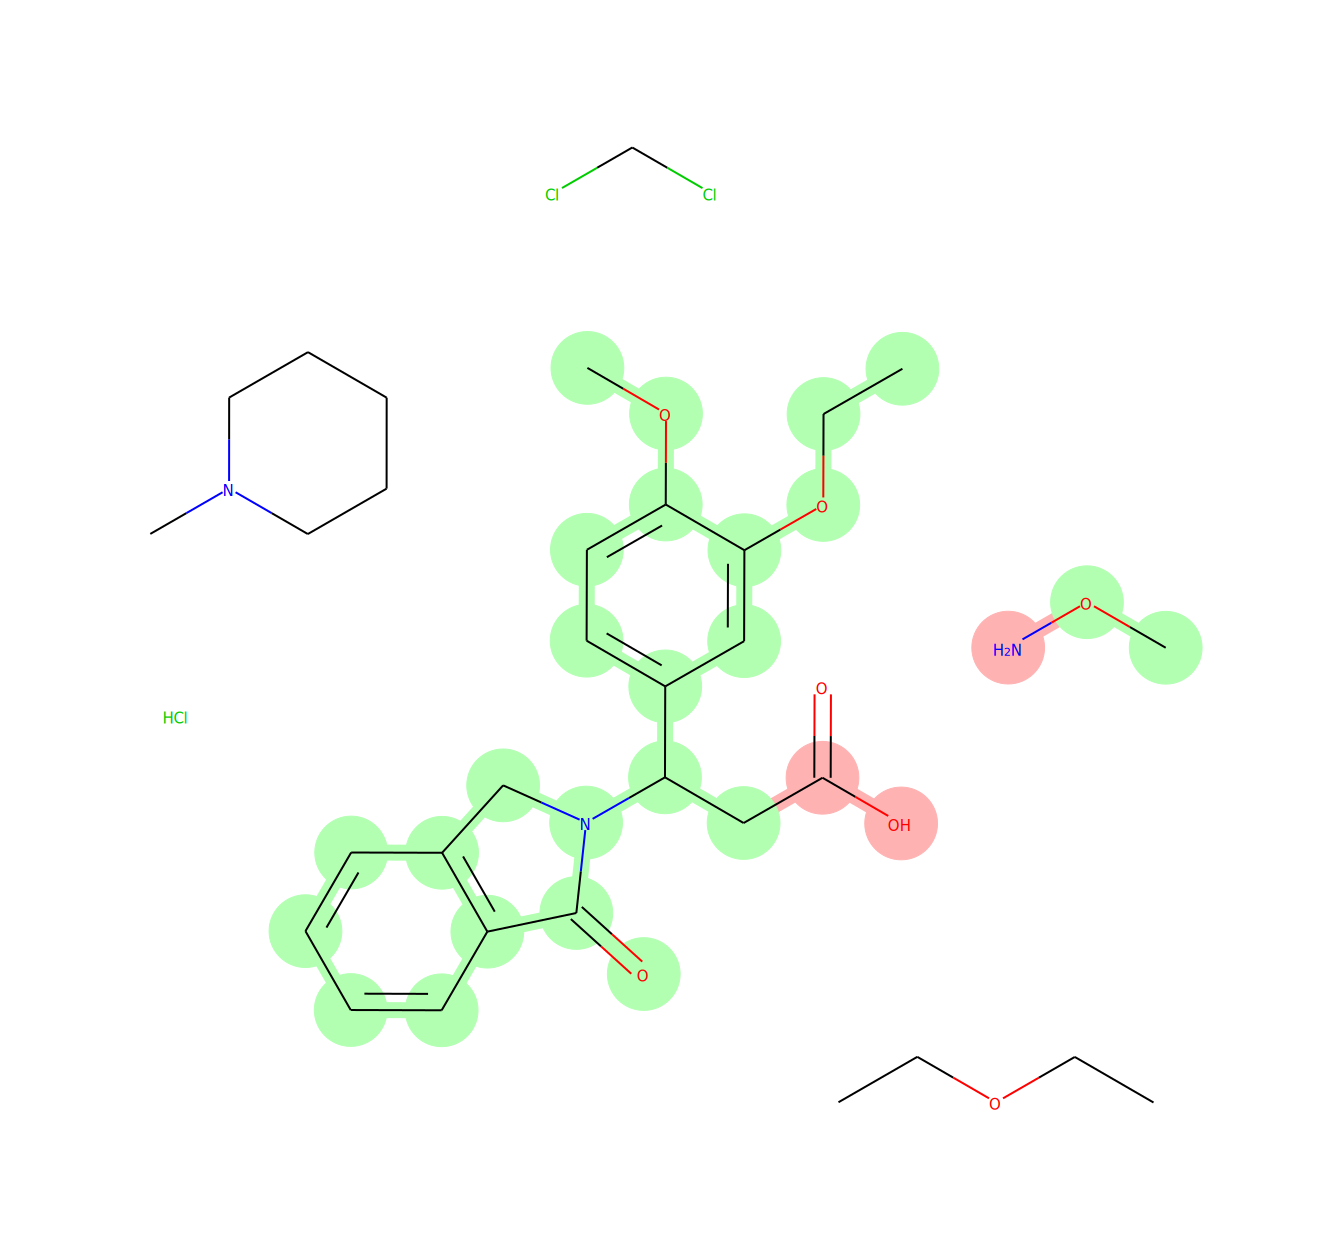

8793
0.093187116


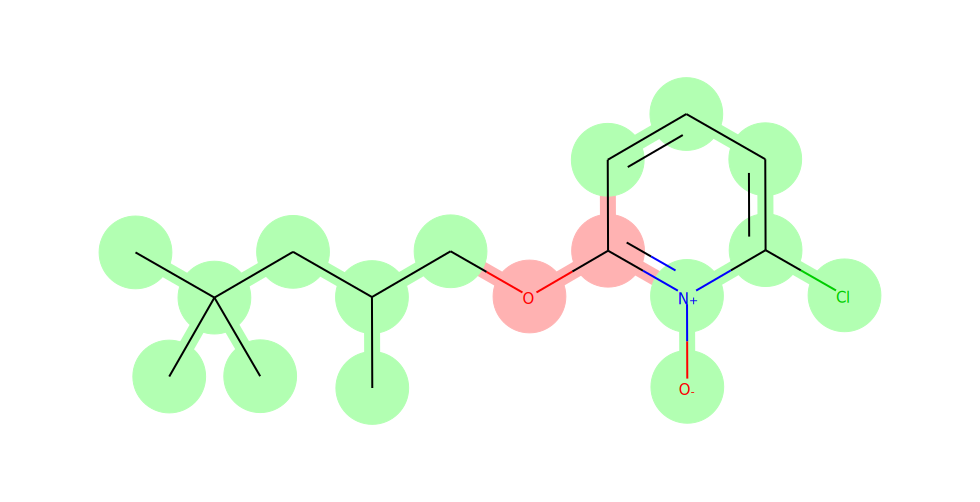

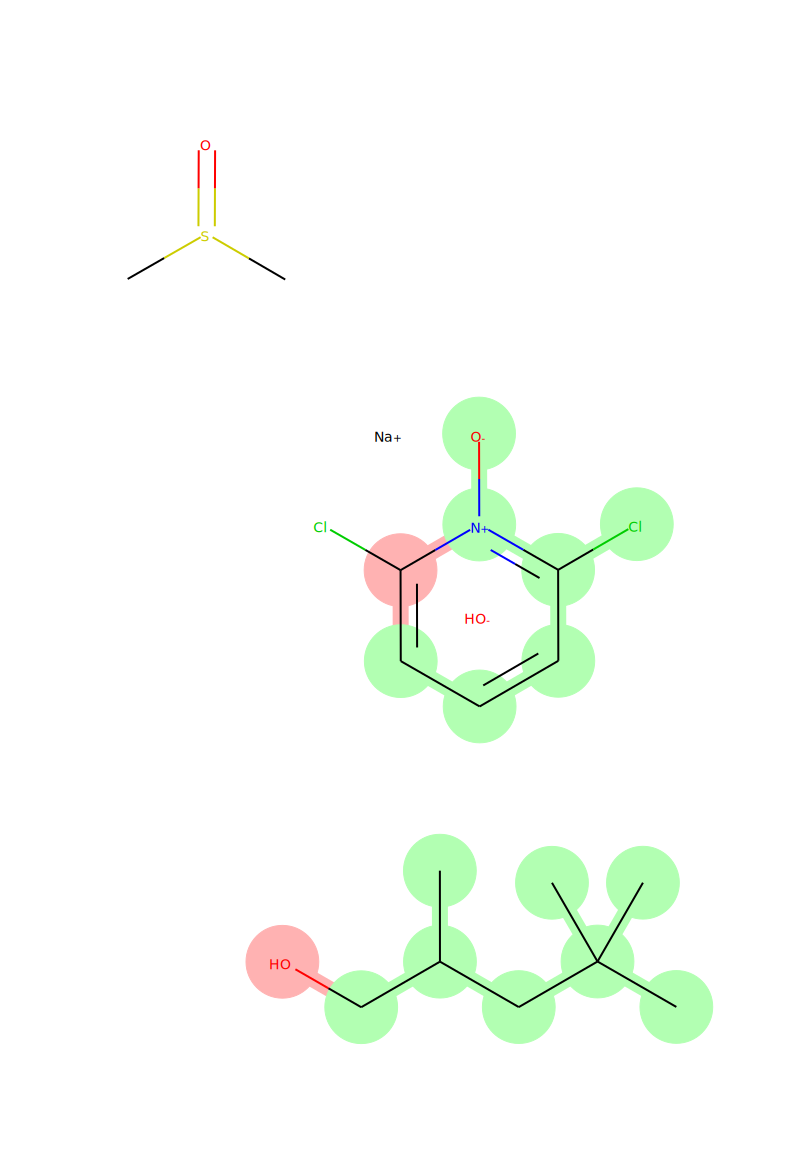

16728
0.14798173


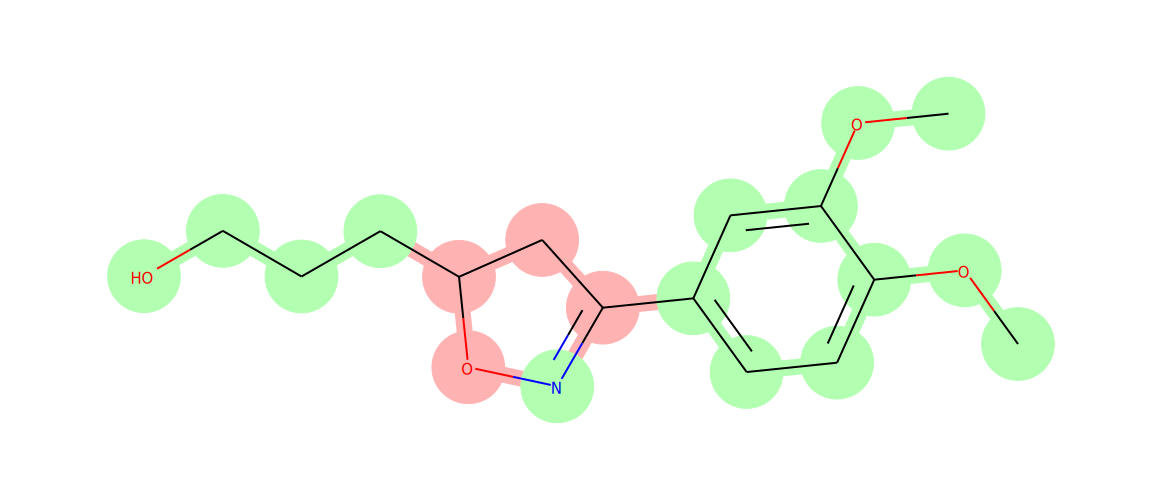

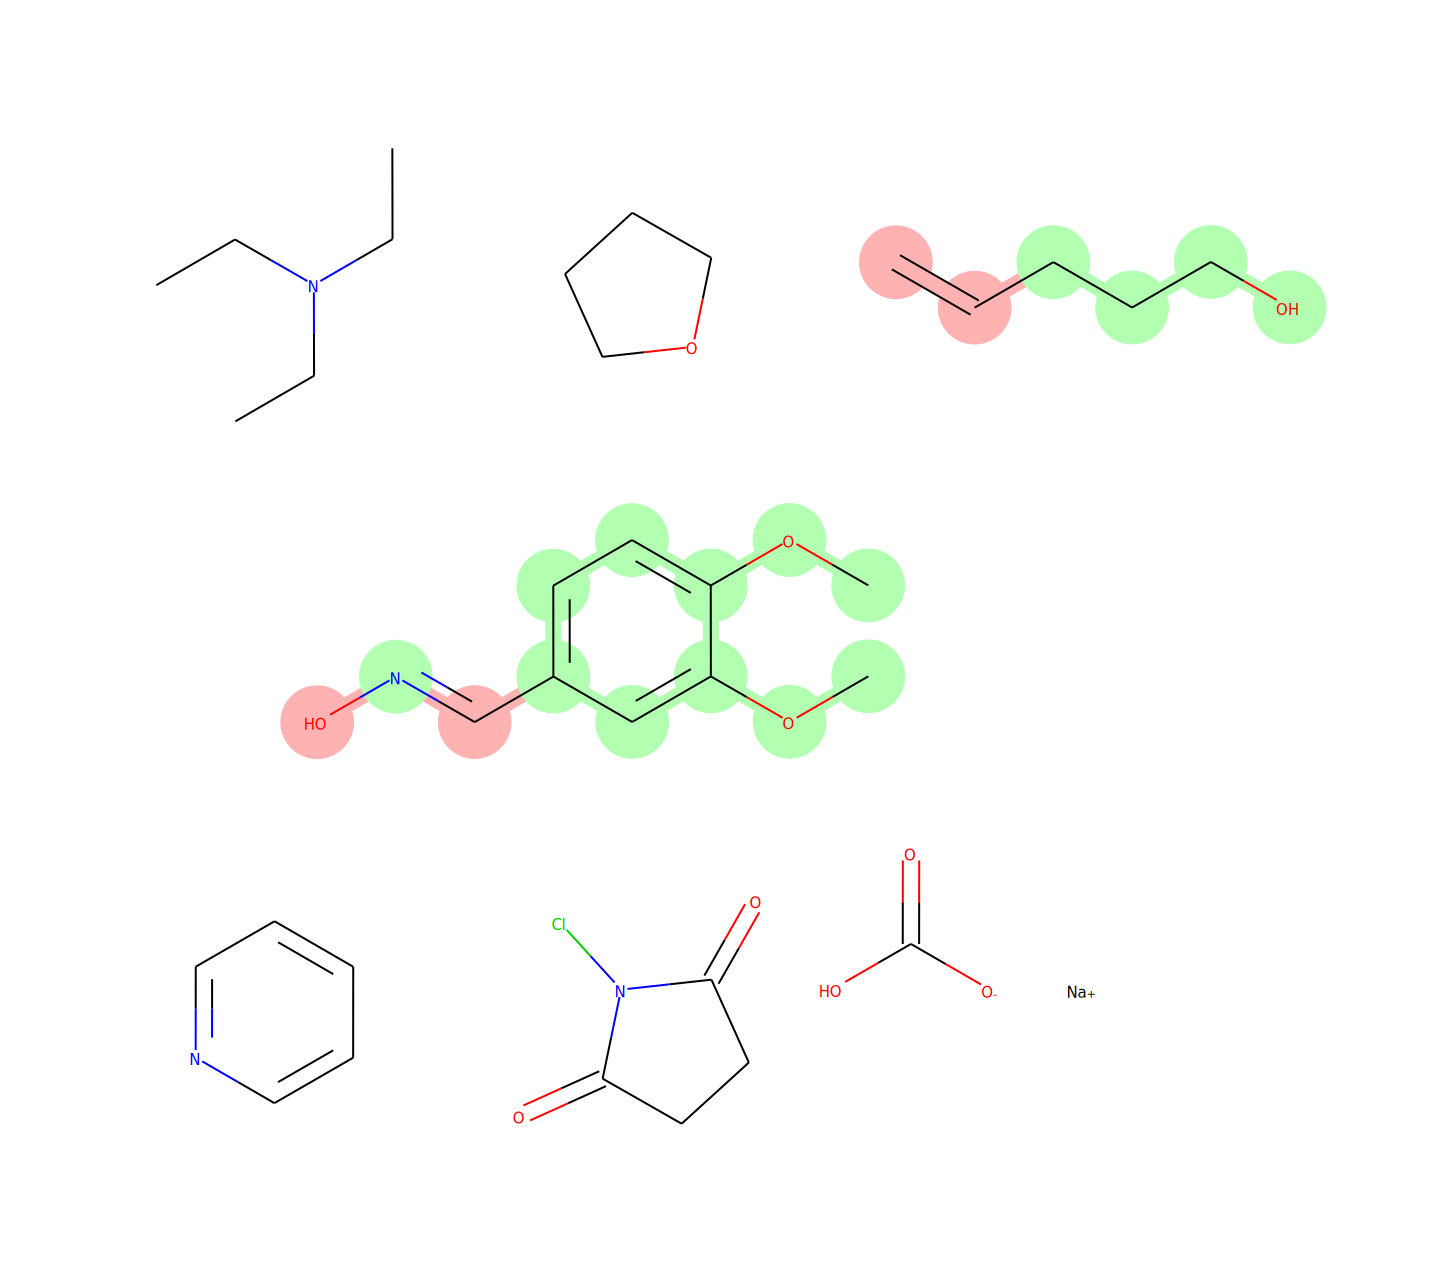

35884
0.82563716


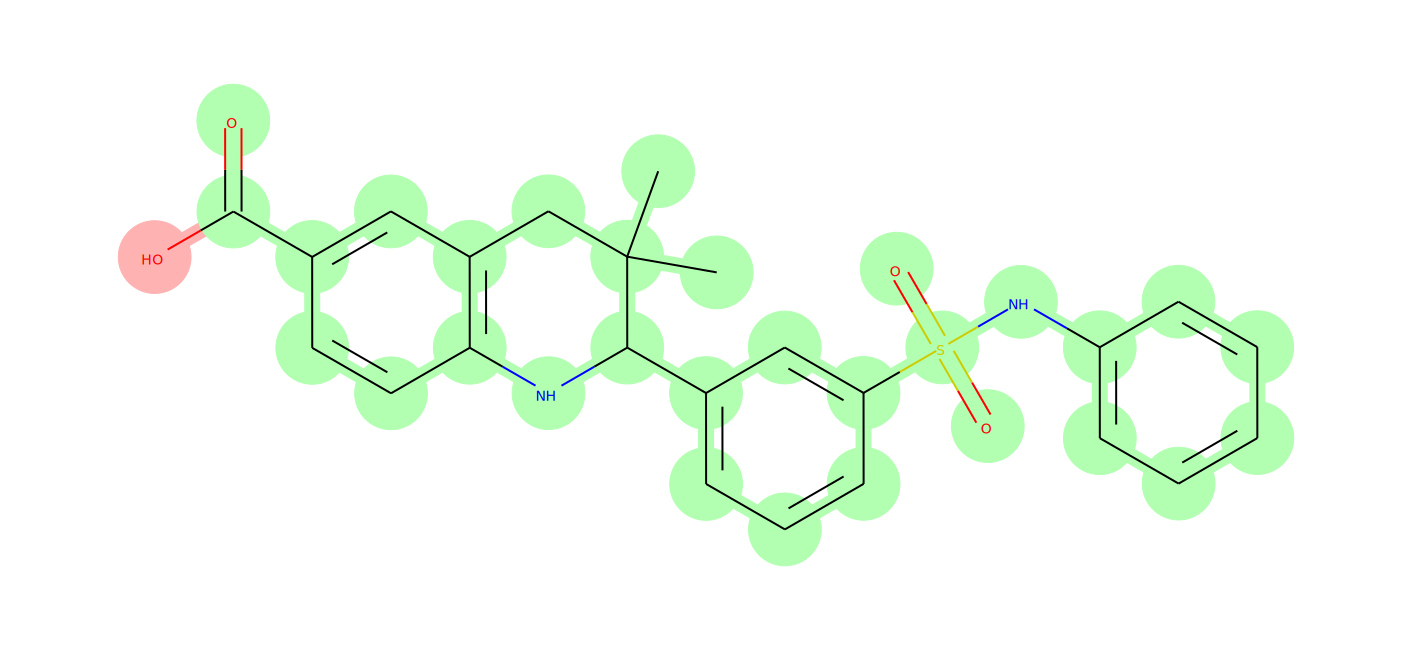

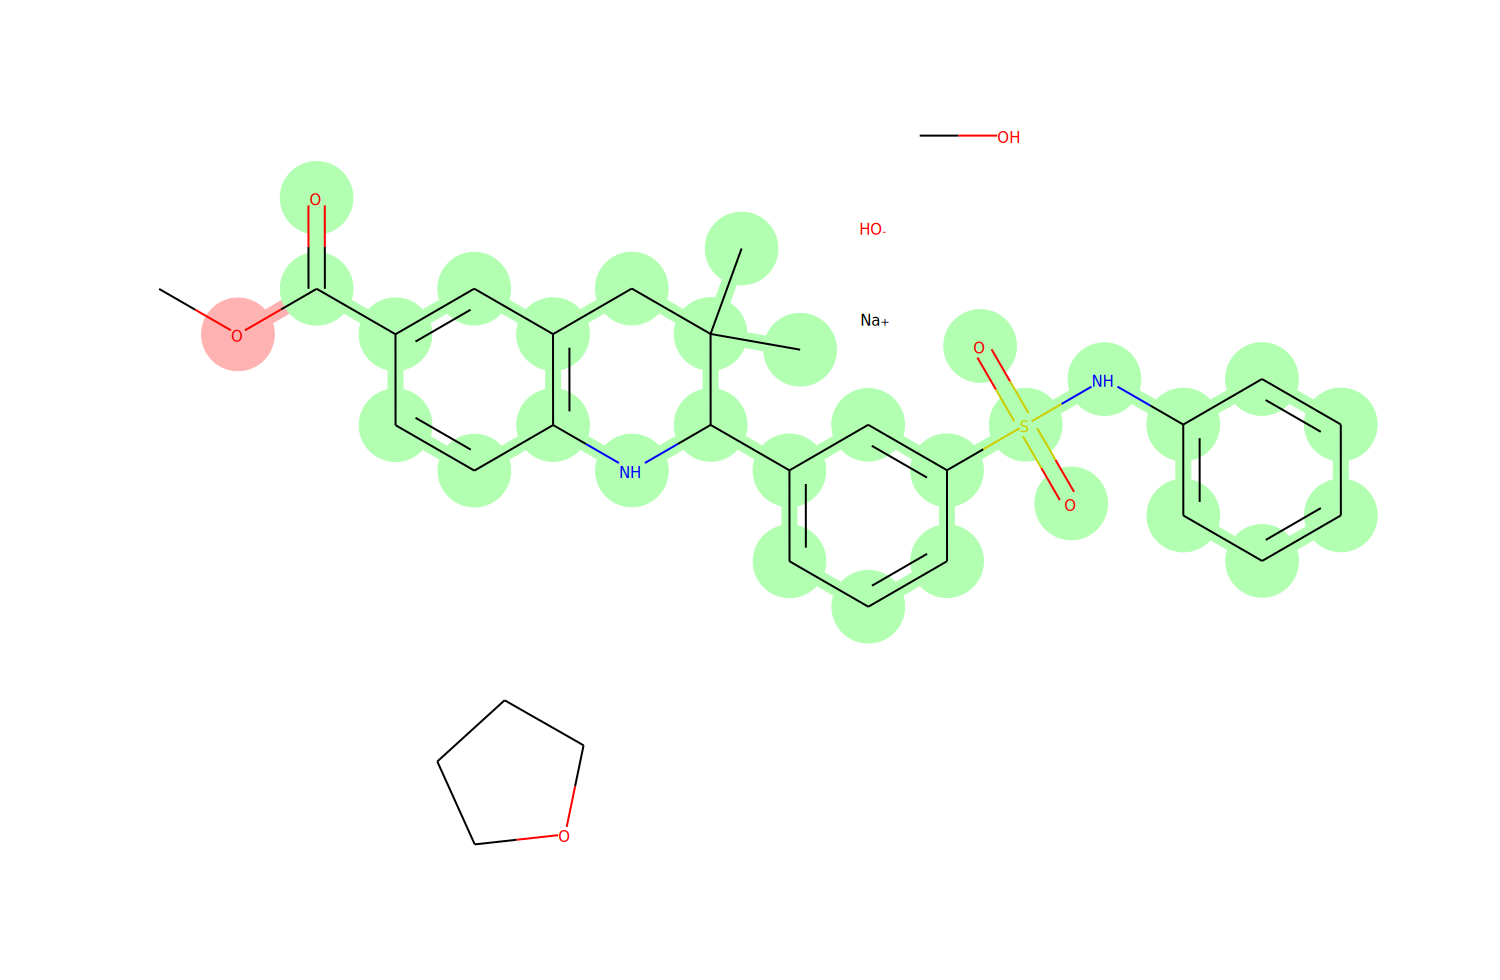

New center
885
0.108431585


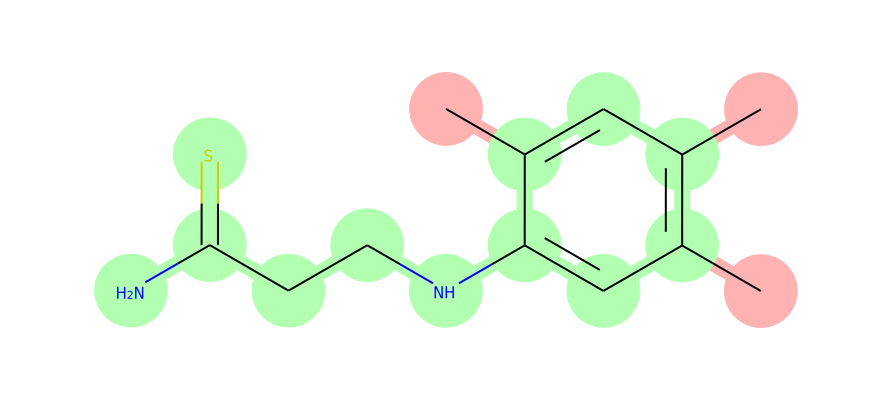

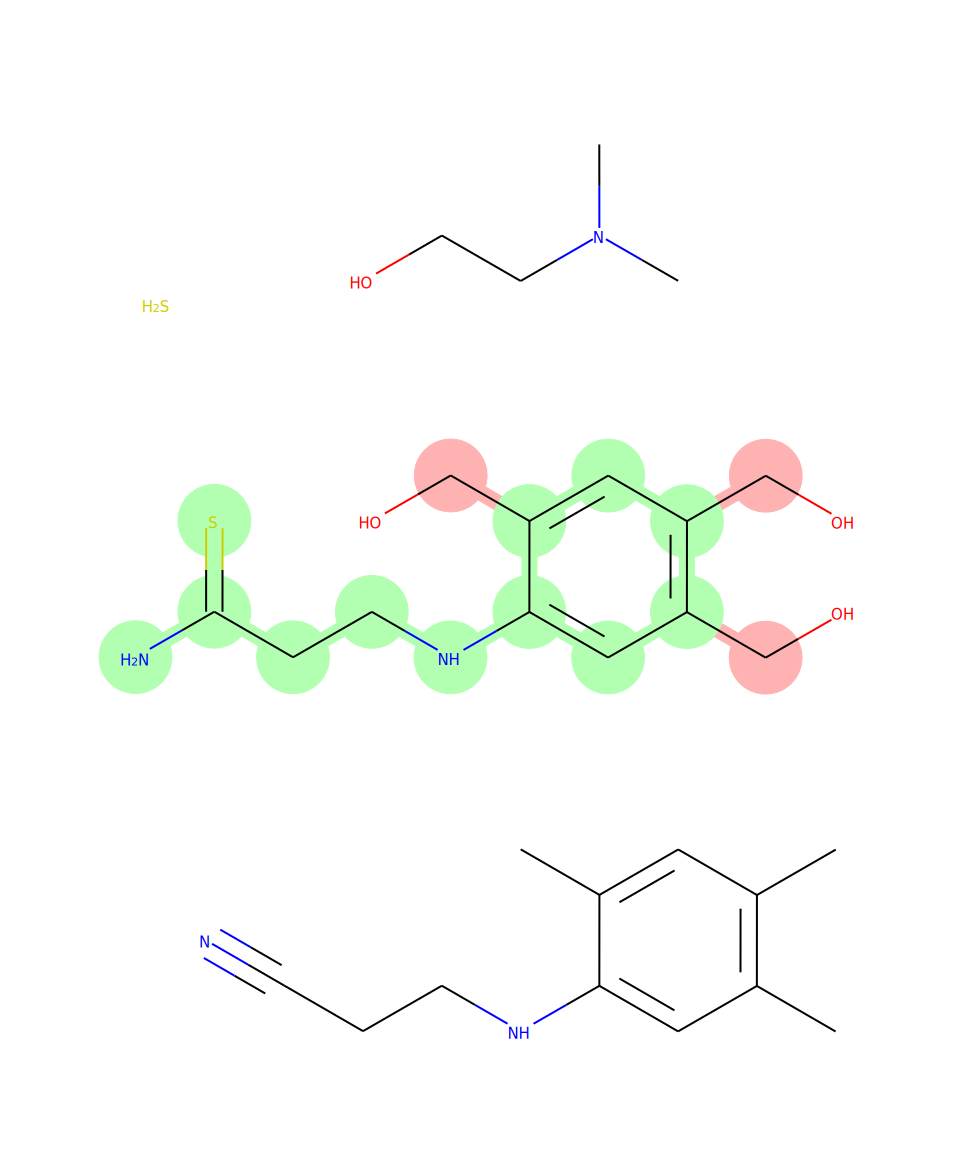

2602
0.11609228


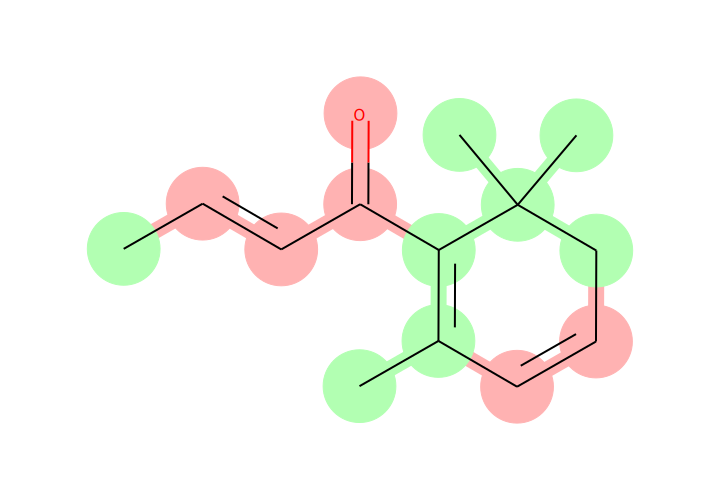

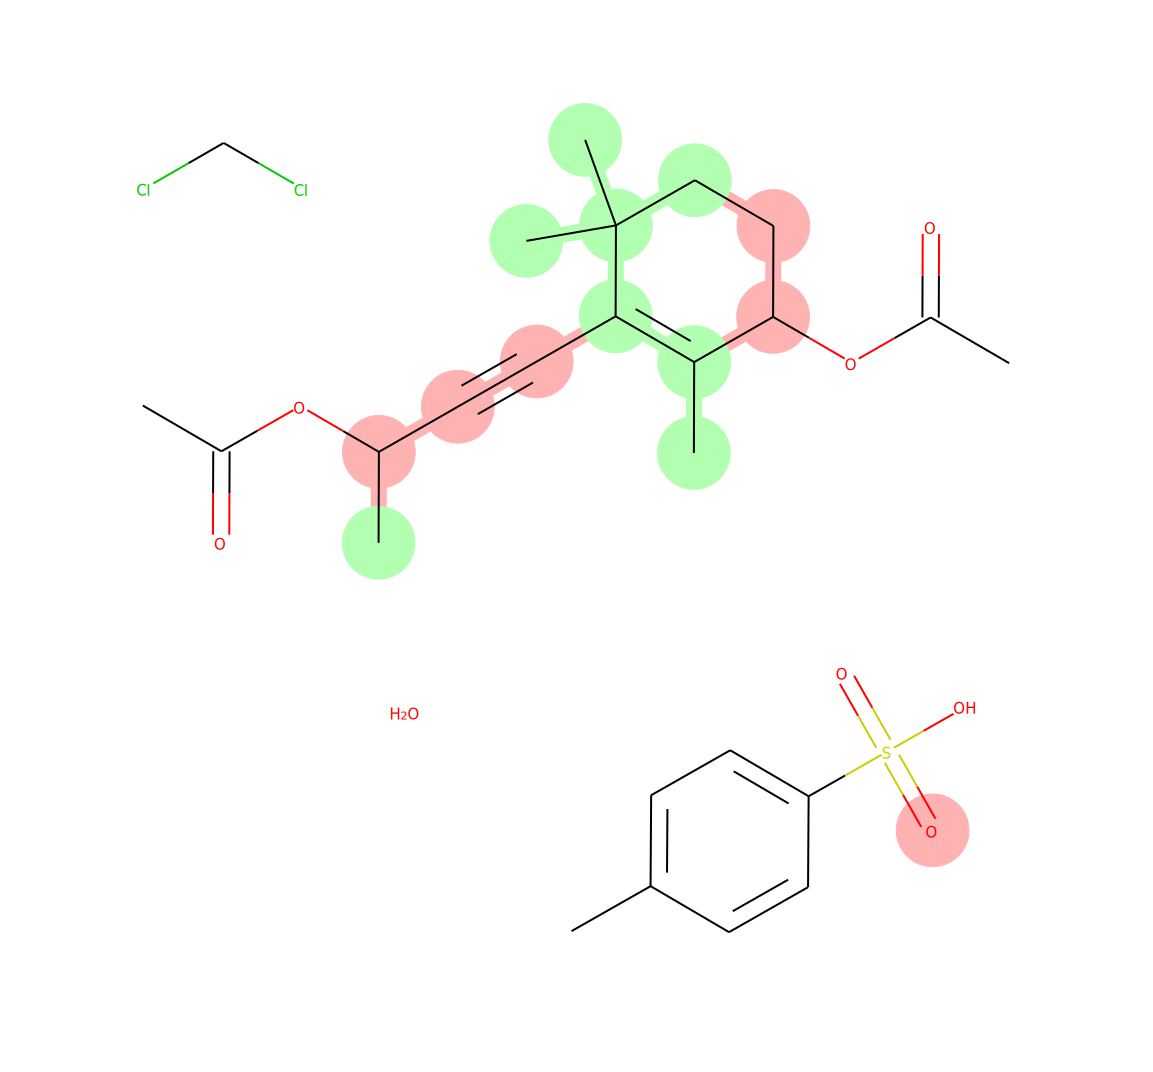

20456
0.1286307


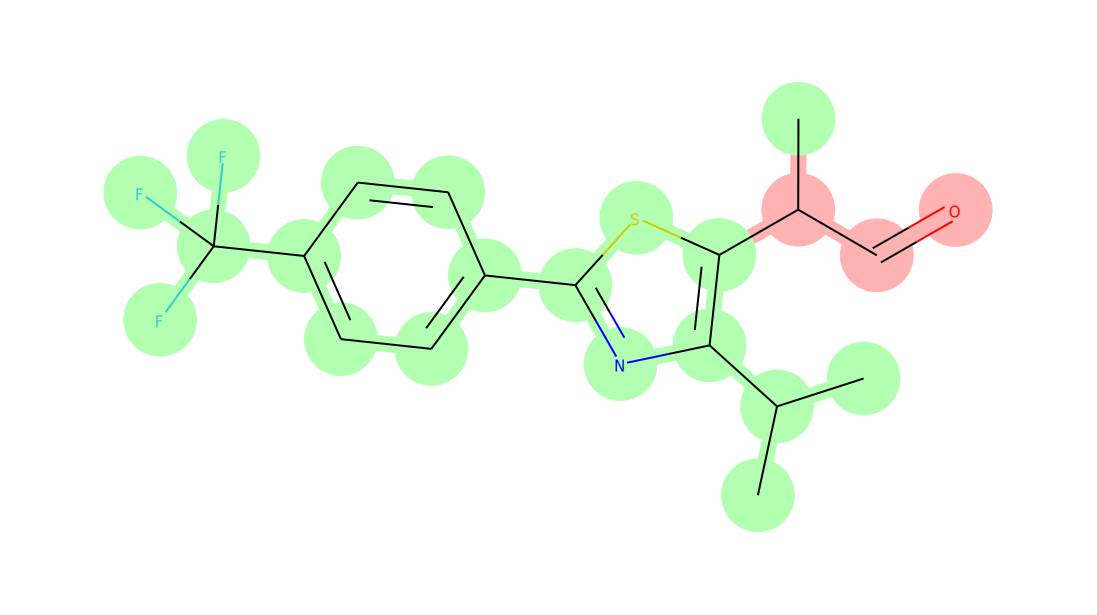

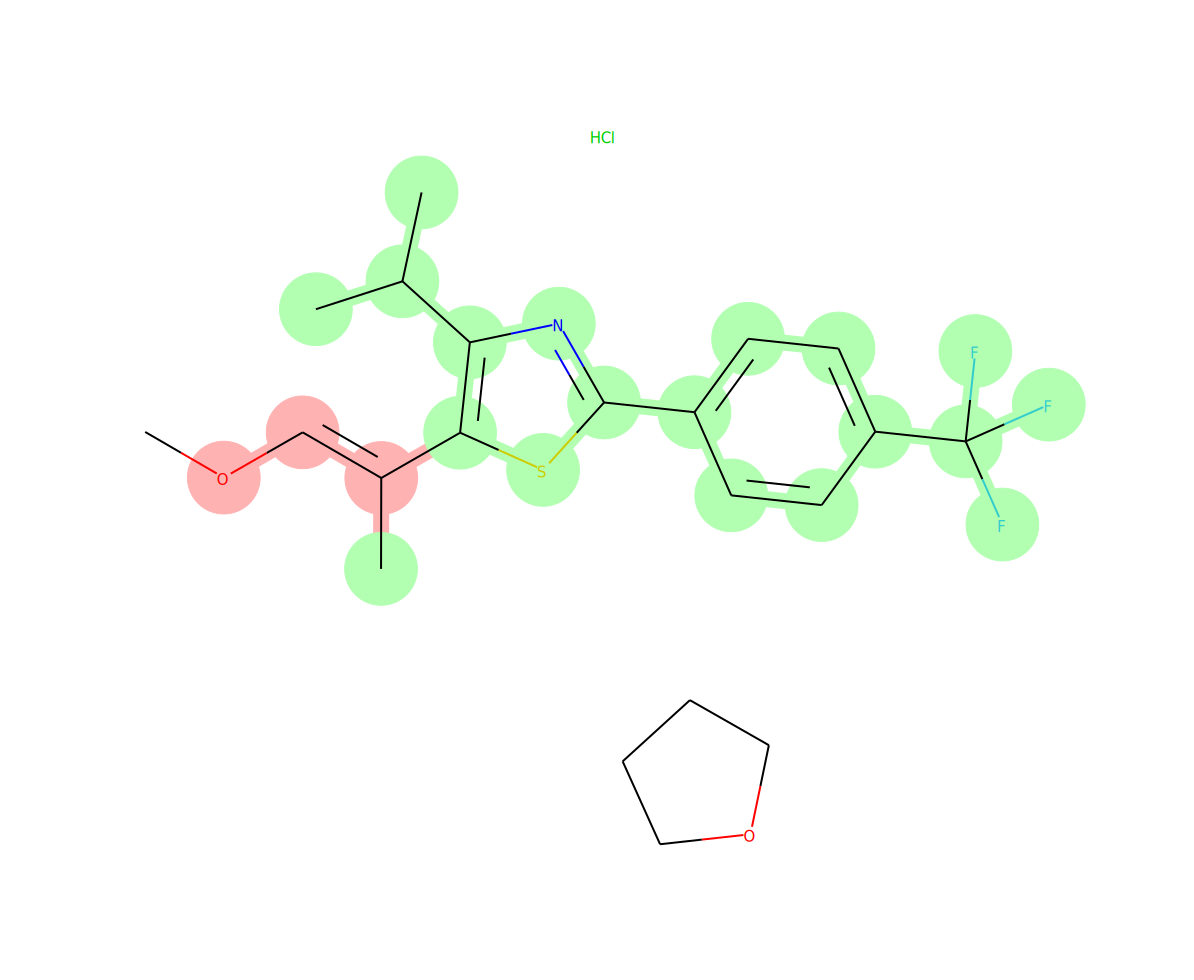

23627
0.19082512


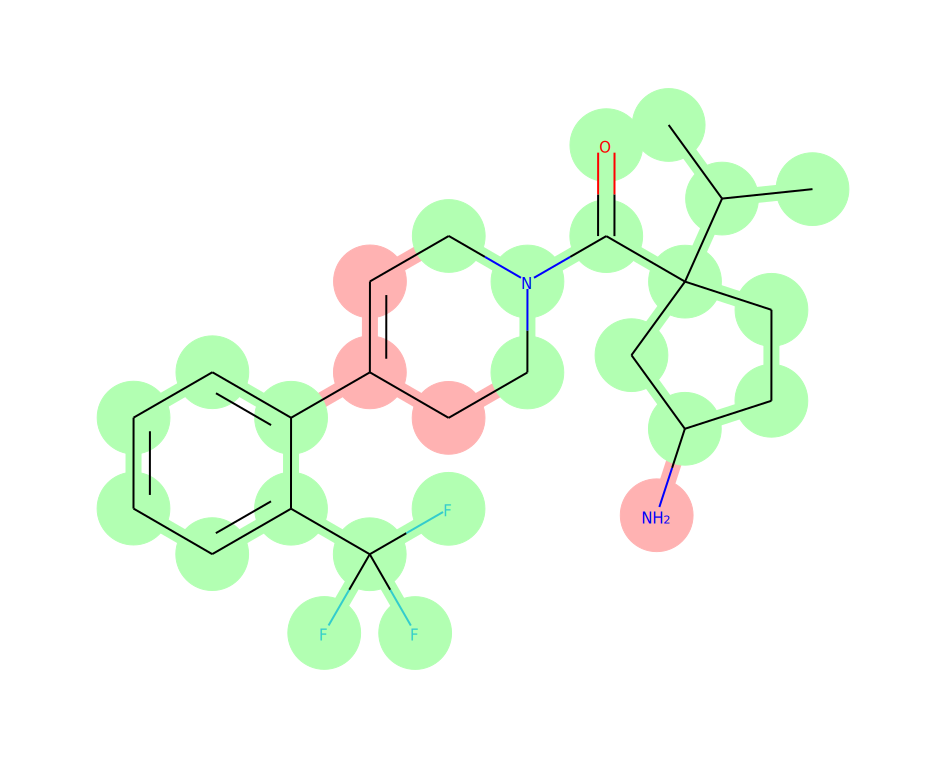

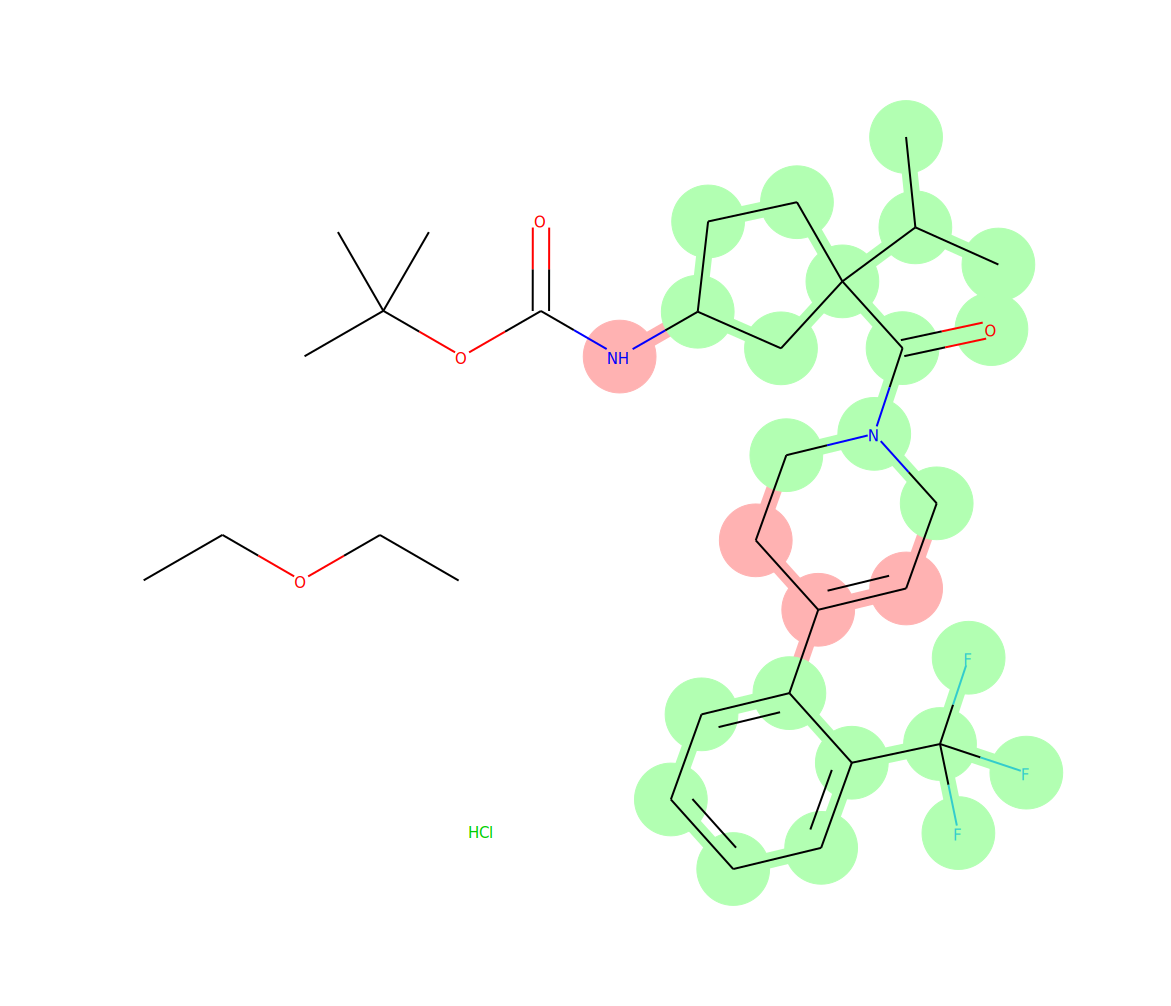

7986
1.0463628


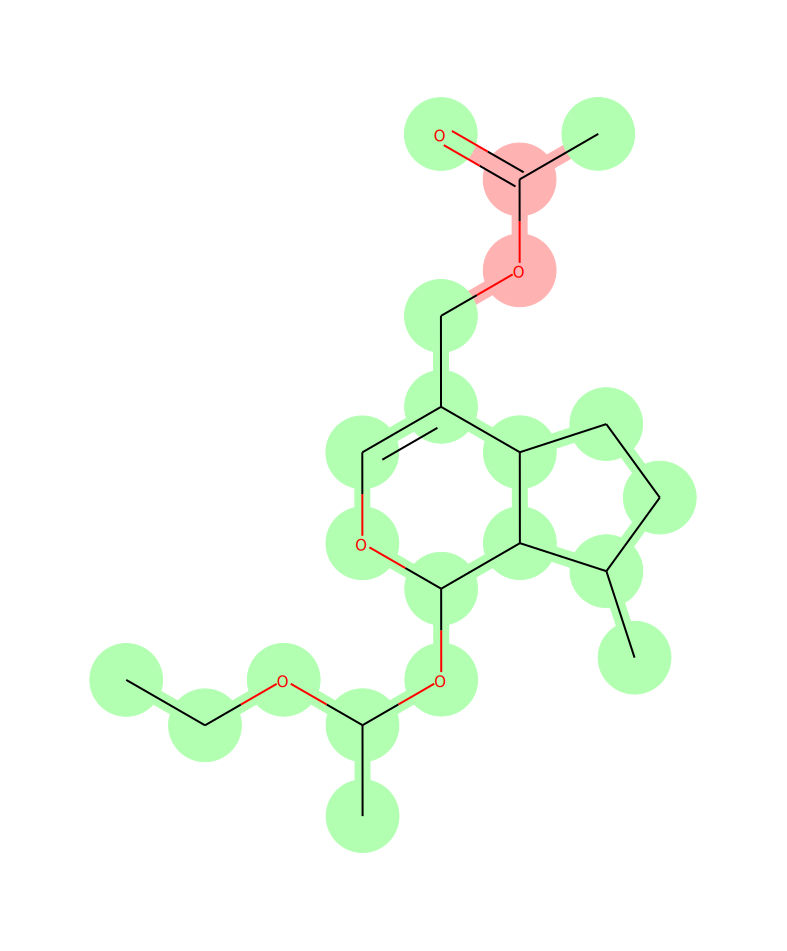

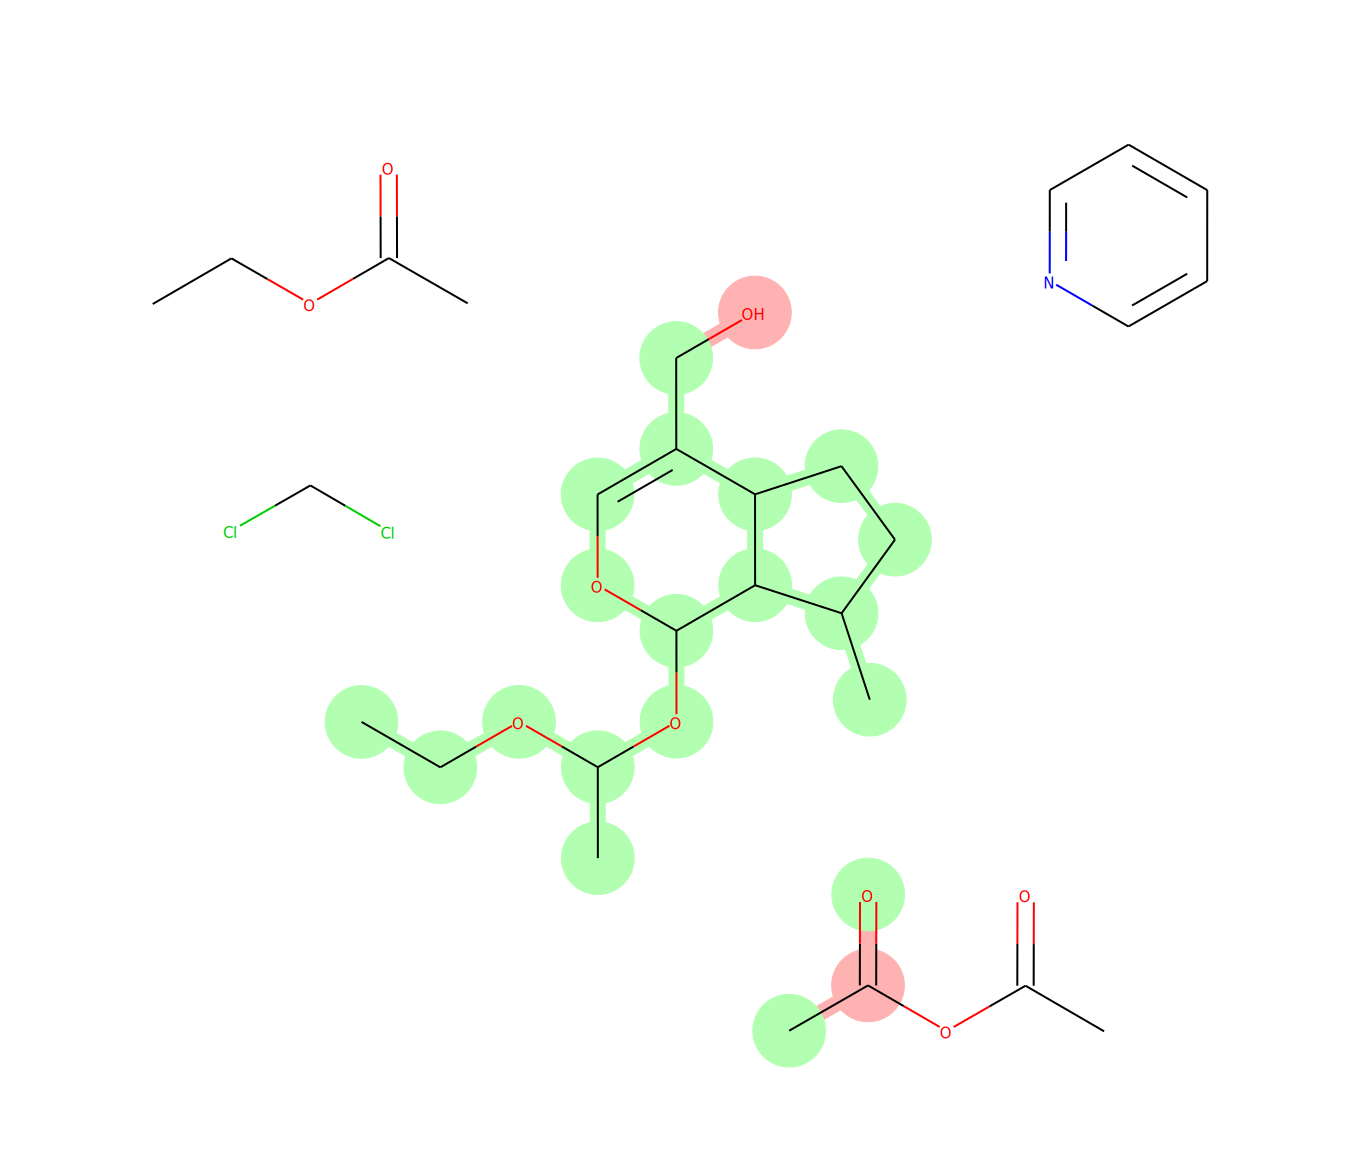

New center
48653
0.1078425


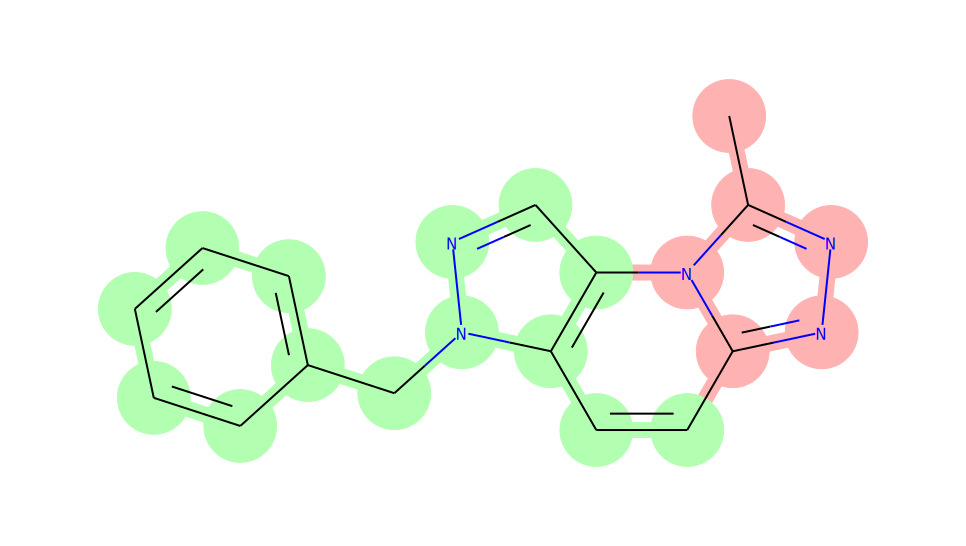

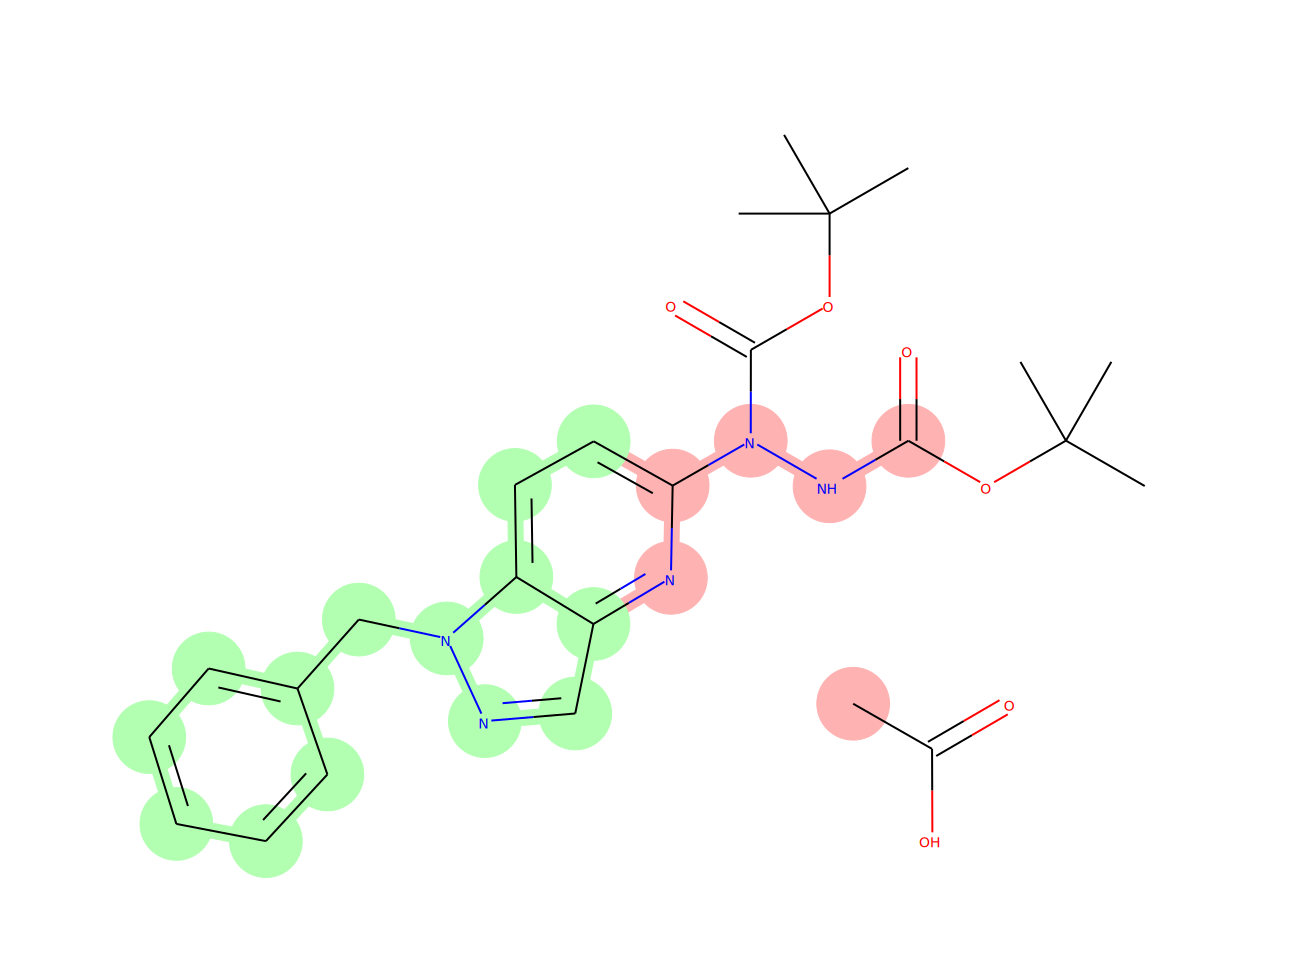

36594
0.12808189


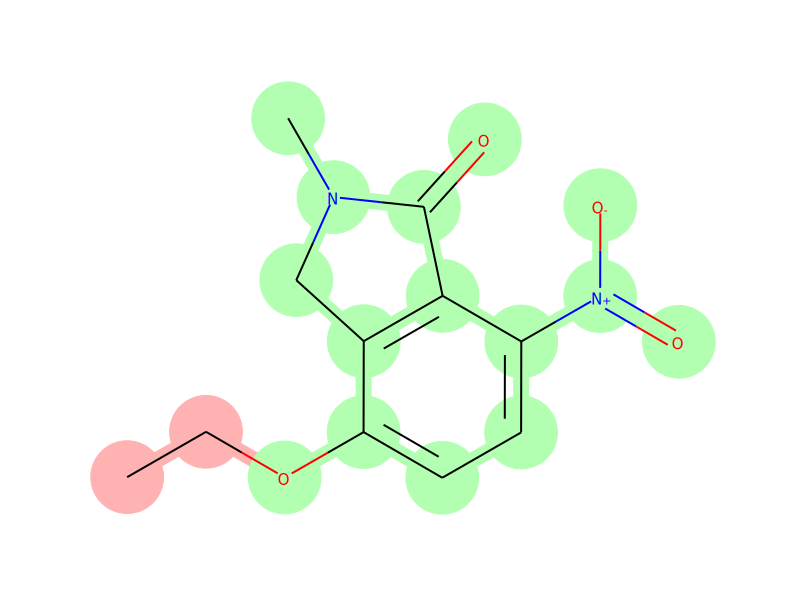

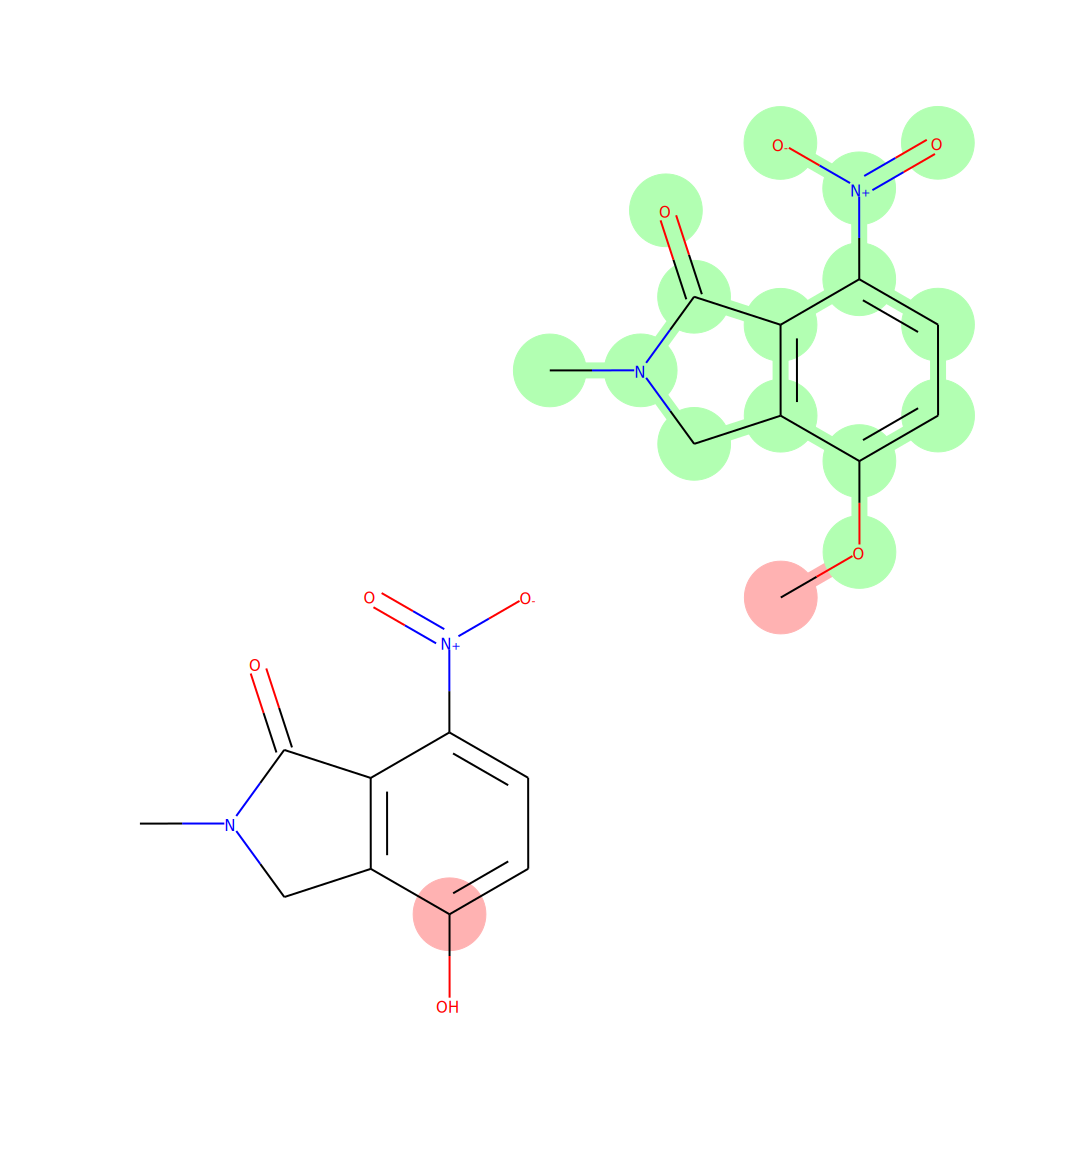

38385
0.13235633


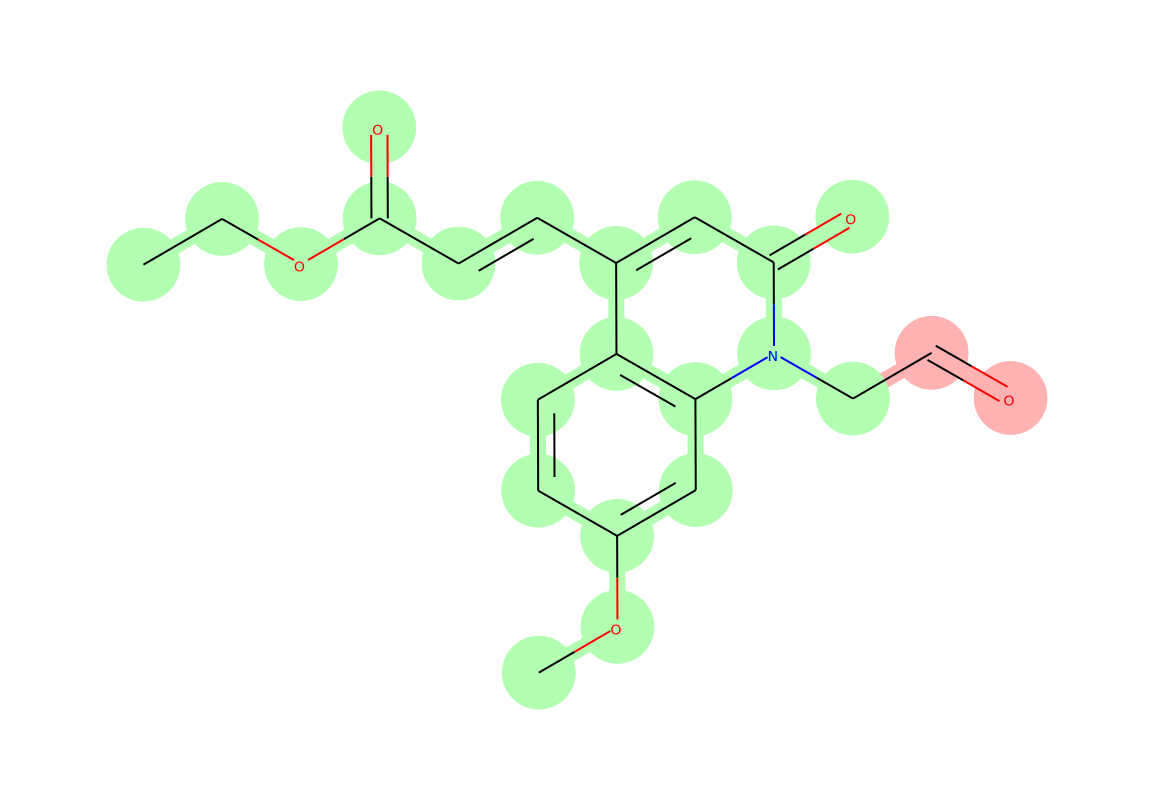

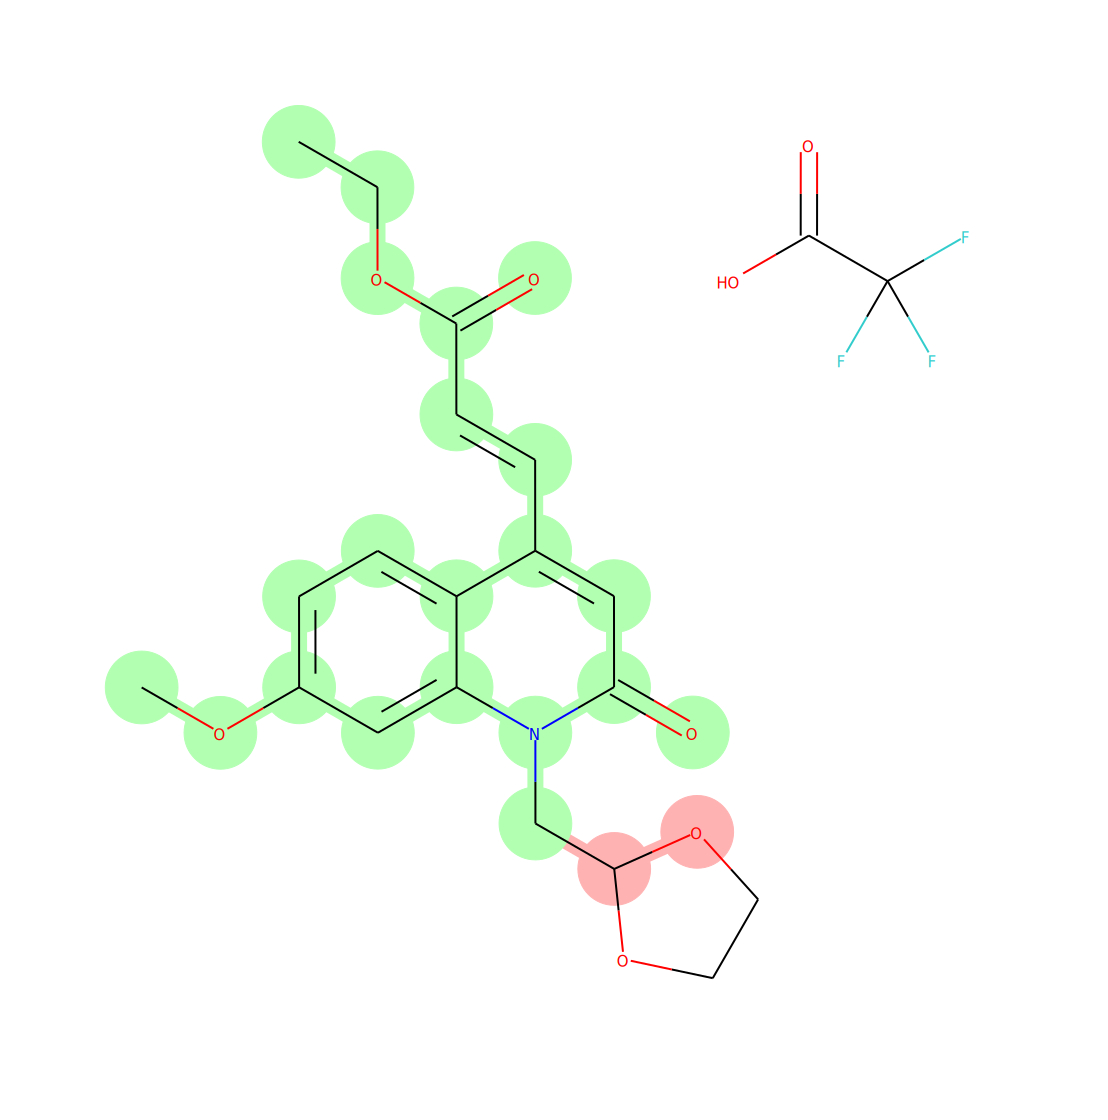

37938
0.17480357


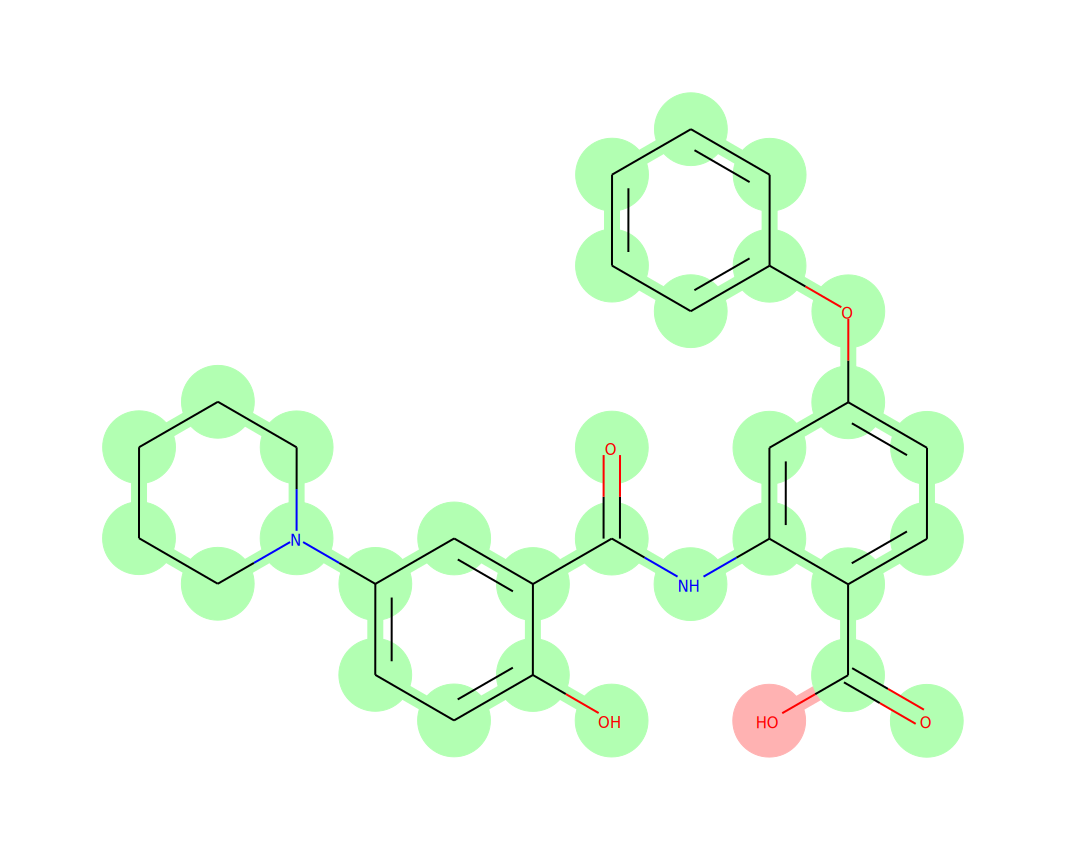

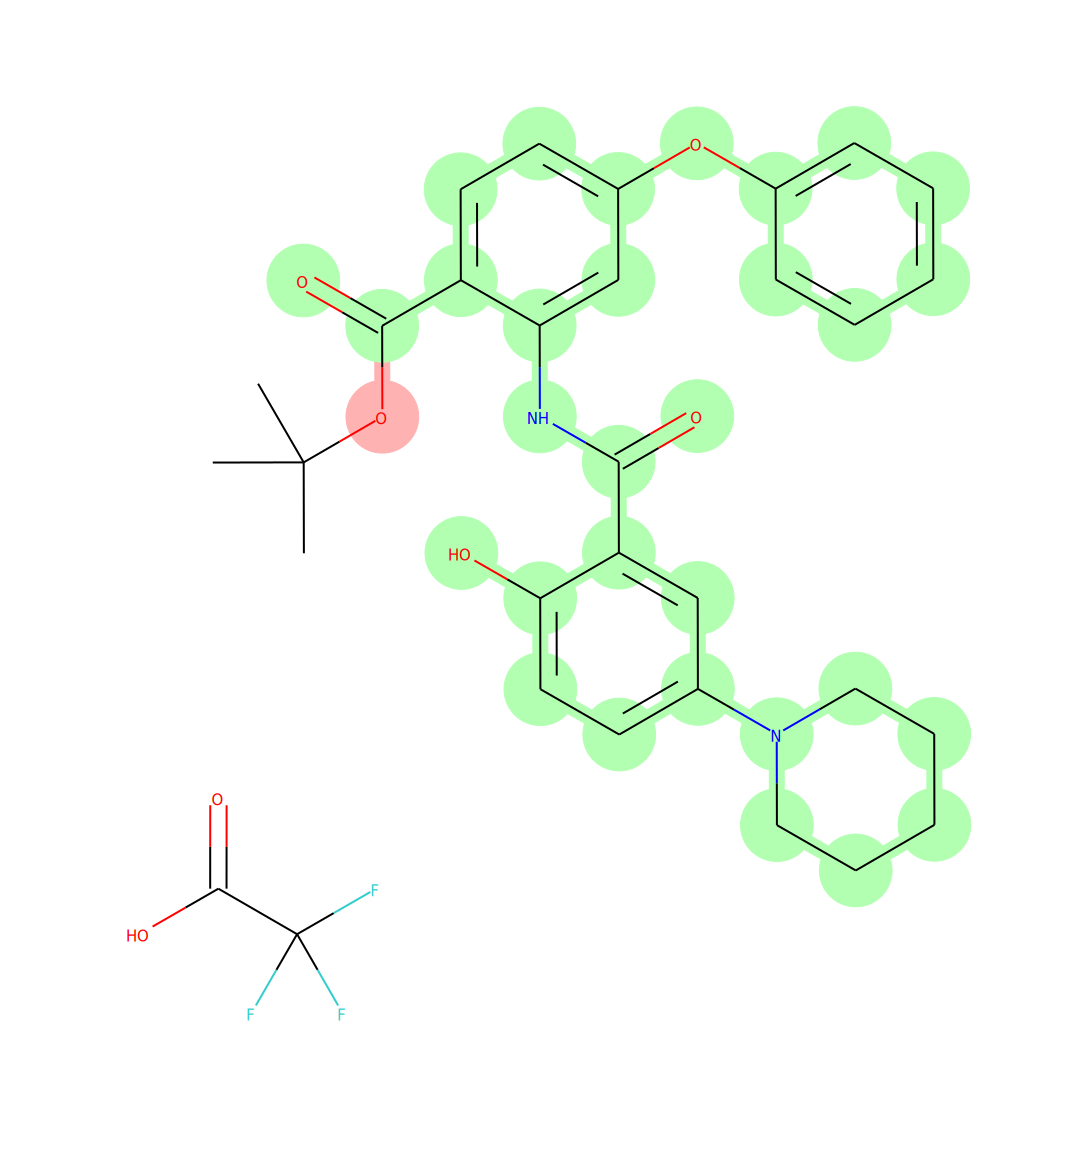

45598
1.0469819


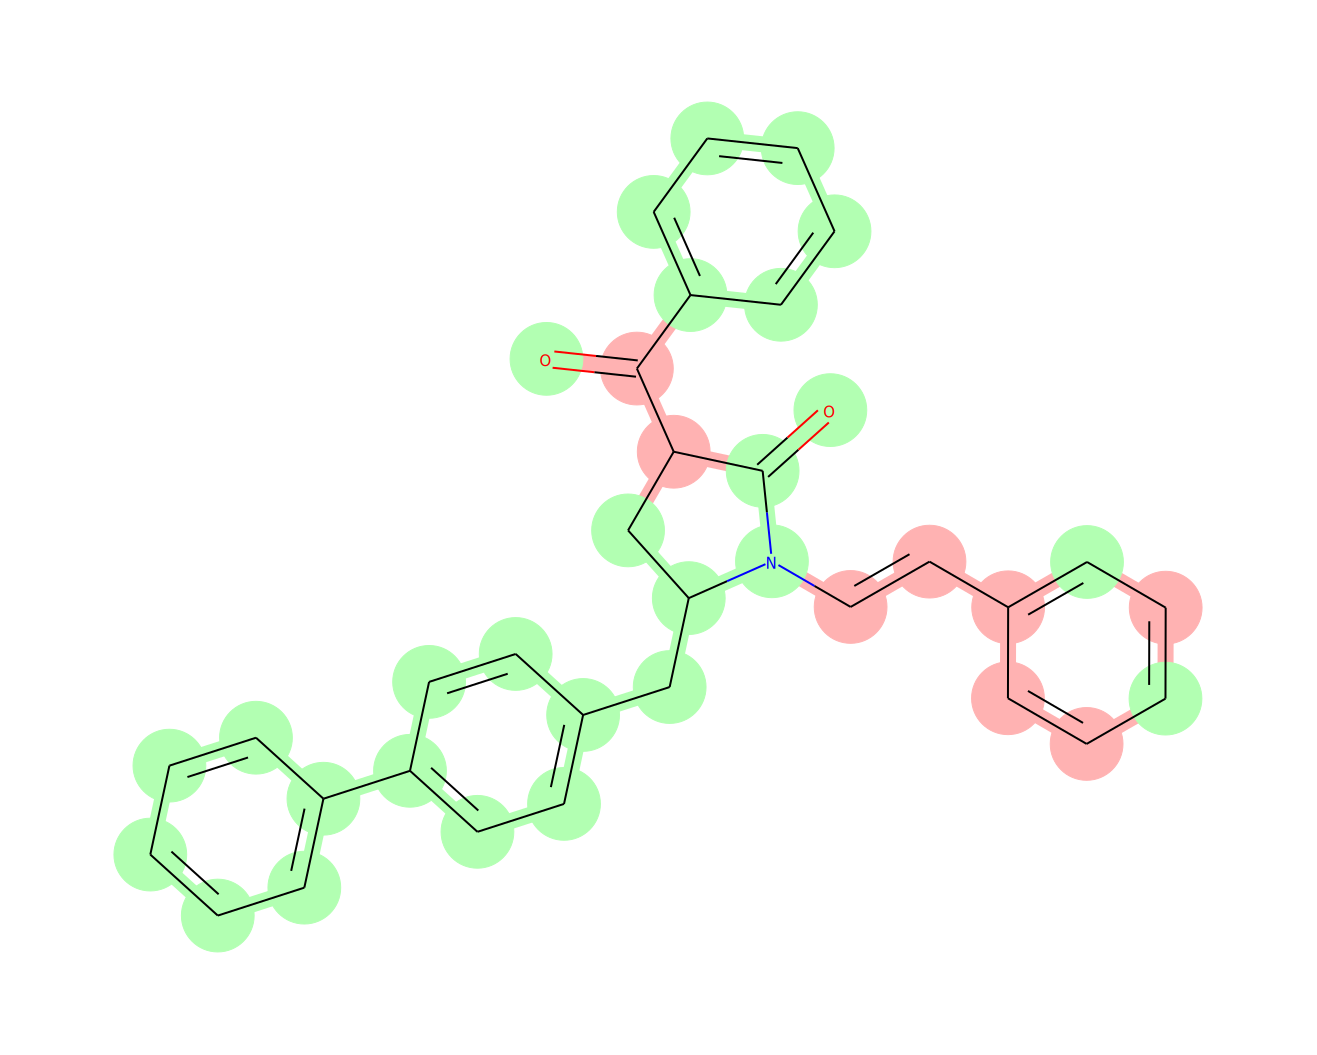

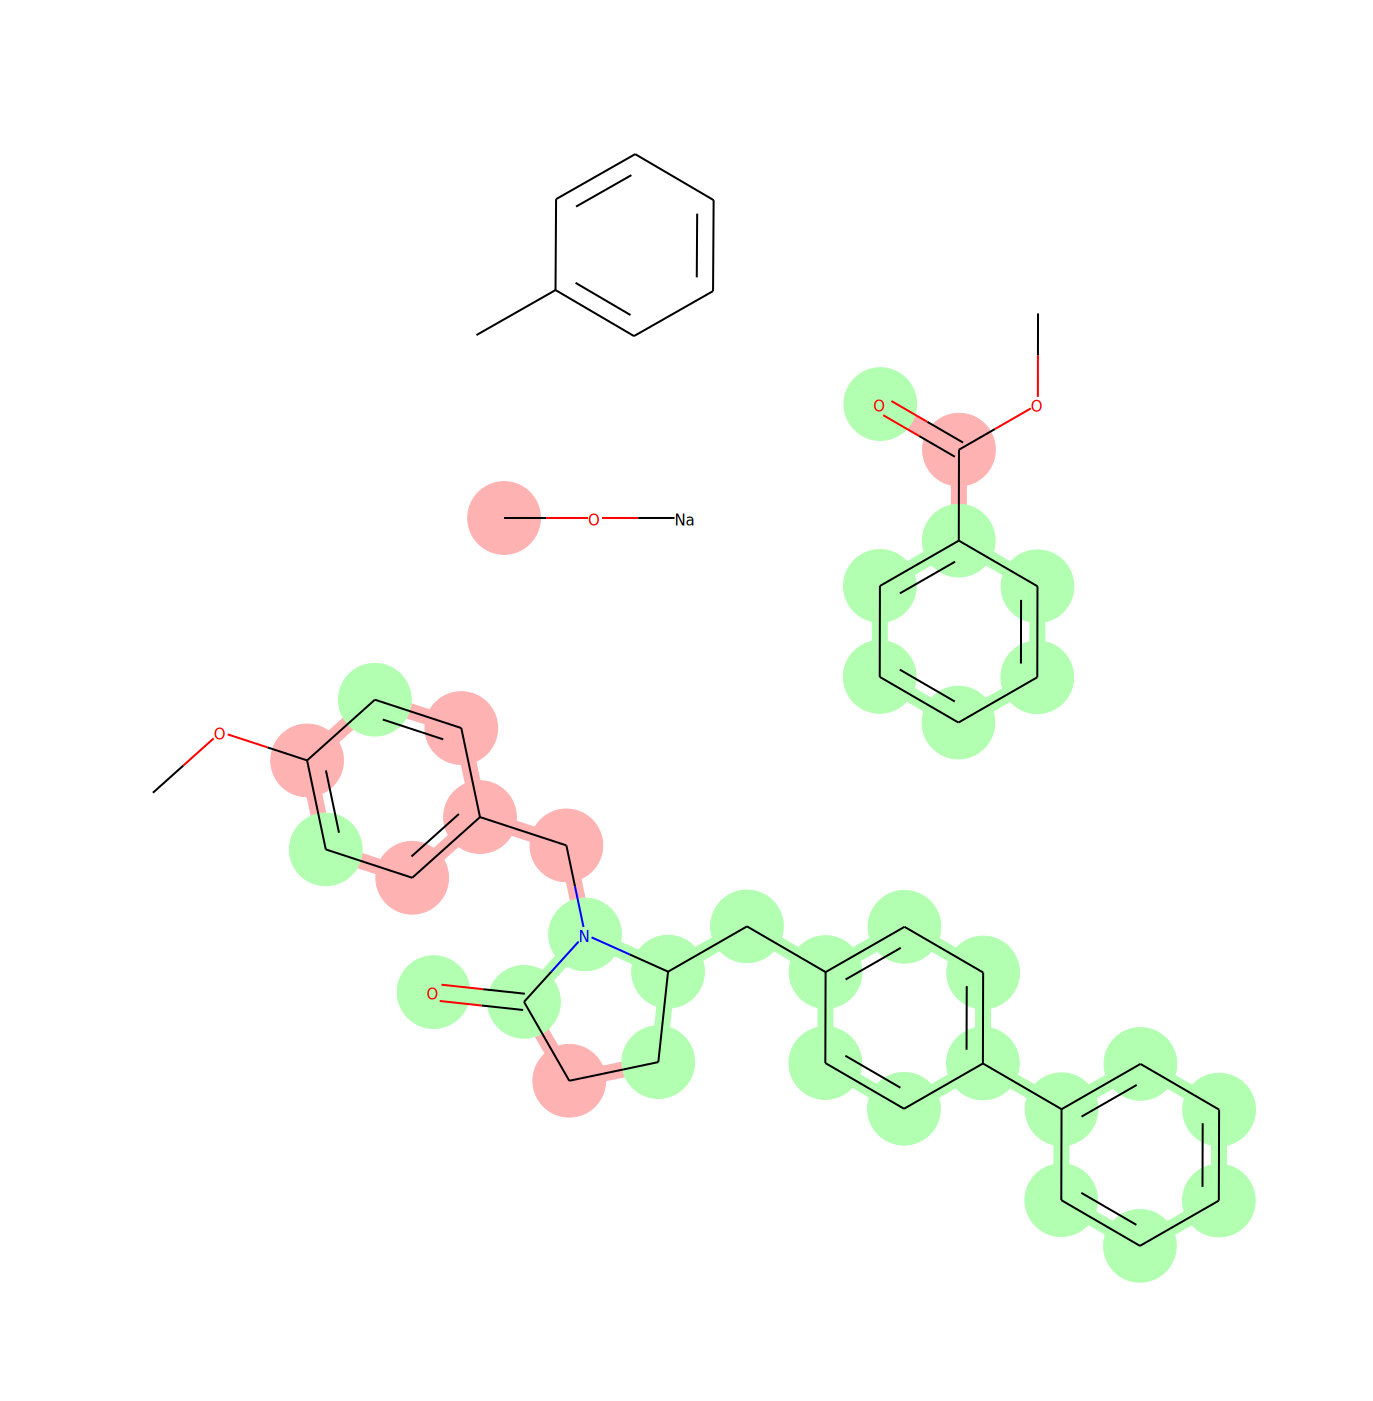

In [28]:
for center in centers:
    print('New center')
    norms = []
    for r in reac_reps:
        norms.append(np.linalg.norm(r - center))
    norms = np.array(norms)
    idxs = np.argsort(norms)
    show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 10000]])

In [29]:
idxs = [0, 102, 31514]#0, 88, 23890

102
0.0


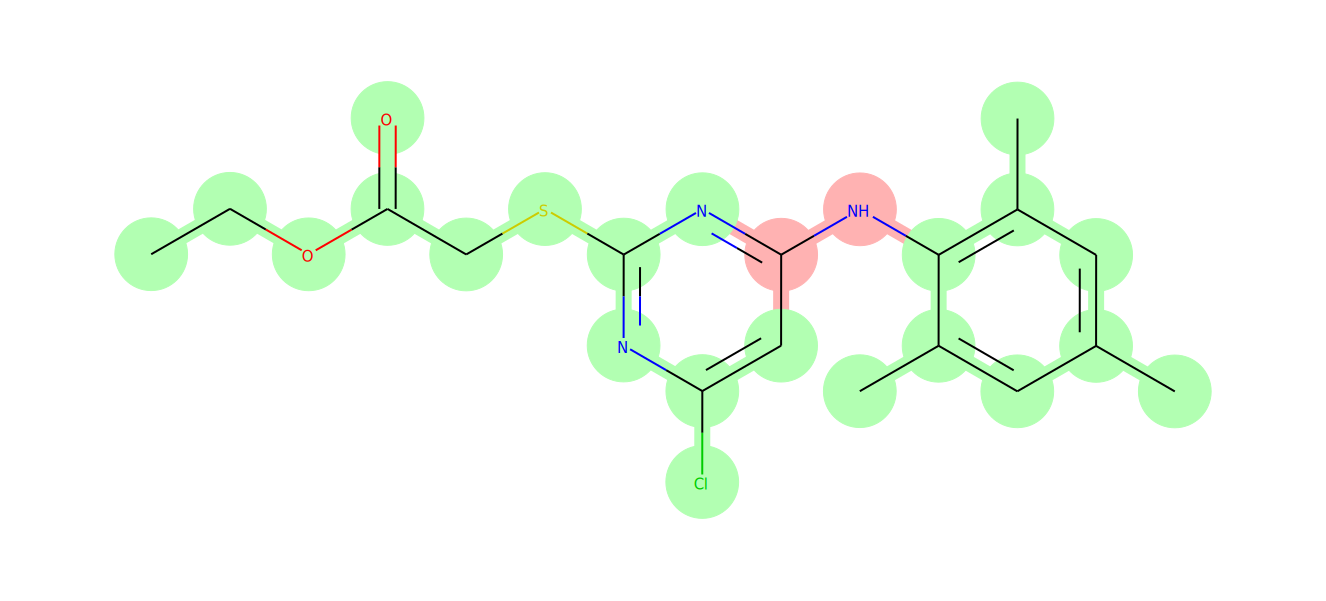

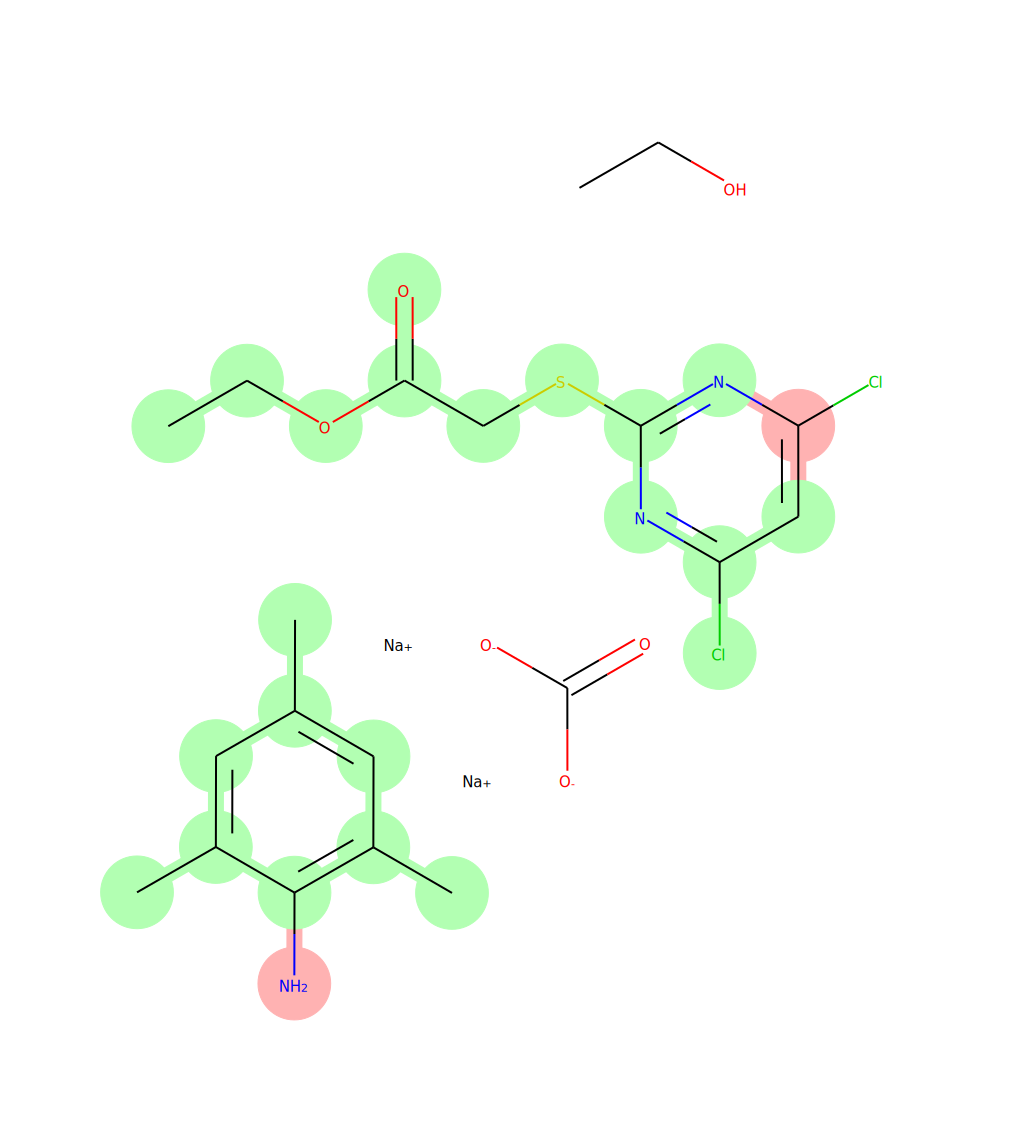

1252
0.06888034


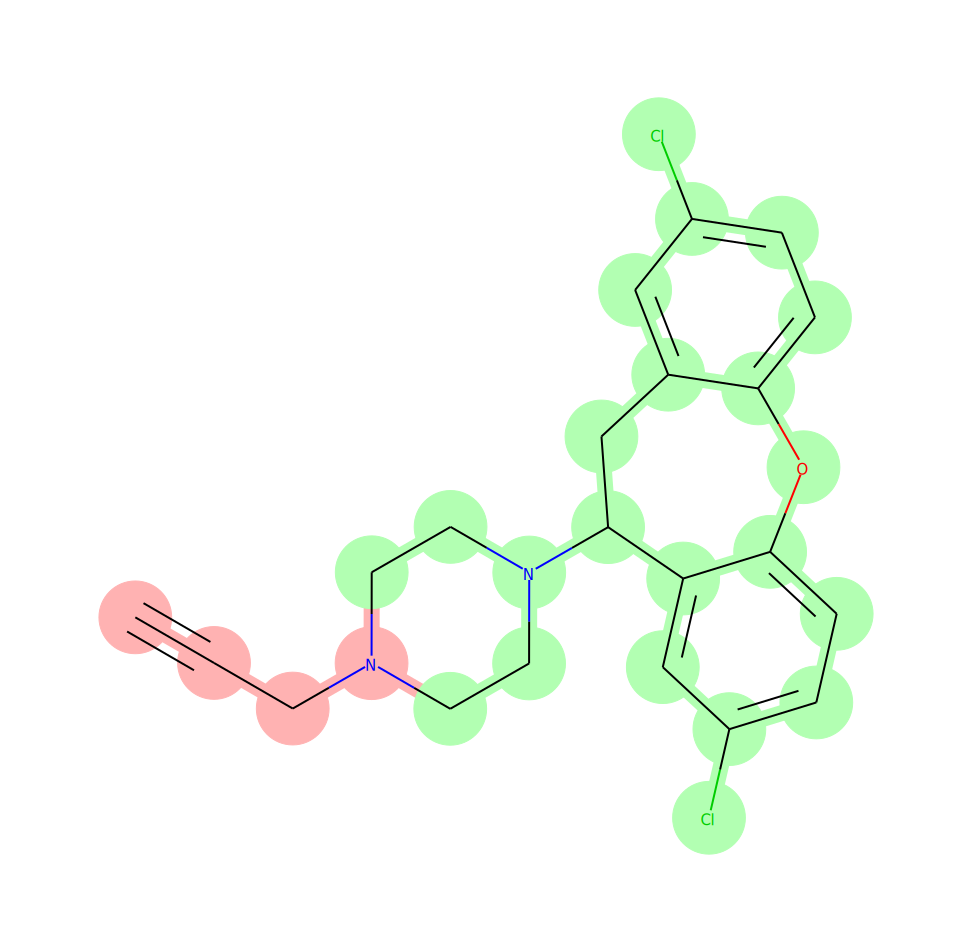

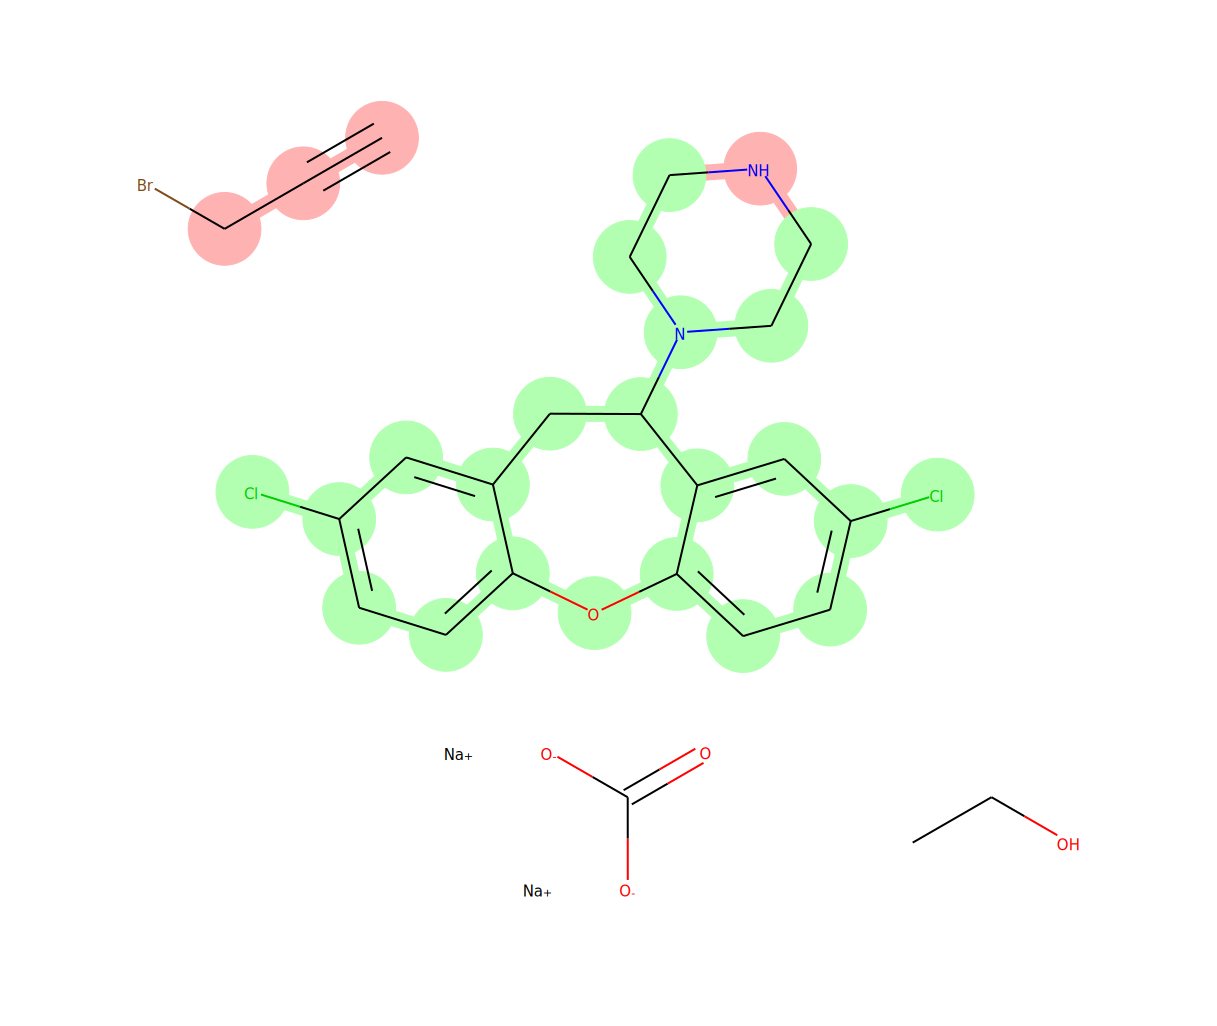

103
0.079317026


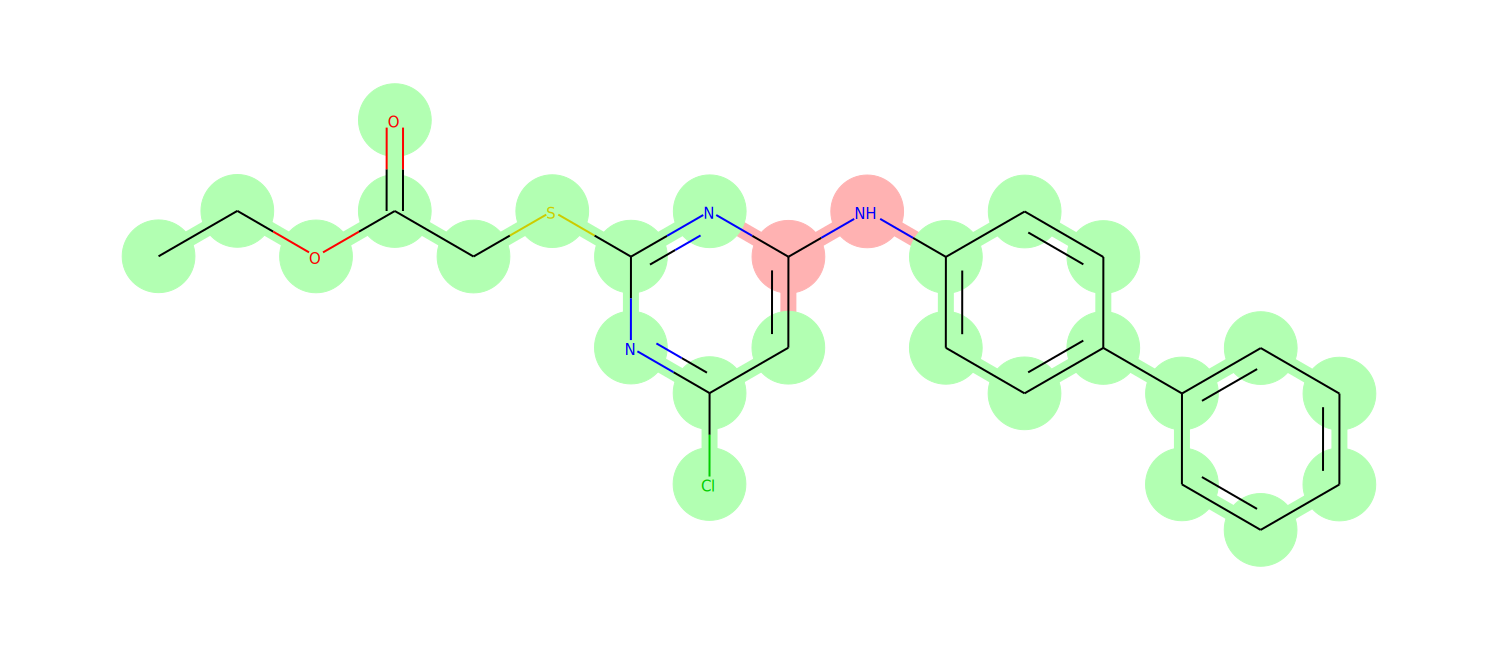

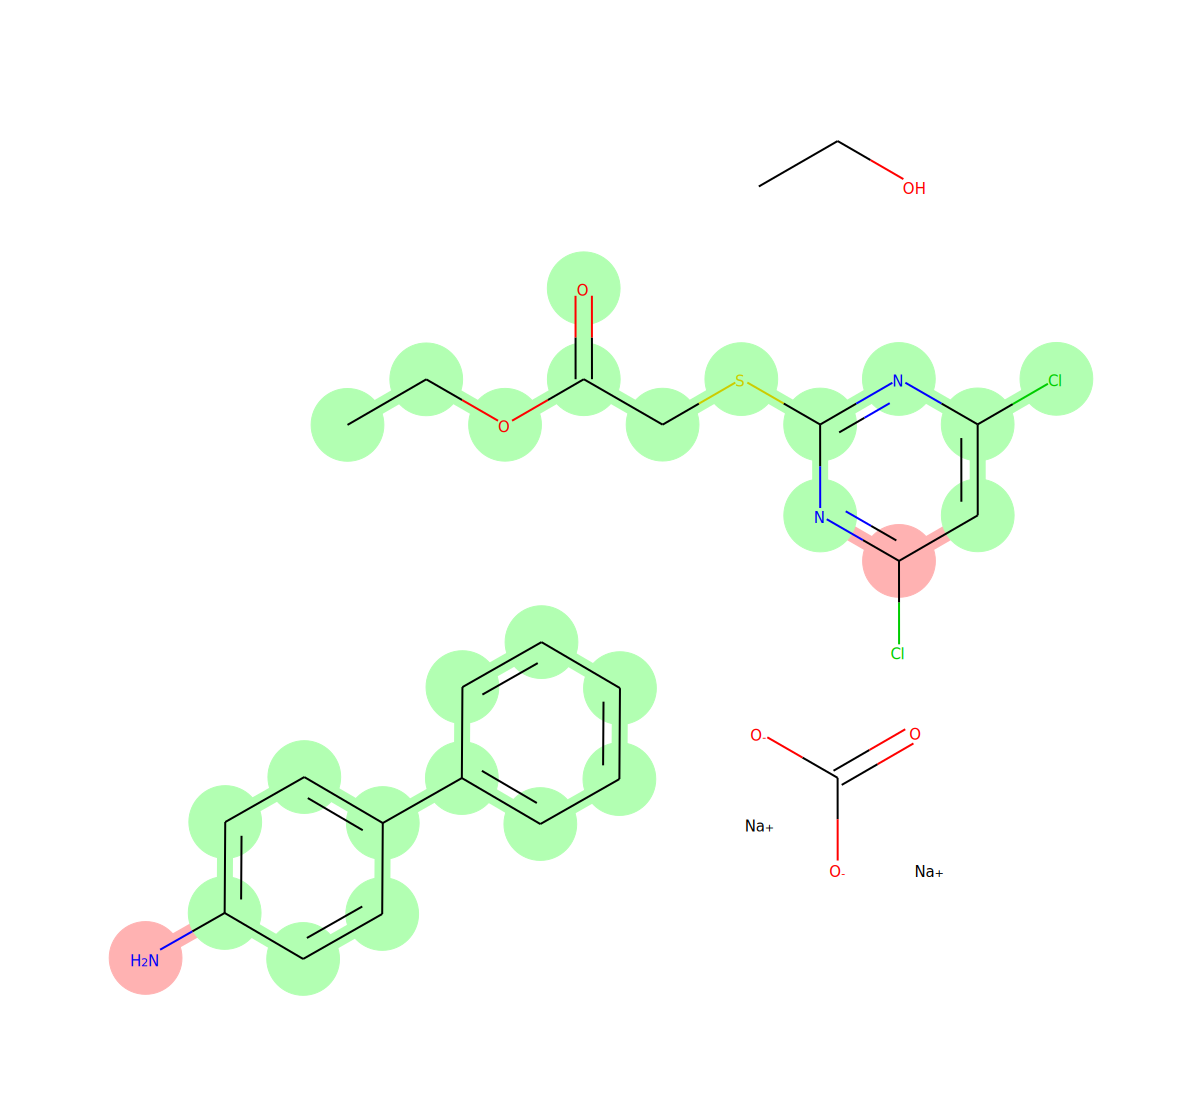

44798
0.15044671


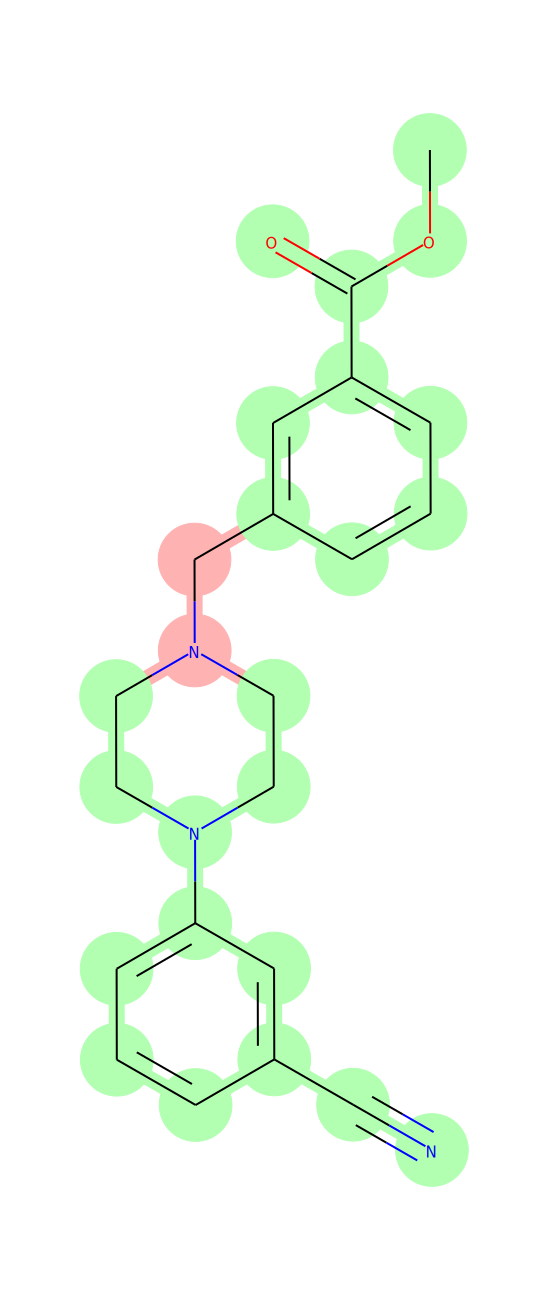

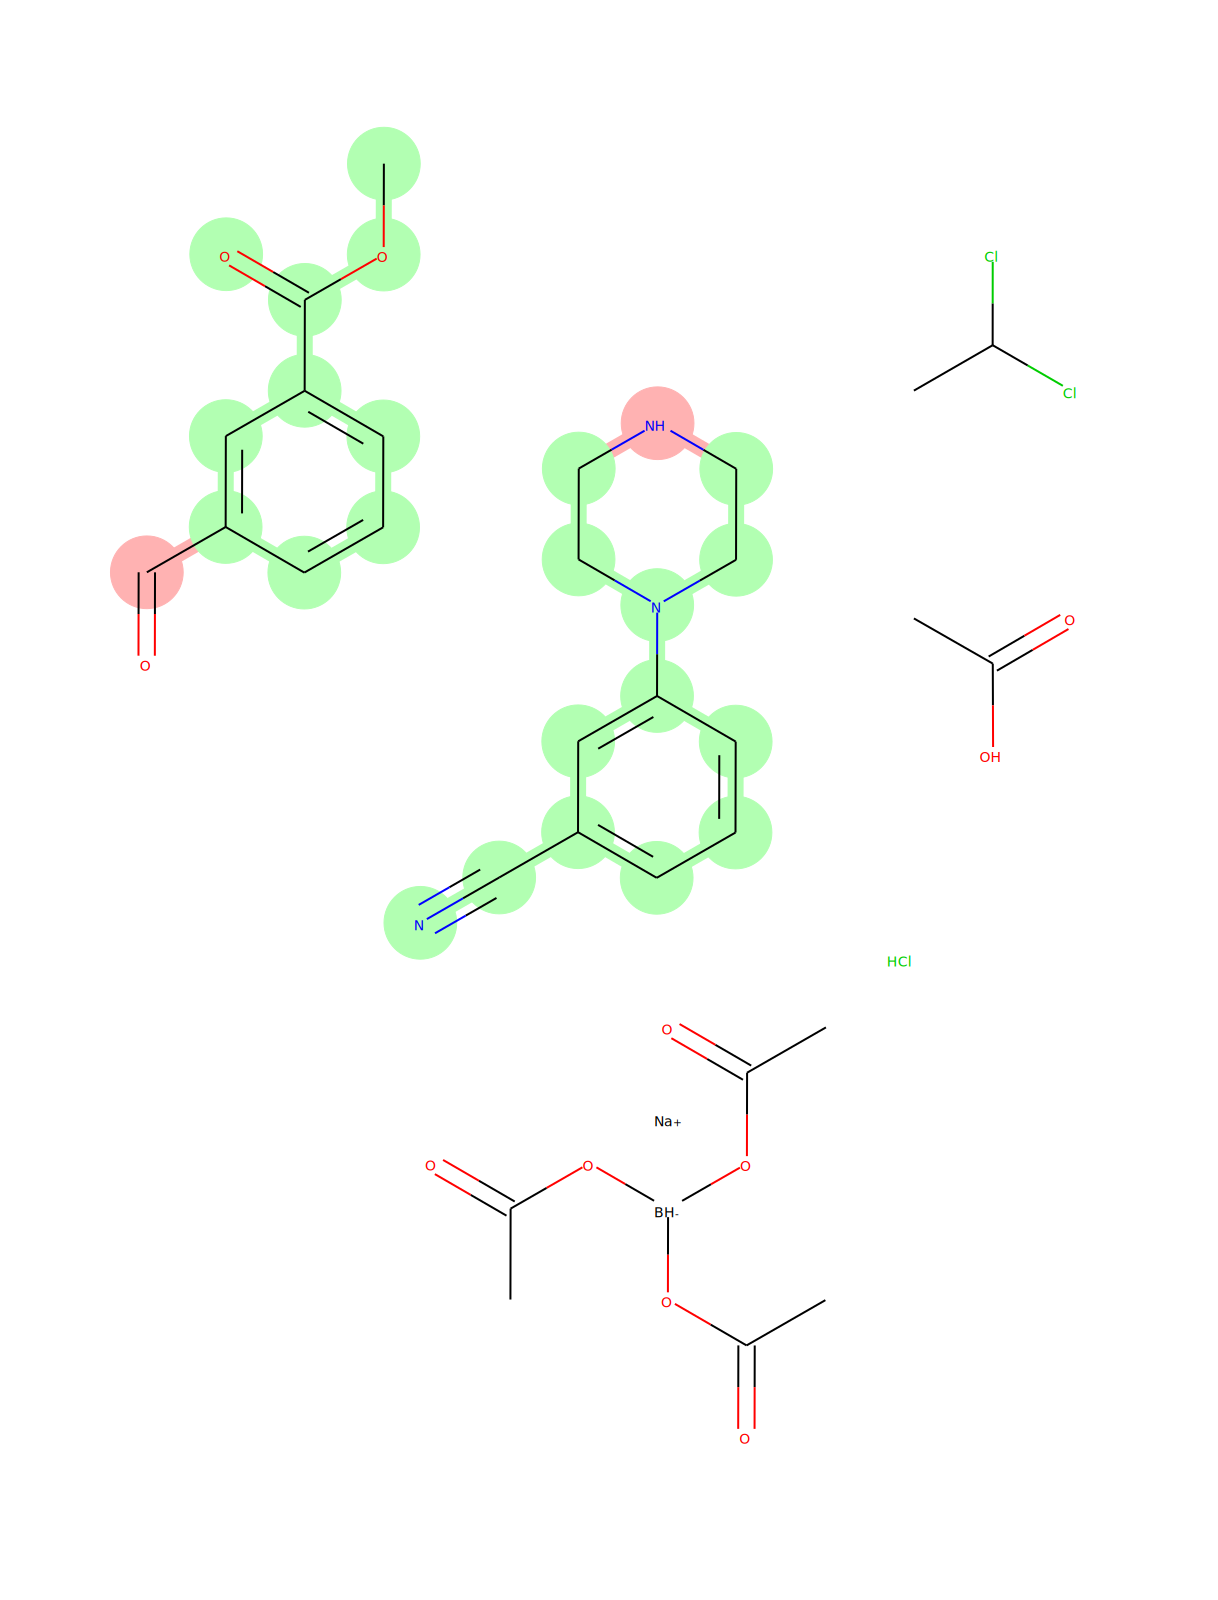

31632
0.55562854


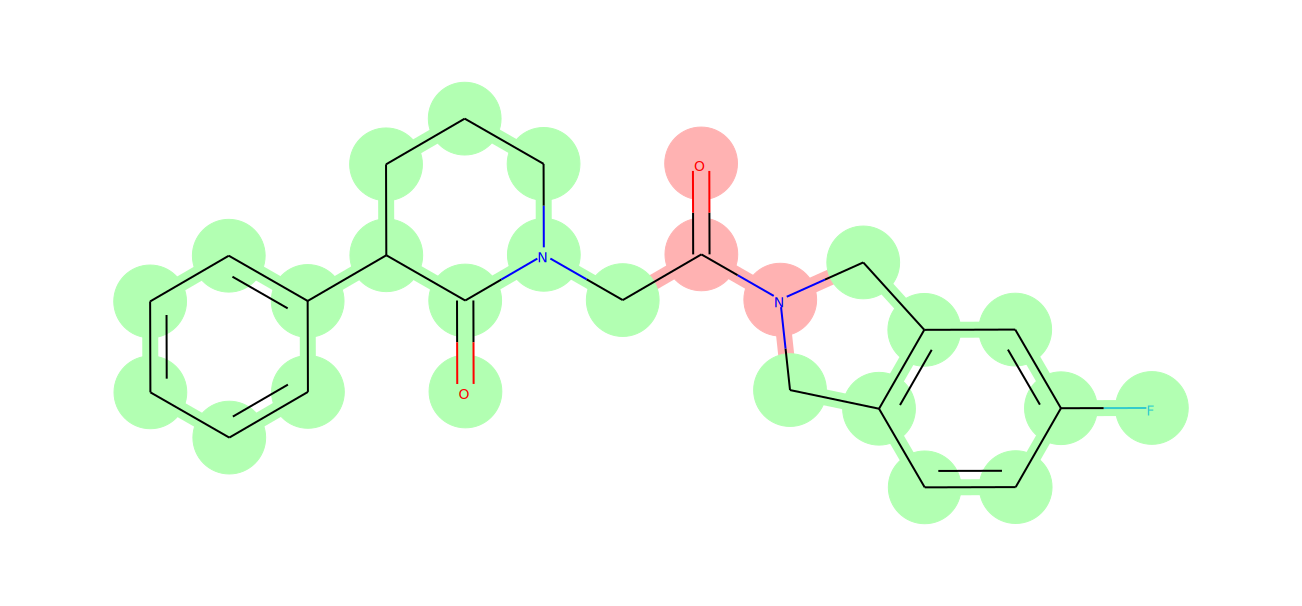

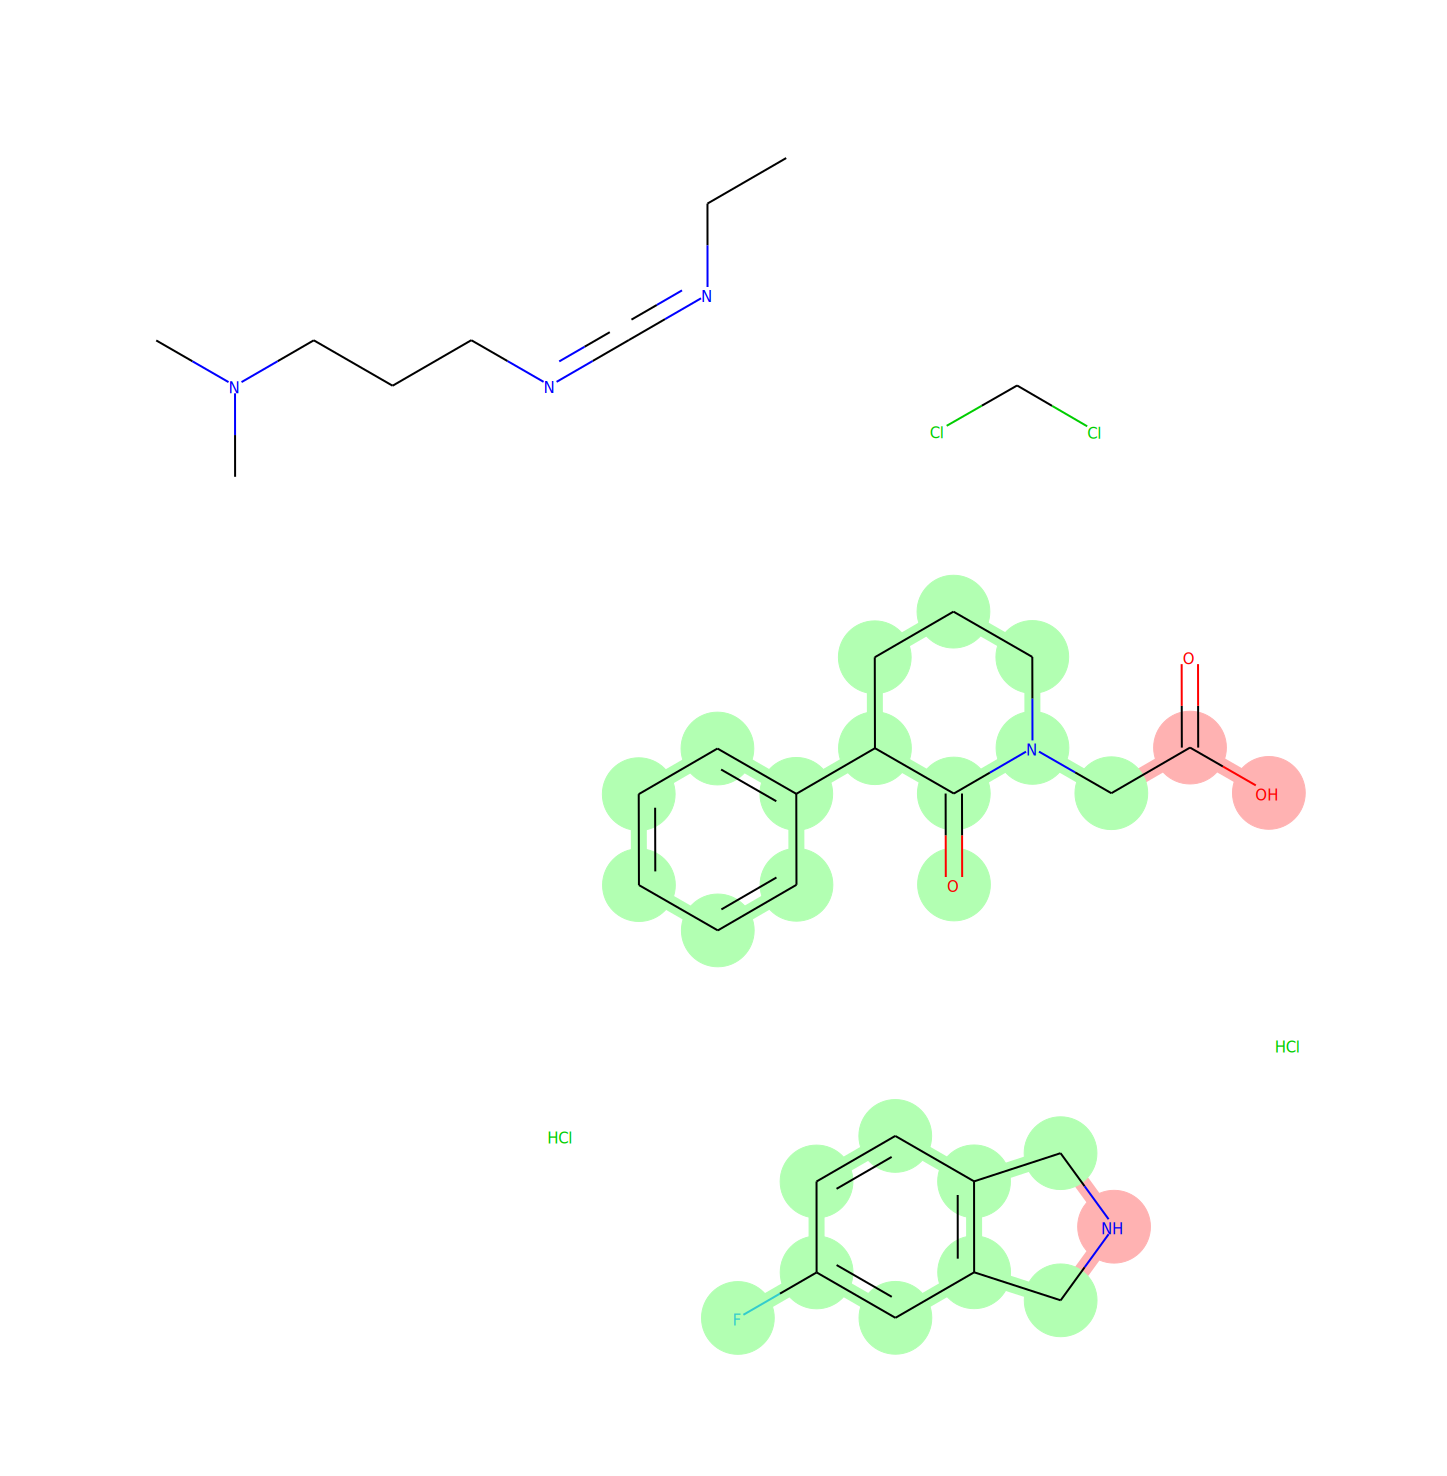

In [34]:
idx = 88
norms = np.linalg.norm(reac_reps - reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5002]])